In [1]:


import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_




In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)




In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0





In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)




In [6]:


configs.specifier = specifier
configs.data_name = data_name




In [7]:


configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [8]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)




# Load Data

In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [10]:
fix

Group SubjectID  Sentence_ID  Word_Number  FIX_X  FIX_Y  FIX_DURATION
0          1        10            4            1  177.3  531.8         219.0
1          1        10            4            2  200.5  545.2         247.0
2          1        10            4            3  282.7  542.4         261.0
3          1        10            4            4  358.1  545.5         268.0
4          1        10            4            4  392.8  536.3         129.0
...      ...       ...          ...          ...    ...    ...           ...
59765      3     zrs09           33            5  743.3  562.7         160.0
59766      3     zrs09           33            5  772.5  555.8         193.0
59767      3     zrs09           33            5  941.7  561.9         219.0
59768      3     zrs09           33            5  831.8  548.8         144.0
59769      3     zrs09           33            6  988.0  545.6         182.0

[225350 rows x 7 columns]

In [11]:
demo_phono



Group    SubjectID  Sex  Grade  Age  IQ  Reading_speed  Sound_detection  \
0        1           10    1      4   10  23          102.0         0.620000   
1        1          108    1      4   10  34          139.0         1.000000   
2        1           11    2      4   10  34          110.0         1.000000   
3        1     11_norm1    1      2    9  28           71.0         0.950000   
4        1     12_norm1    2      2    8  32           60.0         0.950000   
..     ...          ...  ...    ...  ...  ..            ...              ...   
212      1  varya_norm1    1      1    7  34           56.0         1.000000   
68       3        vpa21    2      1    7  32           22.0         0.916667   
69       3        yea20    1      3    9  34           20.0         0.875000   
70       3        zaa15    1      3   10  31           78.0         0.958333   
71       3        zrs09    2      3   10  32           97.0         0.956522   

     Sound_change  
0        0.910000  
1        0.950000  
2        0.790000  
3        0.910000  
4        0.620000  
..            ...  
212      0.920000  
68       0.916667  
69       0.500000  
70       0.916667  
71       0.875000  

[307 rows x 9 columns]

In [12]:




x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)




x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [13]:

features = dd.features
features


['Sex_1',
 'FIX_Y',
 'Grade_4',
 'Grade_5',
 'Grade_1',
 'Sex_2',
 'Grade_2',
 'FIX_DURATION',
 'Grade_6',
 'IQ',
 'FIX_X',
 'Grade_3',
 'Age']



# Dependency scrutinizing  


Let us start with scrutinizing the existence of dependency between the Fixation report variables.

## AutoCorrelation Function (AFC)


- The autocorrelation quantifies the average similarity between the signal and a shifted version of the same signal, as a function of the delay between the two. In other words, autocorrelation can give us information about repeating patterns as well as the timescale of the signal's fluctuations. The faster the autocorrelation decays to zero, the faster the signal varies.

- Once plotted, X-axis shows the lag number, and Y-axis shows the correlation of the sequence with a sequence at that lag. Y-axis ranges from -1 to 1.

- **Anything inside the shaded area of ACF plots isn’t statistically significant(lower than 95% confidence interval)**


- Before calculating autocorrelation, one should make the time series **stationary**, that is, the mean, variance, and covariance shouldn’t change over time. I normalized the sequences by dividing the maximum of the variable.


##### Data Stationary

- One can check if your time series is stationary by looking at a line plot of the series over time.

    - Signs of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series.

- A more accurate method would be to use a statistical test, such as the **Dickey-Fuller test**.



## Partial AutoCorrelation Function (PAFC)

- PACF shows only the direct effects, and all intermediary effects are removed. For example, one wants to know the direct relationship between the number of passengers today and 12 months ago. She doesn’t care about anything in between.



# Possible Questions


- Q1: How correlated are the words in a sentence: dyslexic vs normal  **(the lag value = the number of words in a sentence)** >> reply with AFC
        
- Q2: How correlated are the string in a word: dyslexic vs normal **(the lag value = the number of strings in a word)** ?? (I don't know the words lengths and thus can't answer)

- Q3: How correlated are some specific words in a sentence, e.g., first and last word, or odd words: dyslexic vs normal >> reply with PAFC



**- Note The more lags you use, the lower the correlation will be. More recent periods have more impact.**






In [14]:


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf



### Toy data 

ACF : [ 1.     0.01  -0.49  -0.498 -0.01   0.976  0.01  -0.479 -0.486 -0.01
  0.952  0.01  -0.467 -0.474 -0.01   0.929  0.01  -0.455 -0.462 -0.01
  0.905  0.01  -0.443 -0.45  -0.01   0.881  0.01  -0.431 -0.438 -0.01
  0.857  0.01  -0.419 -0.426 -0.01   0.833  0.01  -0.407 -0.414 -0.01
  0.81   0.01  -0.395 -0.402 -0.01   0.786  0.01  -0.383 -0.39  -0.01
  0.762  0.01  -0.371 -0.379 -0.01   0.738  0.01  -0.36  -0.367 -0.01
  0.714  0.01  -0.348 -0.355 -0.01   0.69   0.01  -0.336 -0.343 -0.01
  0.667  0.01  -0.324 -0.331 -0.01   0.643  0.01  -0.312 -0.319 -0.01
  0.619  0.01  -0.3   -0.307 -0.01   0.595  0.01  -0.288 -0.295 -0.01
  0.571  0.01  -0.276 -0.283 -0.01   0.548  0.01  -0.264 -0.271 -0.01
  0.524] 
PACF: [ 1.     0.01  -0.495 -0.653 -0.926  1.004 36.378 -1.019 -1.112  5.439
  0.998 35.589 -1.013 -1.284  2.754  0.996 34.71  -1.011 -1.392  2.271
  0.995 33.799 -1.01  -1.473  2.053  0.994 32.868 -1.009 -1.543  1.918
  0.993 31.919 -1.009 -1.61   1.817  0.992 30.956 -1.008 -1.681  

invalid value encountered in sqrt
invalid value encountered in sqrt


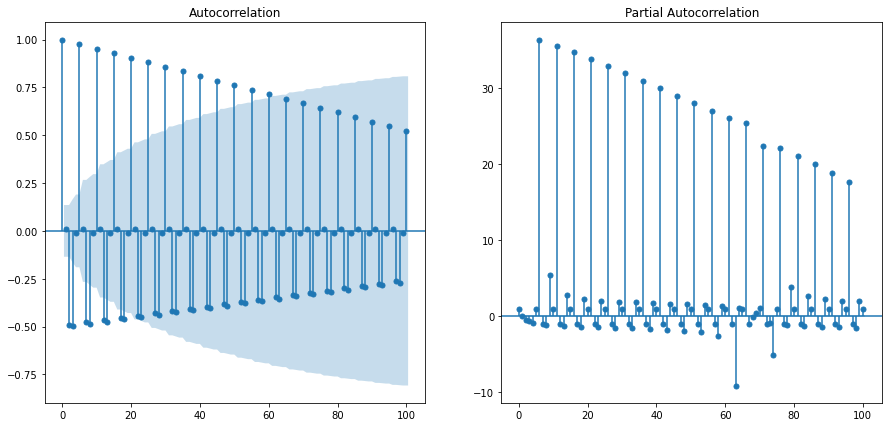

In [15]:



x3 = np.array([
    1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    # 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    # 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
    1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
])

nlags = 100 

x3_acf = acf(x3, nlags=nlags, fft=False)
x3_pacf = pacf(x3, nlags=nlags,)




print(
    f"ACF : {x3_acf} \n"
    f"PACF: {x3_pacf} \n"
)



fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 2, 1)  # two datasets
plot_acf(x=x3/max(x3), ax=ax, lags=nlags)

ax = fig.add_subplot(1, 2, 2)  
plot_pacf(x=x3/(max(x3)), ax=ax, lags=nlags)
plt.show()








- We observe various significant correlations at 5th, 10th, 15th, .... points (as expected)

- Over the time AFC and PAFC decrease

- There are some strange behaviours in PACF plot, which I prefer not to pay attention to, as it is not my purpose now




# Scrutinizing FIX_X, FIX_Y, FIX_DURATION using AFC and PACF plots:



For a fair comparison, I will select normal and dyslexic subjects with identical IQ, grade and gender


## Selecting individuals:



## Case1: Grade = 4;  IQ = 30

## Case2: Grade = 3;  29 <=IQ <= 30



In [18]:

def filter_data(df, iq_low, iq_high, n_grade, group):
    
    filtered_df = df.loc[
        (df_data_to_use.IQ >= iq_low) & (df_data_to_use.IQ <= iq_high) &
        (df_data_to_use.Grade == n_grade) & (df_data_to_use.Group == group)
    ]
    
    return filtered_df 



In [19]:



n_grade = 4 
iq_low = 30
iq_high = 30


n1 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=1
)

r1 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=2
)



d1 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=3
)


s_m = min(len(set(n1.SubjectID)), len(set(d1.SubjectID)))


print(
    f"Normals  : {len(set(n1.SubjectID))} \n"
    f"At-risks : {len(set(r1.SubjectID))} \n"
    f"Dyslexics: {len(set(d1.SubjectID))} \n"
    f"Min. number of in-common subjects: {s_m} \n"

)


Normals  : 3 
At-risks : 0 
Dyslexics: 4 
Min. number of in-common subjects: 3 



In [20]:


n1_subjs = list(set(n1.SubjectID))
d1_subjs = list(set(d1.SubjectID))
c1_subjs = n1_subjs + d1_subjs

for i in c1_subjs:
    if i in n1_subjs:
        c = "normal"
        g = set(n1.loc[n1.SubjectID == i].Sex)
        iq = list(set(n1.loc[n1.SubjectID == i].IQ))[0]
        
        if g == {1}:
            g = "female"
        else:
            g = "male"
        
    elif i in d1_subjs:
        
        c = "dyslexic"
        g = set(d1.loc[d1.SubjectID == i].Sex)
        iq = list(set(d1.loc[d1.SubjectID == i].IQ))[0]
        
        if g == {1}:
            g = "female"
        else:
            g = "male"
    
    print(
        f"Subjecd ID = {i} is a {c} {g} with IQ {iq}\n"
    )
    
    
    

Subjecd ID = s134 is a normal male with IQ 30

Subjecd ID = m111 is a normal female with IQ 30

Subjecd ID = s97 is a normal male with IQ 30

Subjecd ID = m39 is a dyslexic female with IQ 30

Subjecd ID = s177 is a dyslexic female with IQ 30

Subjecd ID = m54 is a dyslexic female with IQ 30

Subjecd ID = m43 is a dyslexic female with IQ 30



In [27]:



def plot_norm_vs_dyslexic_AFC(data_n, data_d, feature):
    print(feature)

    issues = []
    data_n_subjs = list(set(data_n.SubjectID))
    data_d_subjs = list(set(data_d.SubjectID))
    c_subjs = data_n_subjs + data_d_subjs  # case subjects
    
    for sentence in set(data_n.Sentence_ID):
        nlags = max(data_n.loc[(data_n.Sentence_ID == sentence)].Word_Number)
        fig = plt.figure(figsize=(20, 30))
        cntr = 1
        
        for i in c_subjs:
            try:
                if i in data_n_subjs:
                    c = "normal"
                    subj_data = data_n.loc[(data_n.SubjectID == i) & (data_n.Sentence_ID == sentence)]
                    g = set(data_n.loc[data_n.SubjectID == i].Sex)
                    iq = list(set(data_n.loc[data_n.SubjectID == i].IQ))[0]
                    if g == {1}:
                        g = "female"
                    else:
                        g = "male"

                elif i in data_d_subjs:
                    c = "dyslexic"
                    subj_data = data_d.loc[(data_d.SubjectID == i) & (data_d.Sentence_ID == sentence)]
                    g = set(data_d.loc[data_d.SubjectID == i].Sex)
                    iq = list(set(data_d.loc[data_d.SubjectID == i].IQ))[0]

                    if g == {1}:
                        g = "female"
                    else:
                        g = "male"

                ax = fig.add_subplot(len(c1_subjs), 1, cntr)
                plot_acf(
                    x=subj_data.loc[:, feature]/(max(subj_data.loc[:, feature])), ax=ax, lags=nlags
                )
                plt.title(
                    f"Subject ID = {i} is a {c} {g} with IQ {iq}:"
                    f" reading sentence {sentence} with max. number of words {nlags}"
                )
                cntr += 1

            except:
                issues.append(
                    f"Subject ID = {i} is a {c} {g} who skipped "
                    f"reading {sentence},"
                    )
    
        
                
    return issues 



FIX_X


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


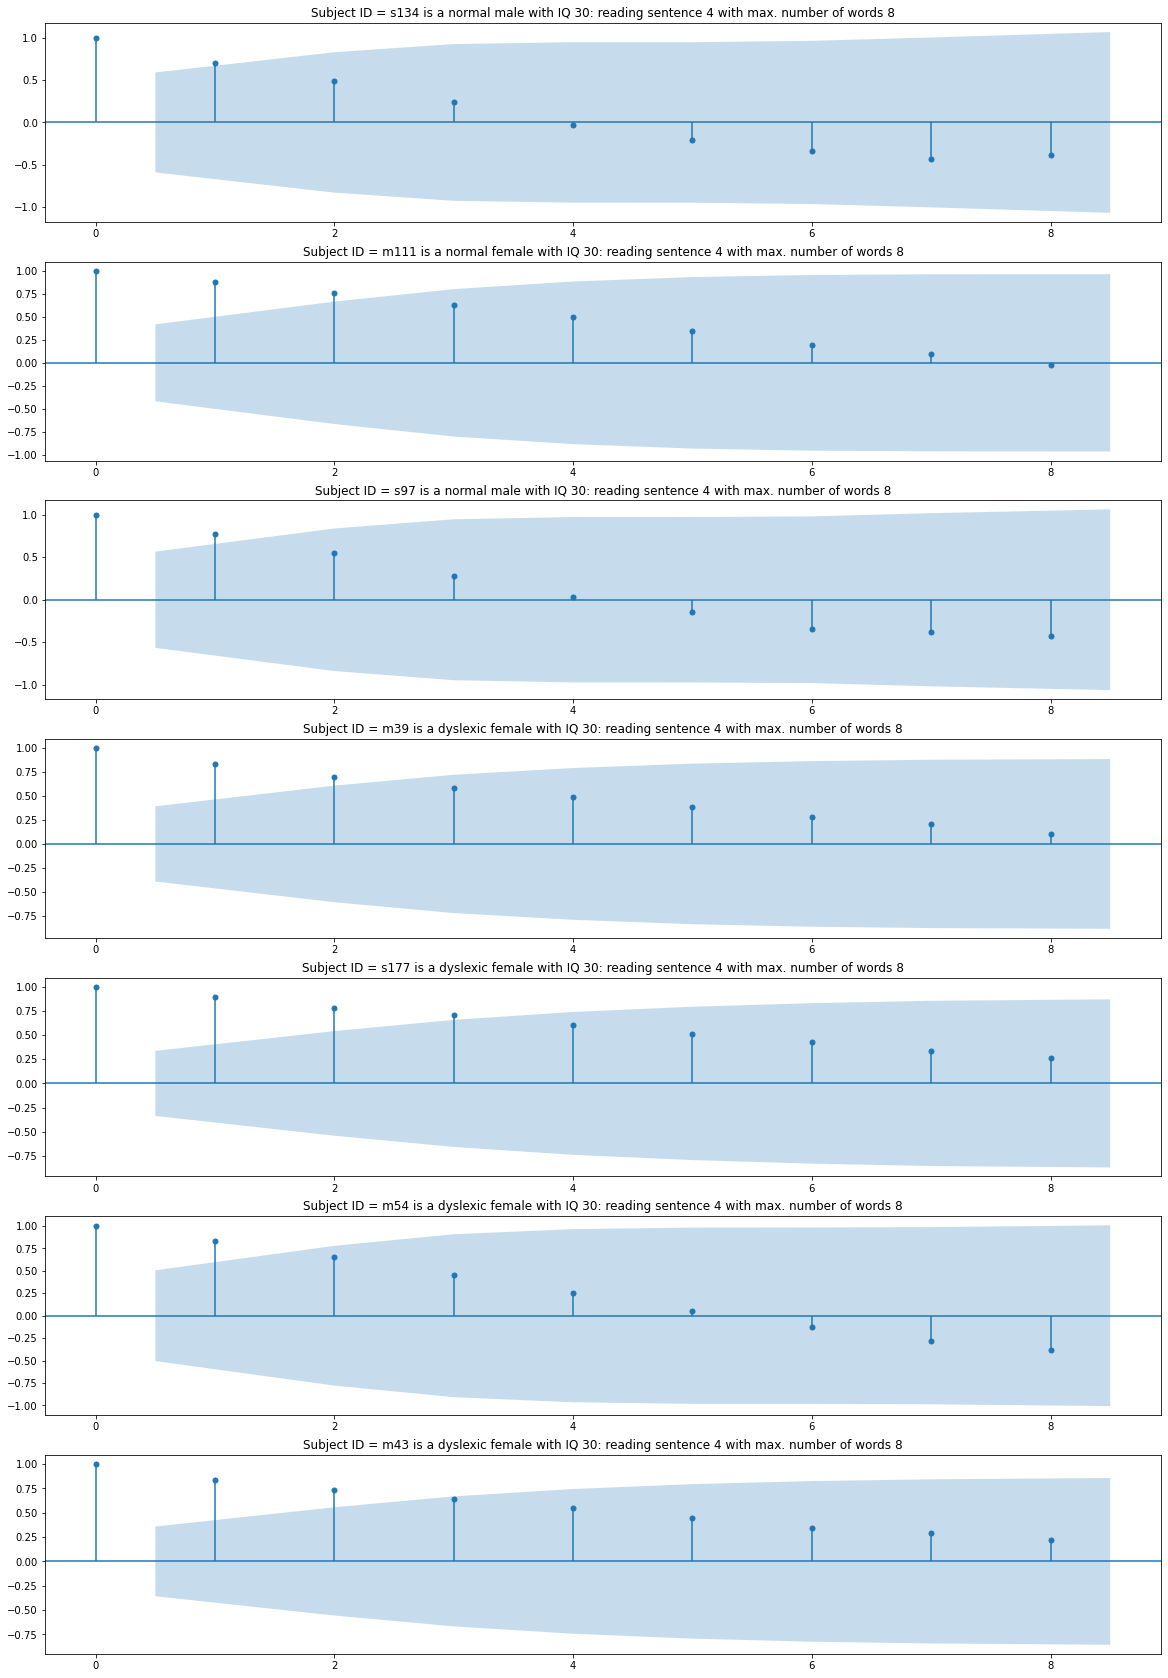

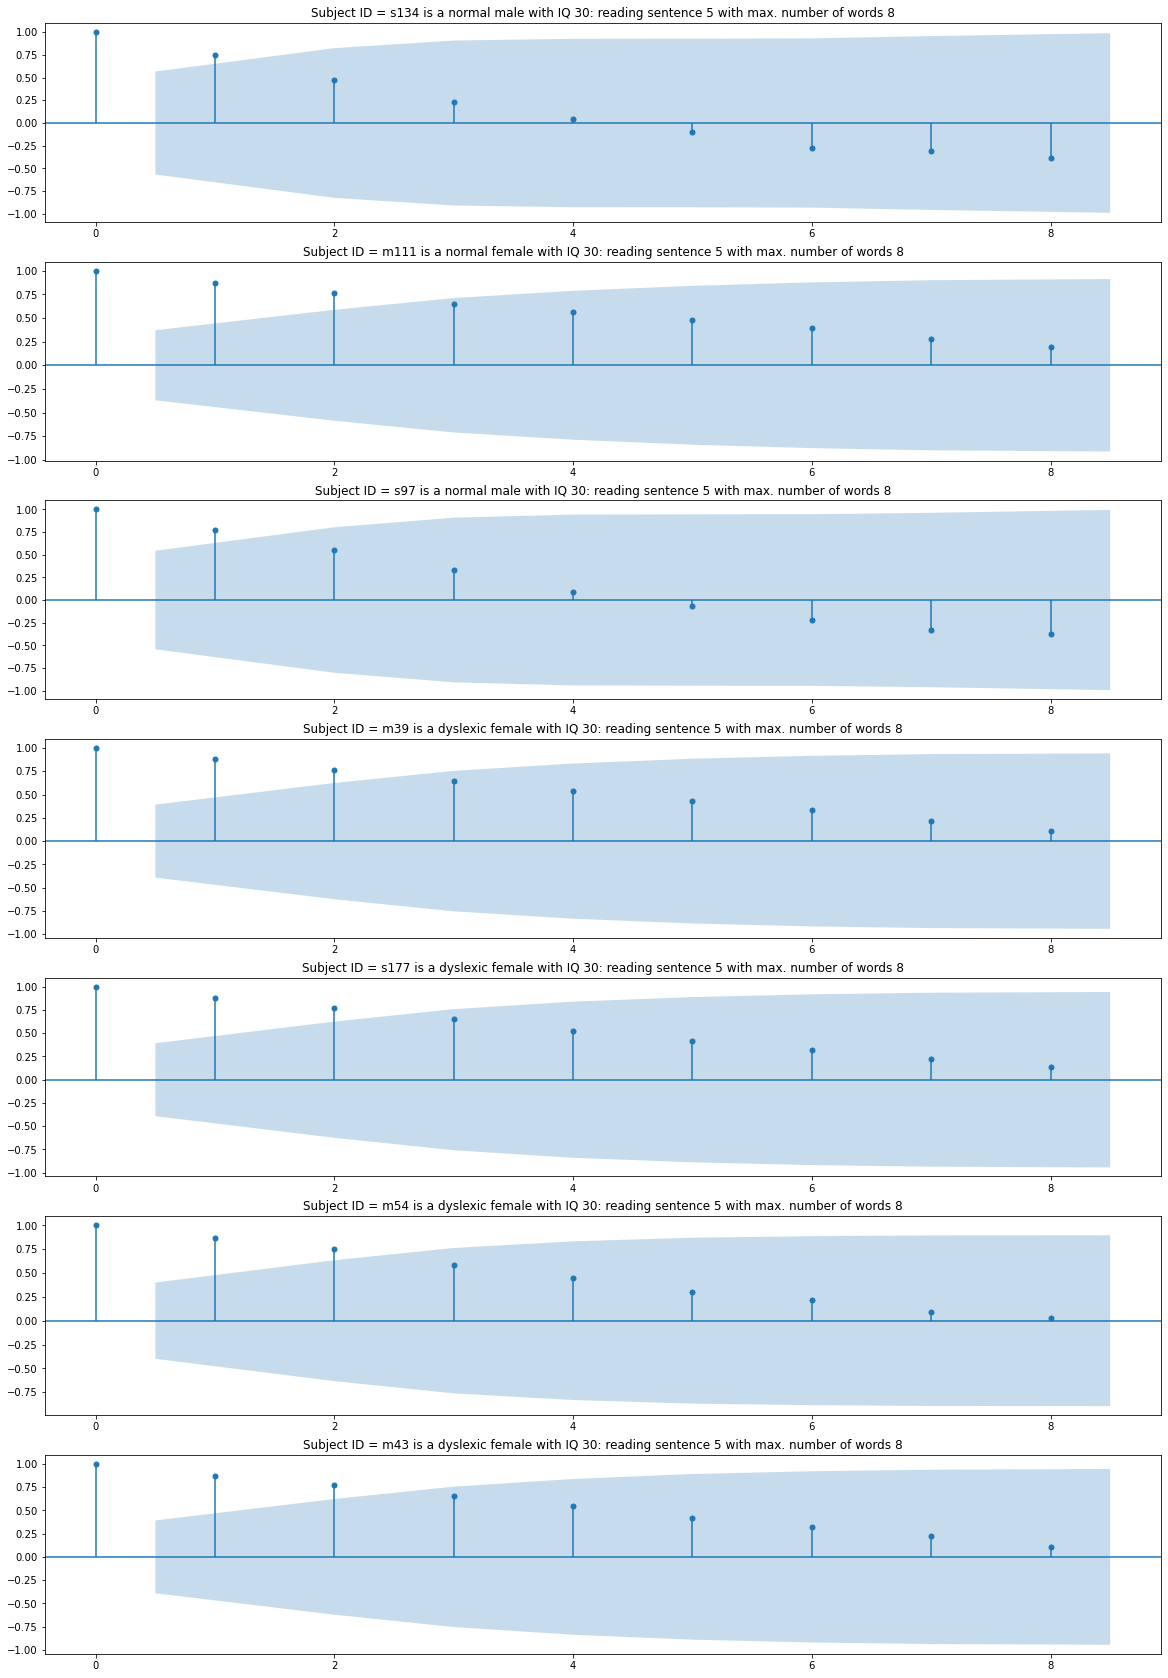

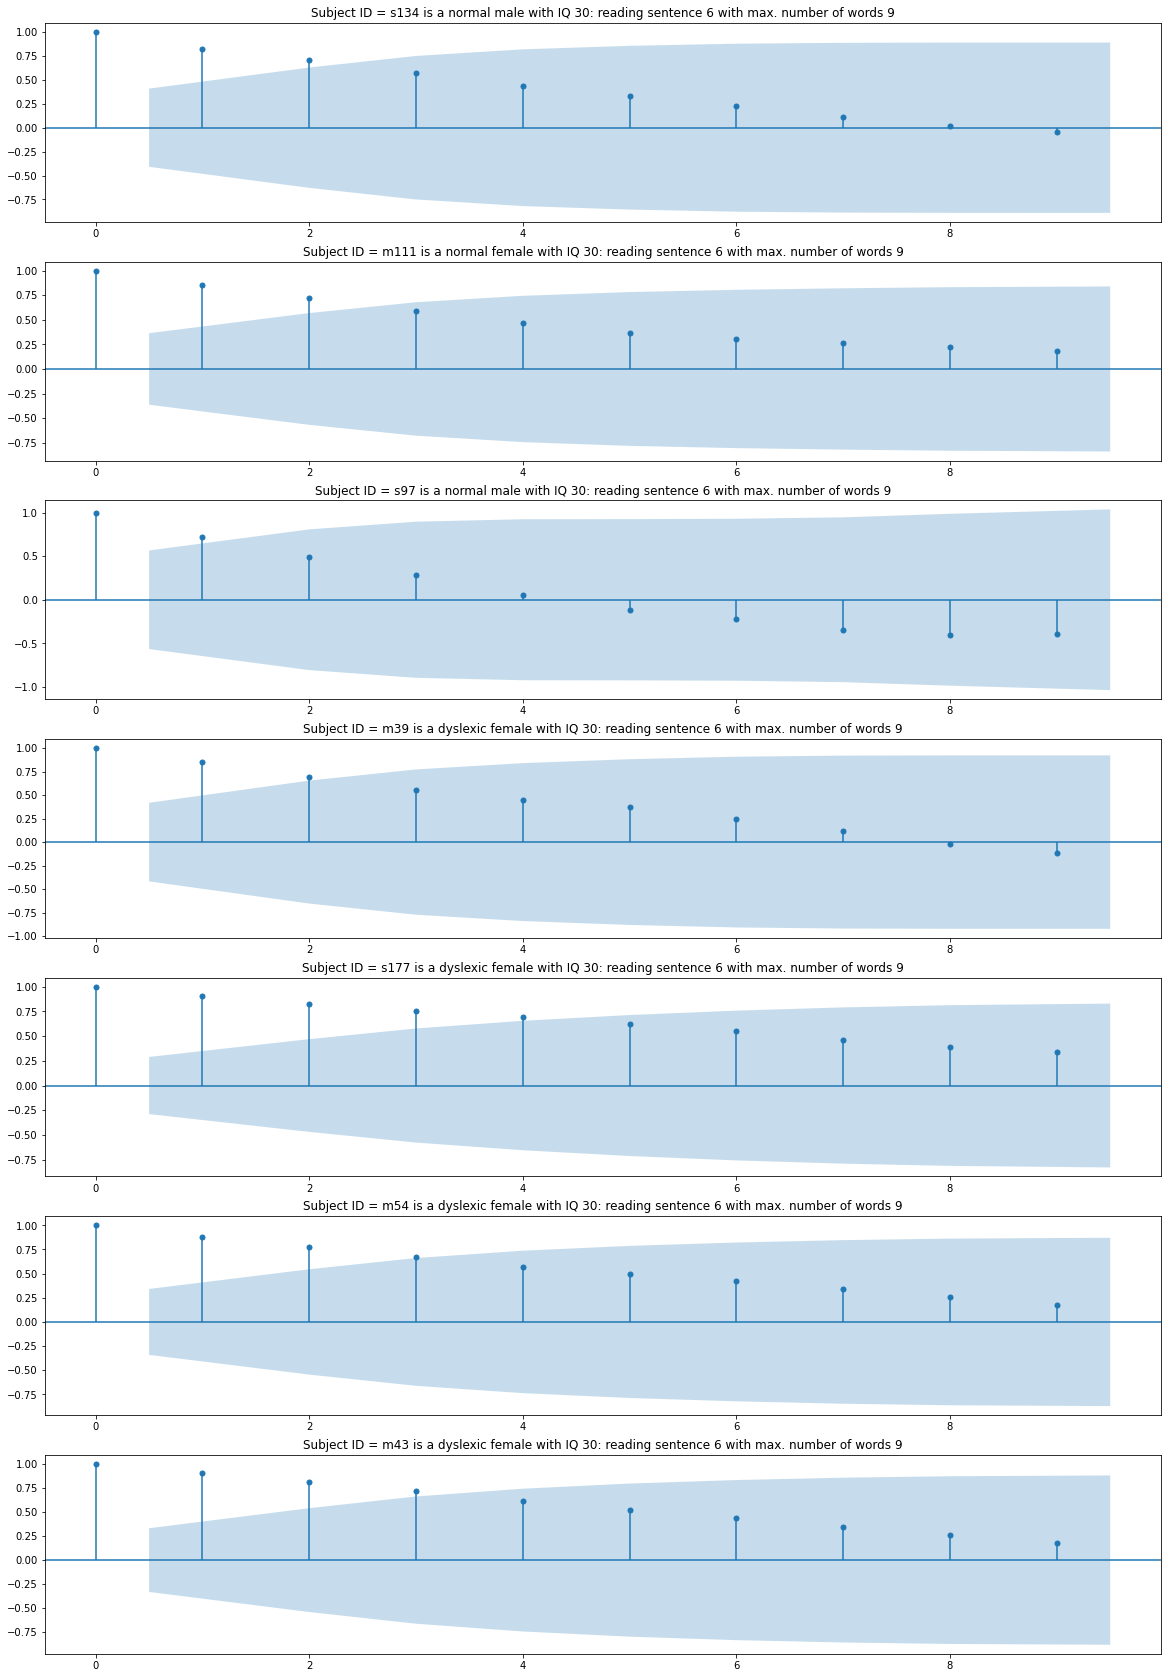

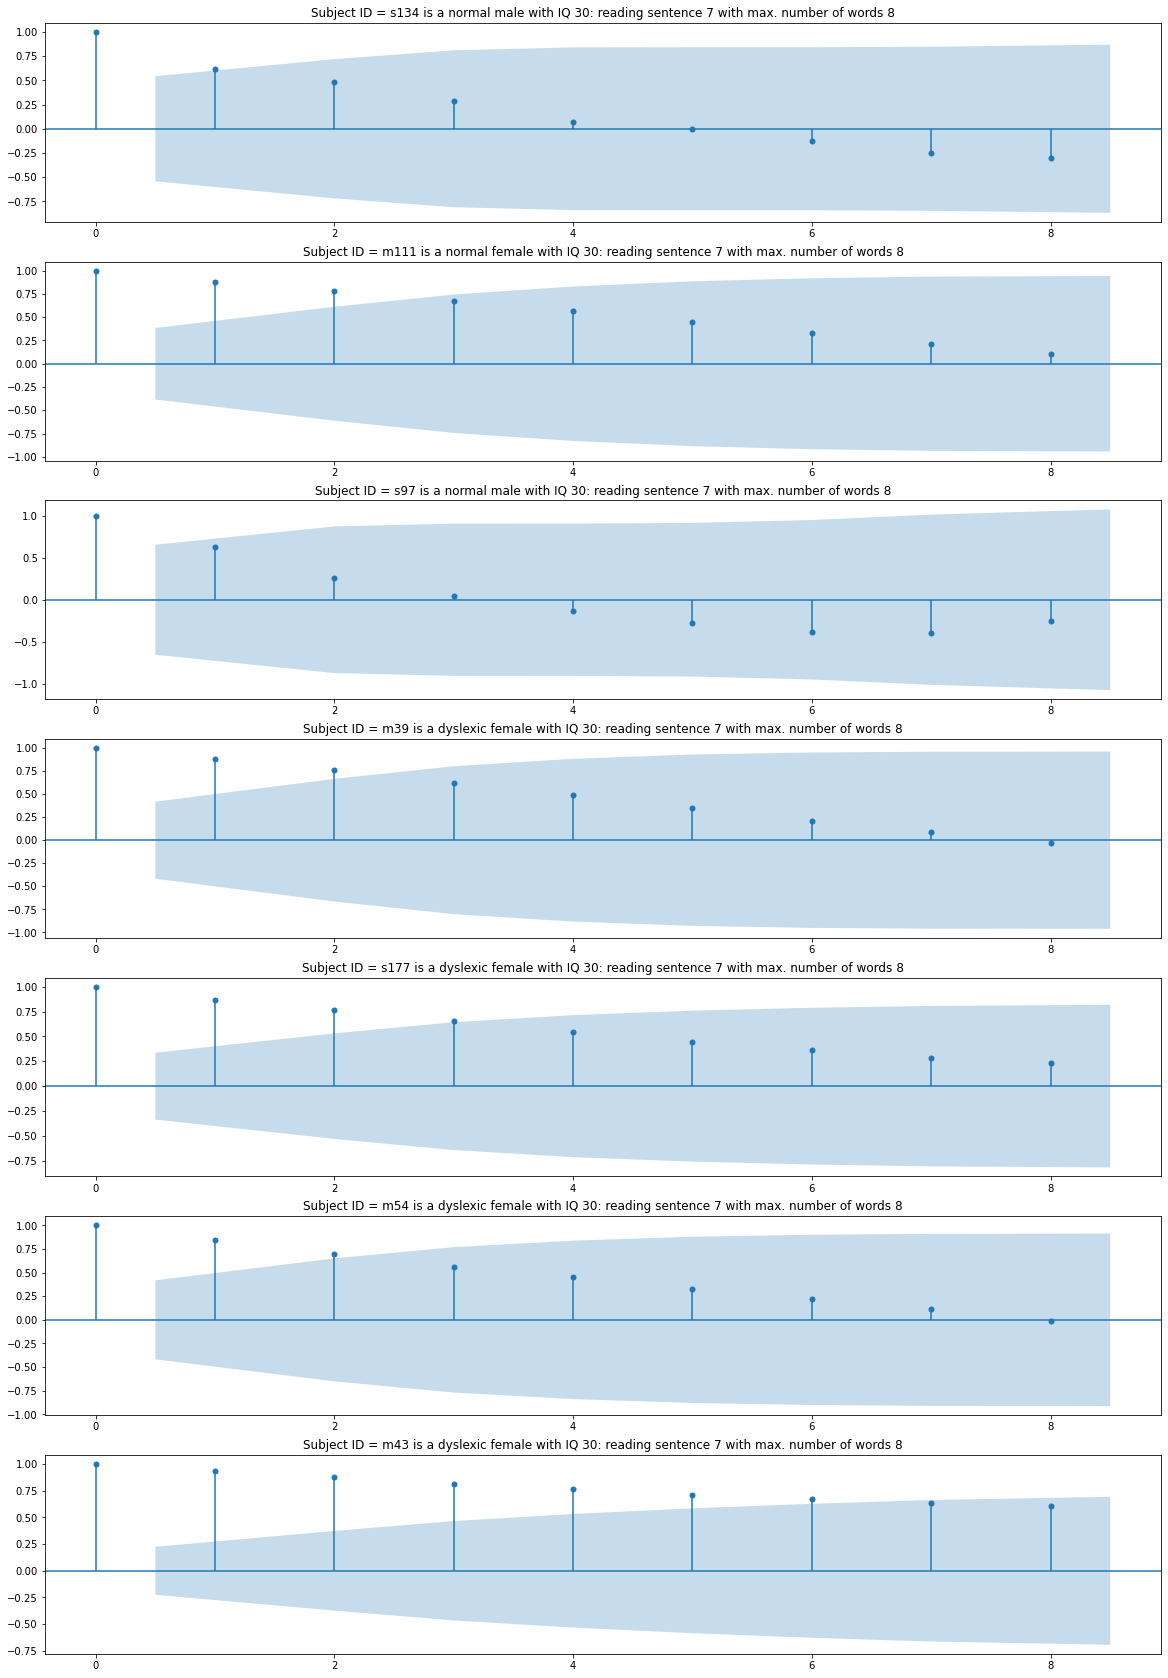

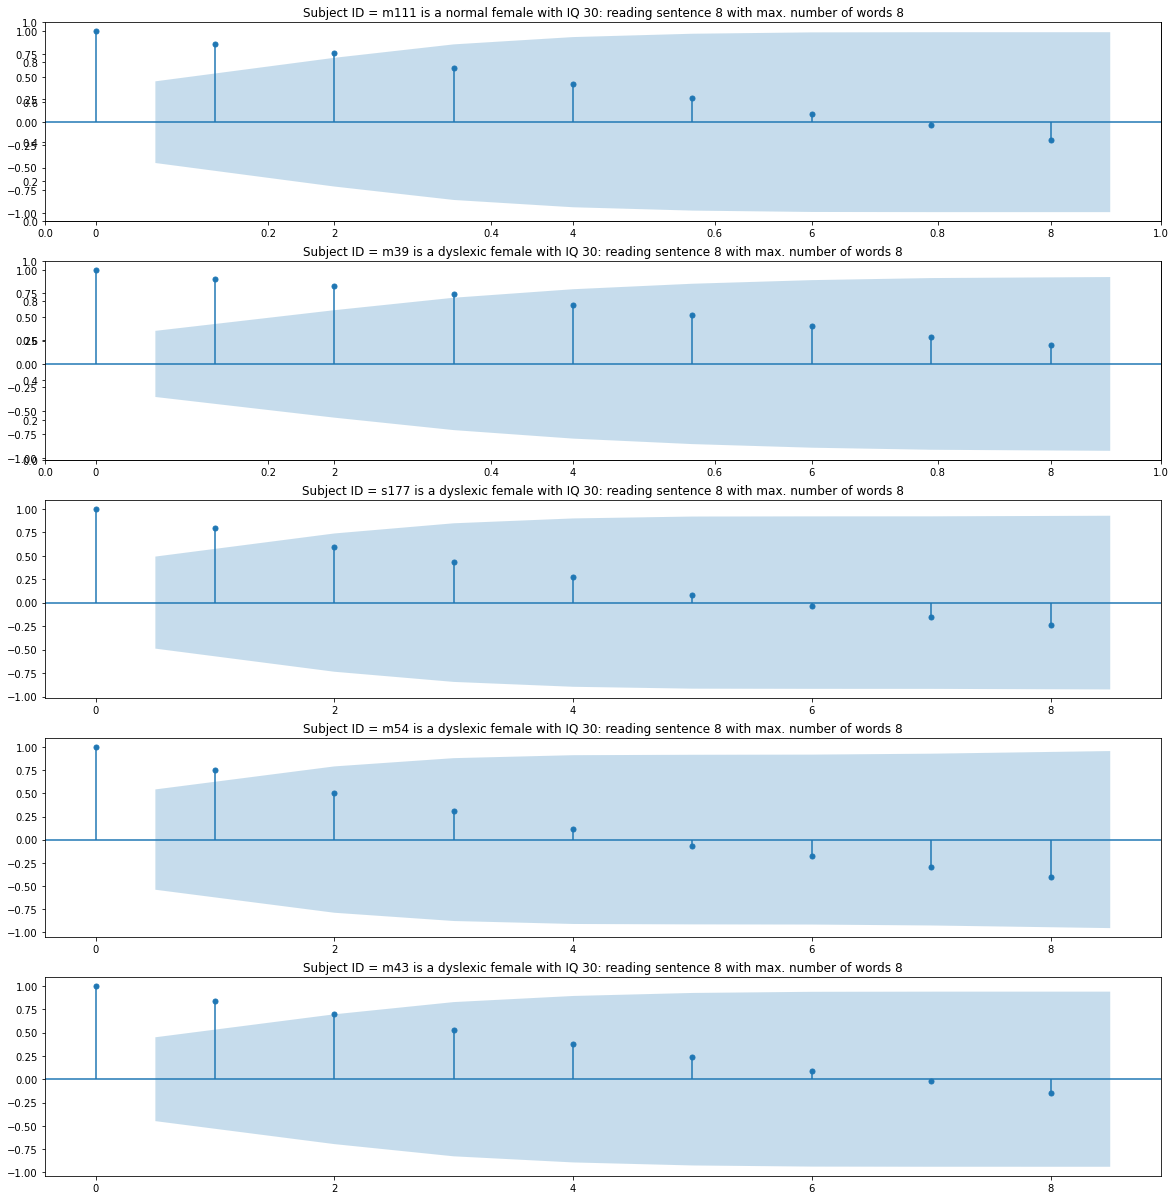

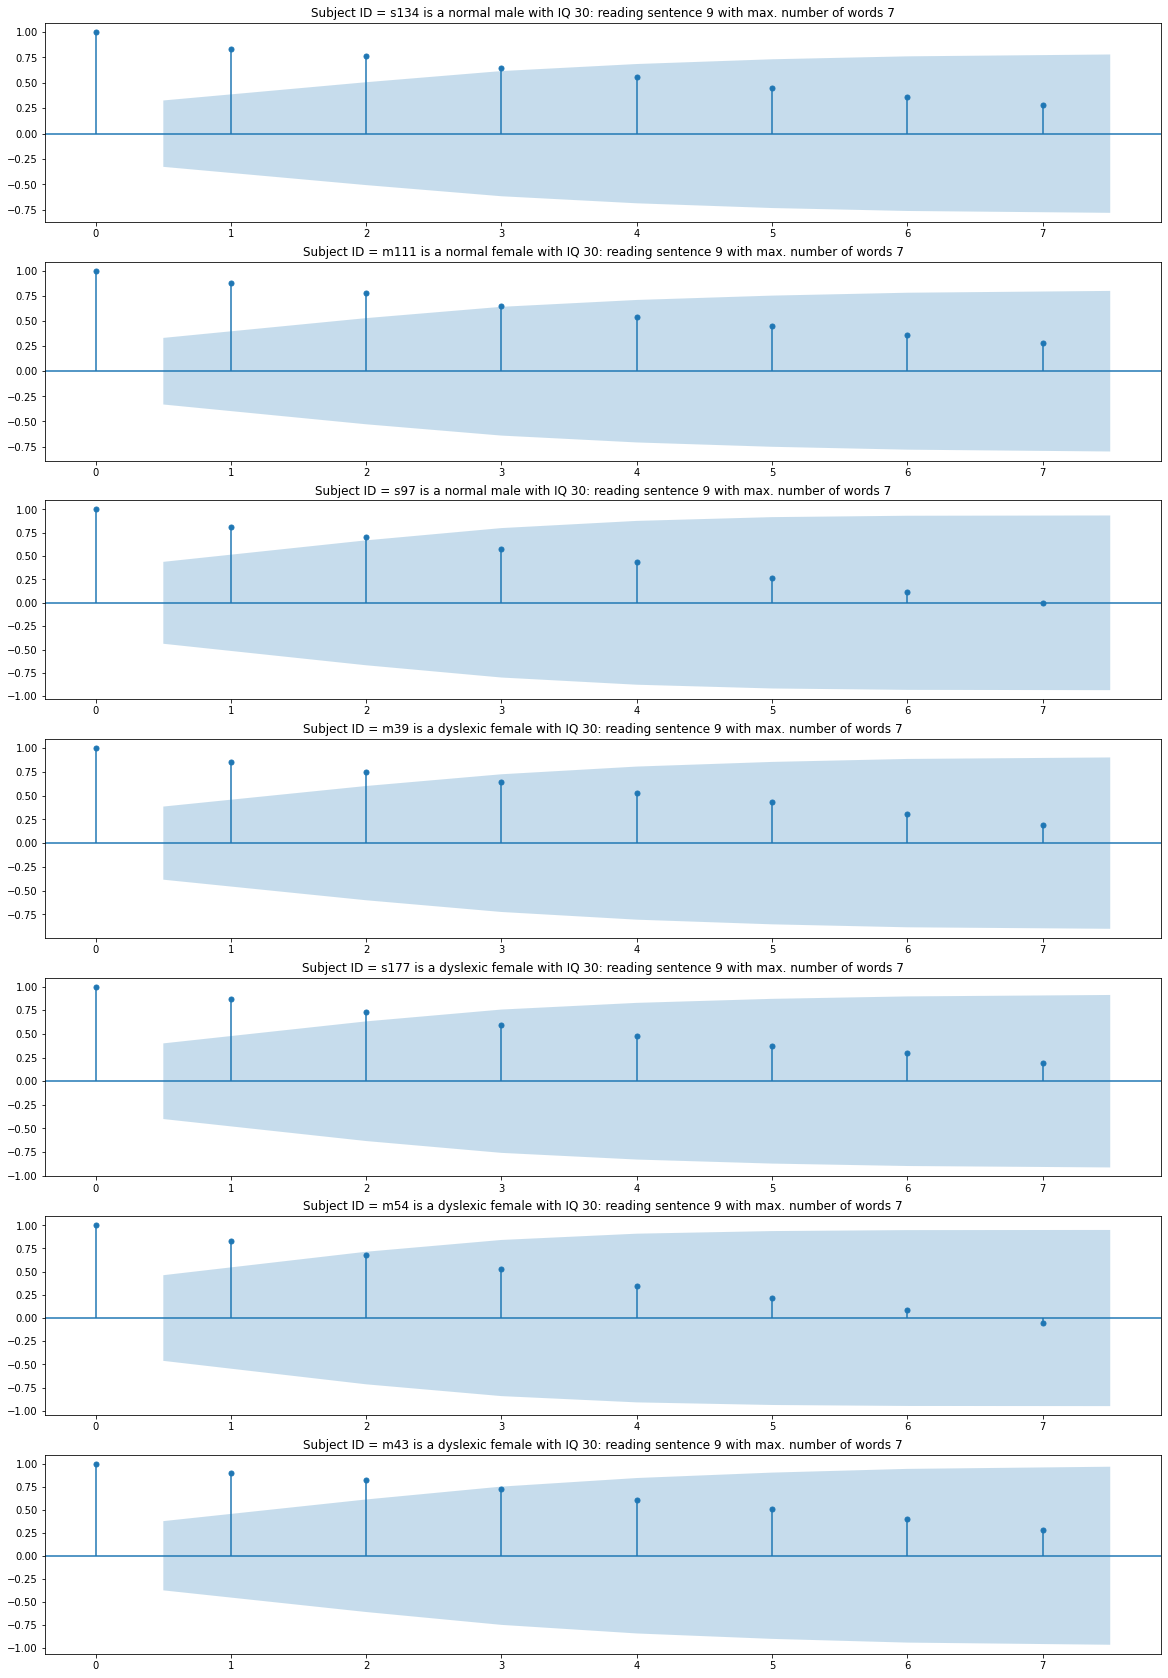

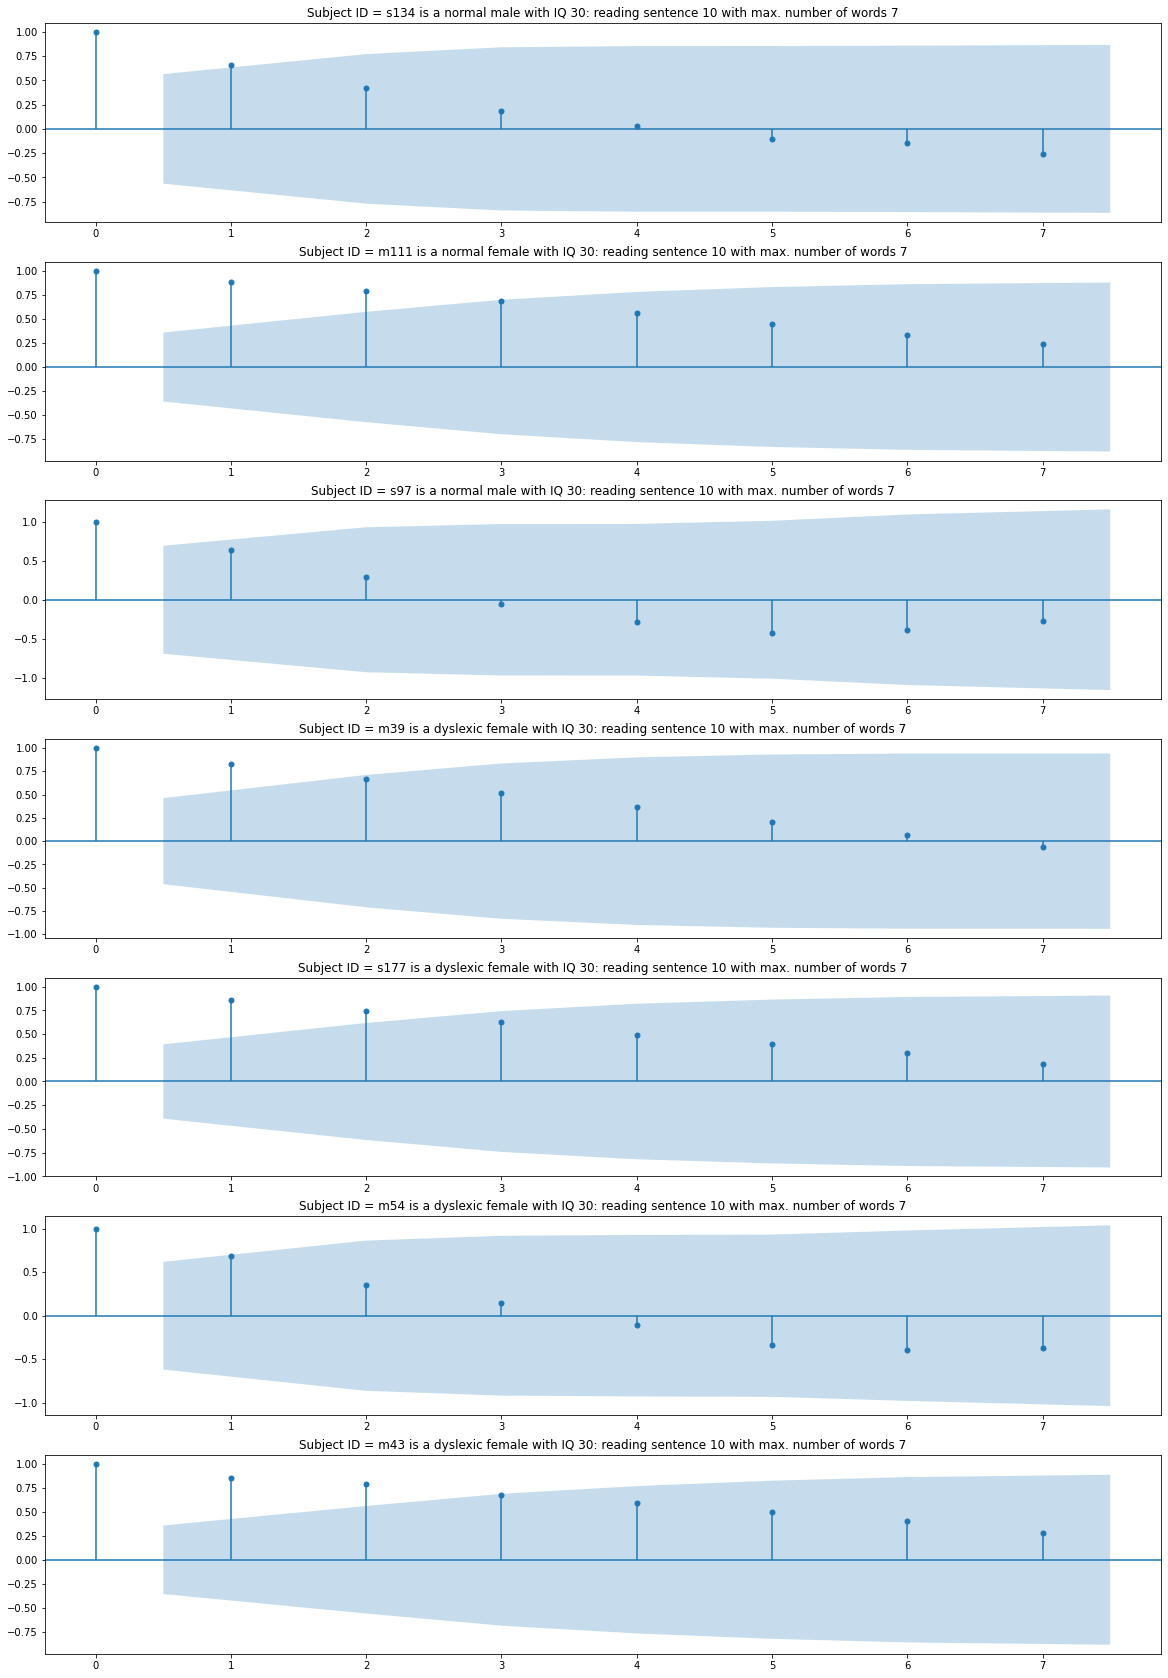

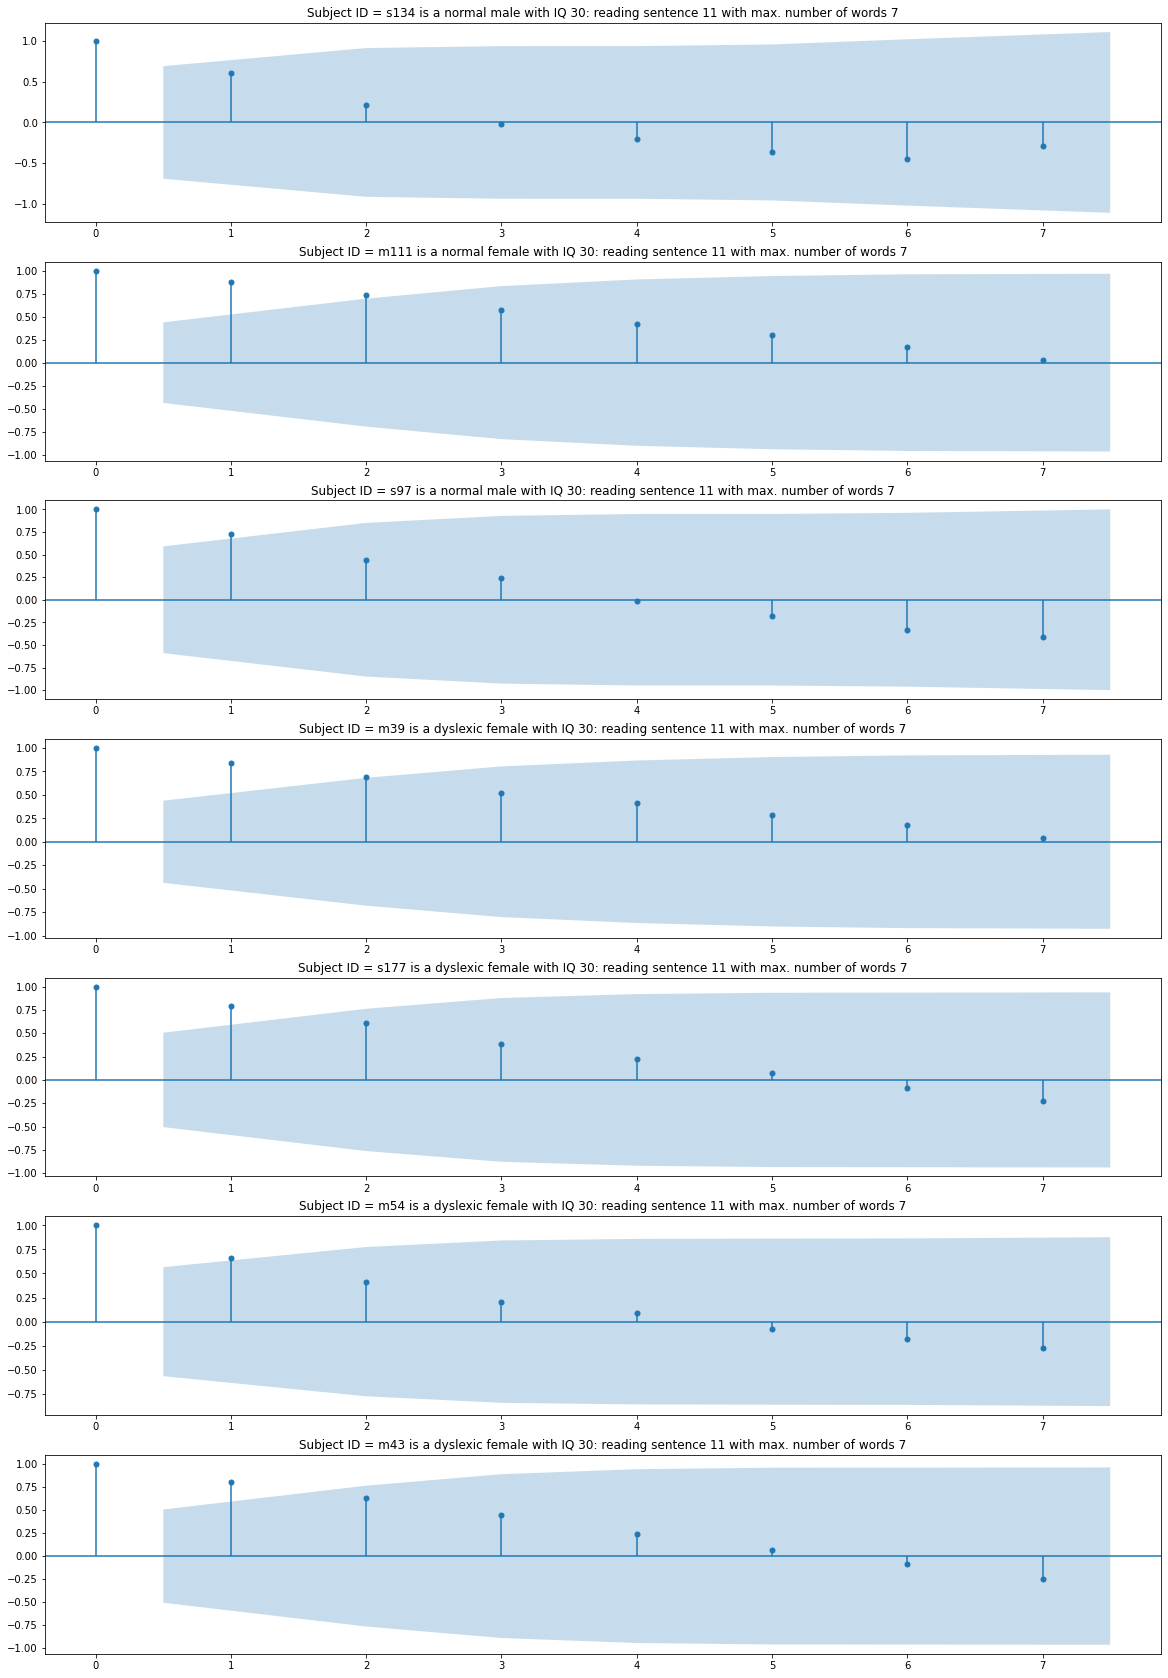

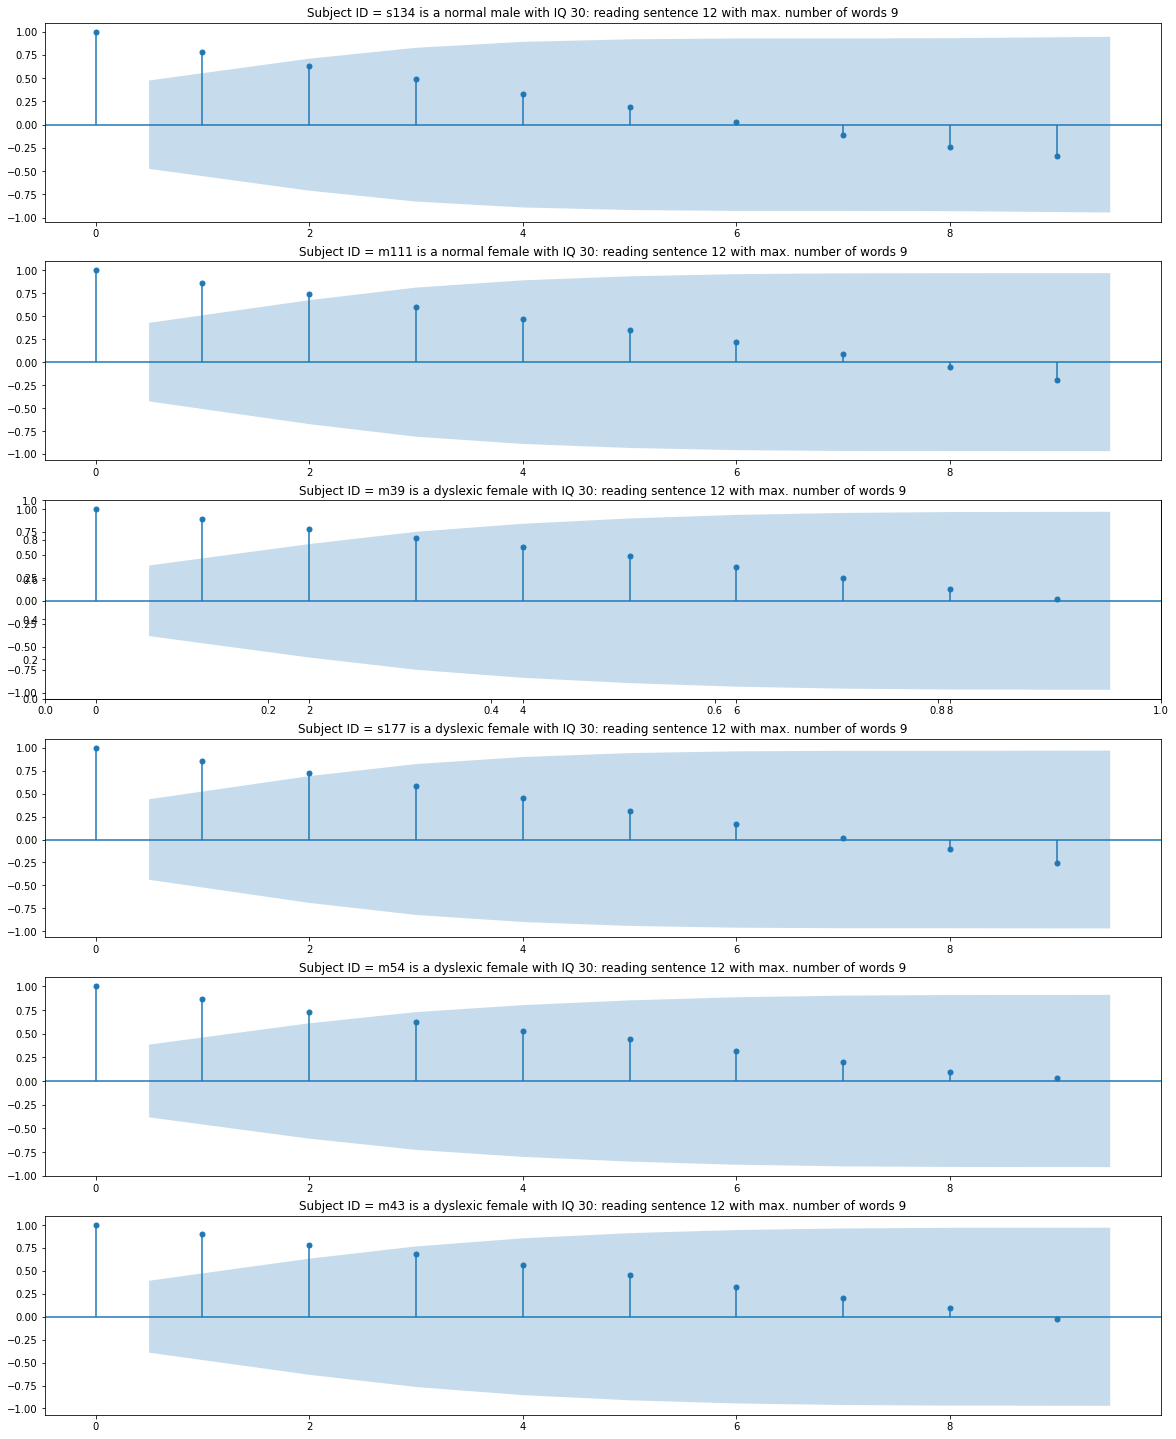

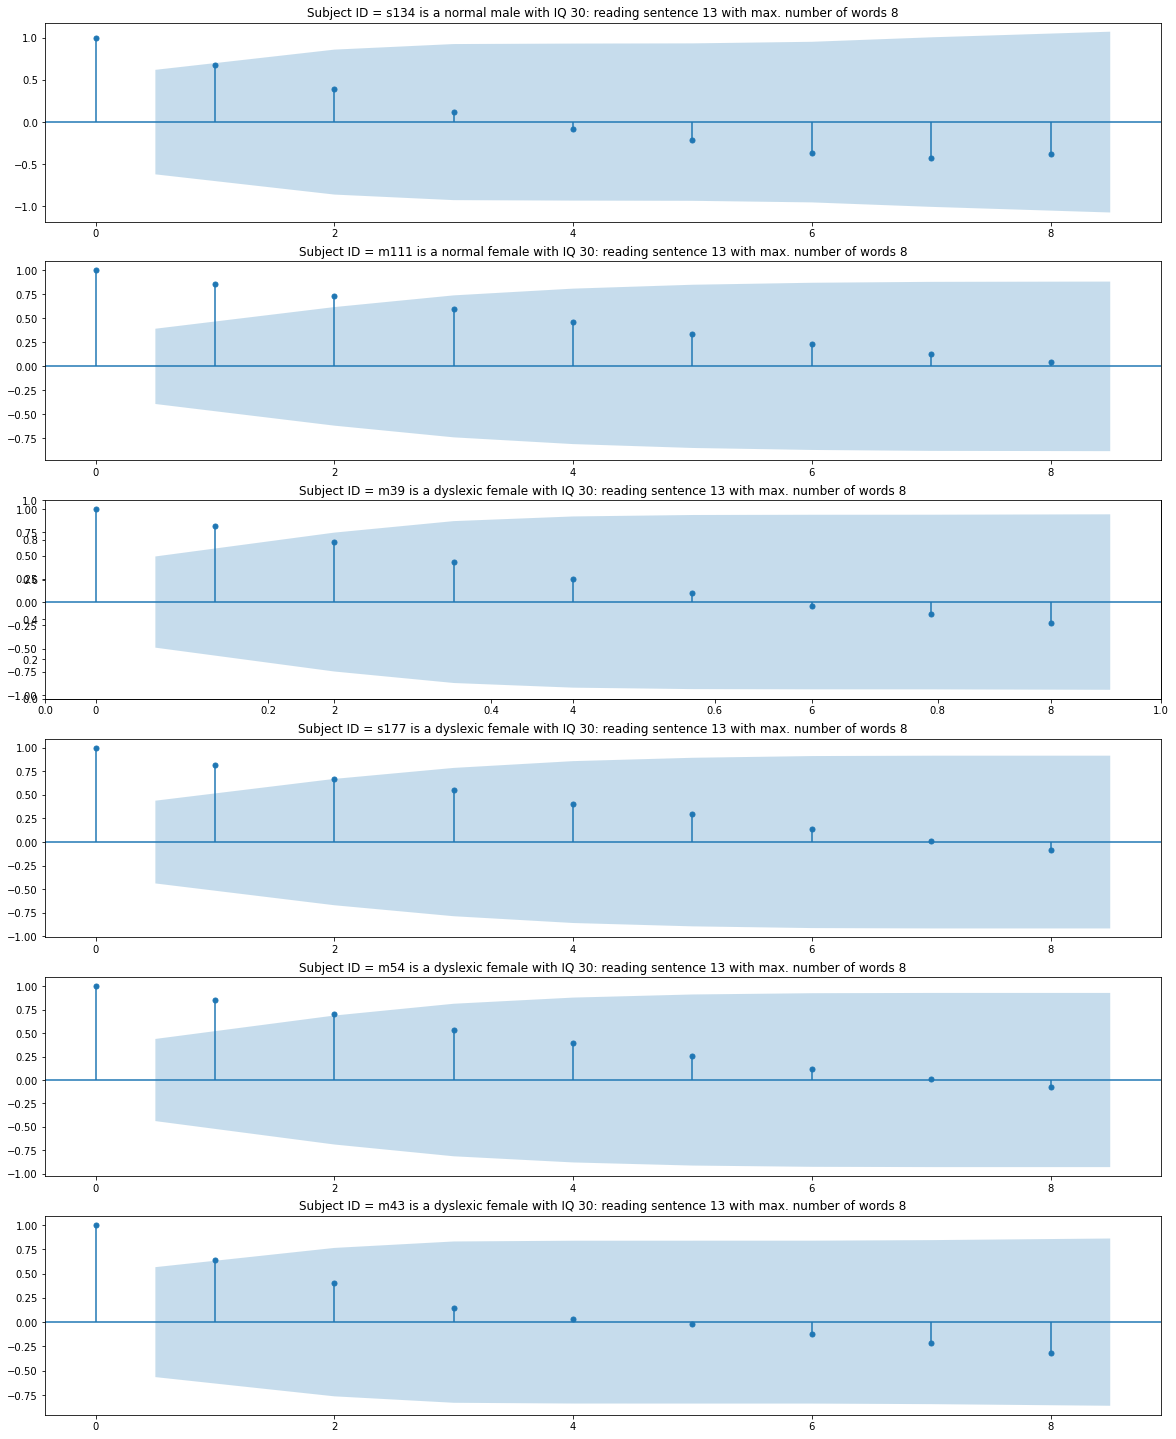

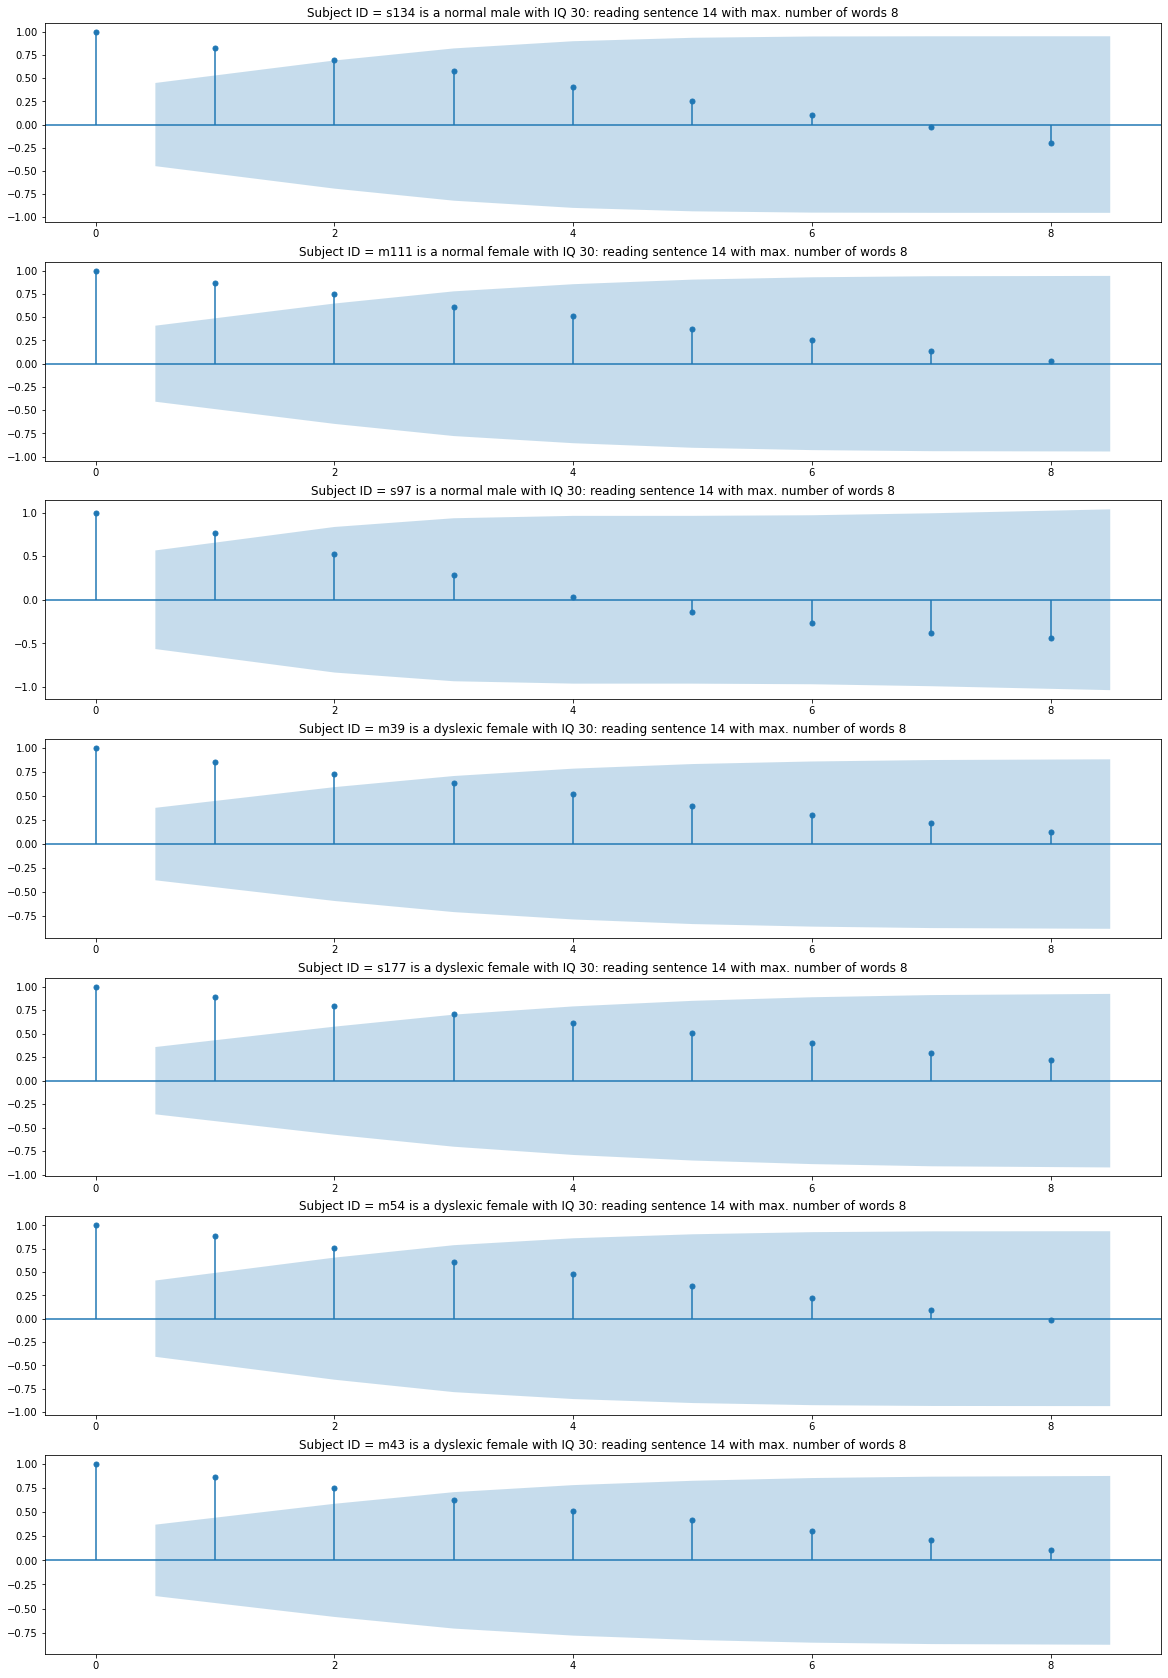

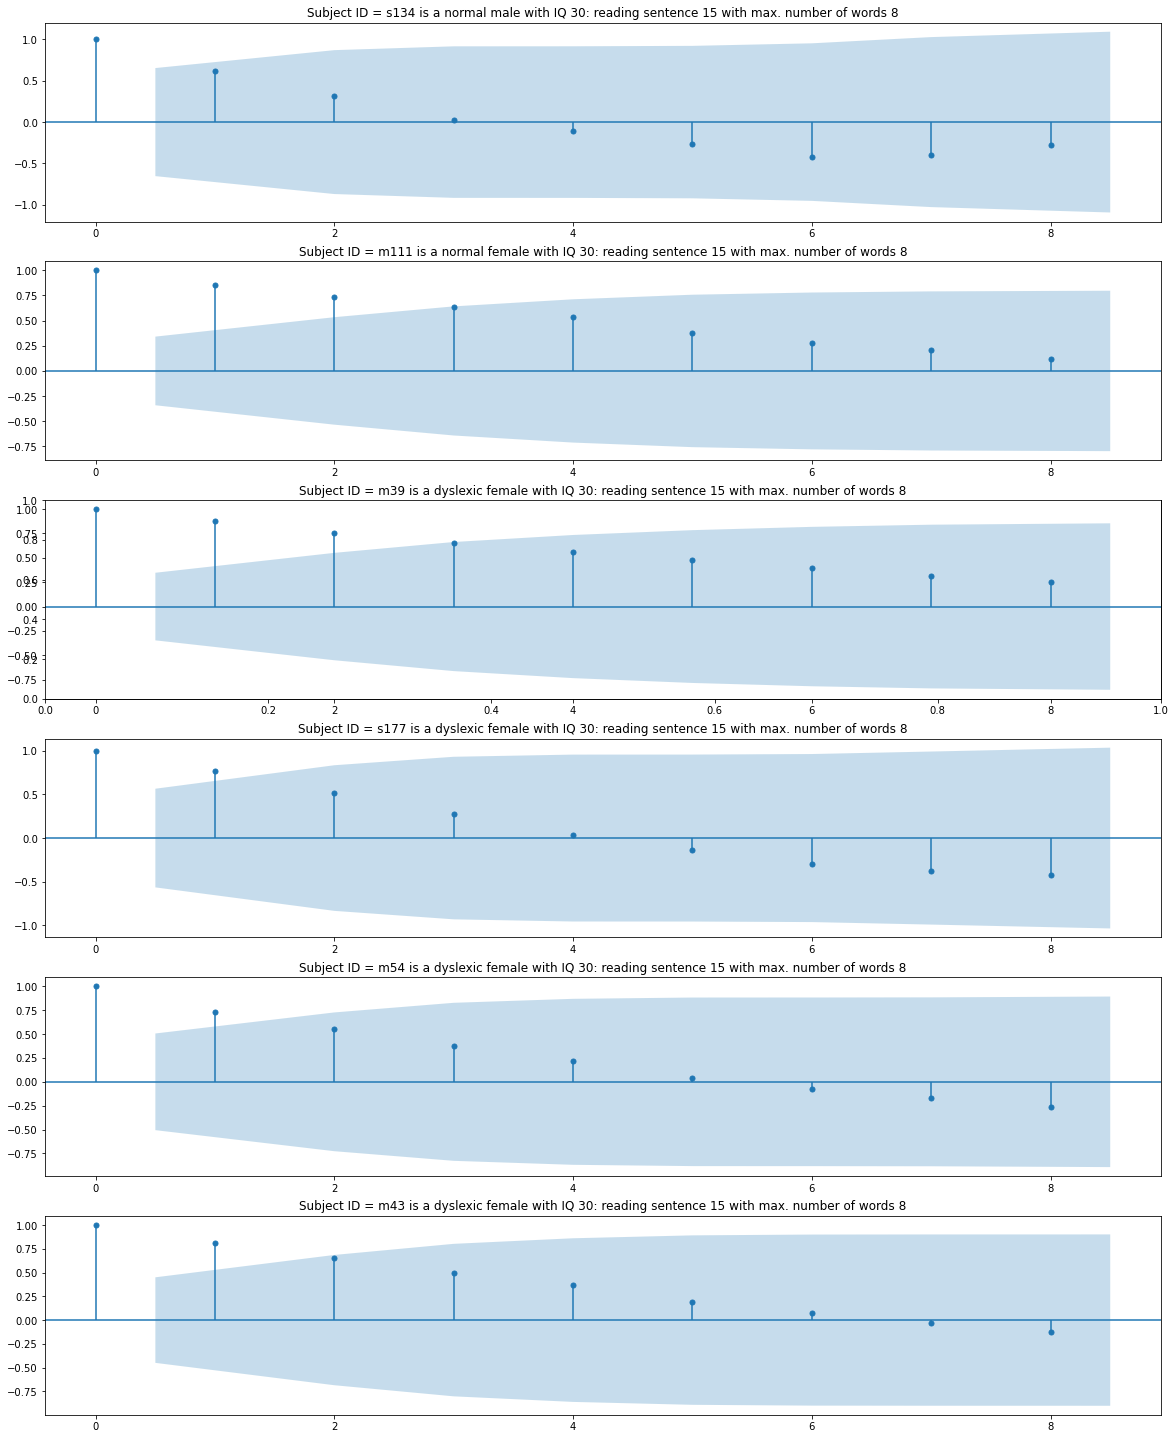

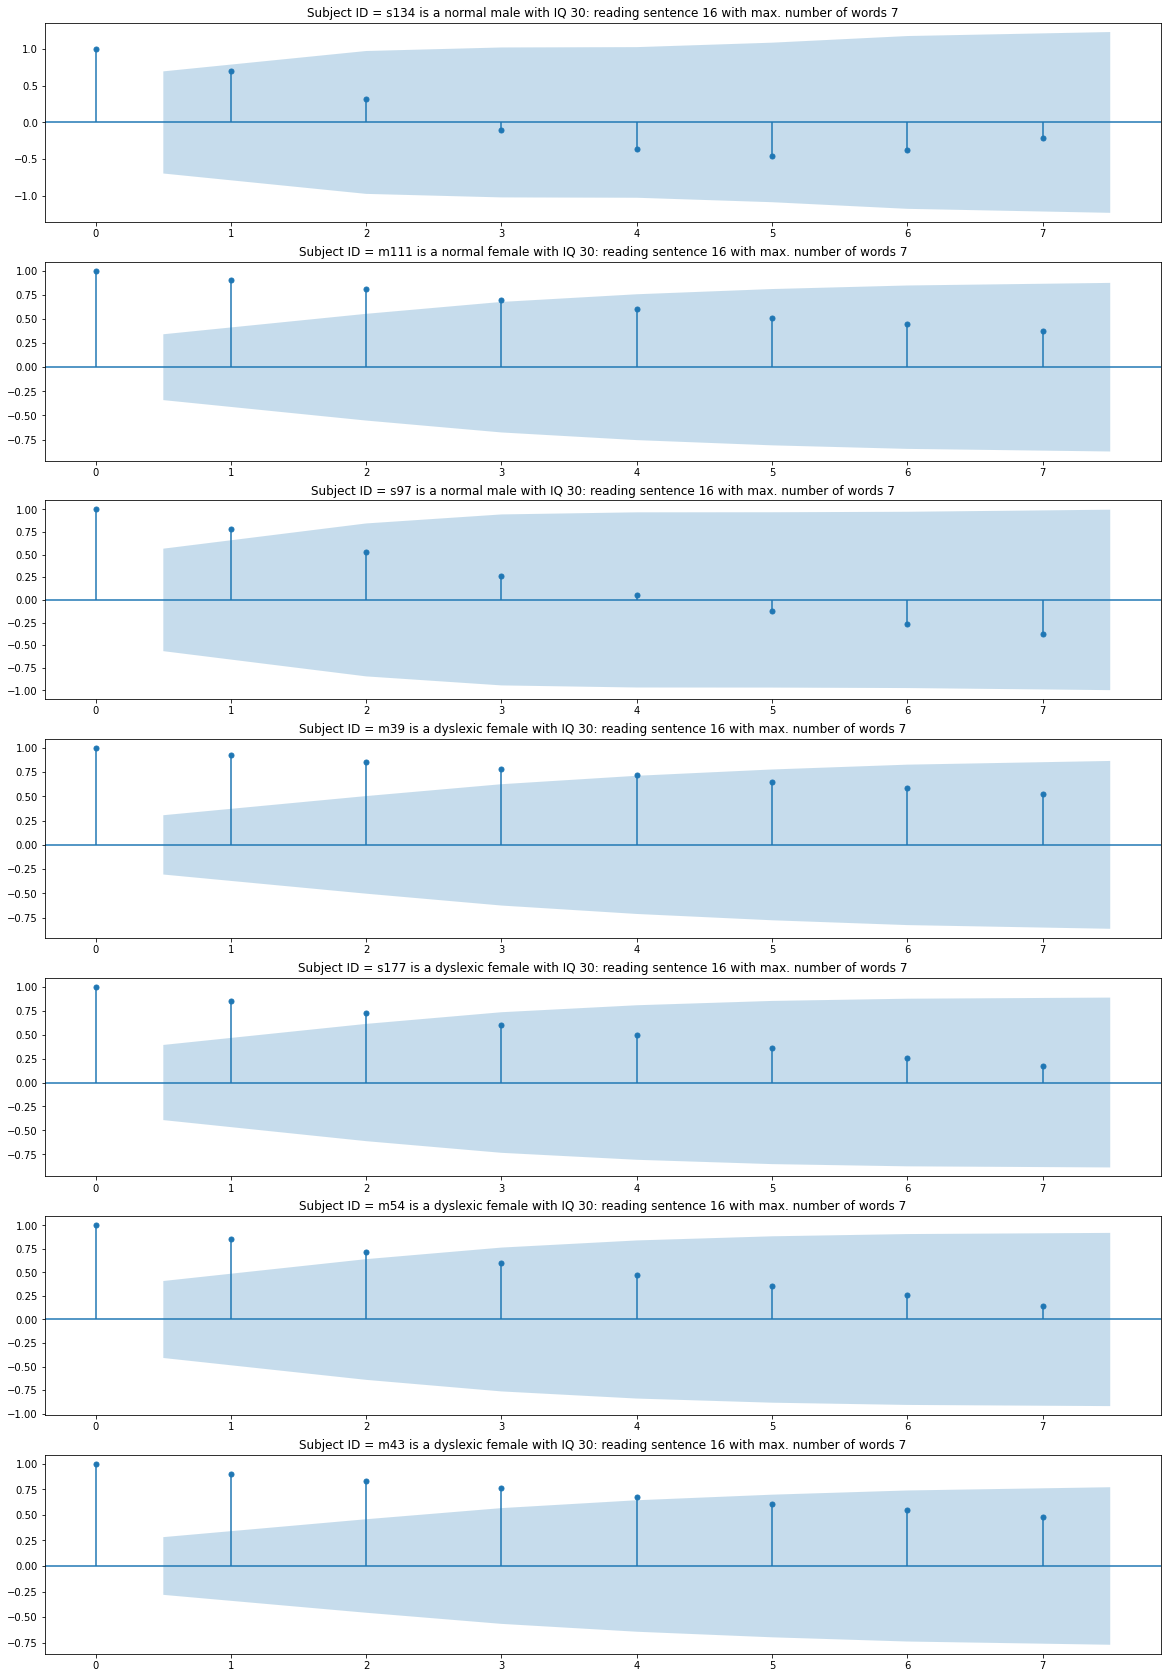

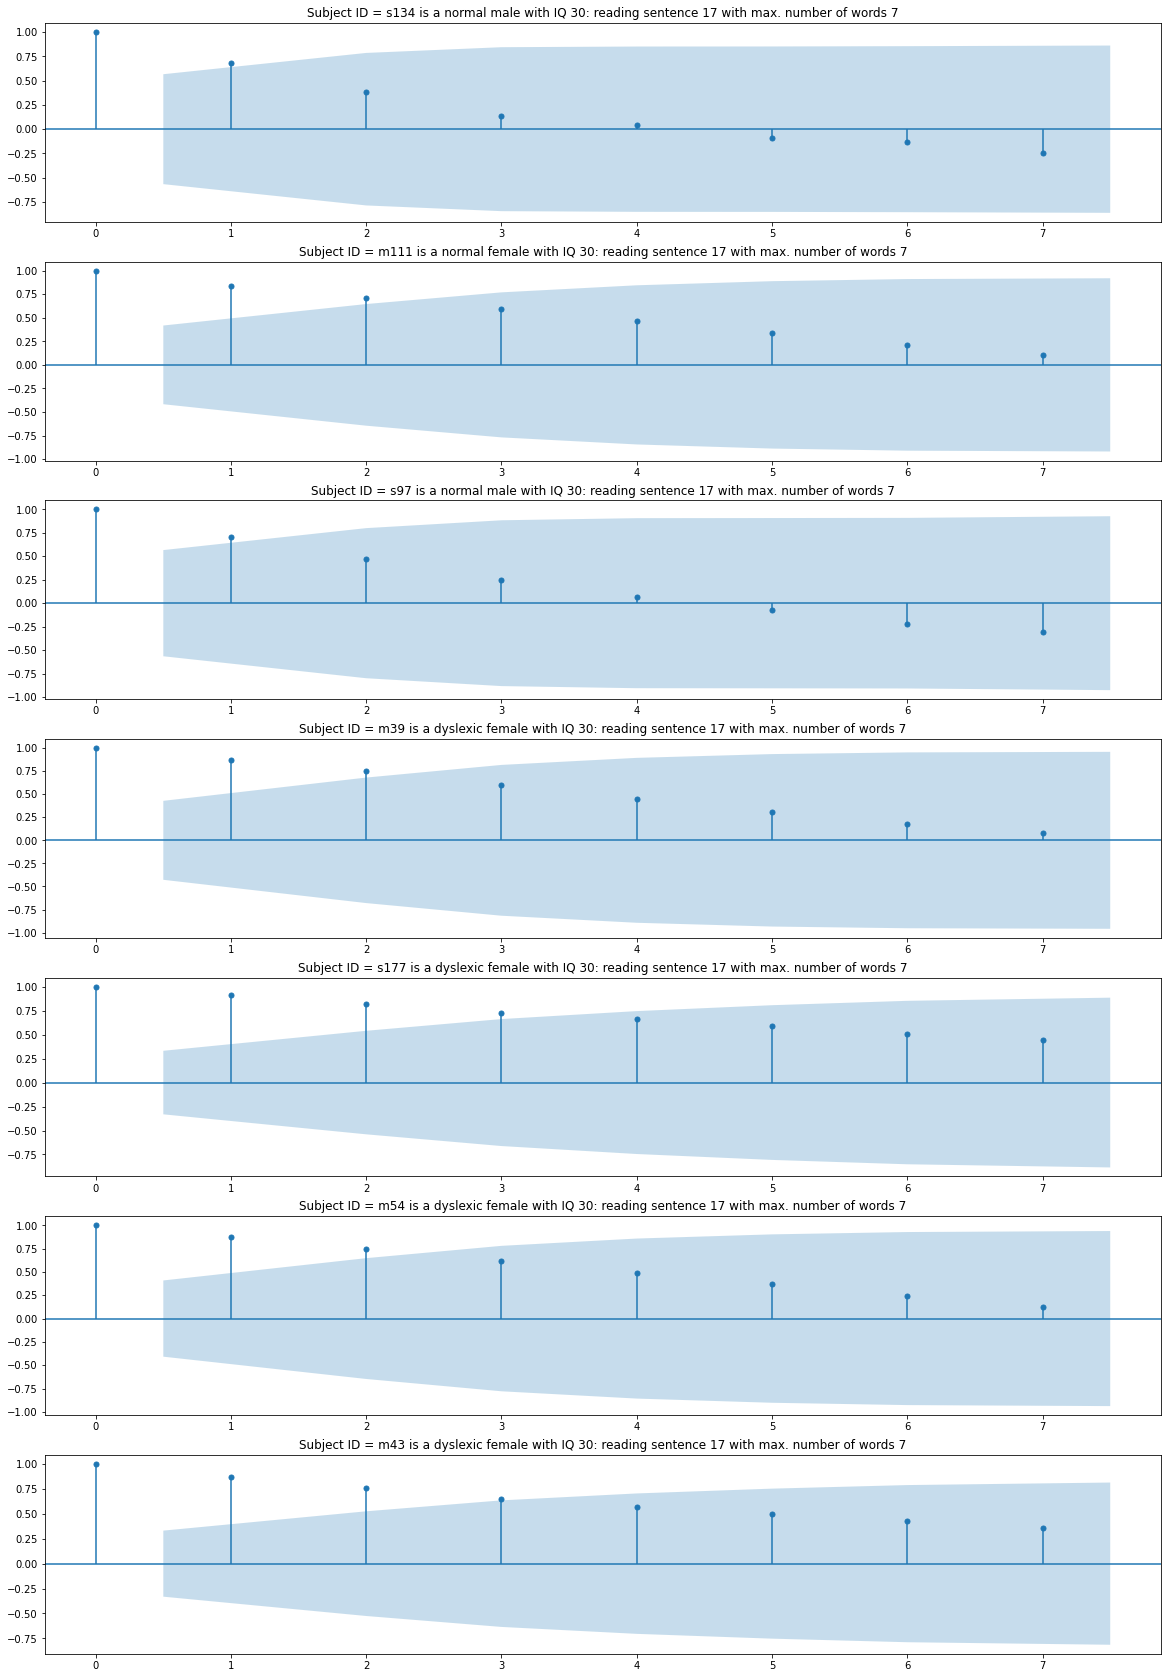

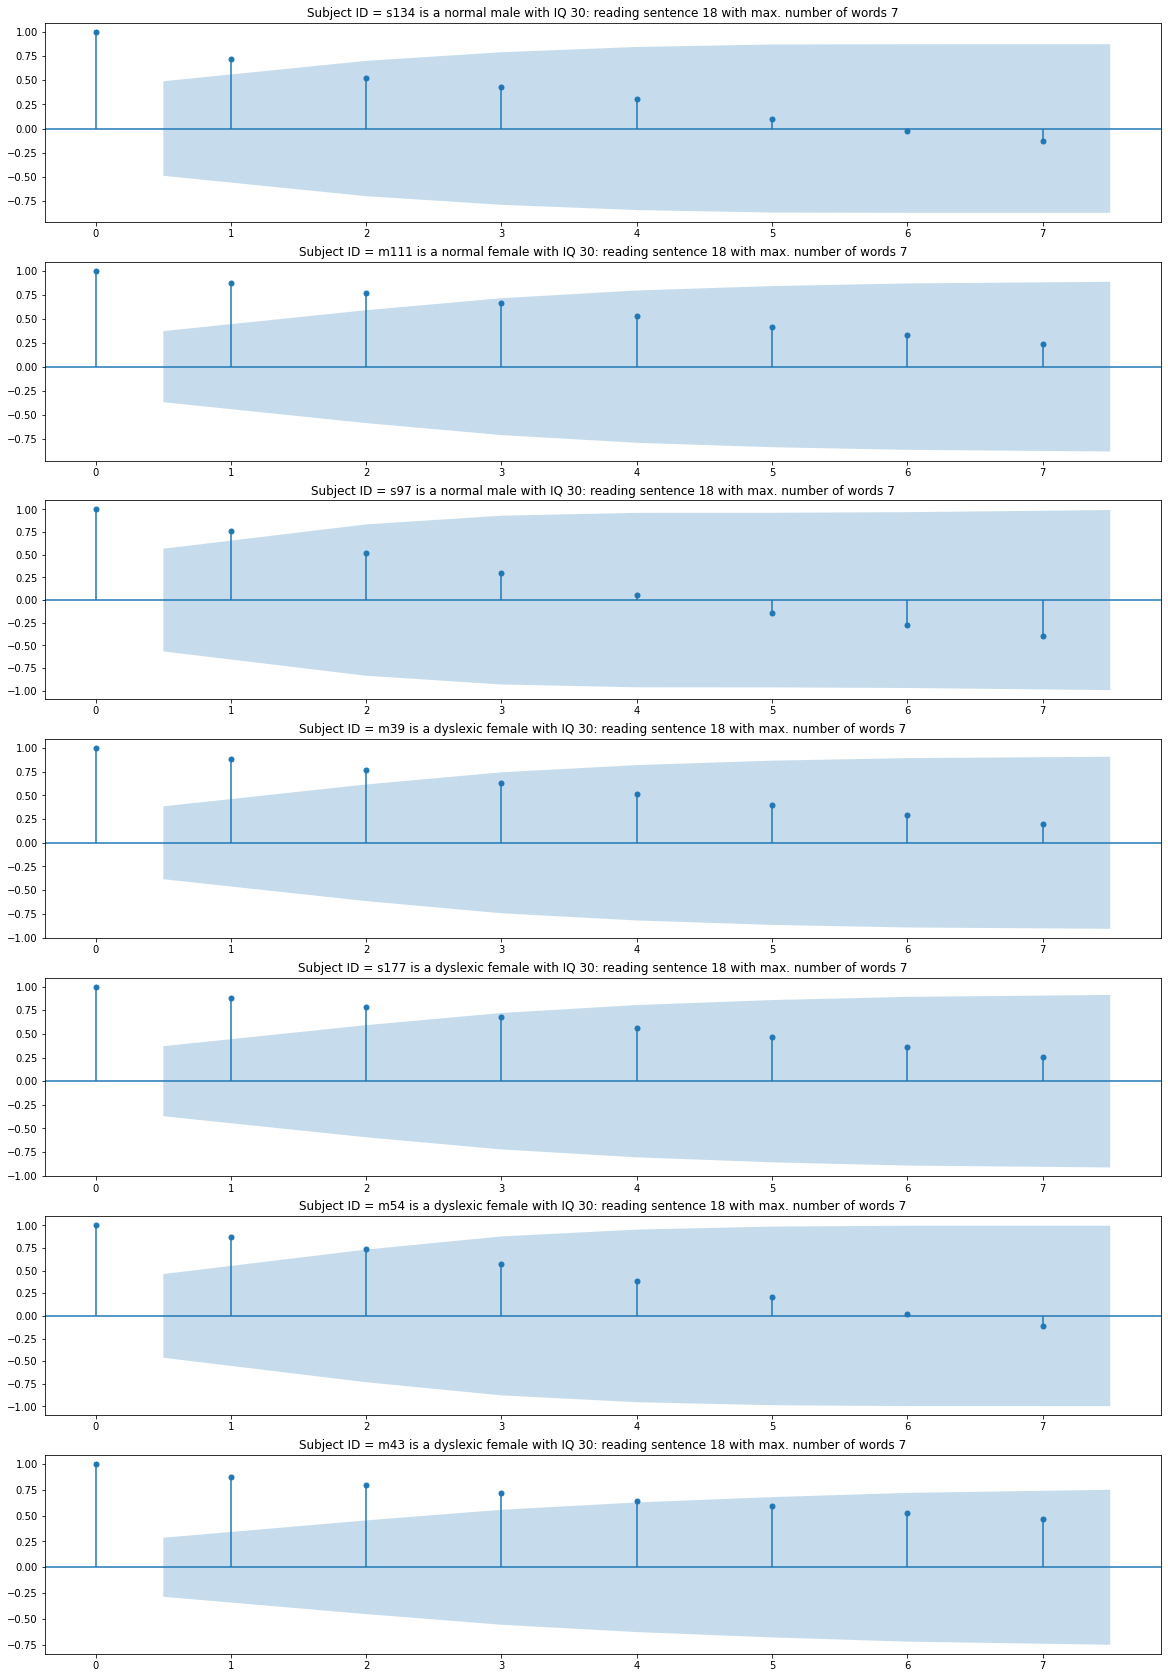

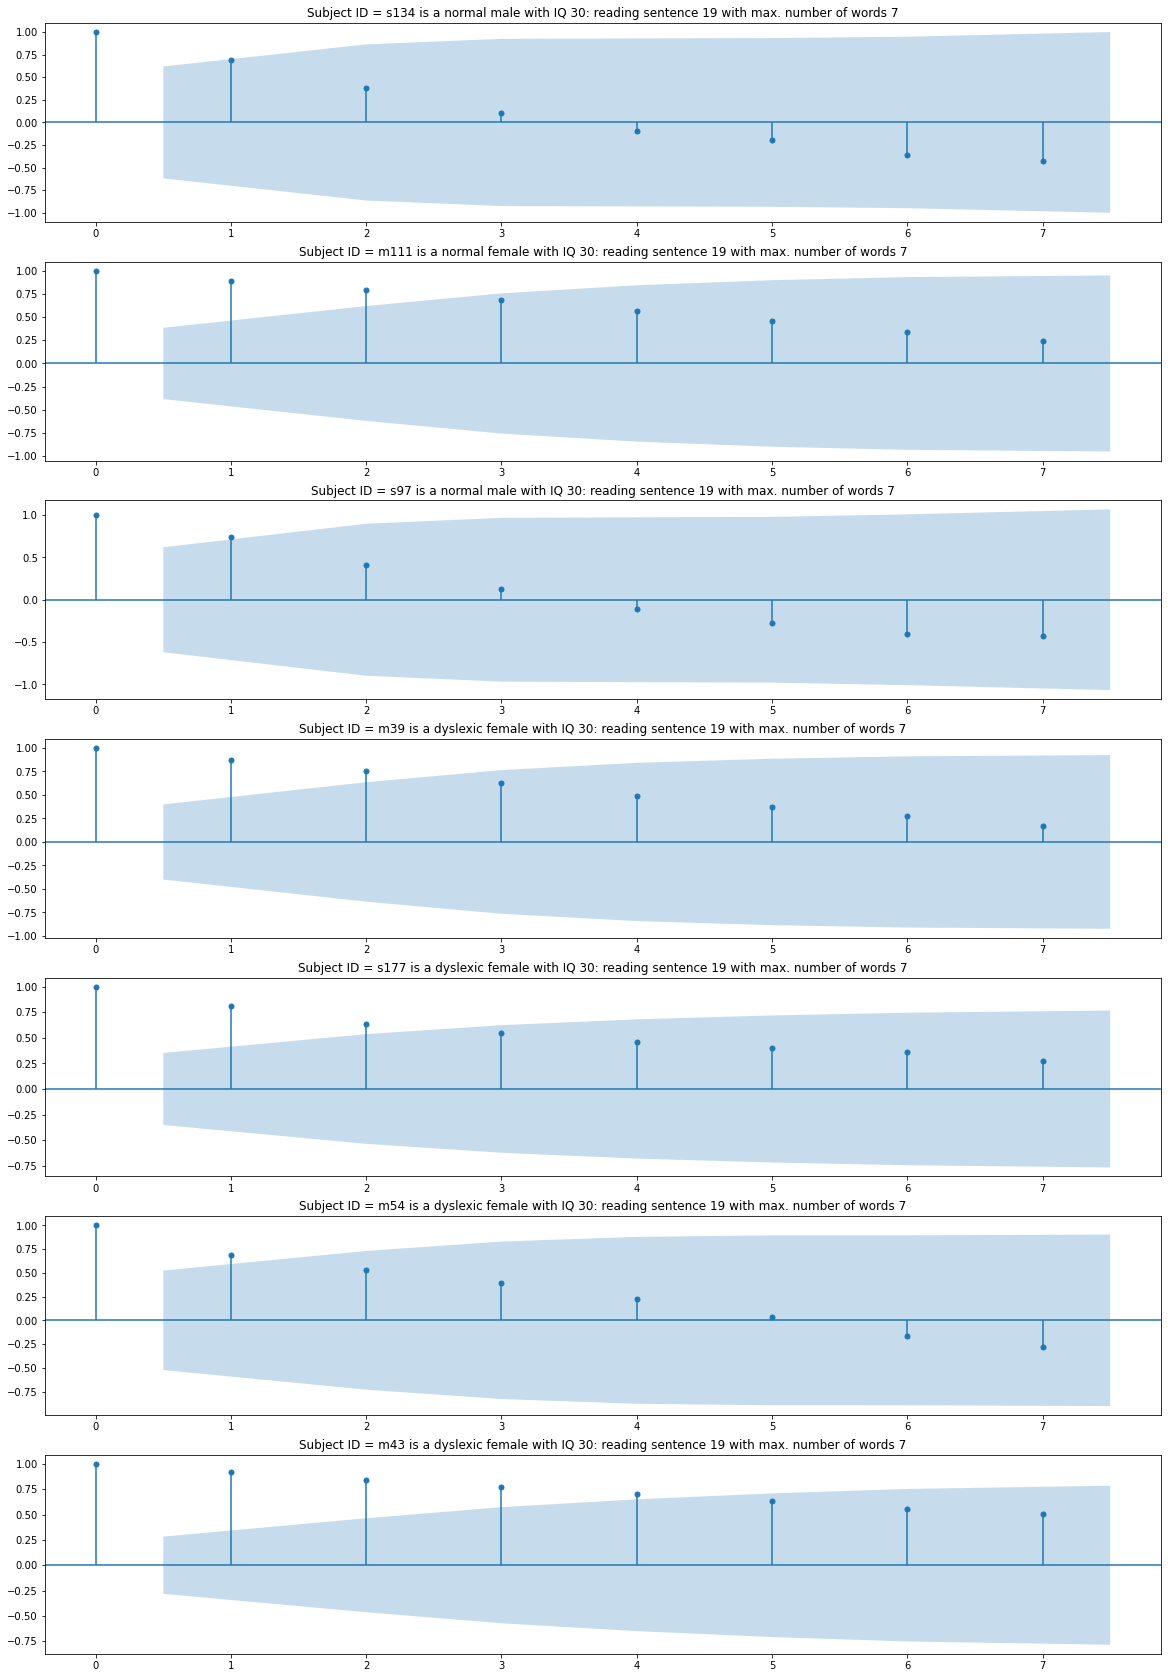

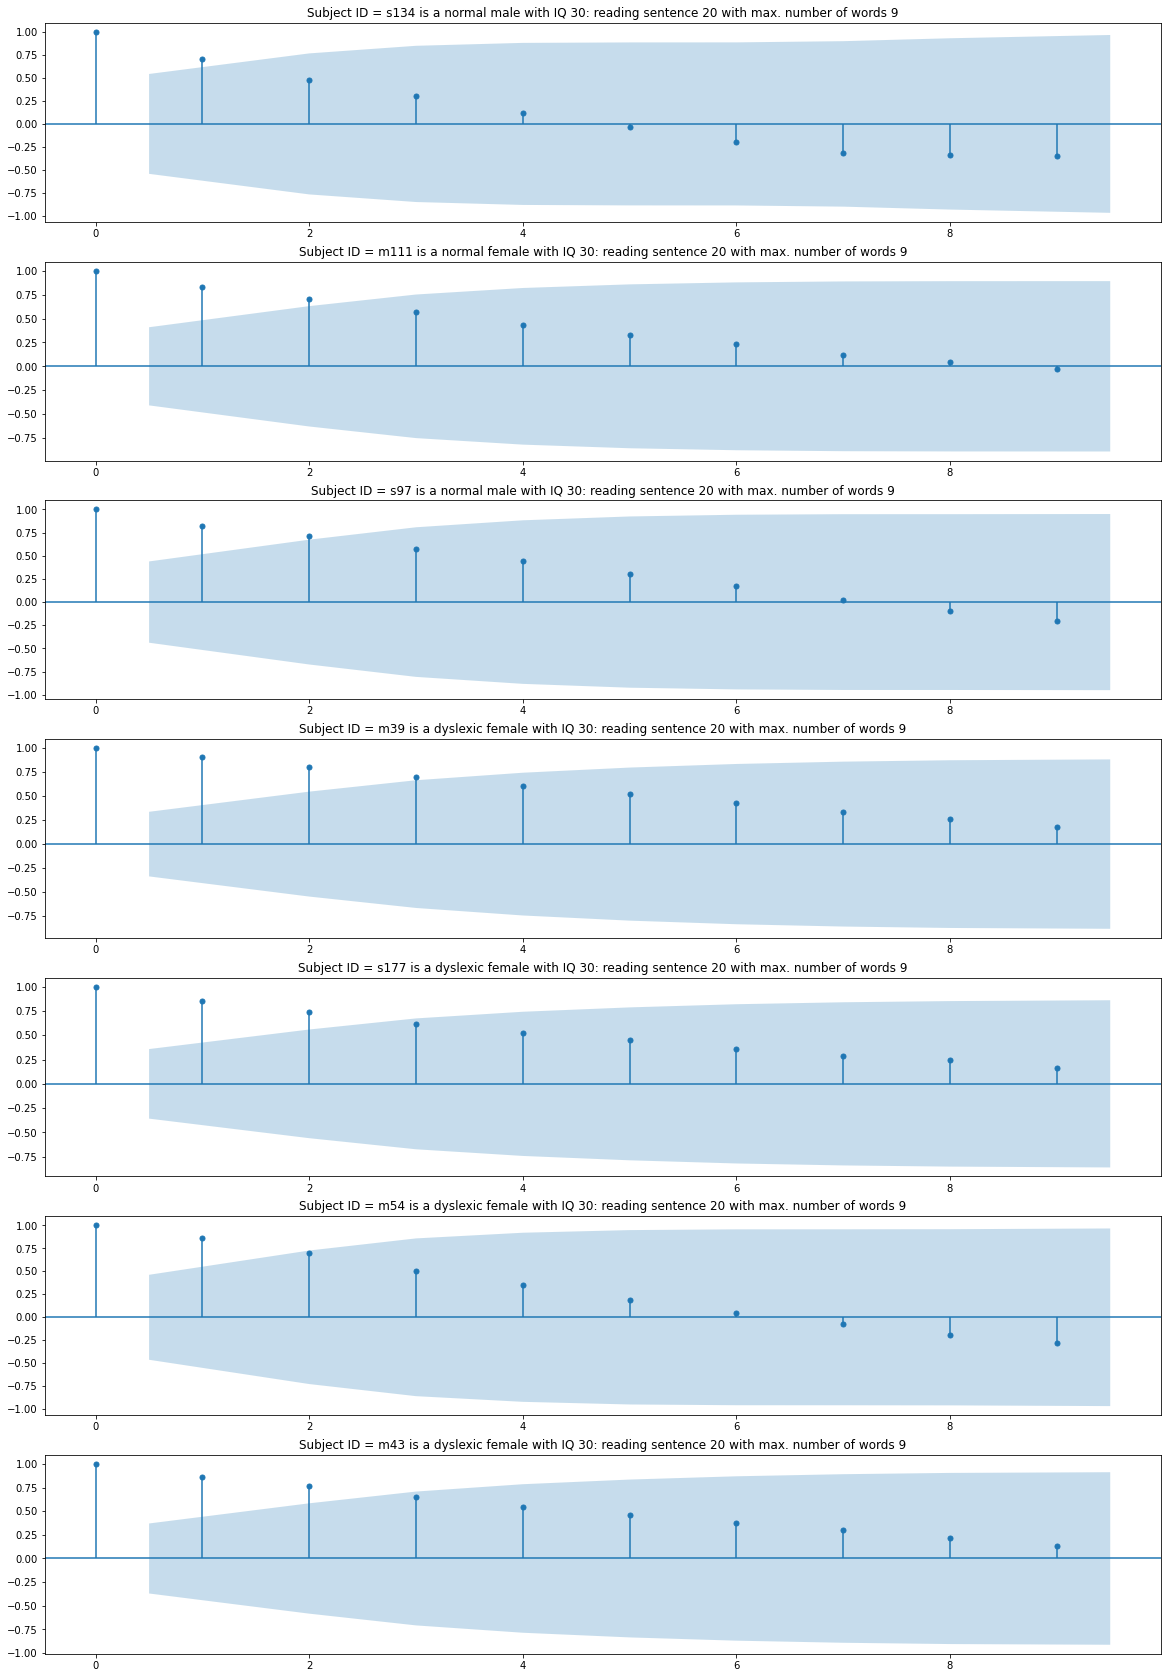

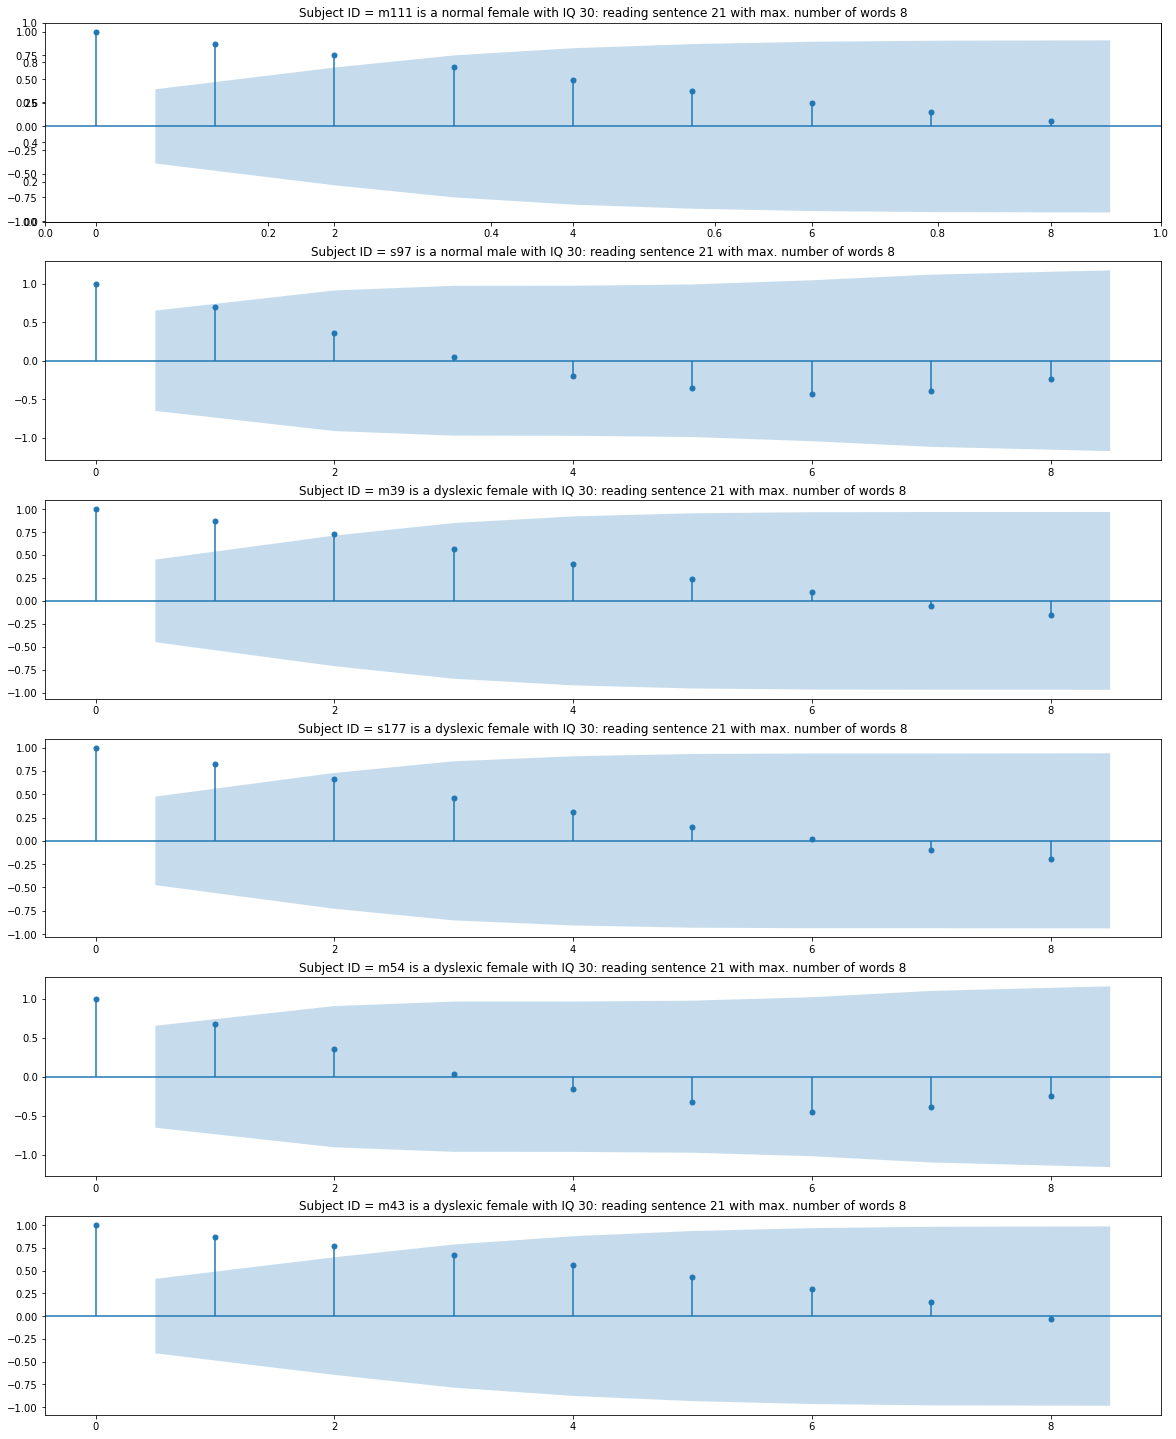

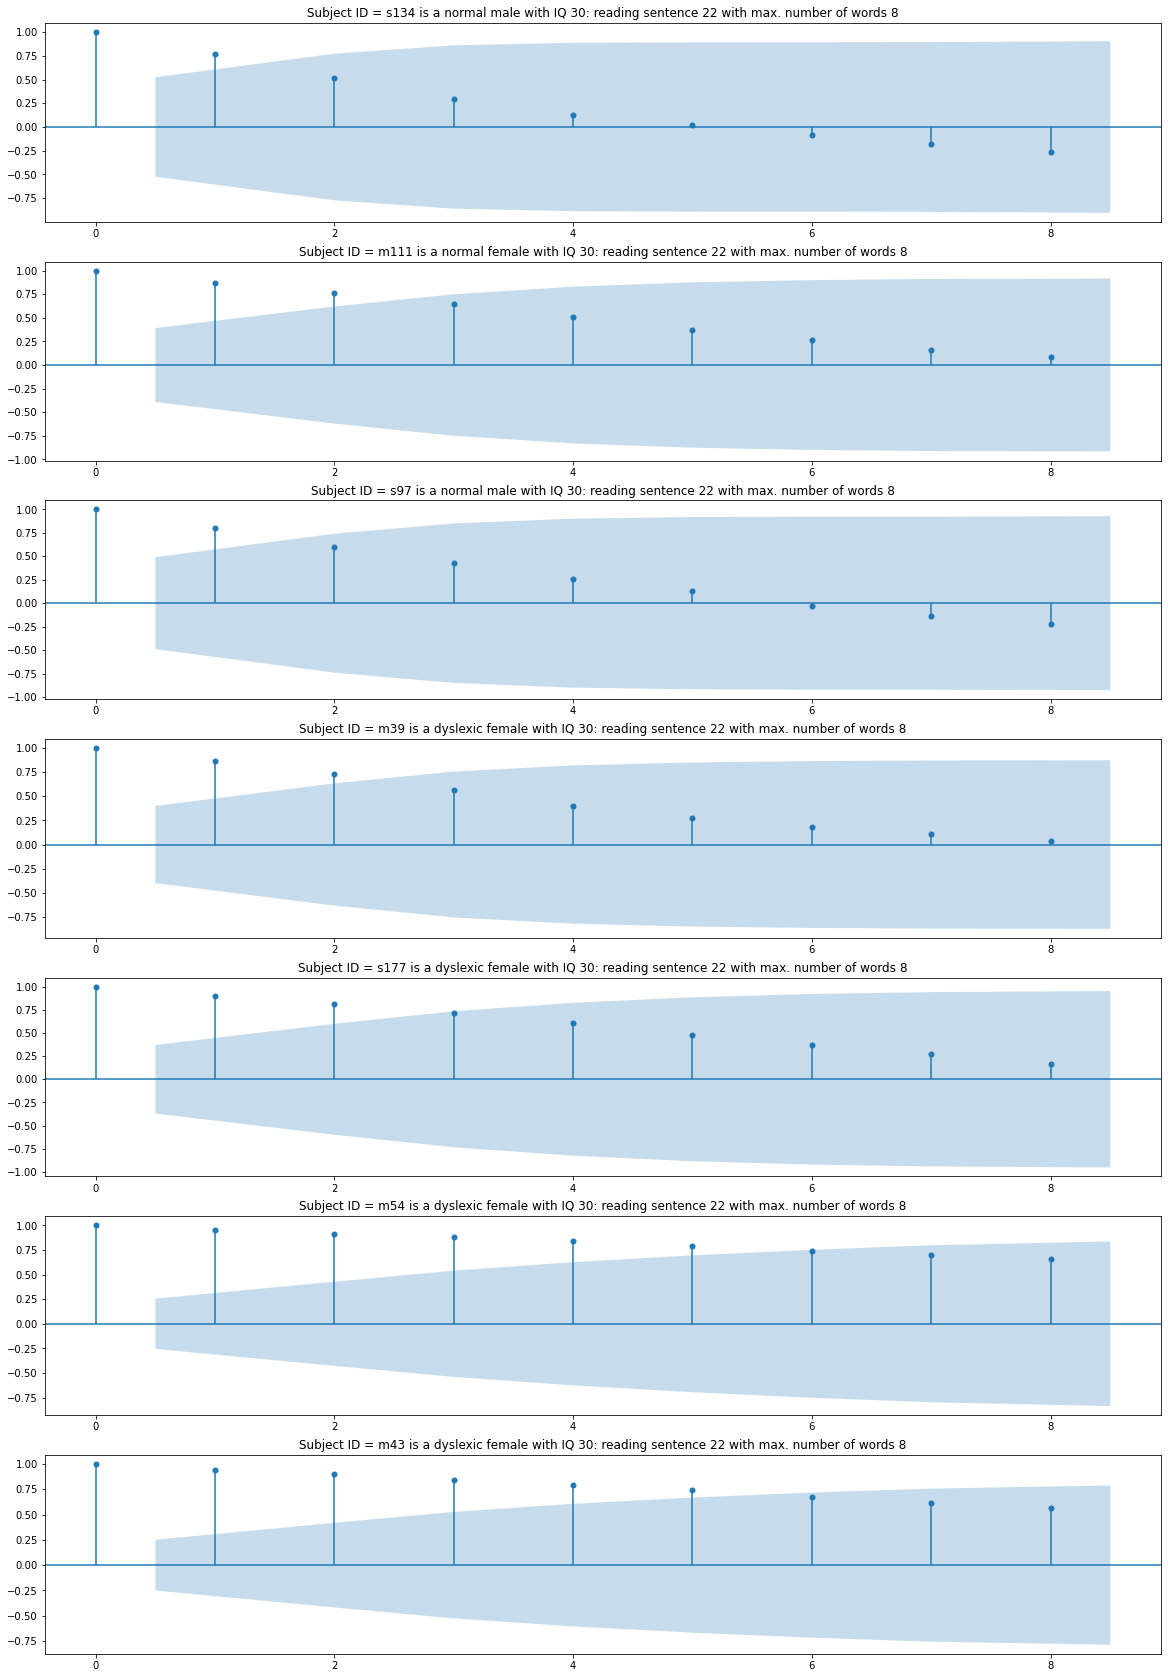

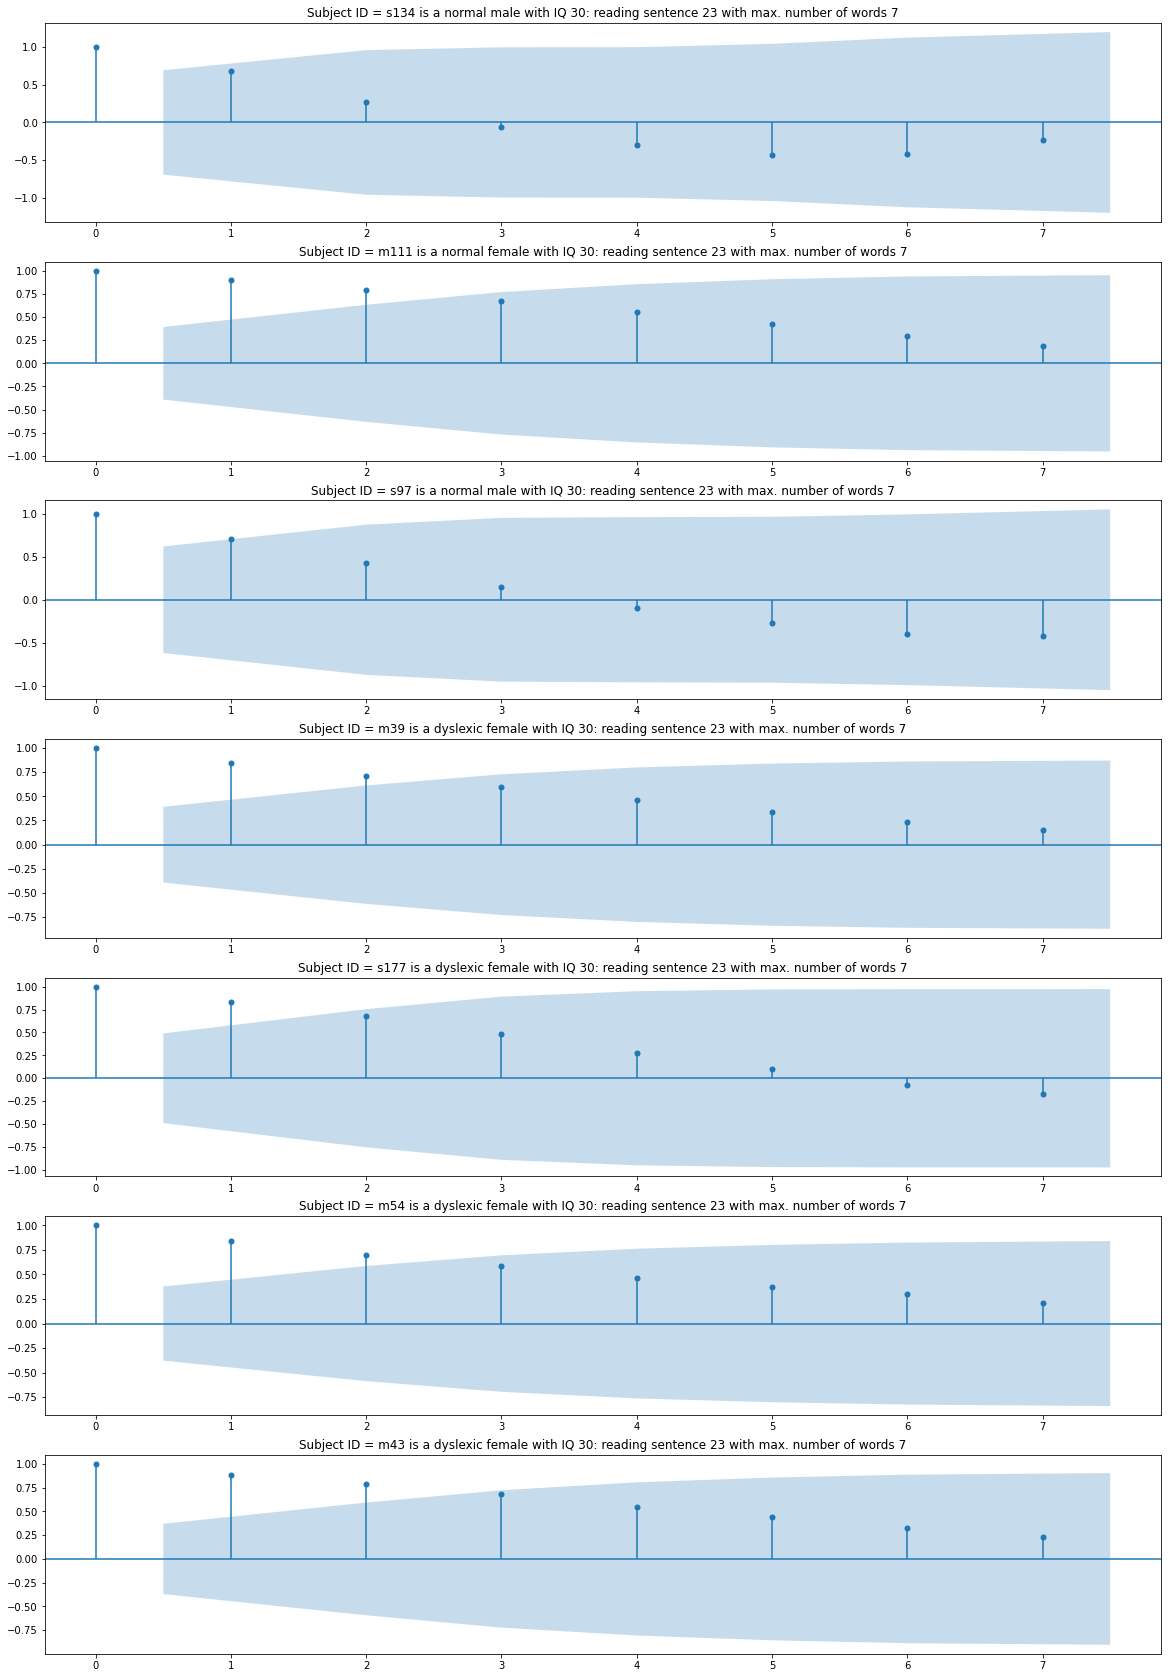

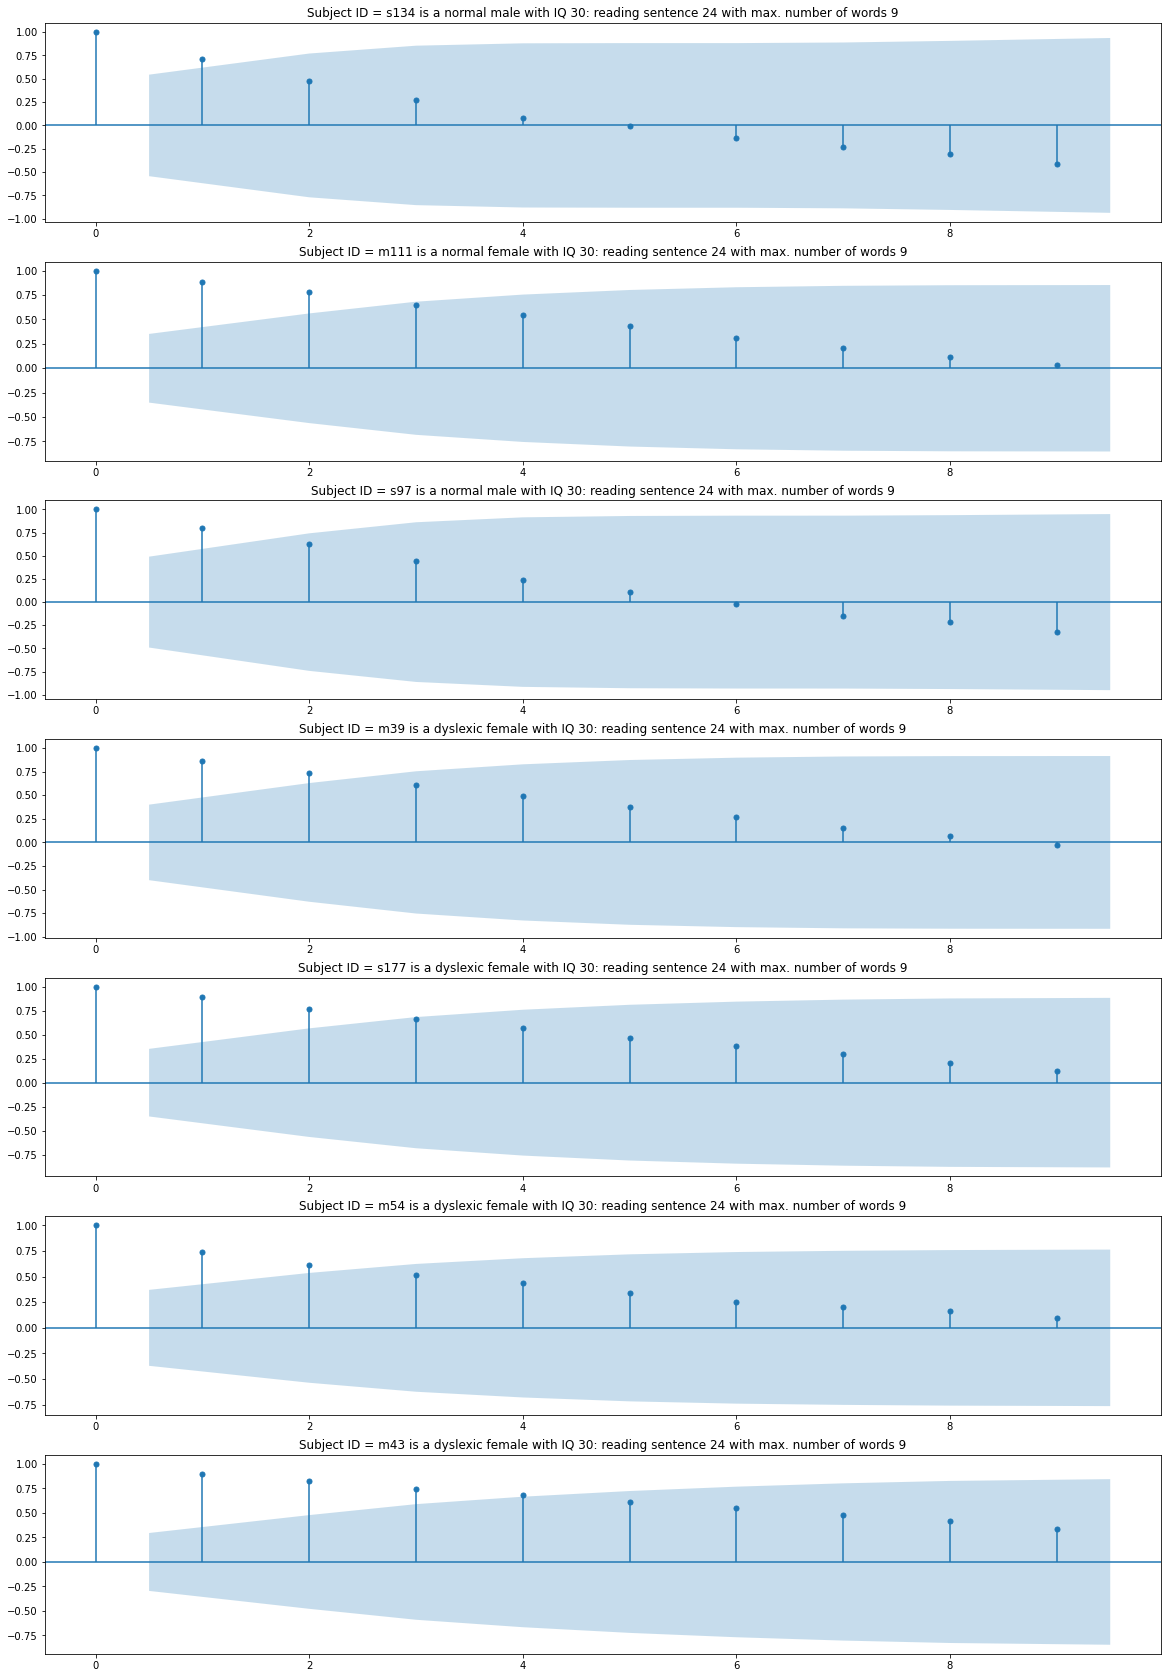

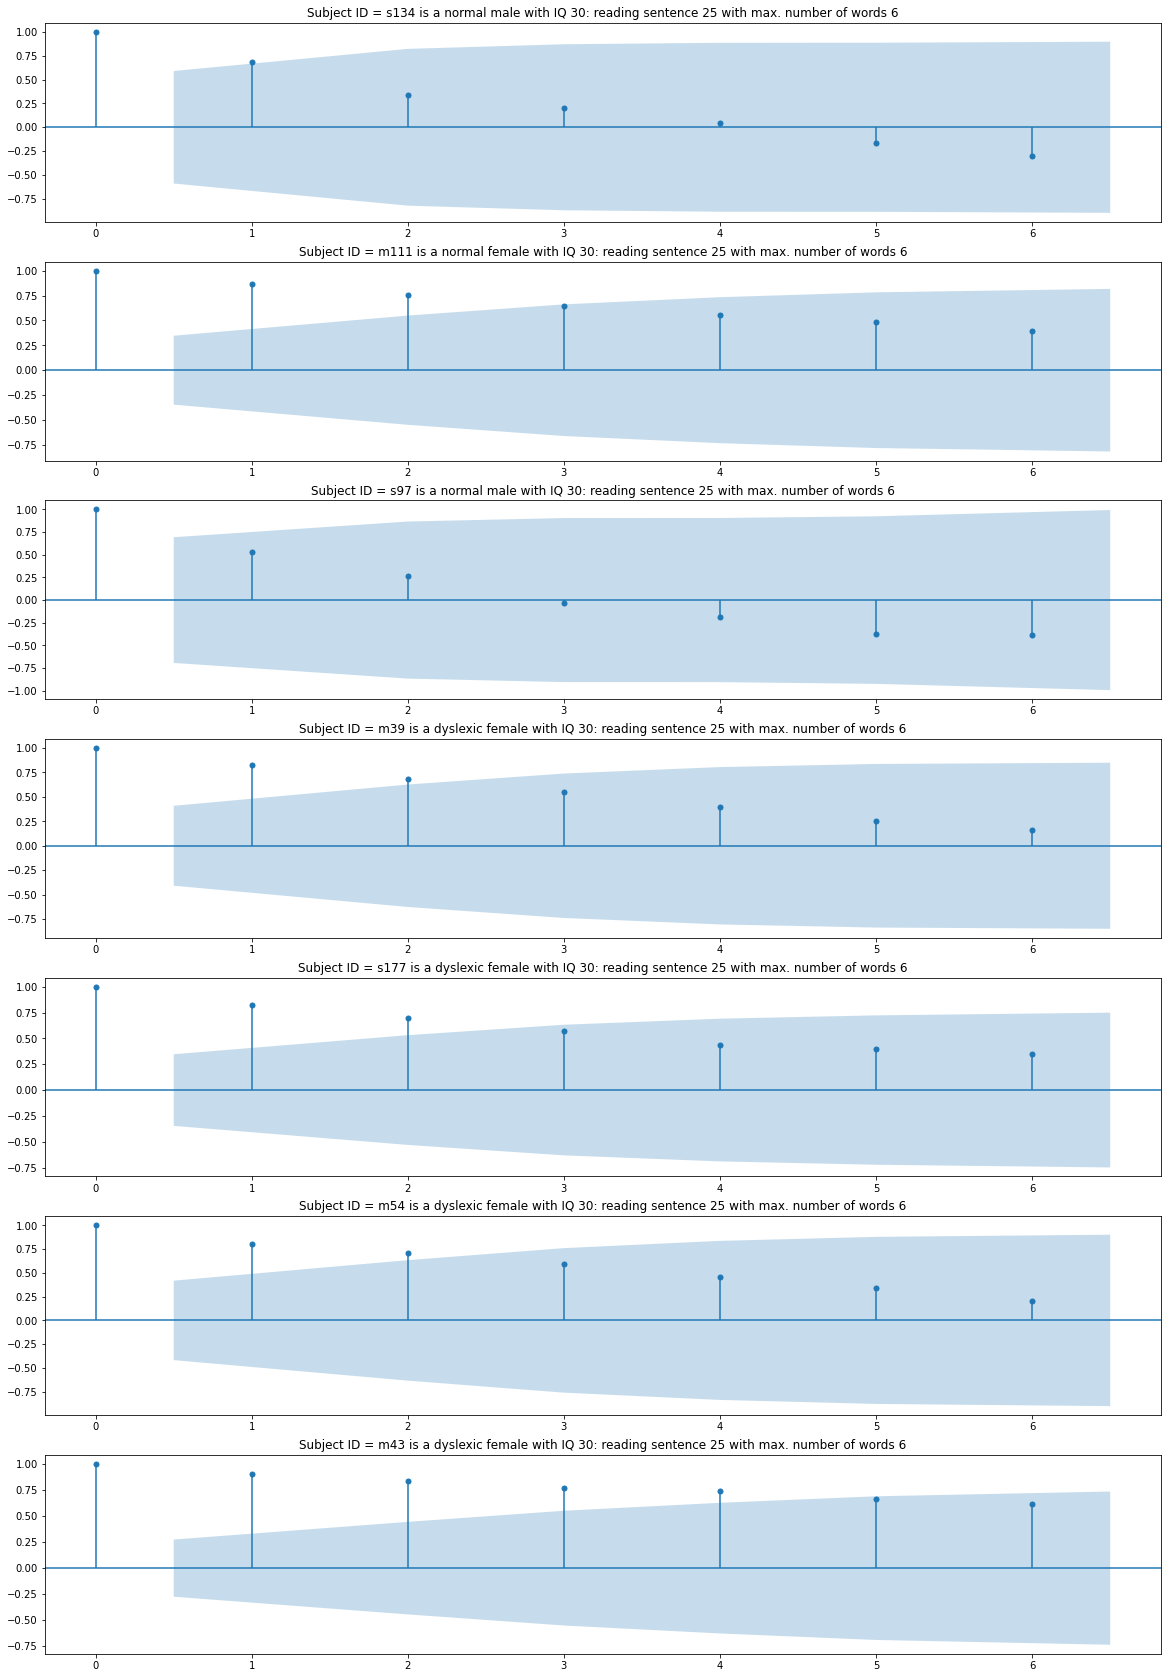

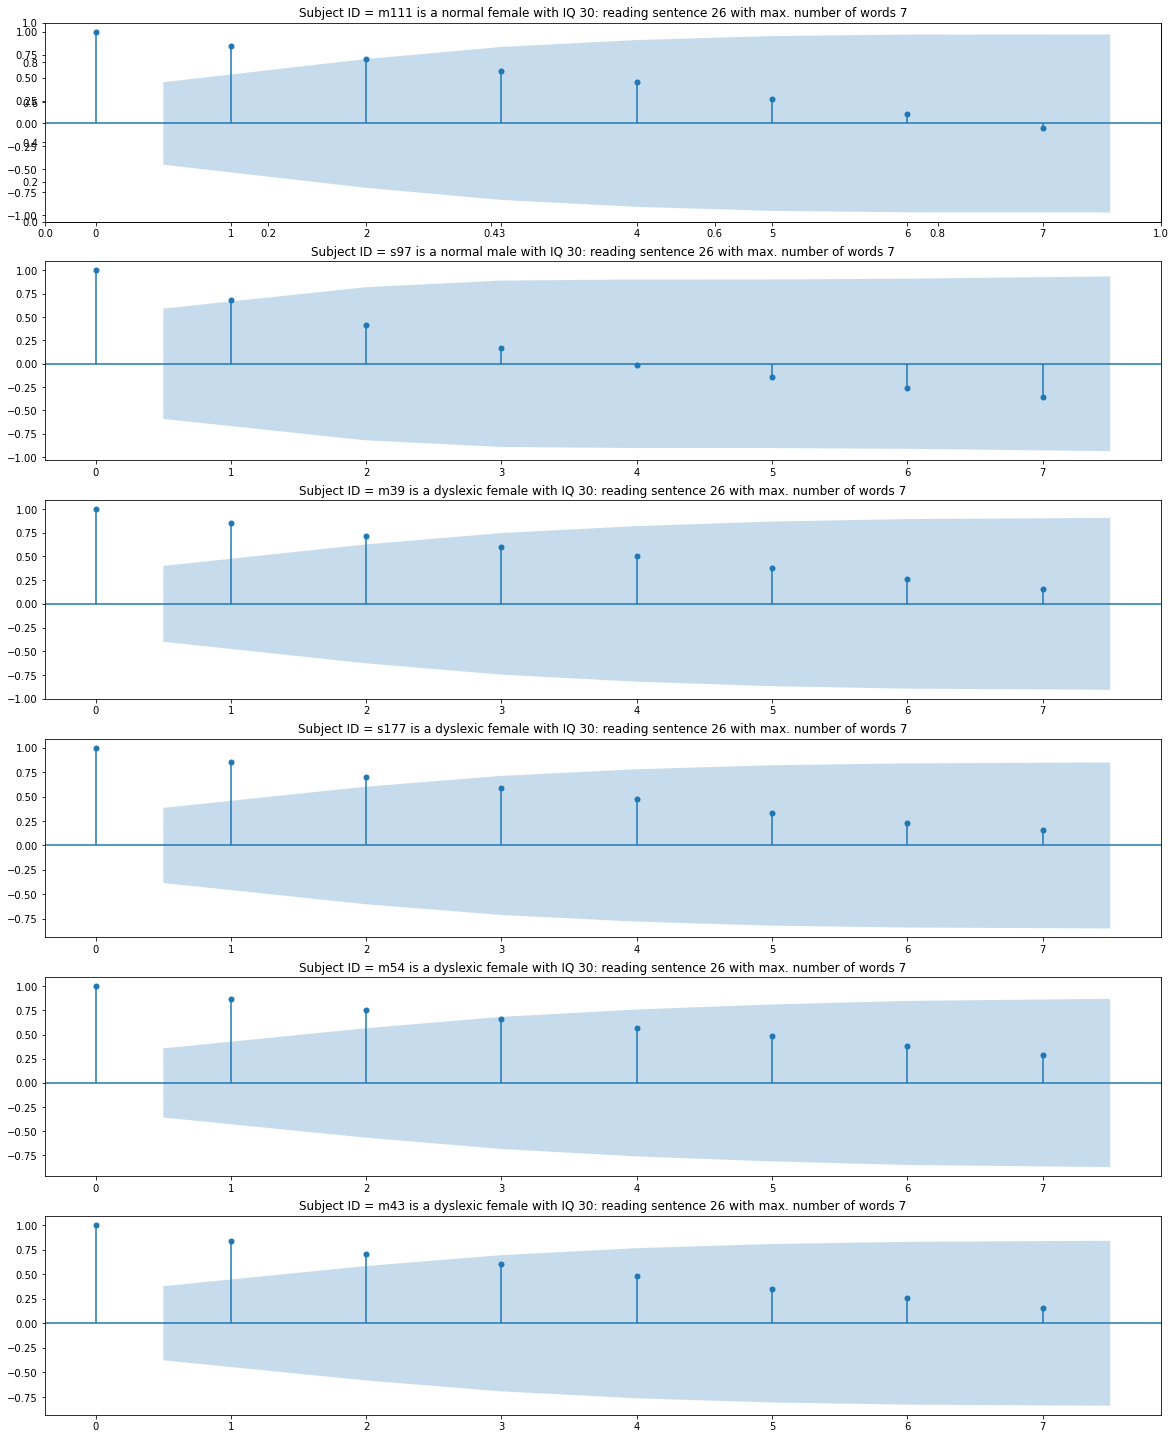

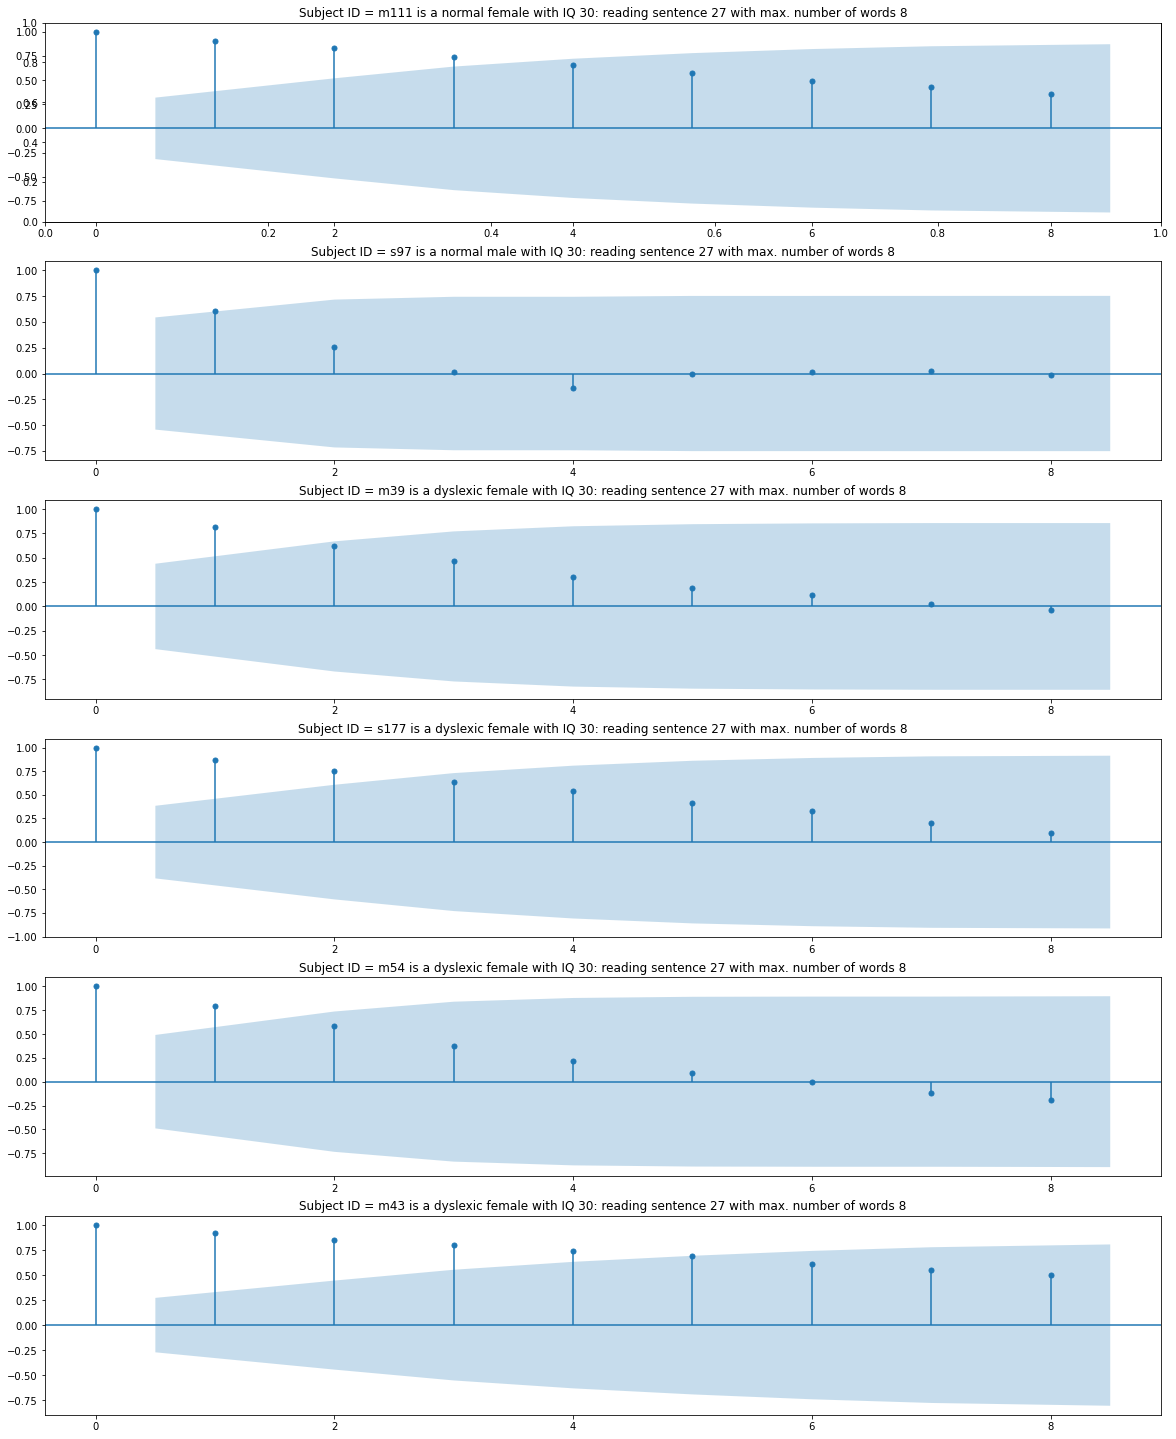

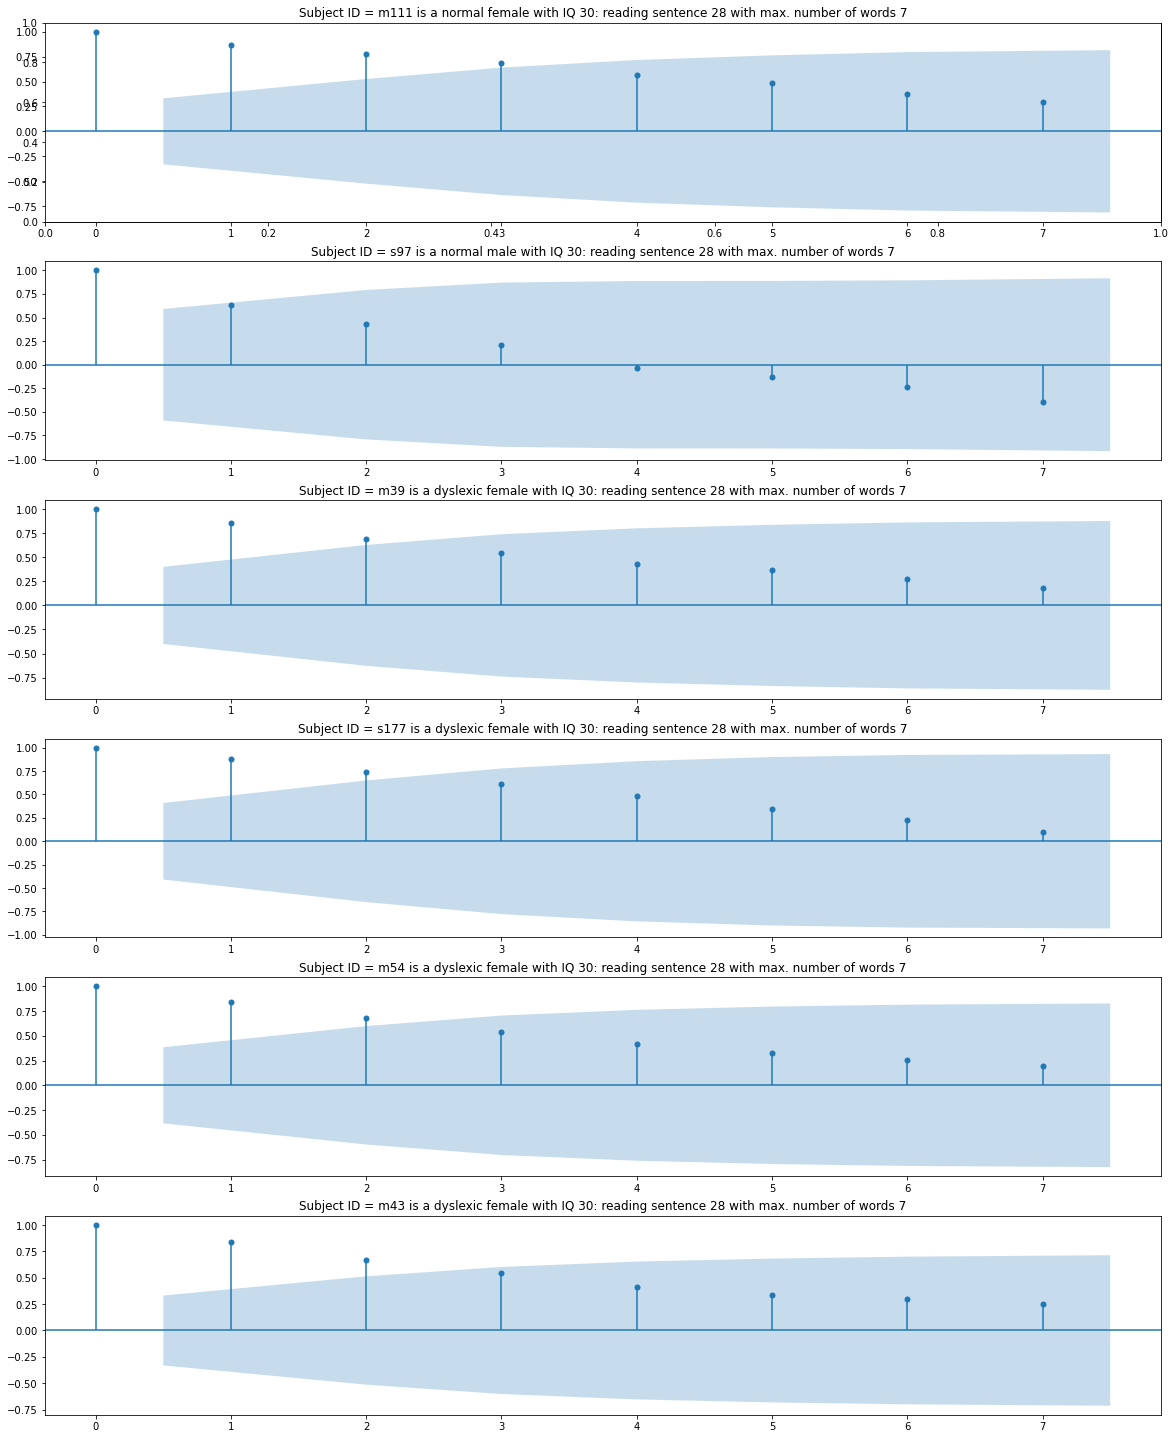

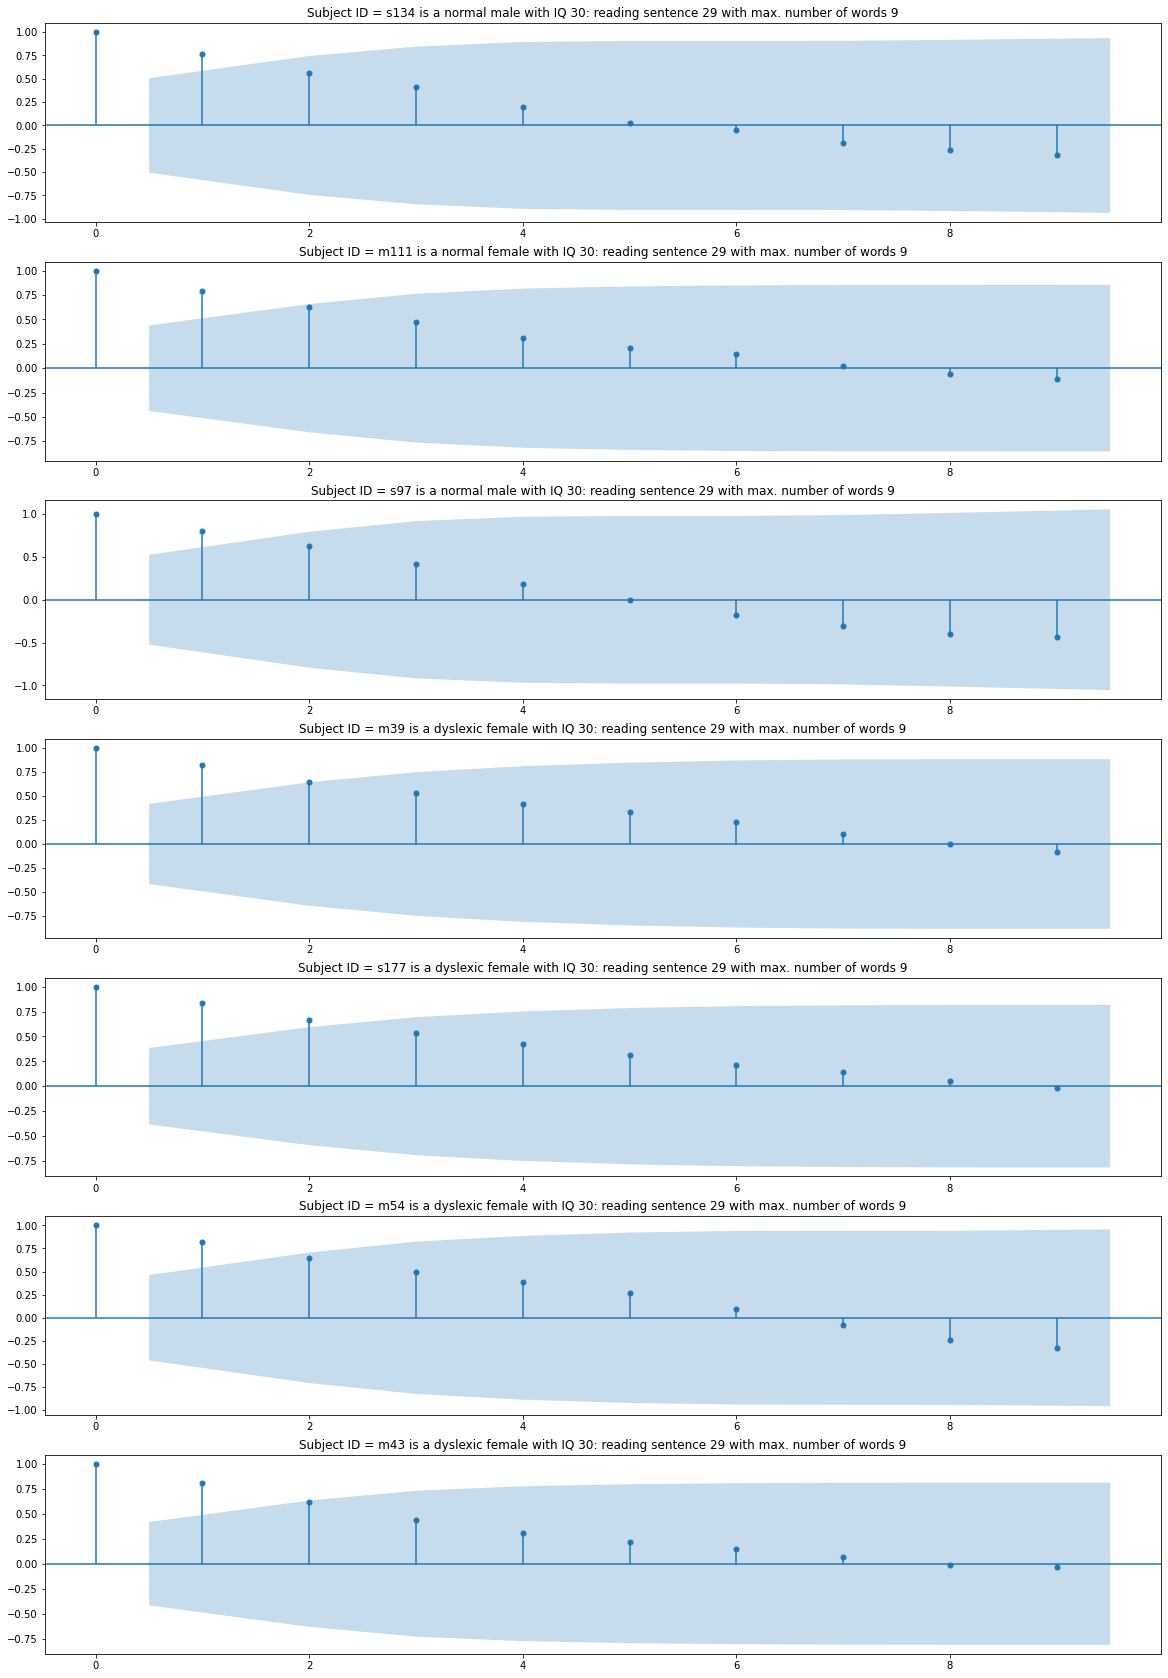

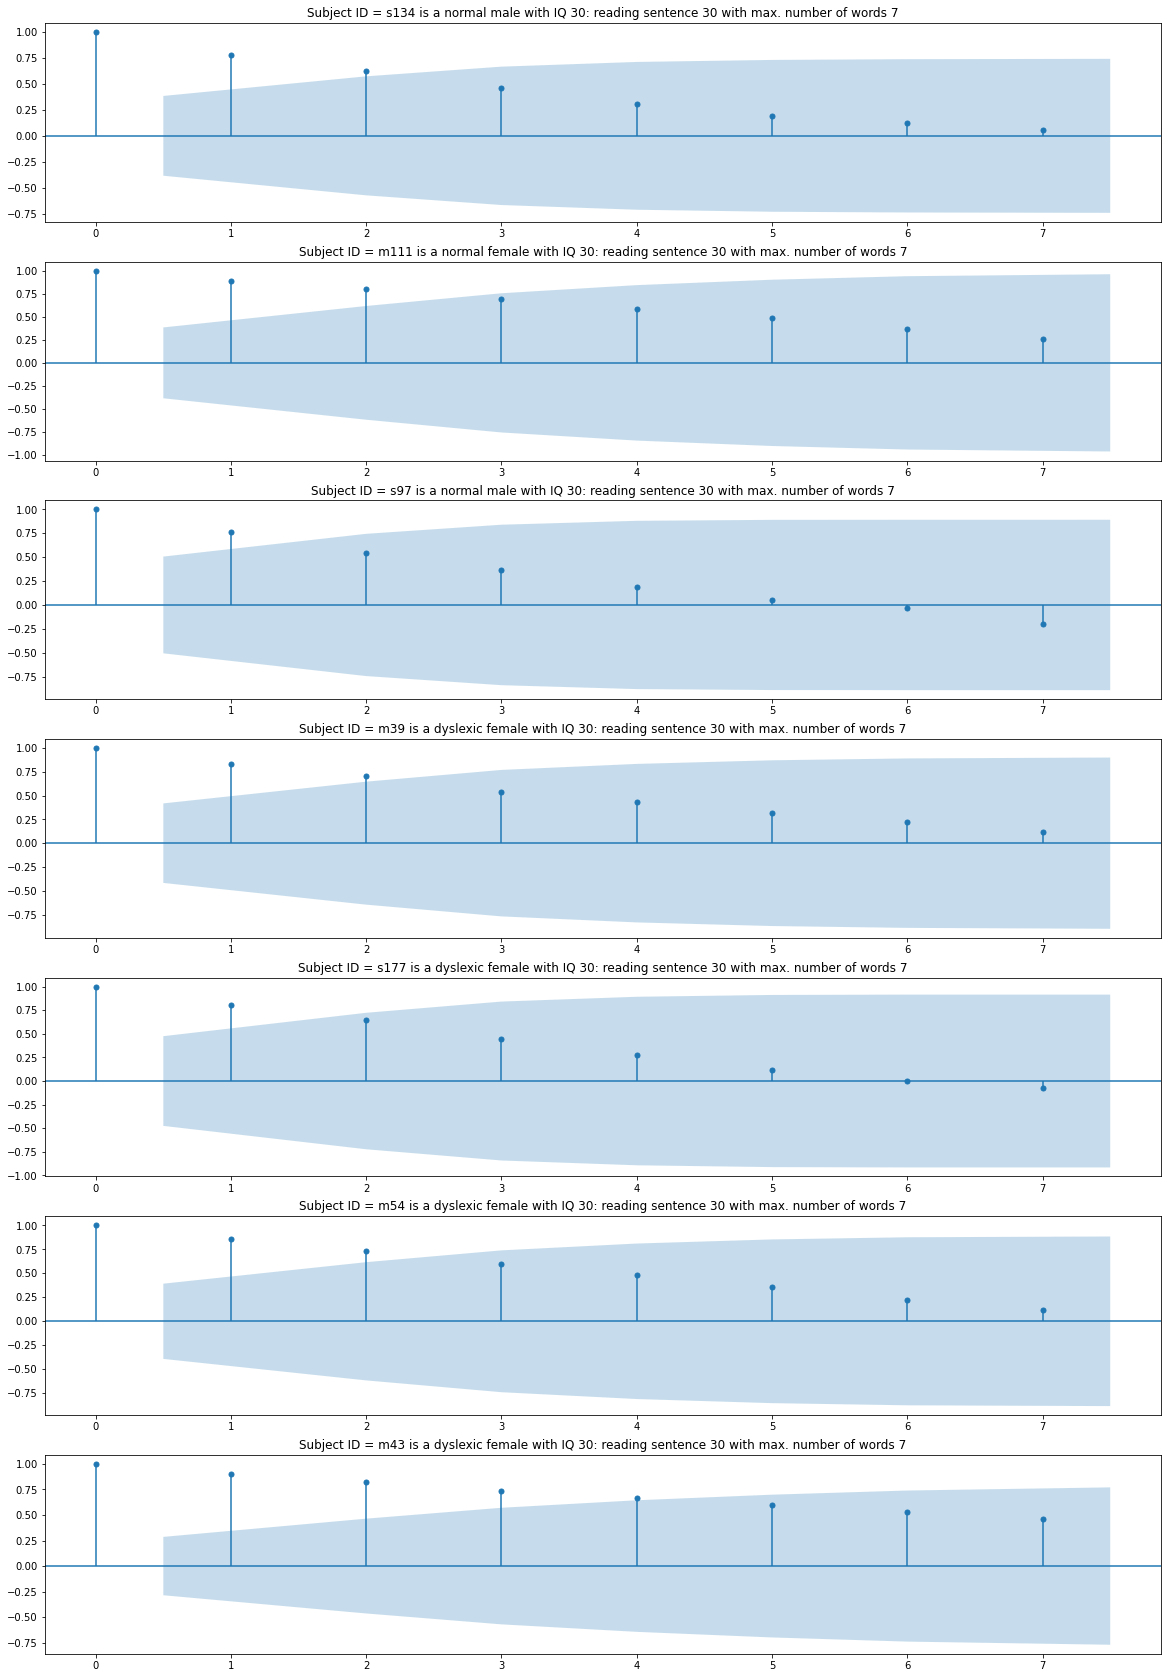

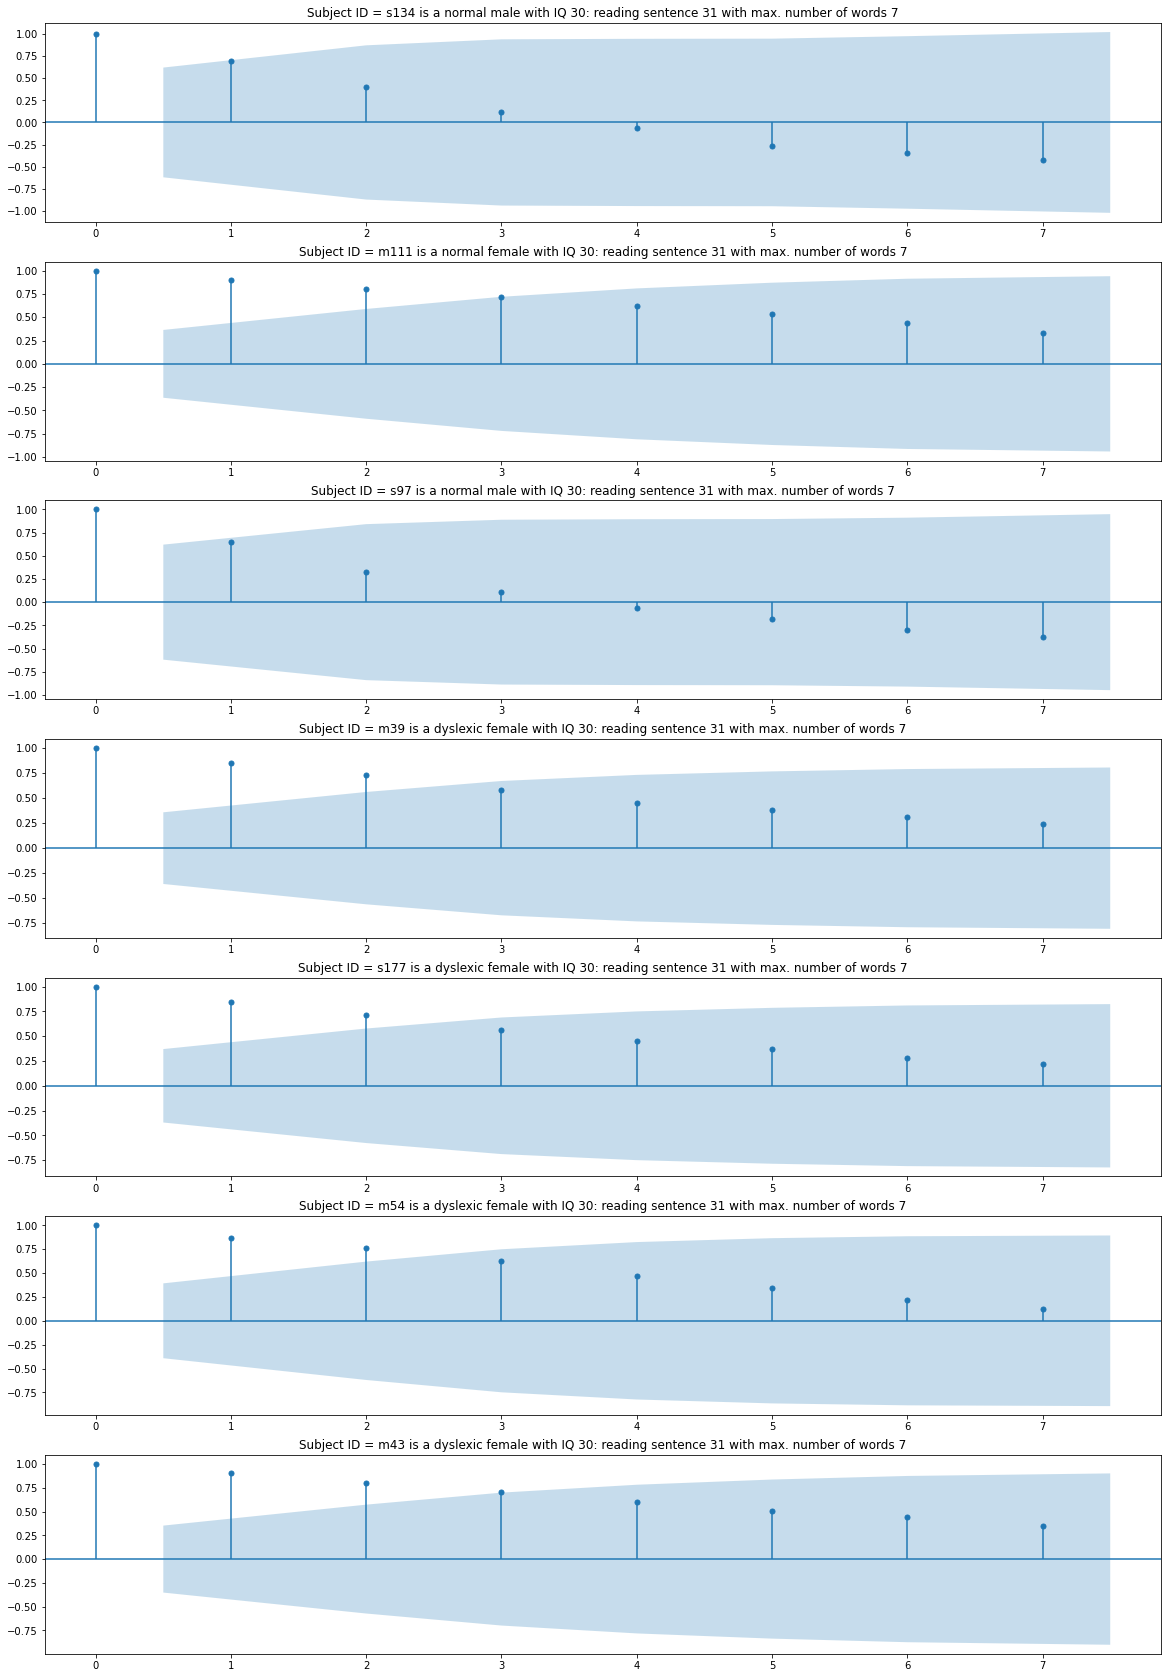

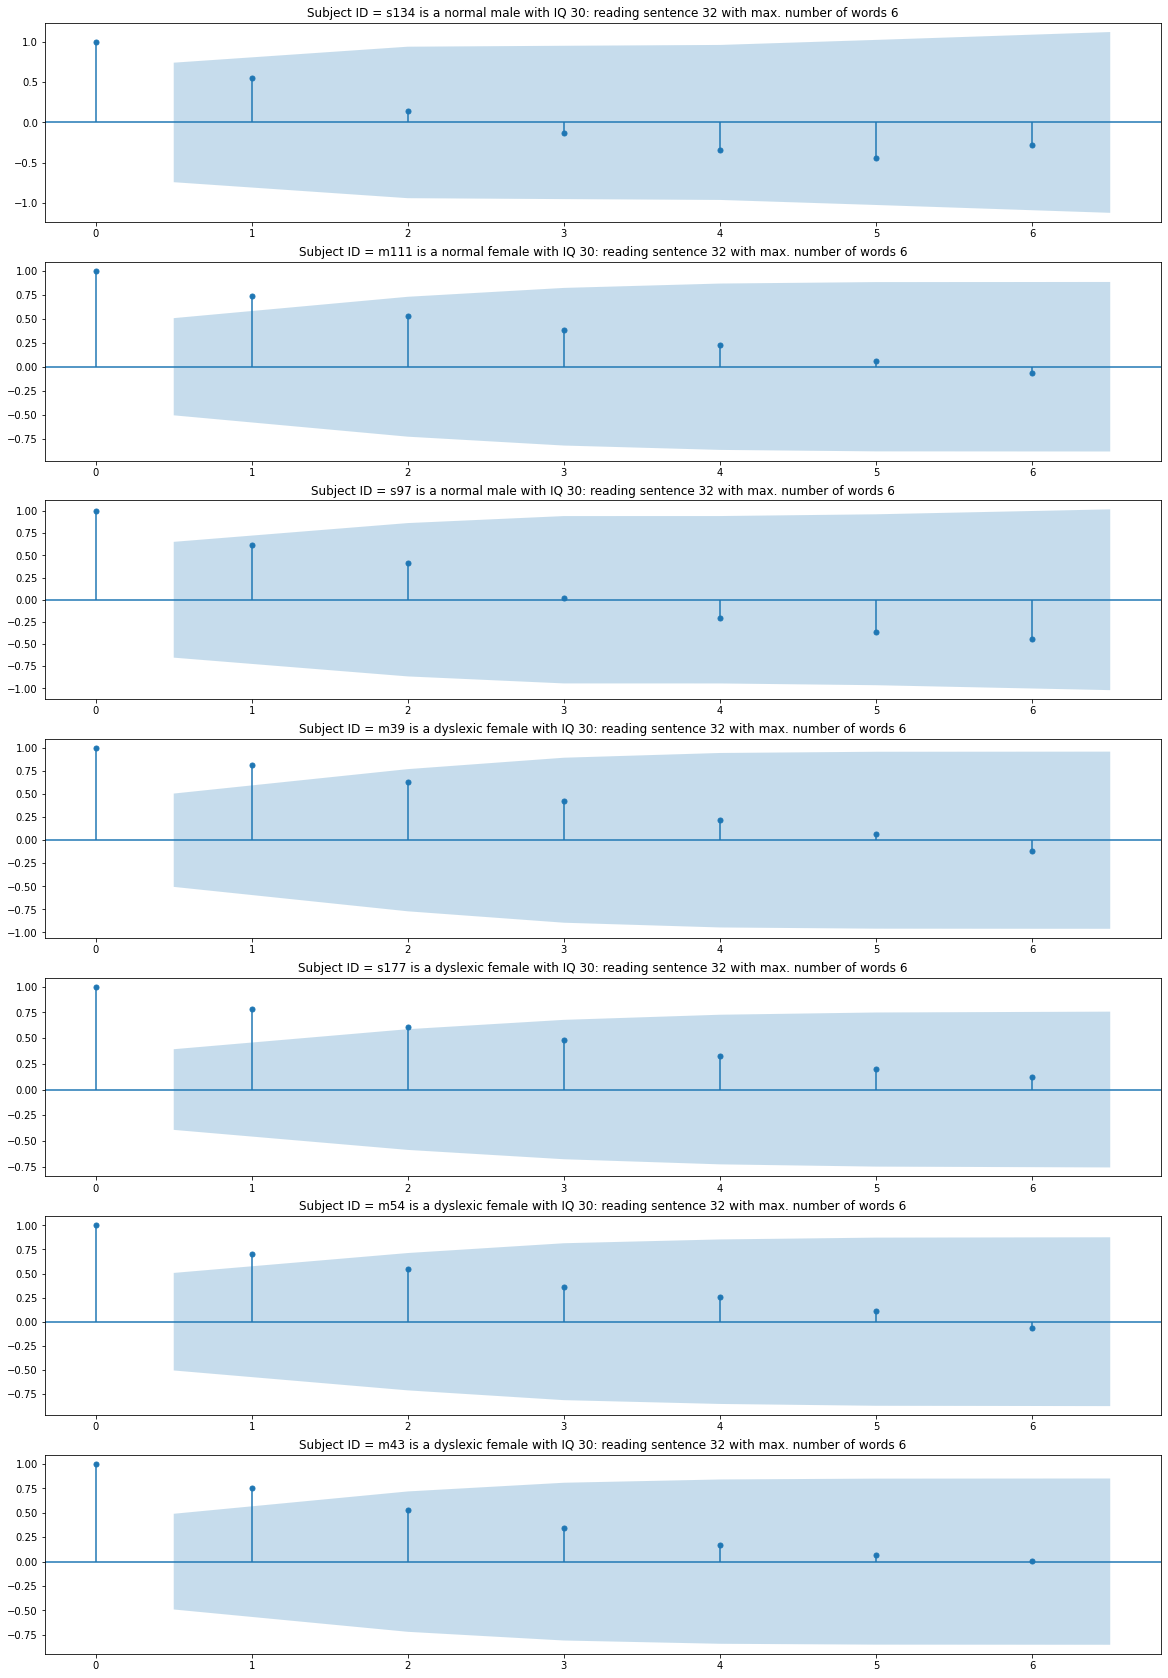

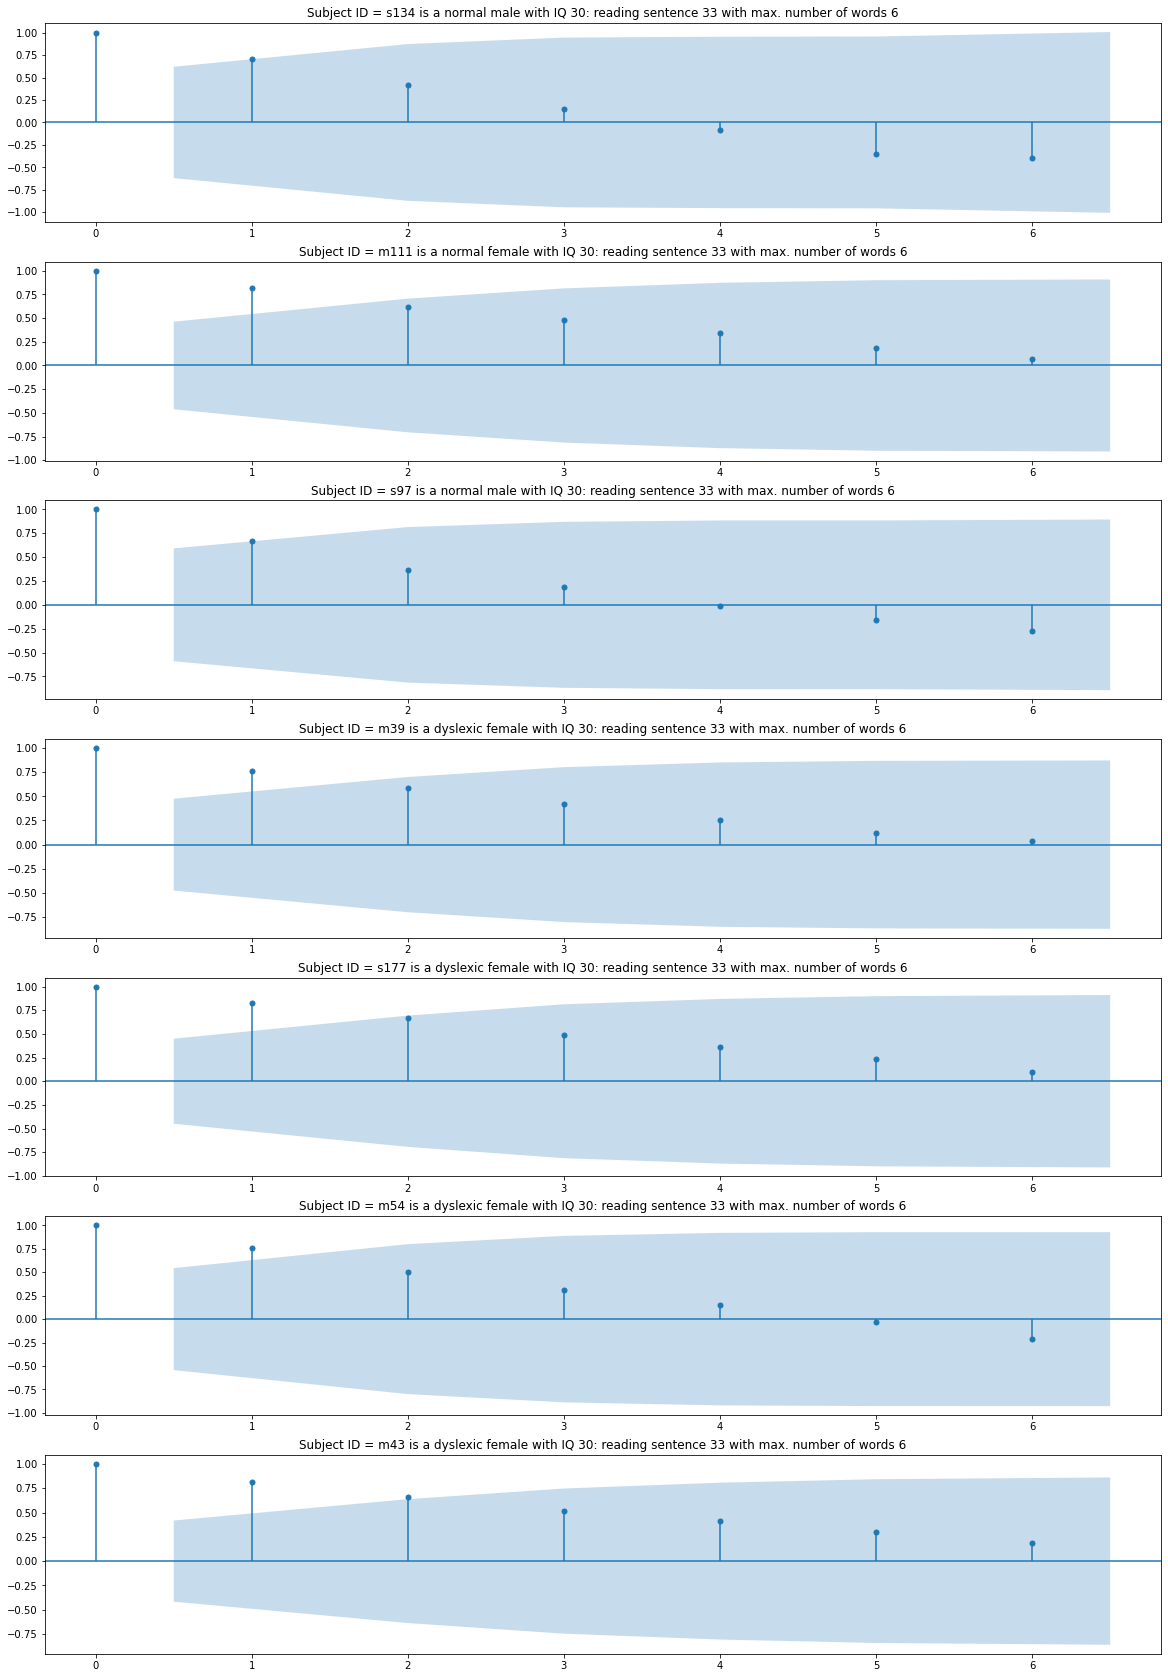

In [32]:


issues = plot_norm_vs_dyslexic_AFC(data_n=n1, data_d=d1, feature="FIX_X", )



In [33]:

issues



['Subject ID = s134 is a normal male who skipped reading 8,',
 'Subject ID = s97 is a normal male who skipped reading 8,',
 'Subject ID = s97 is a normal male who skipped reading 12,',
 'Subject ID = s97 is a normal male who skipped reading 13,',
 'Subject ID = s97 is a normal male who skipped reading 15,',
 'Subject ID = s134 is a normal male who skipped reading 21,',
 'Subject ID = s134 is a normal male who skipped reading 26,',
 'Subject ID = s134 is a normal male who skipped reading 27,',
 'Subject ID = s134 is a normal male who skipped reading 28,']

In [ ]:


issues_ = plot_norm_vs_dyslexic_AFC(data_n=n1, data_d=d1, feature="FIX_Y", )




FIX_Y


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [ ]:



issues_ = plot_norm_vs_dyslexic_AFC(data_n=n1, data_d=d1, feature="FIX_DURATION", )





In [ ]:



n_grade = 3 
iq_low = 30
iq_high = 30


n2 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=1
)

r2 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=2
)



d2 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=3
)


s_m2 = min(len(set(n2.SubjectID)), len(set(d2.SubjectID)))


print(
    f"Normals  : {len(set(n2.SubjectID))} \n"
    f"At-risks : {len(set(r2.SubjectID))} \n"
    f"Dyslexics: {len(set(d2.SubjectID))} \n"
    f"Min. number of in-common subjects: {s_m2} \n"

)



In [ ]:



n_grade = 3 
iq_low = 28
iq_high = 28


n2 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=1
)

r2 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=2
)



d2 = filter_data(
    df=df_data_to_use, iq_low=iq_low, 
    iq_high=iq_high, n_grade=n_grade, group=3
)


s_m2 = min(len(set(n2.SubjectID)), len(set(d2.SubjectID)))


print(
    f"Normals  : {len(set(n2.SubjectID))} \n"
    f"At-risks : {len(set(r2.SubjectID))} \n"
    f"Dyslexics: {len(set(d2.SubjectID))} \n"
    f"Min. number of in-common subjects: {s_m2} \n"

)




In [ ]:




n2_subjs = list(set(n2.SubjectID))
d2_subjs = list(set(d2.SubjectID))
c2_subjs = n2_subjs + d2_subjs

for i in c2_subjs:
    if i in n2_subjs:
        c = "normal"
        g = set(n2.loc[n2.SubjectID == i].Sex)
        iq = list(set(n2.loc[n2.SubjectID == i].IQ))[0]
        
        if g == {1}:
            g = "female"
        else:
            g = "male"
        
    elif i in d2_subjs:
        
        c = "dyslexic"
        g = set(d2.loc[d2.SubjectID == i].Sex)
        iq = list(set(d2.loc[d2.SubjectID == i].IQ))[0]
        
        if g == {1}:
            g = "female"
        else:
            g = "male"
    
    print(
        f"Subjecd ID = {i} is a {c} {g} with IQ {iq}\n"
    )
    
    
    

FIX_X


invalid value encountered in true_divide
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


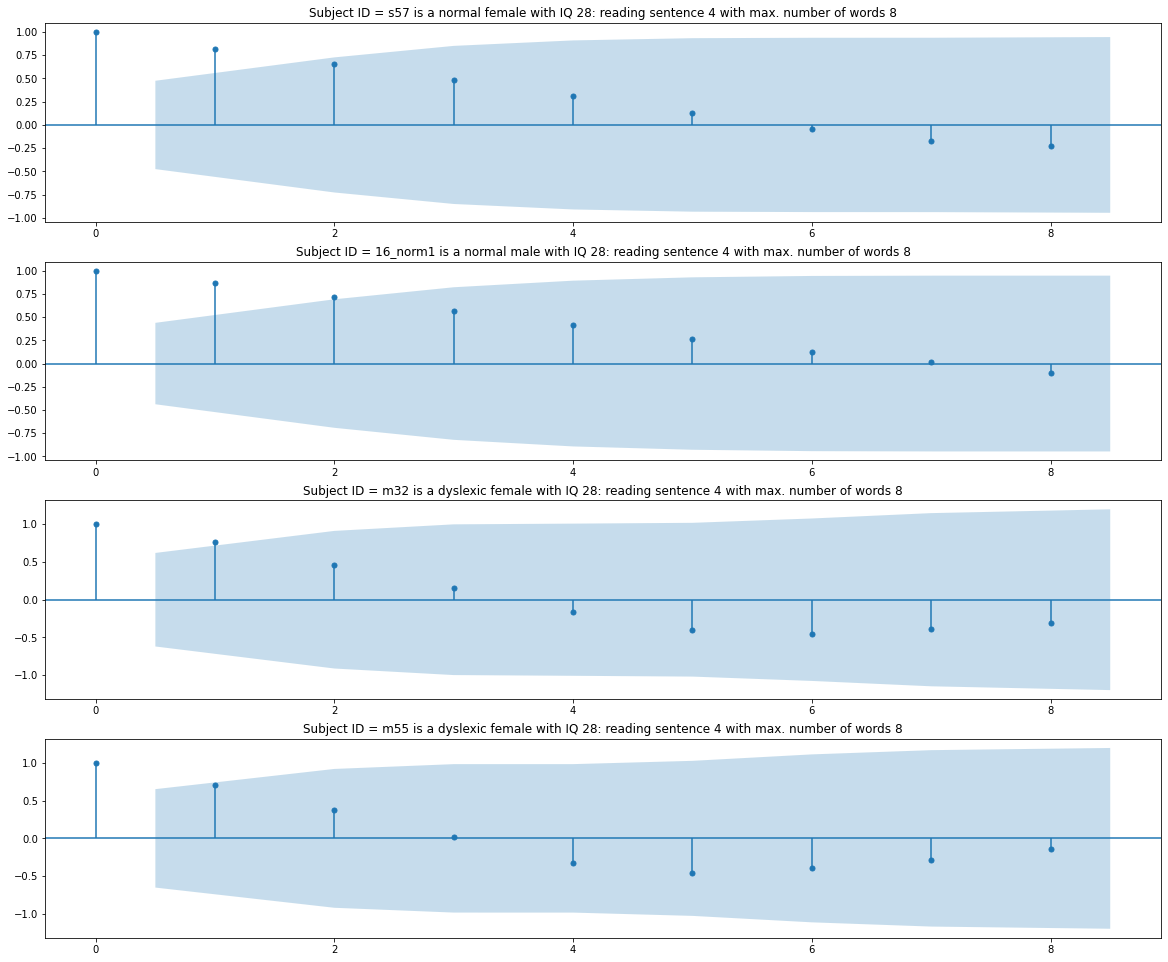

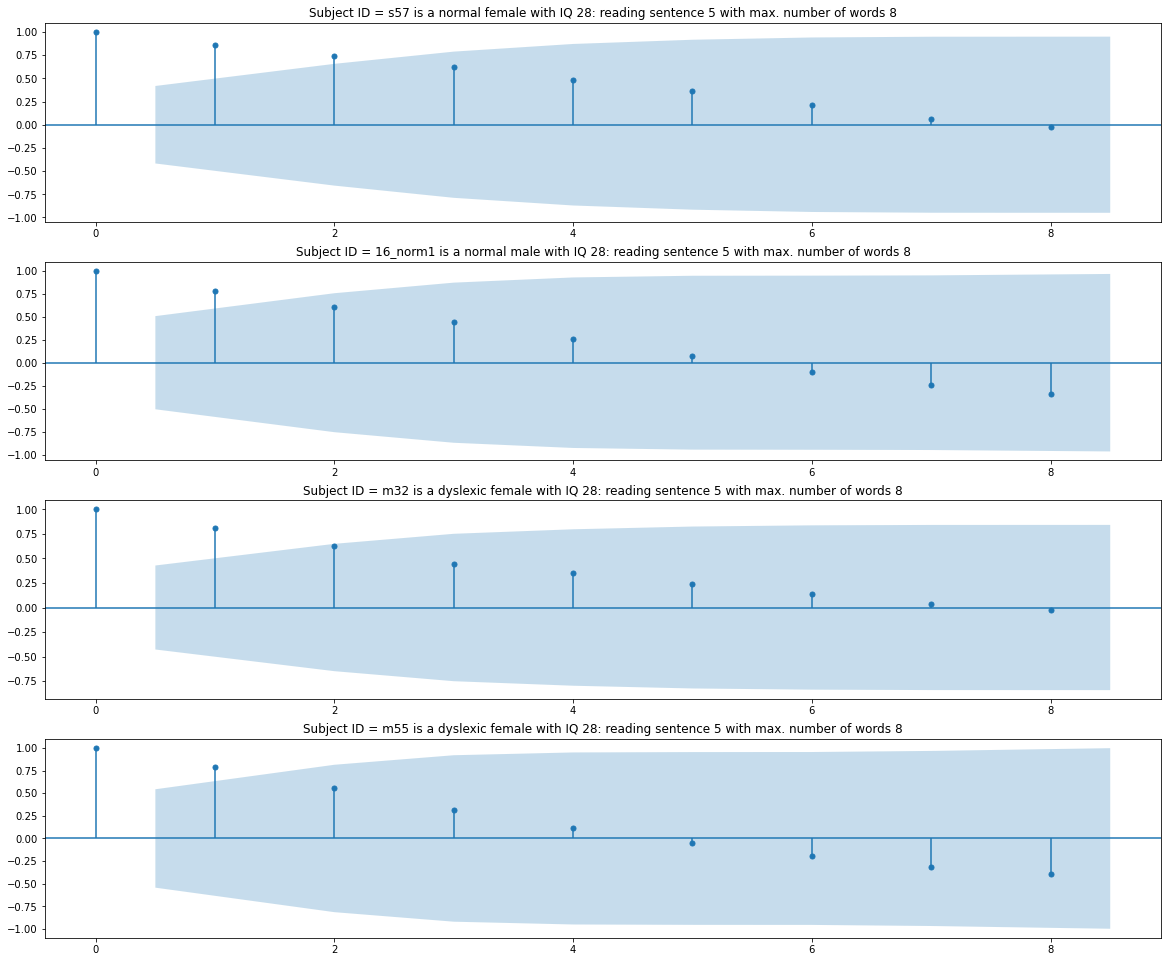

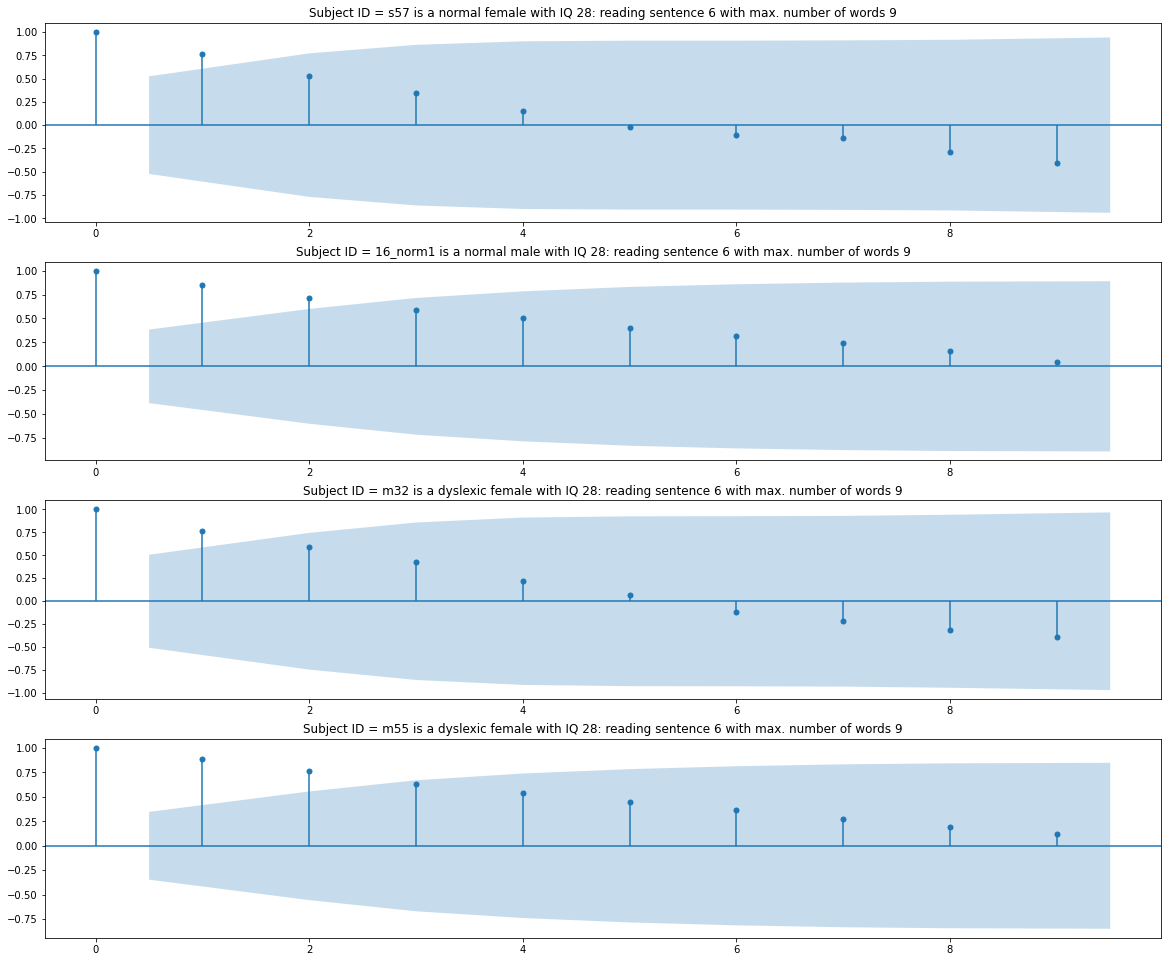

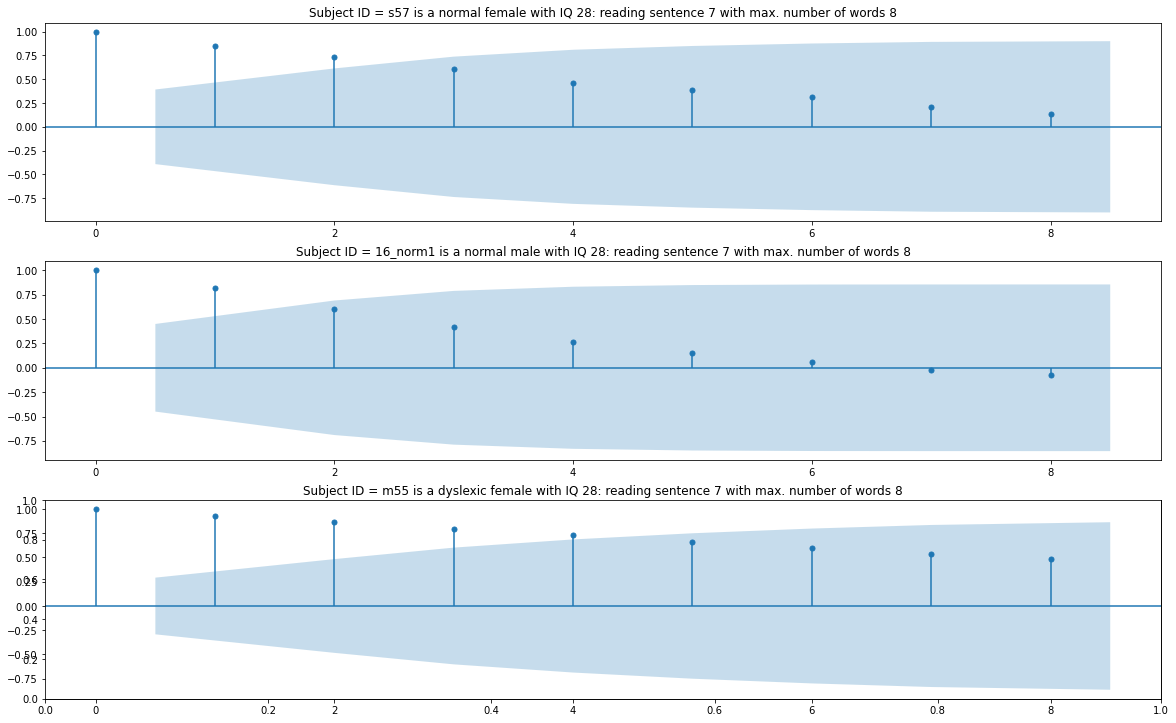

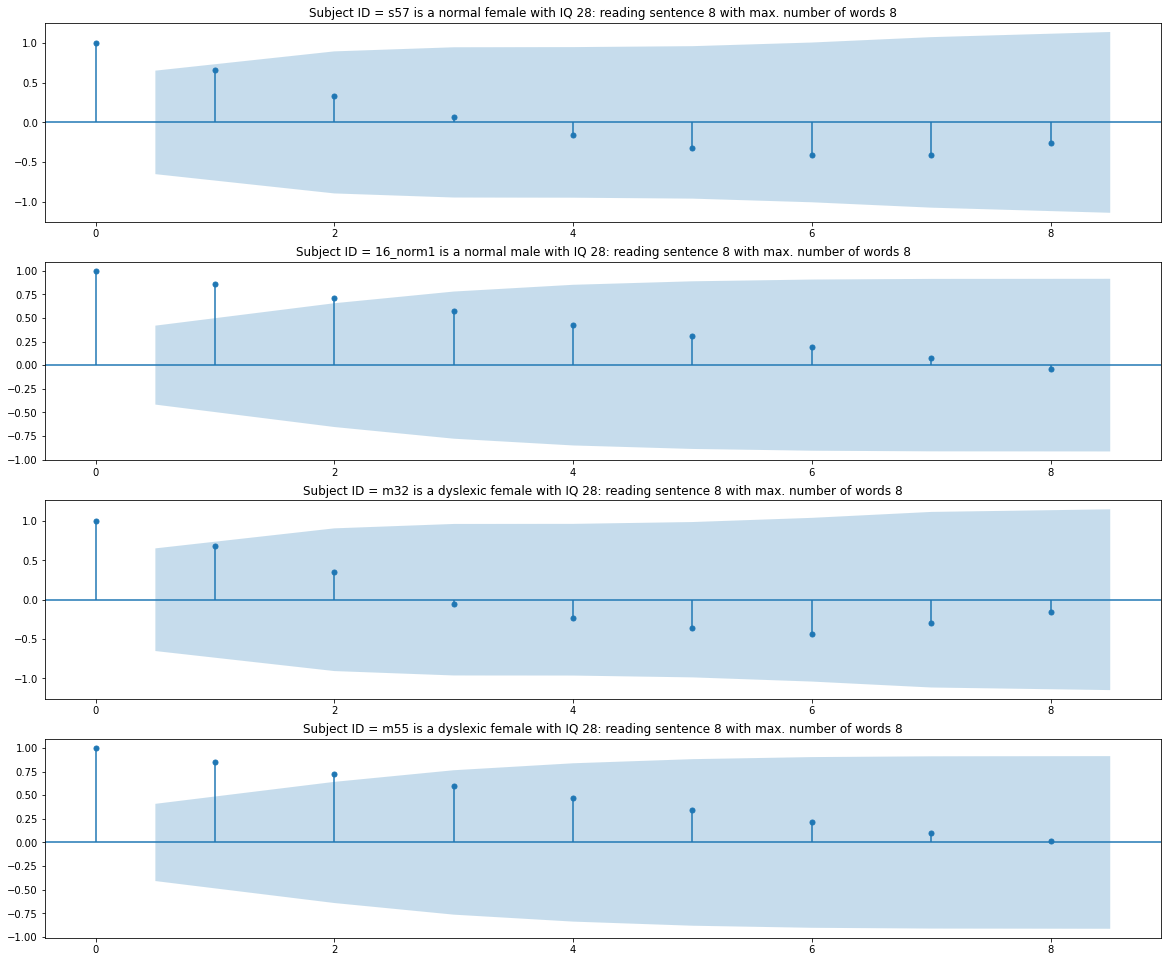

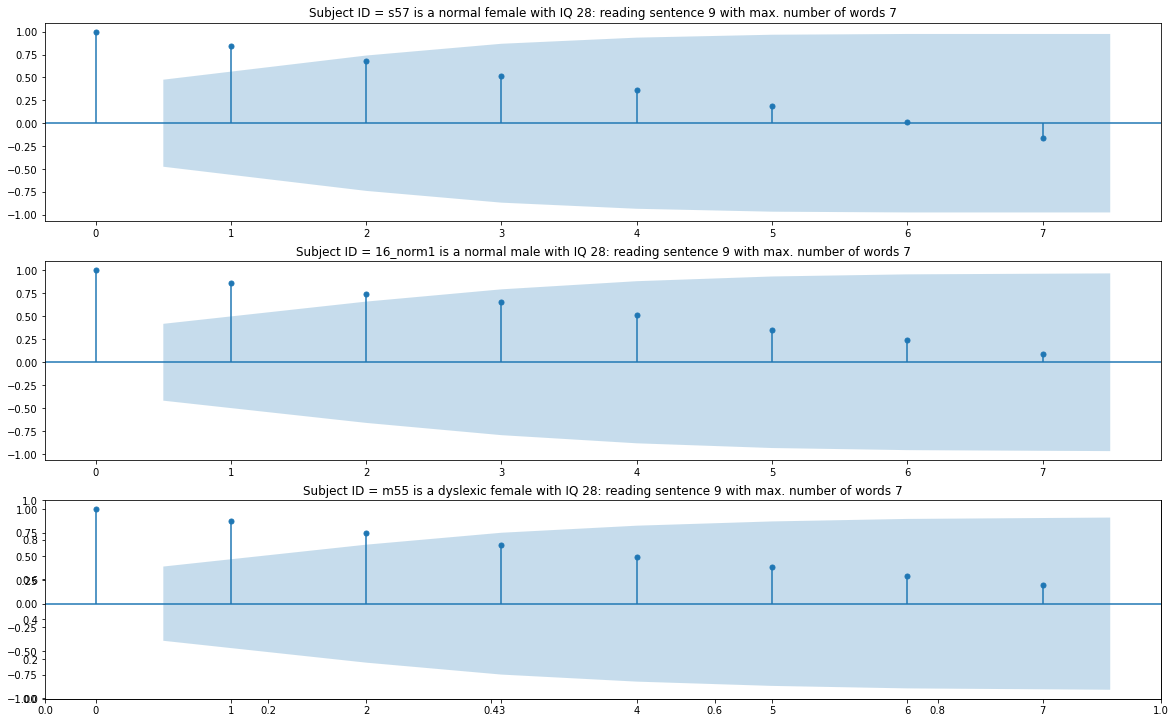

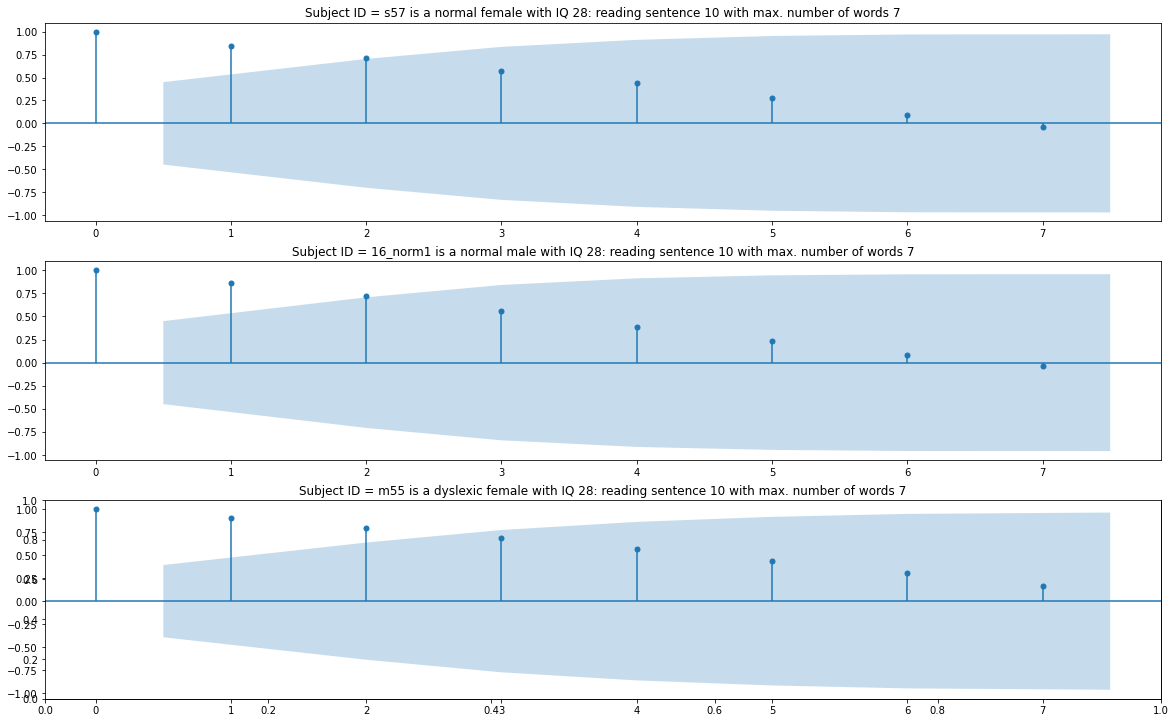

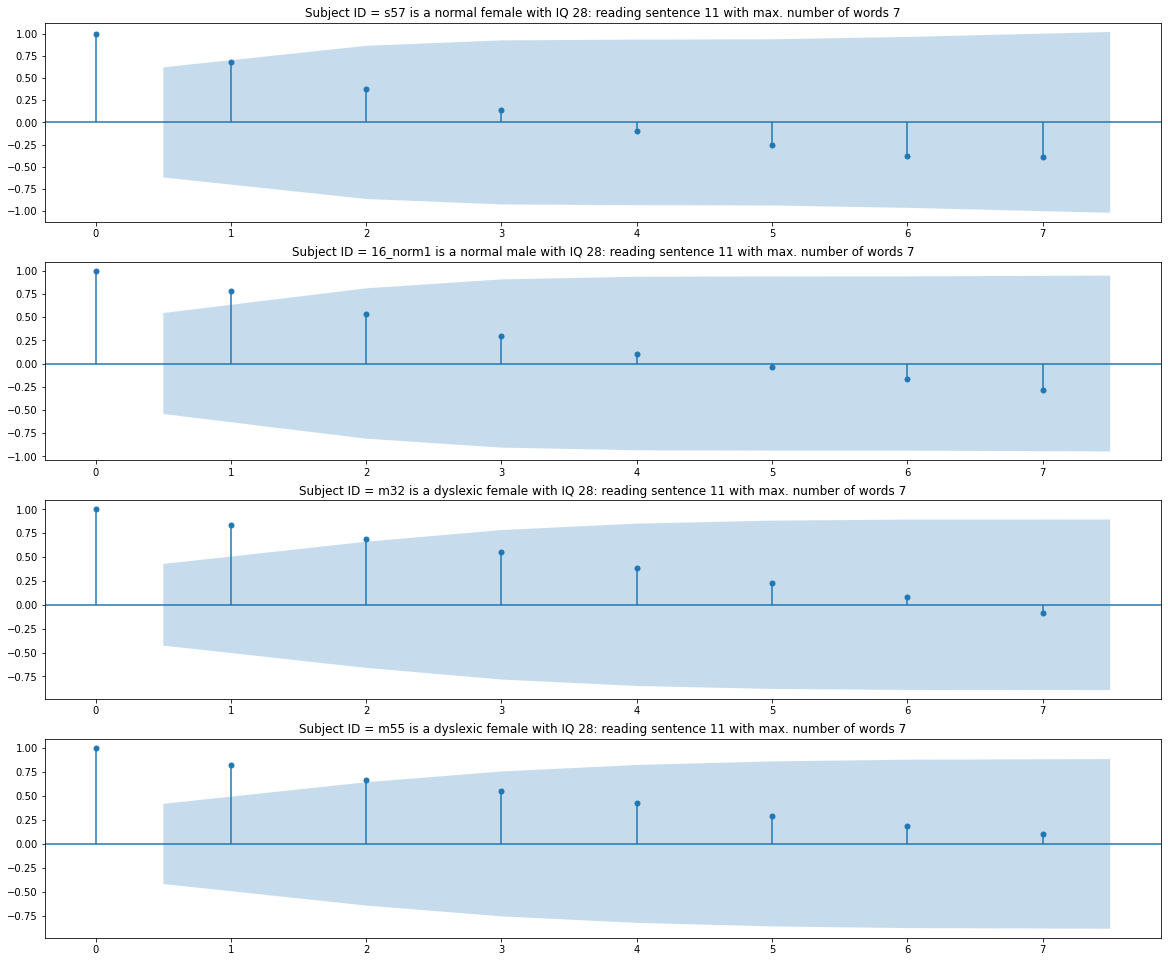

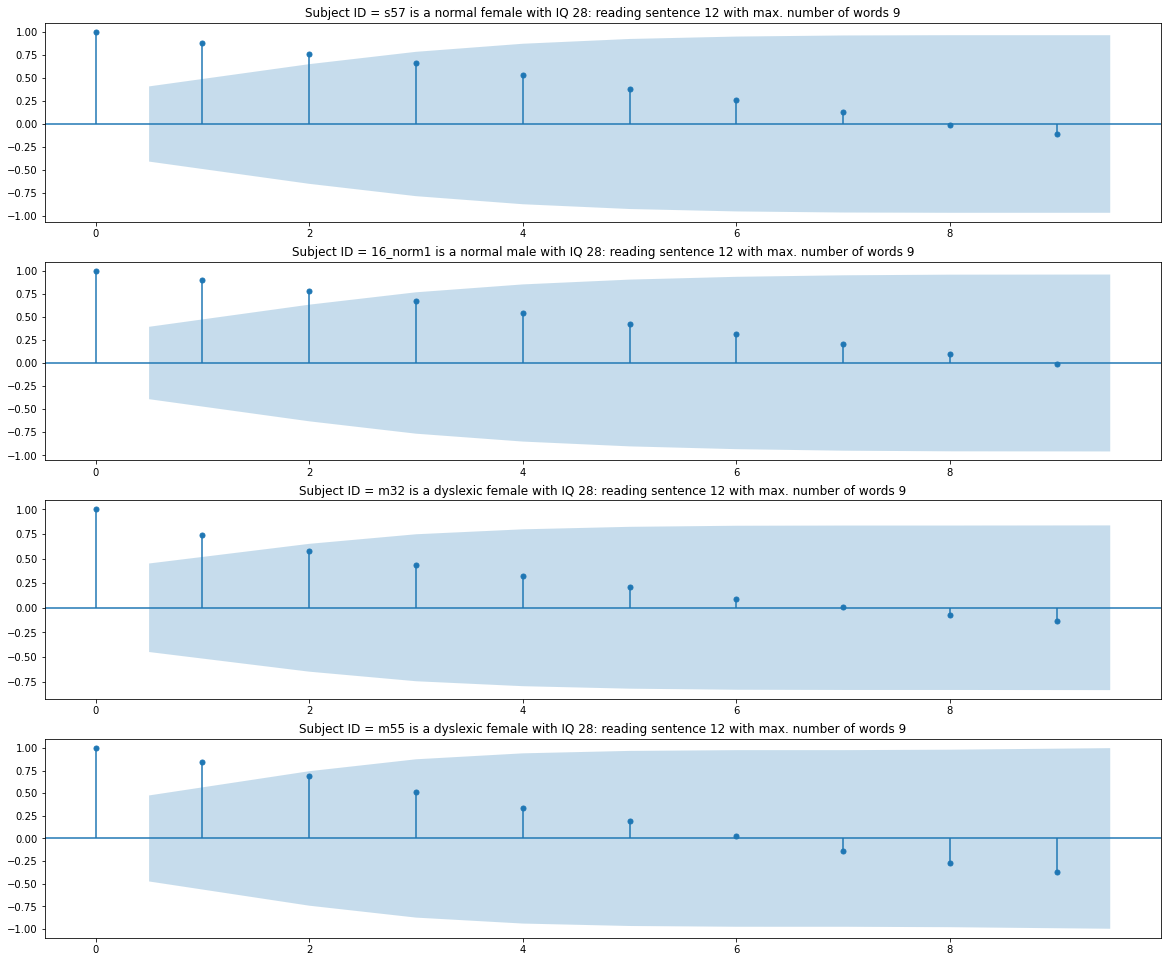

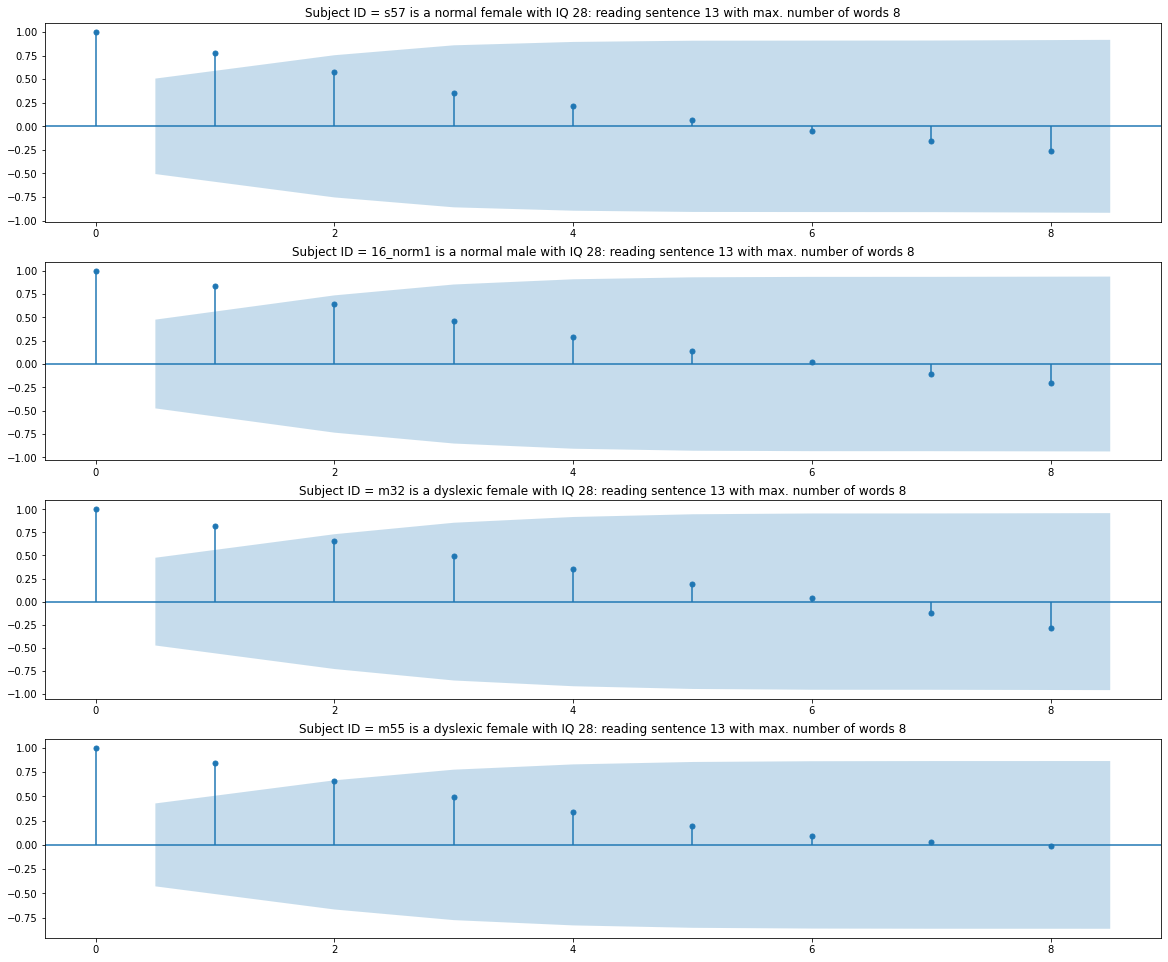

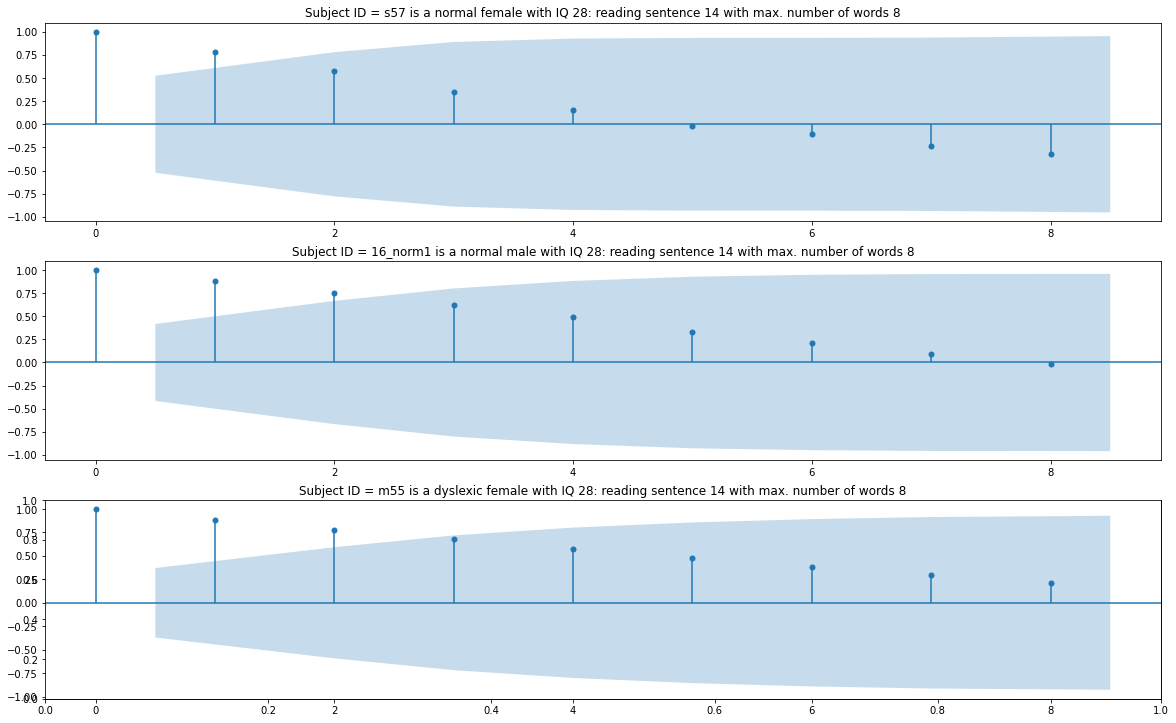

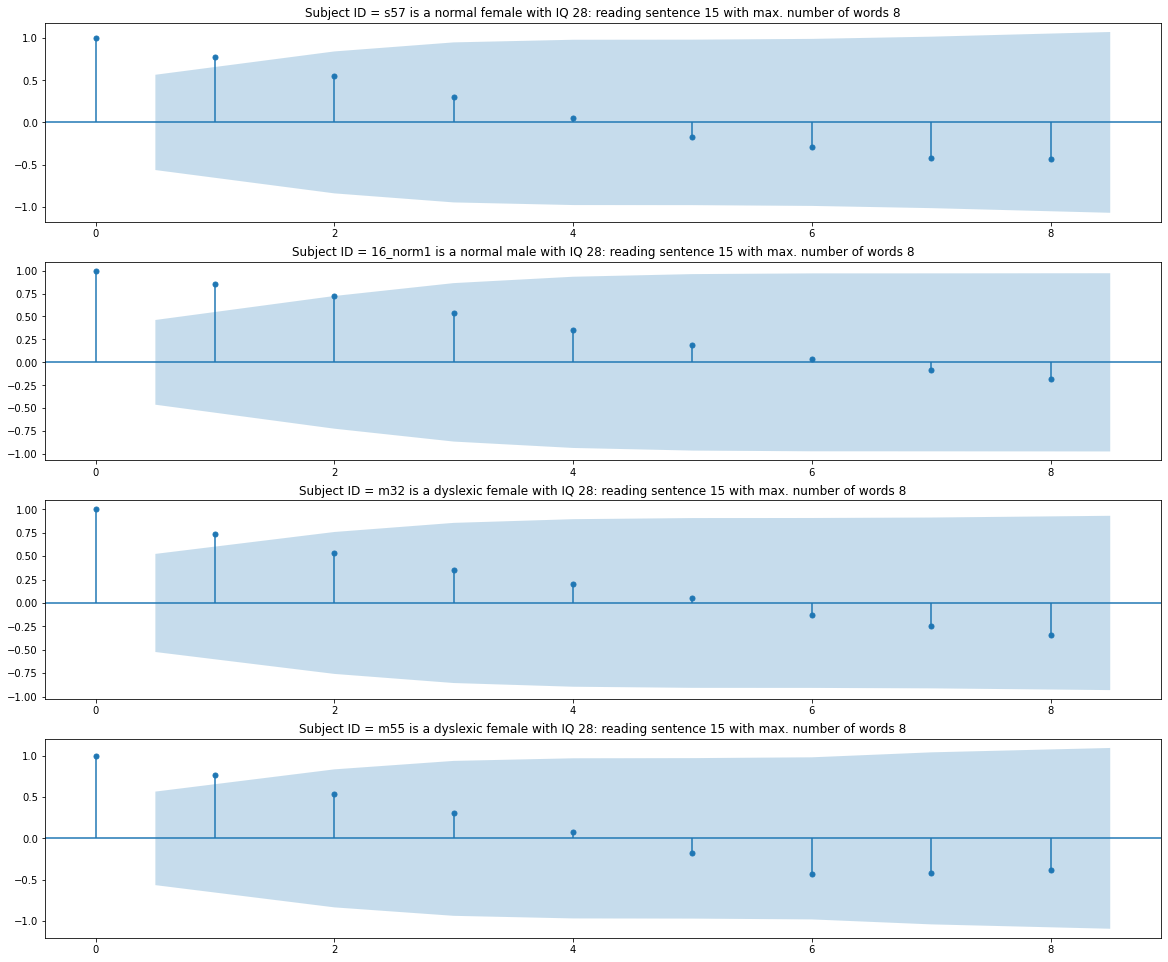

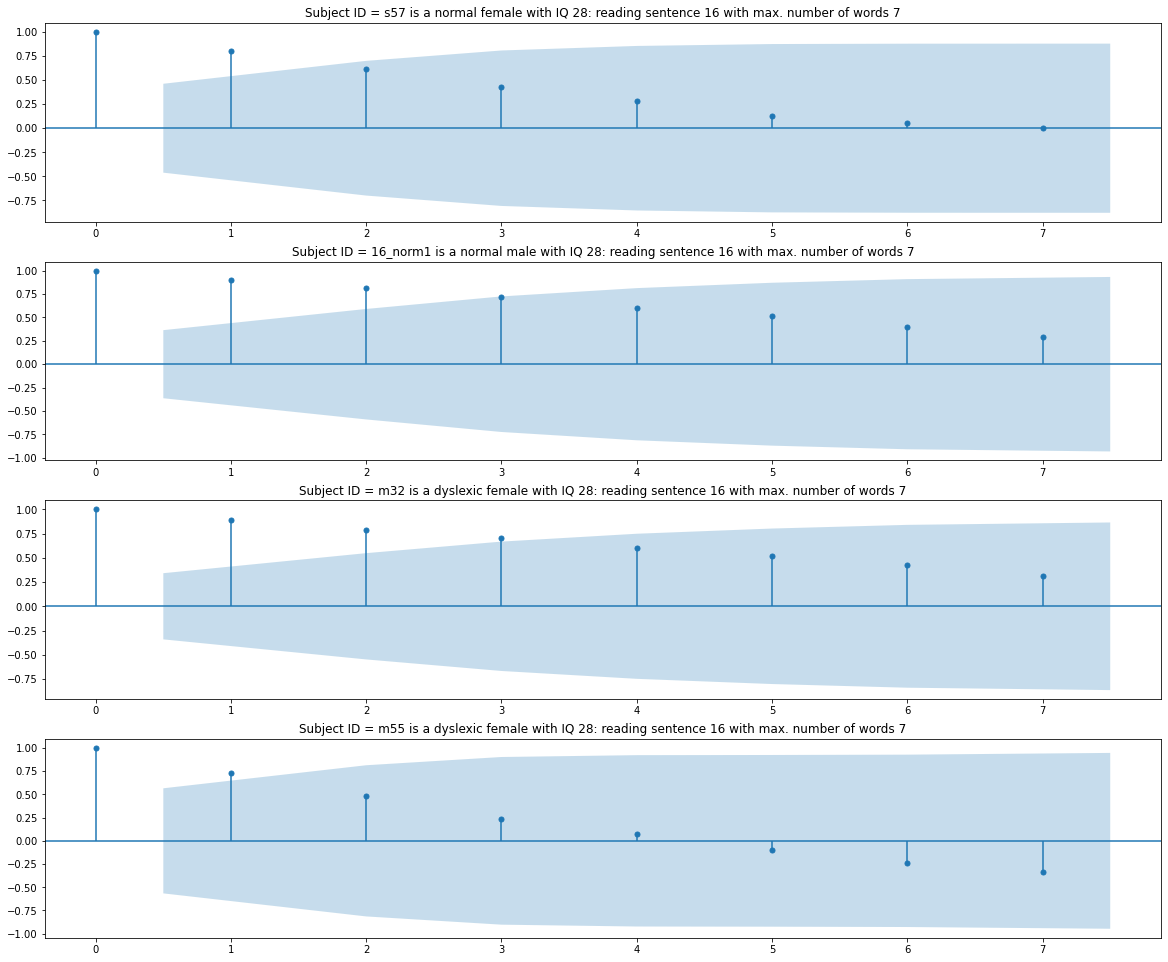

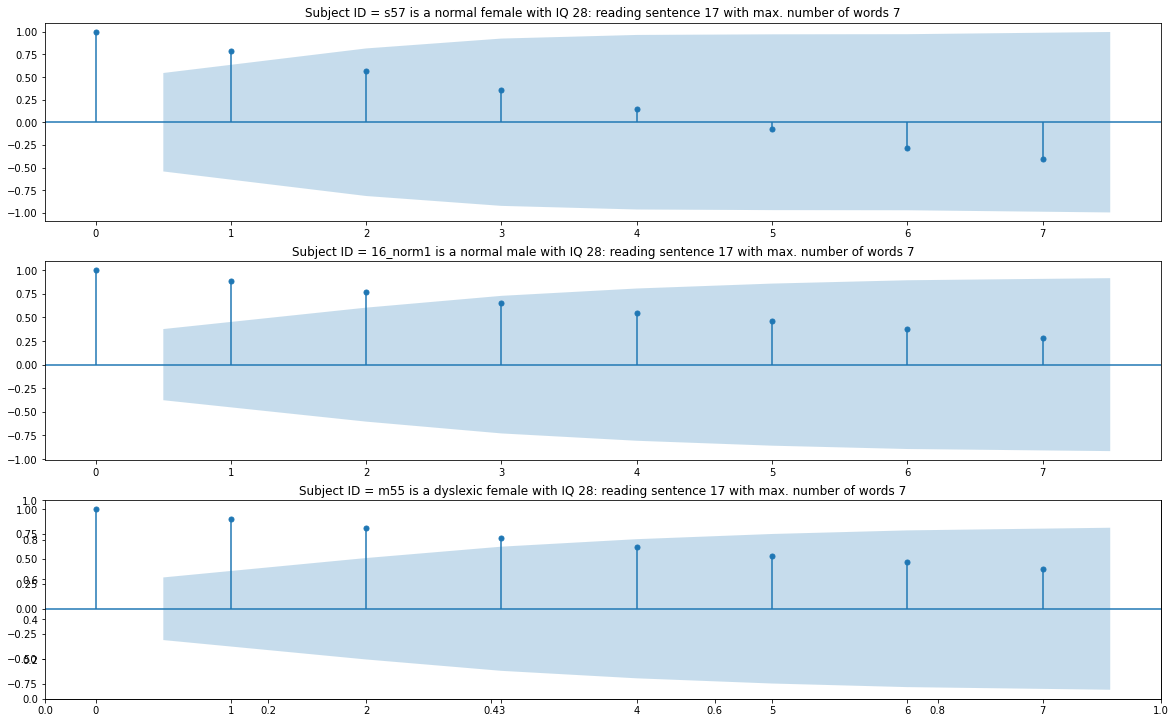

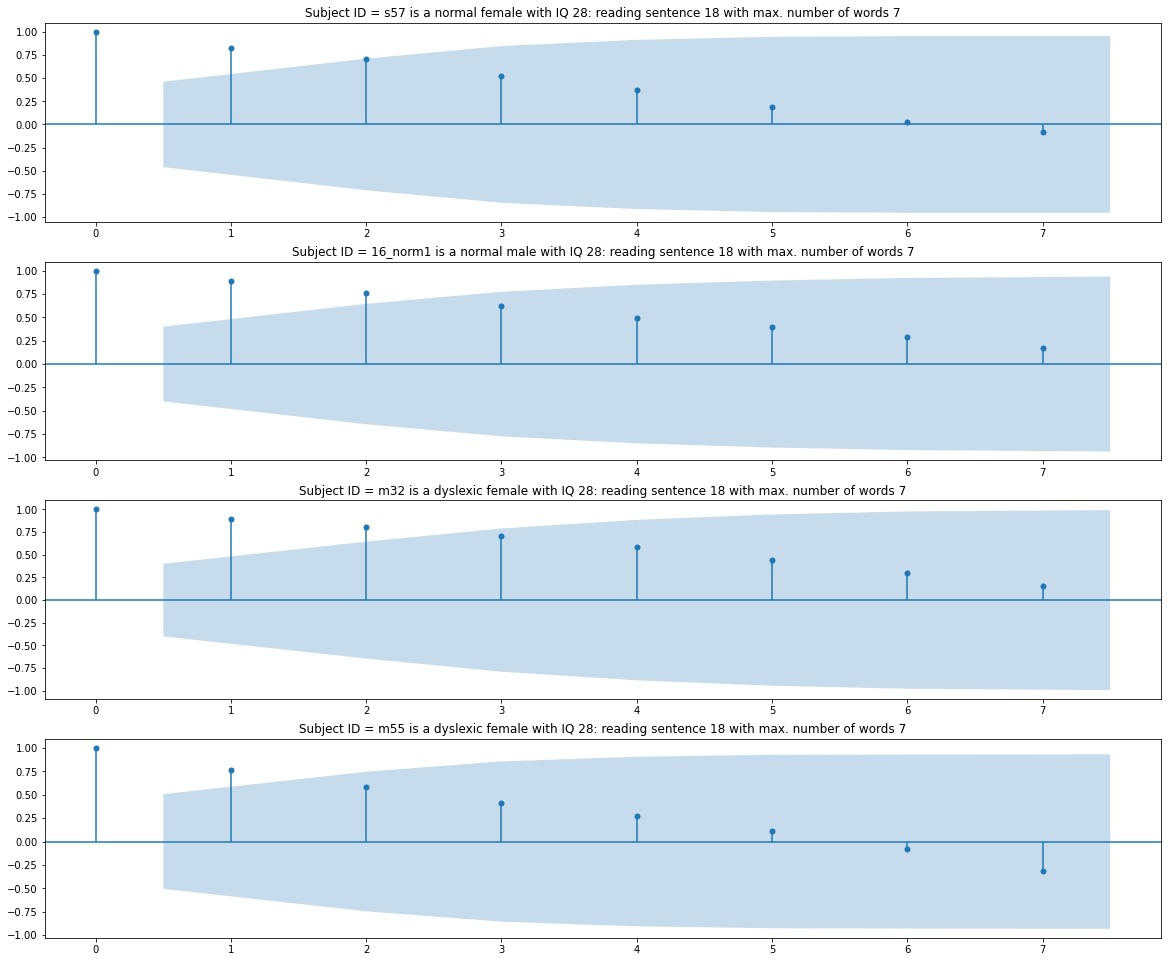

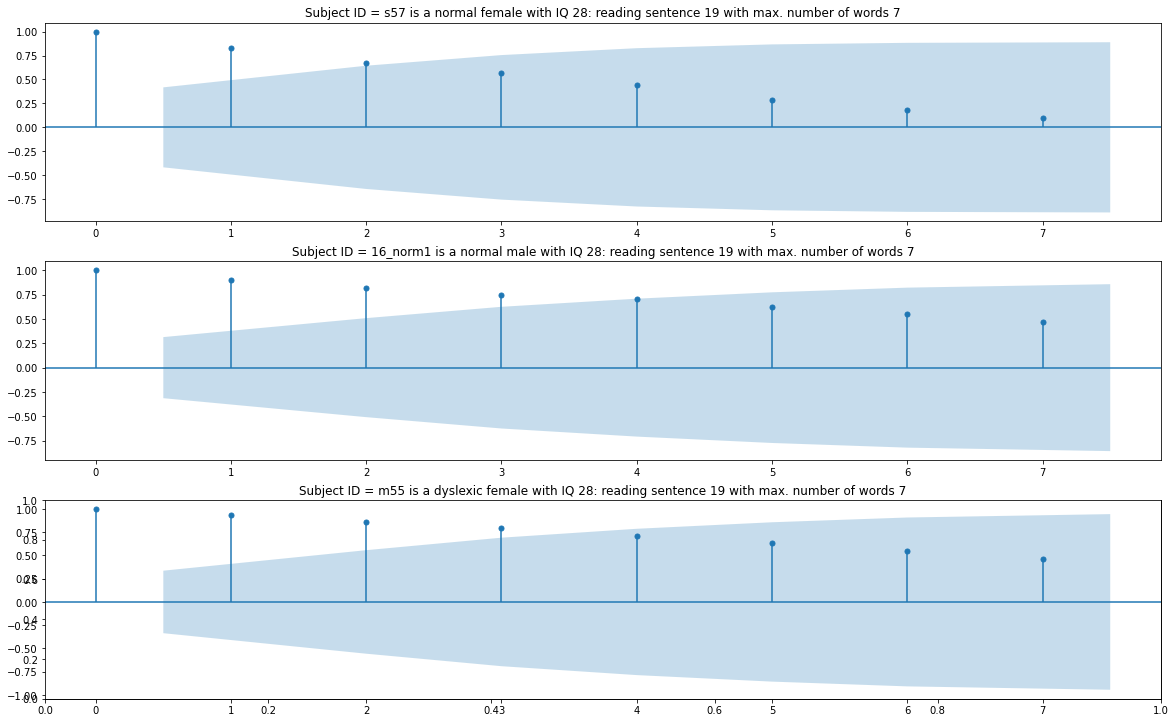

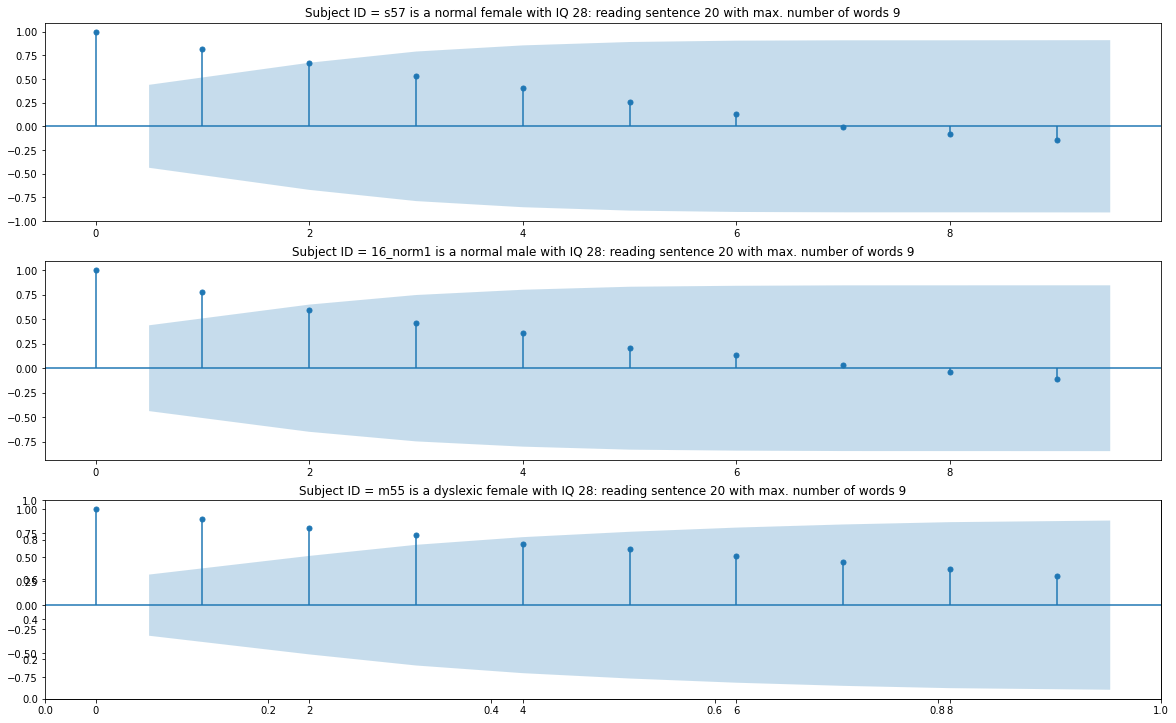

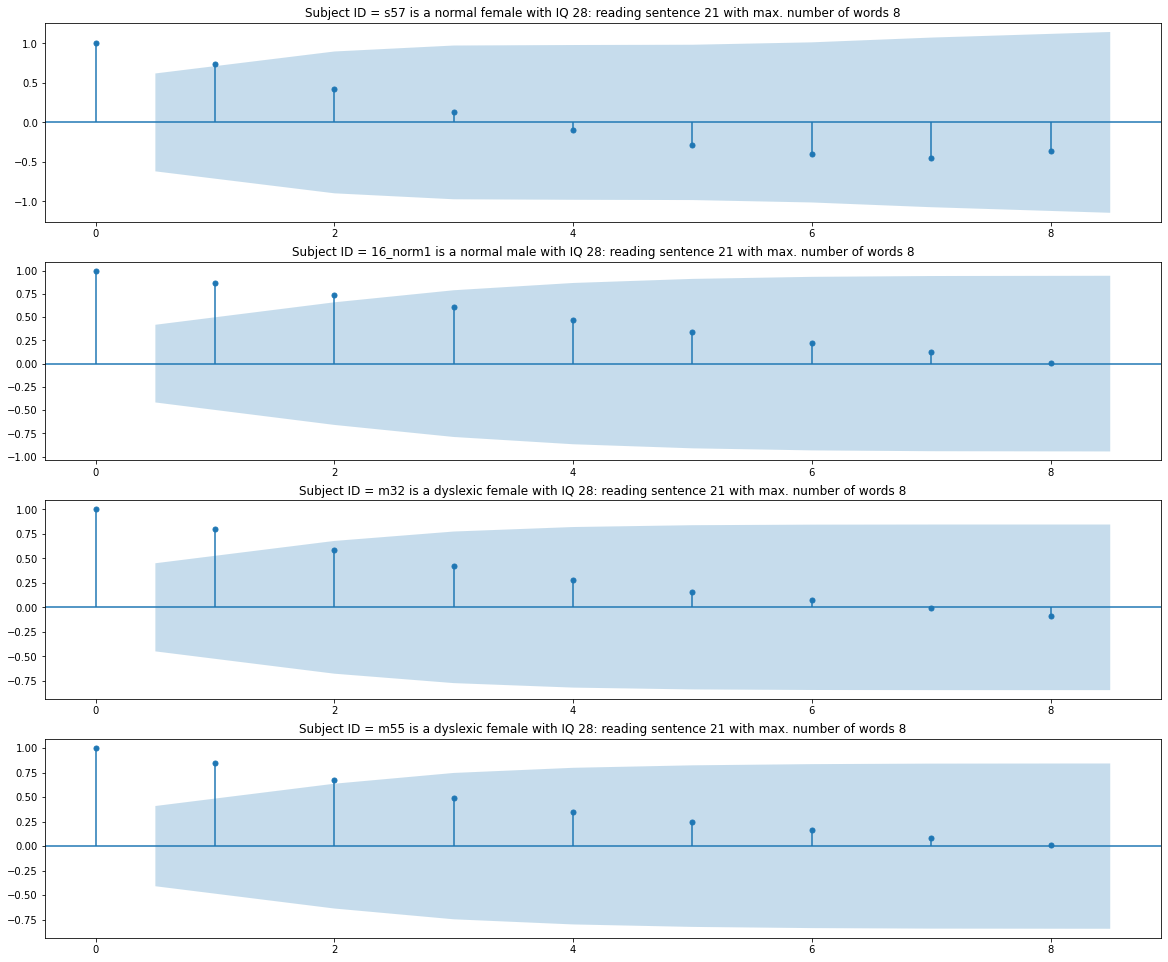

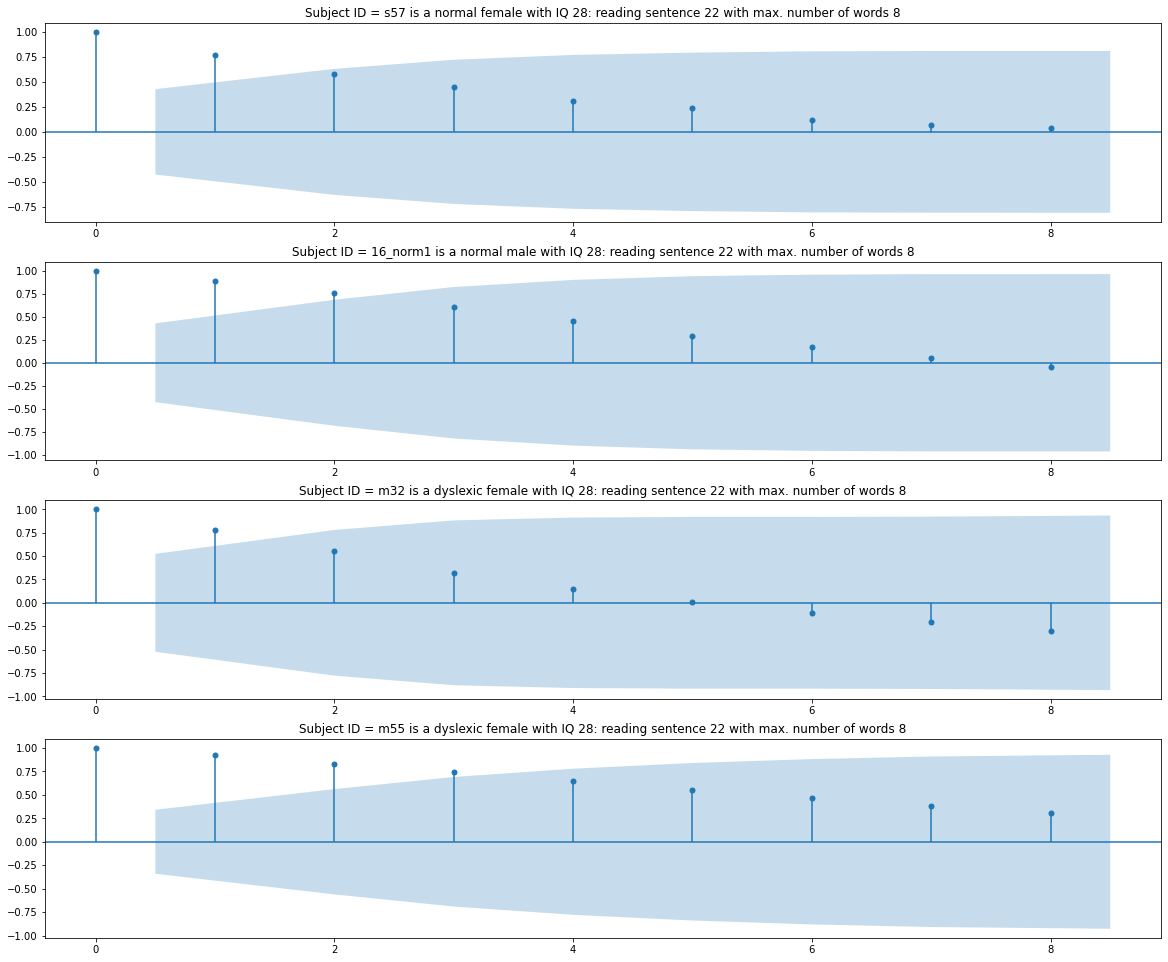

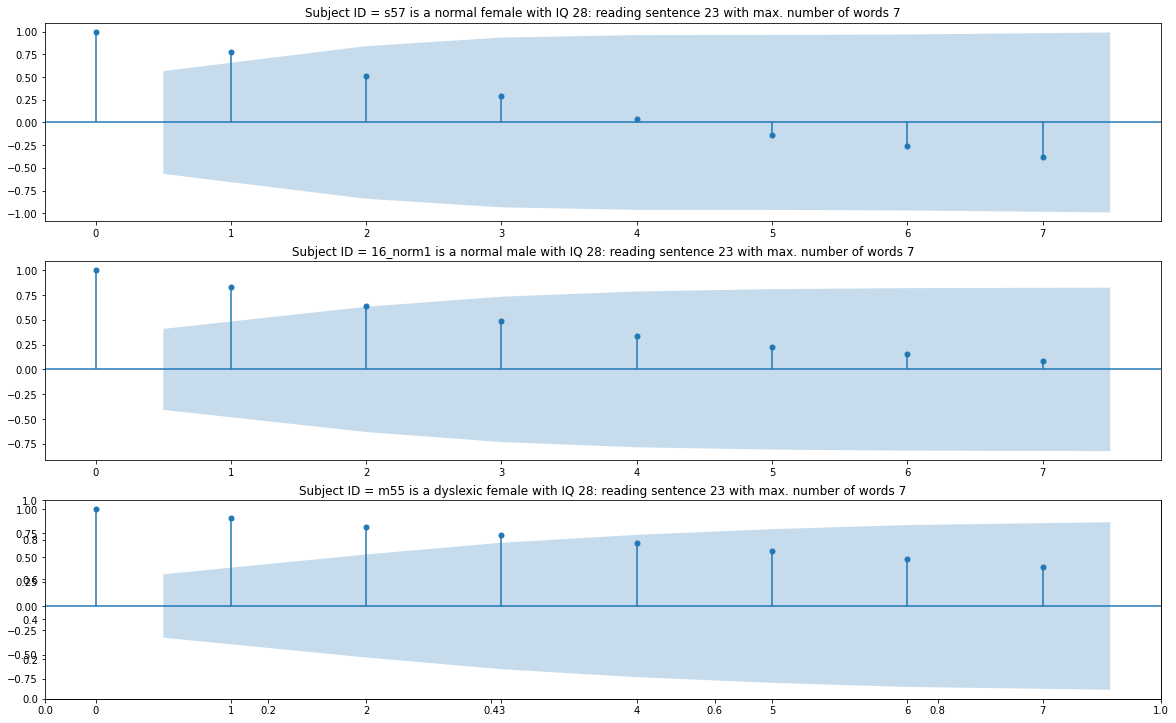

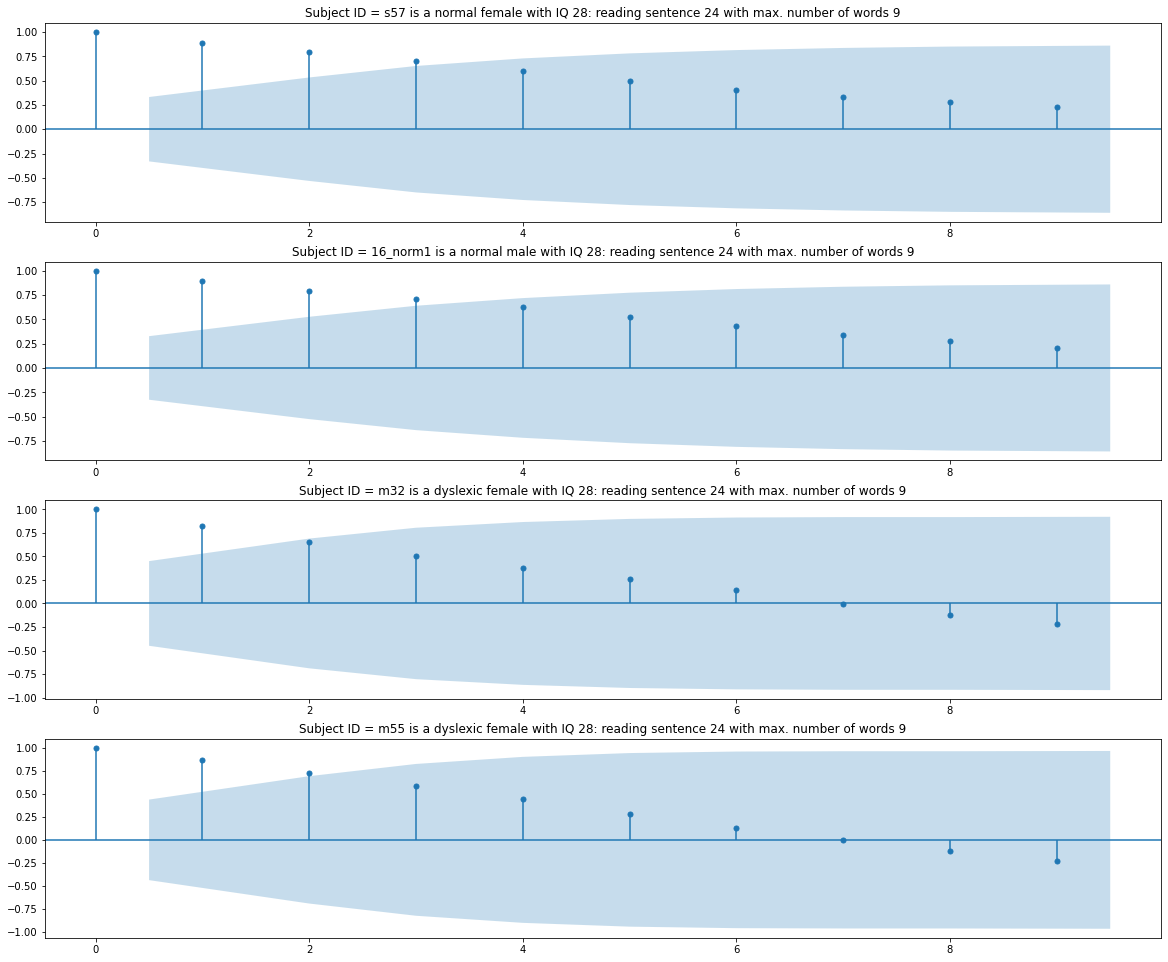

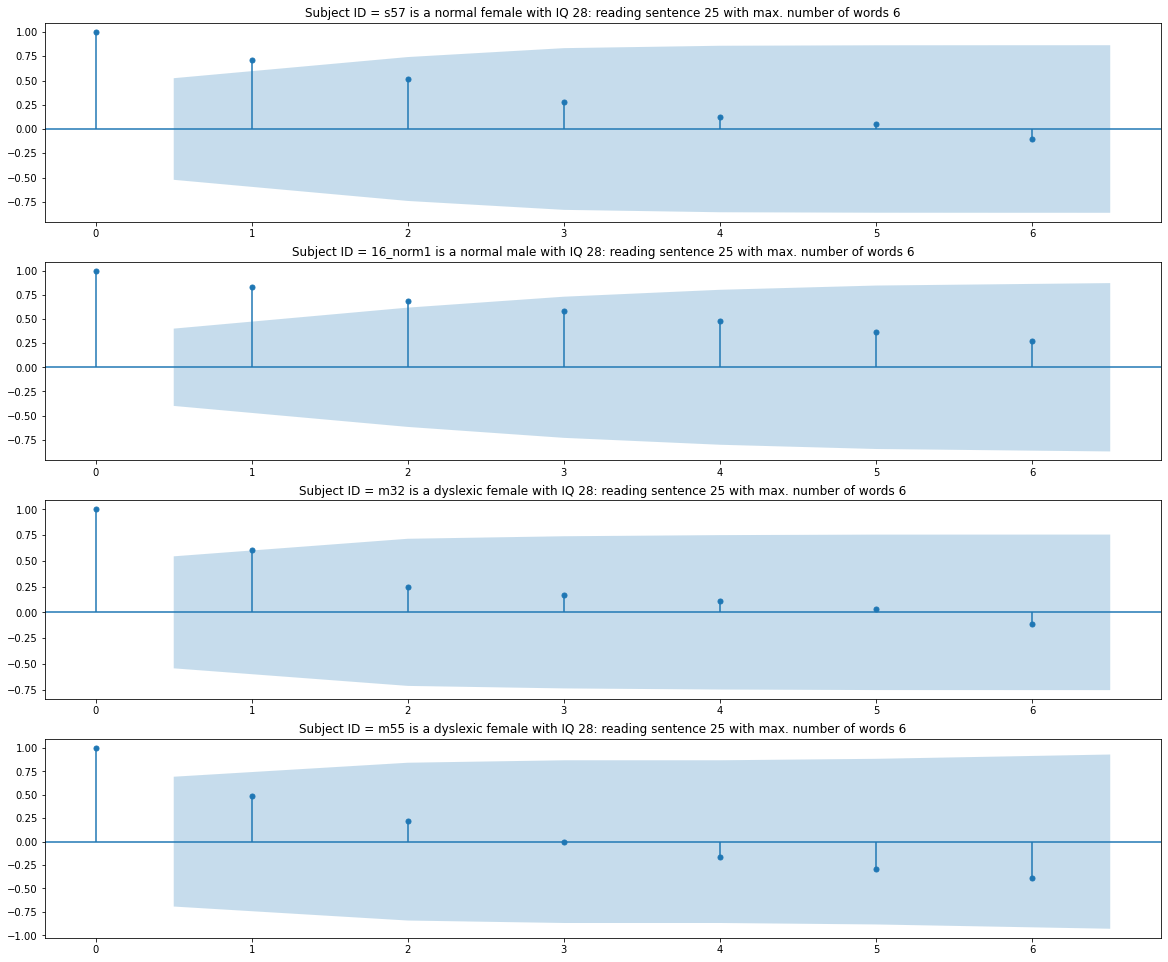

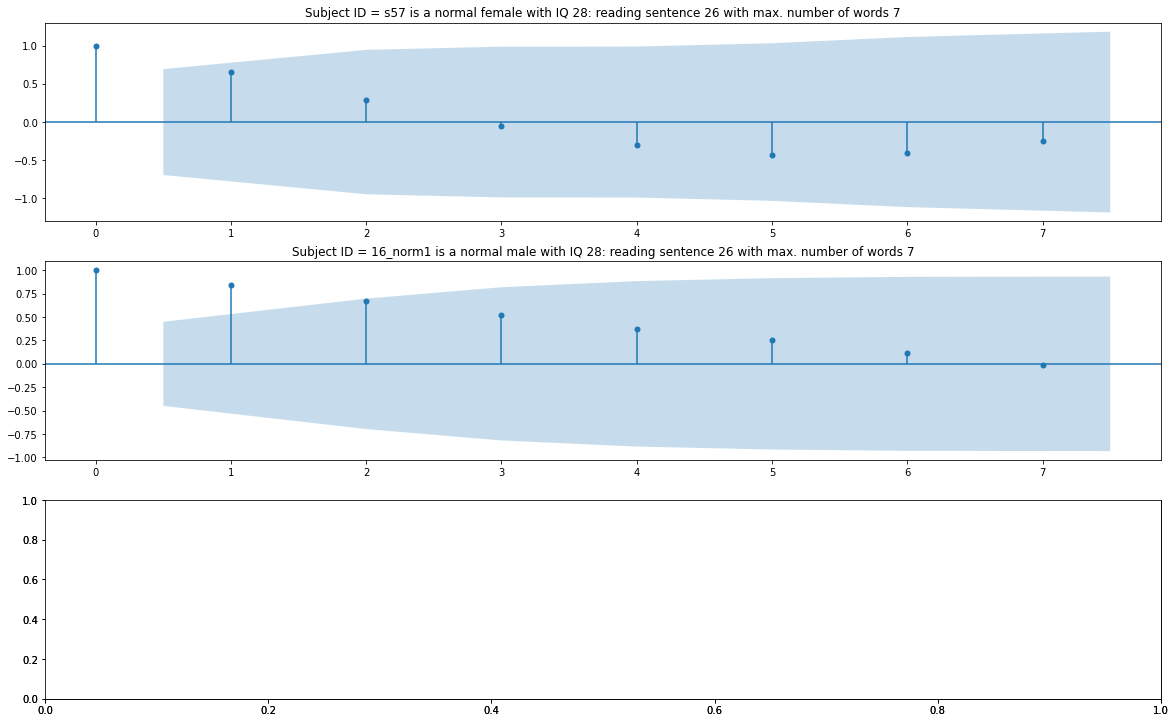

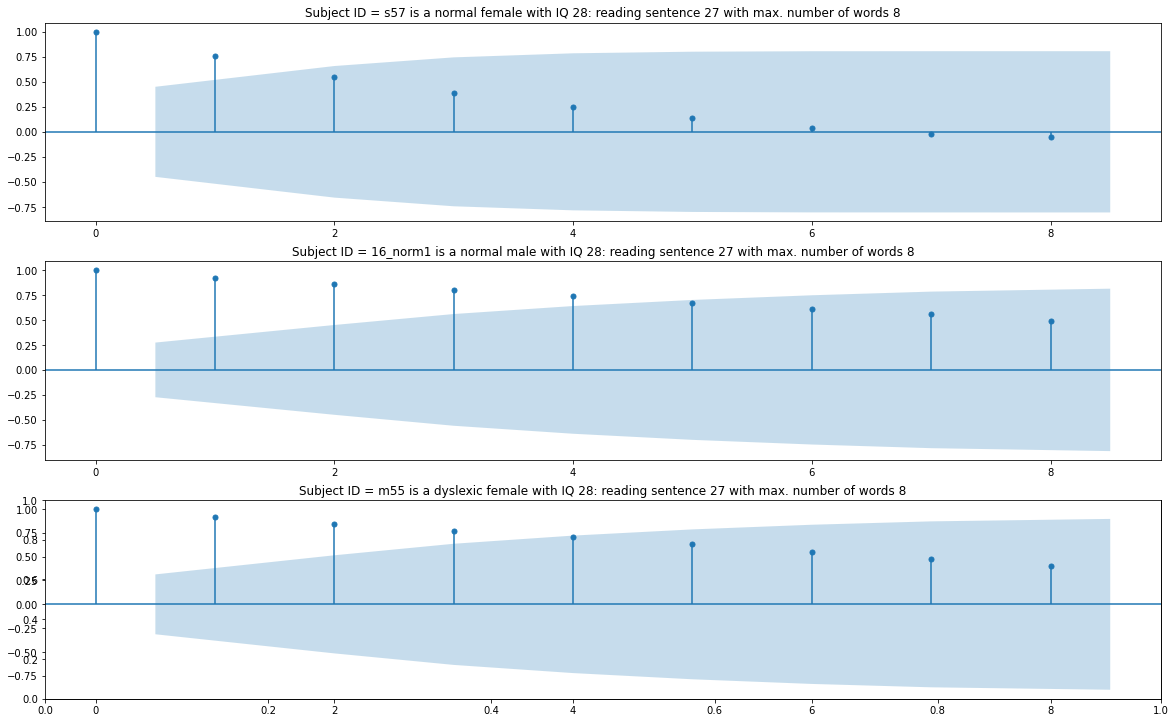

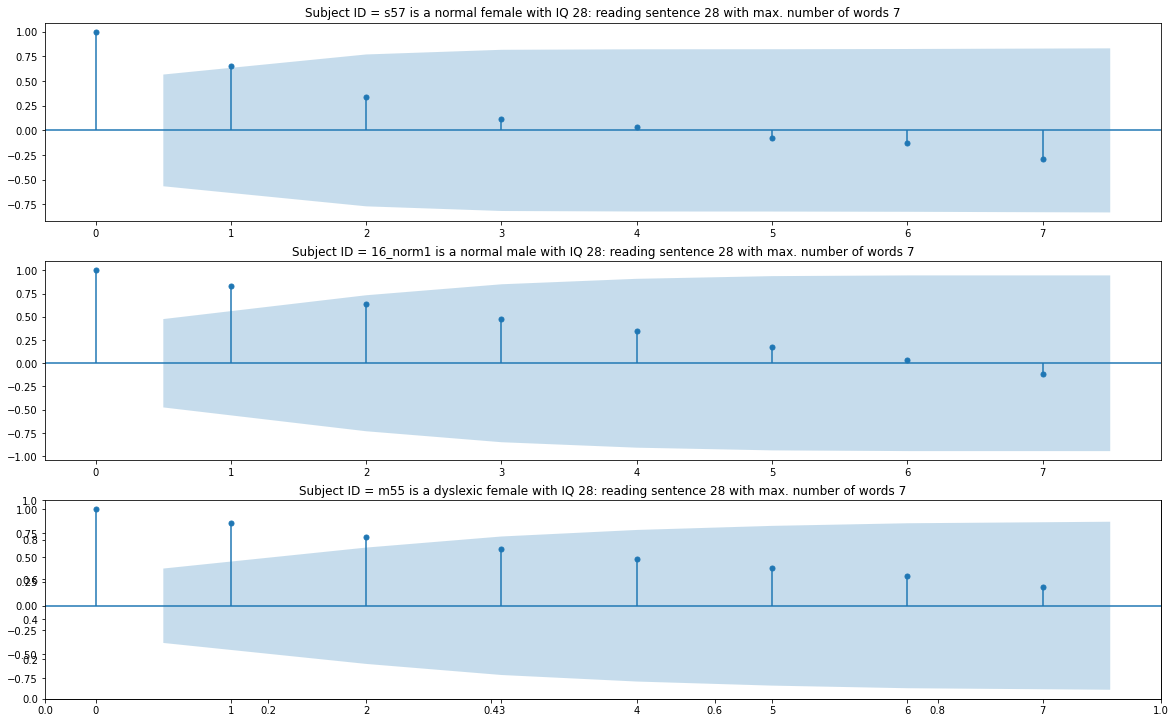

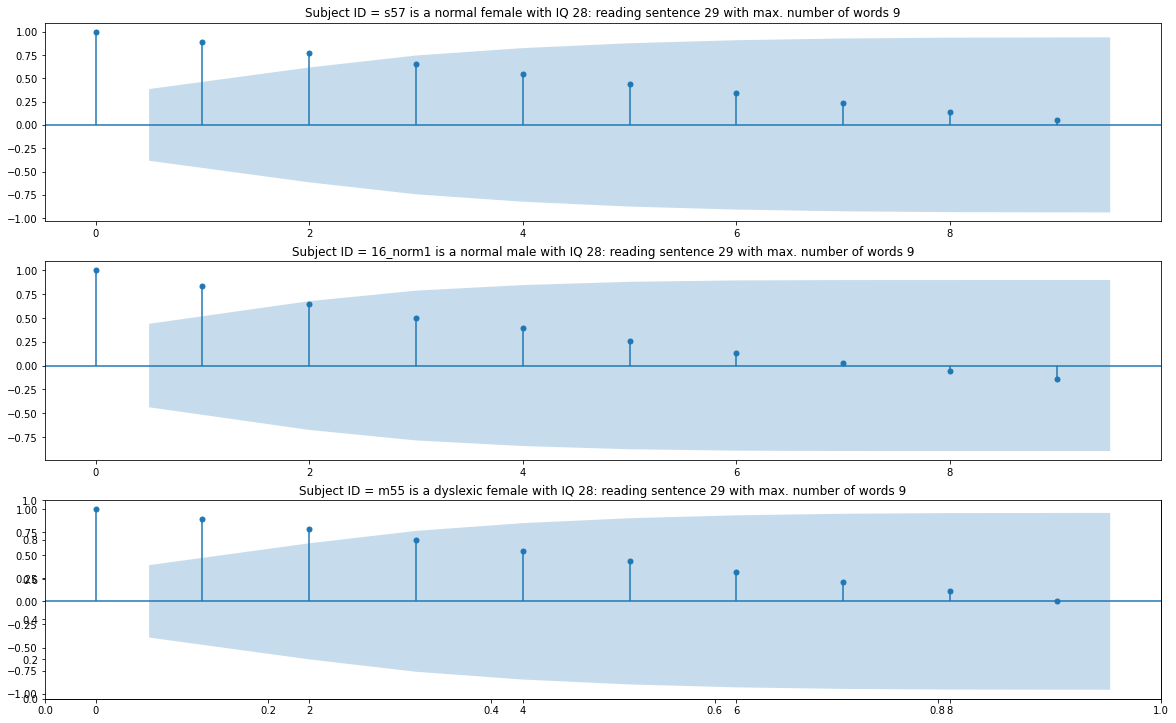

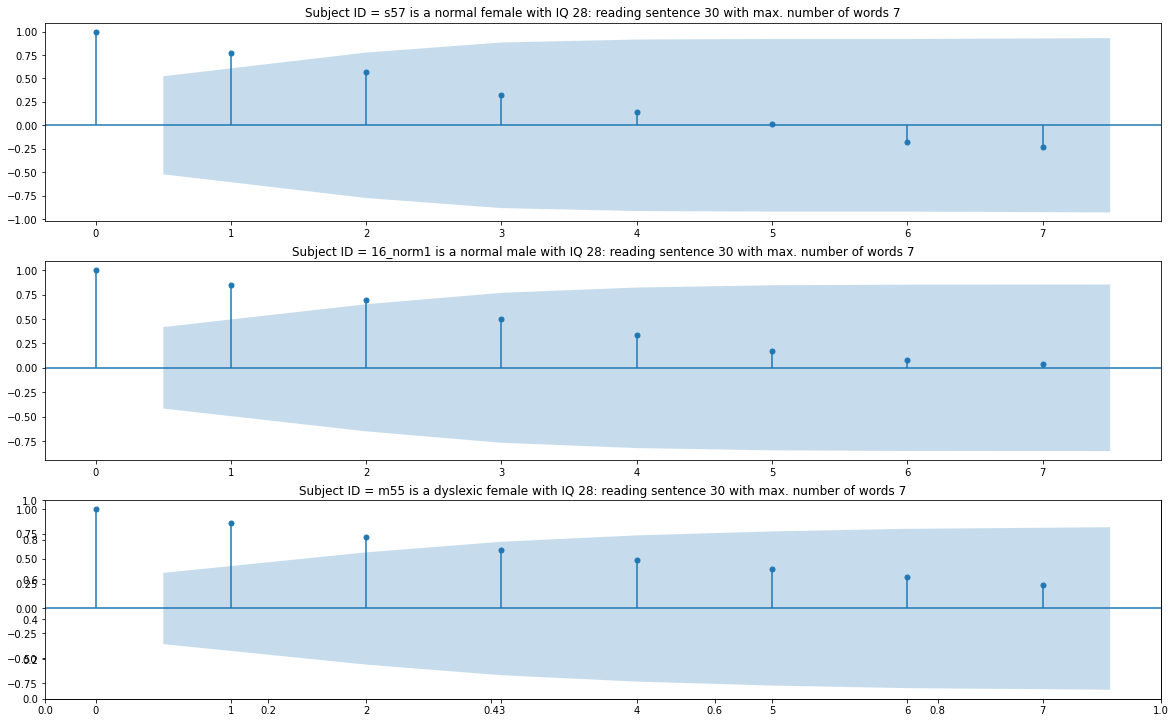

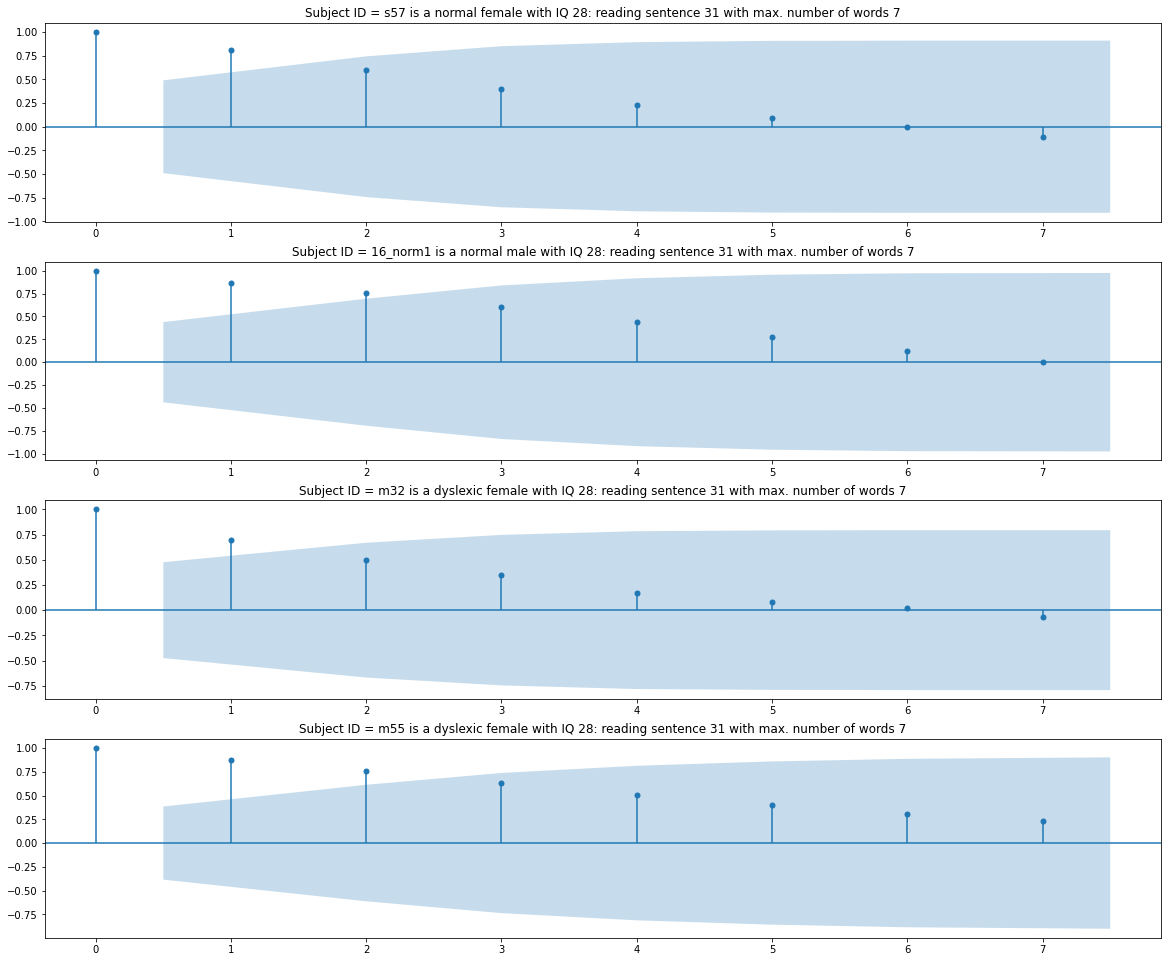

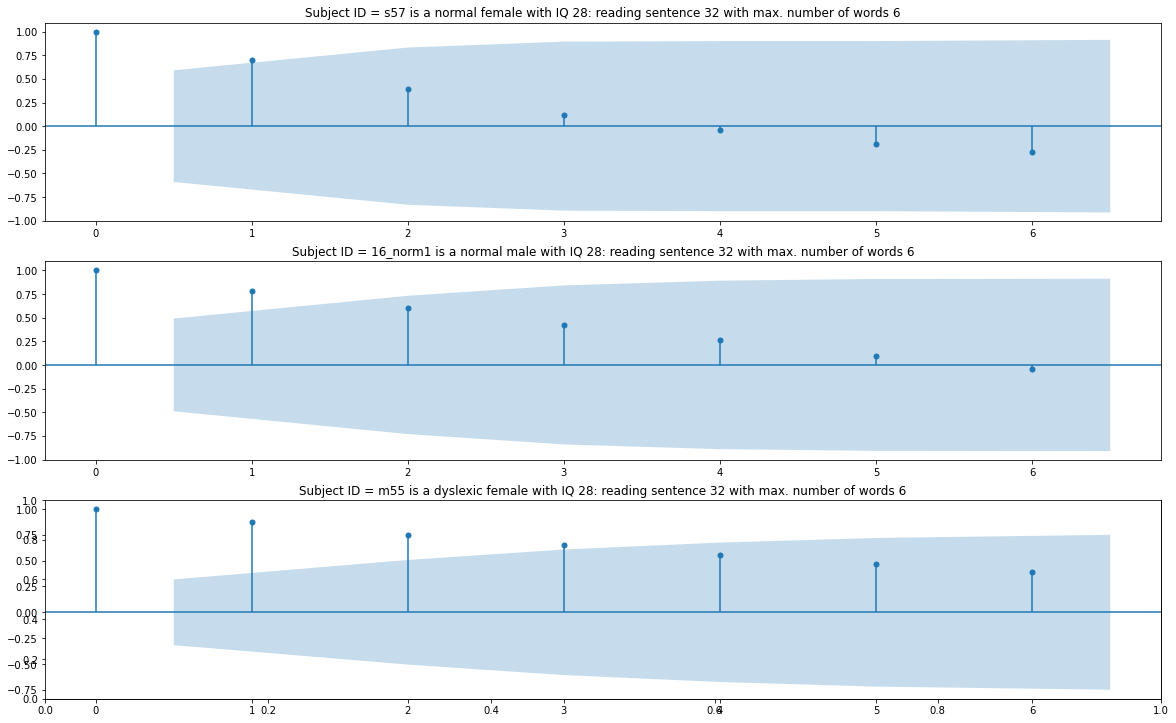

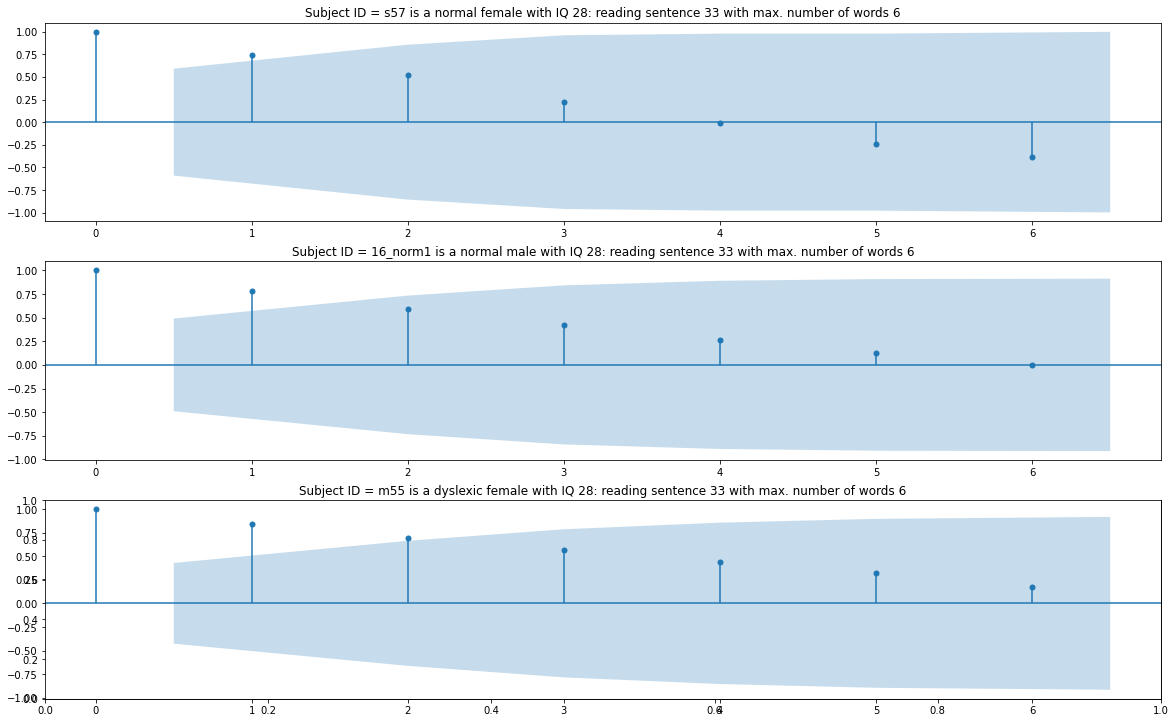

In [29]:

issues = plot_norm_vs_dyslexic_AFC(data_n=n2, data_d=d2, feature="FIX_X", )



FIX_Y


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
invalid value encountered in true_divide


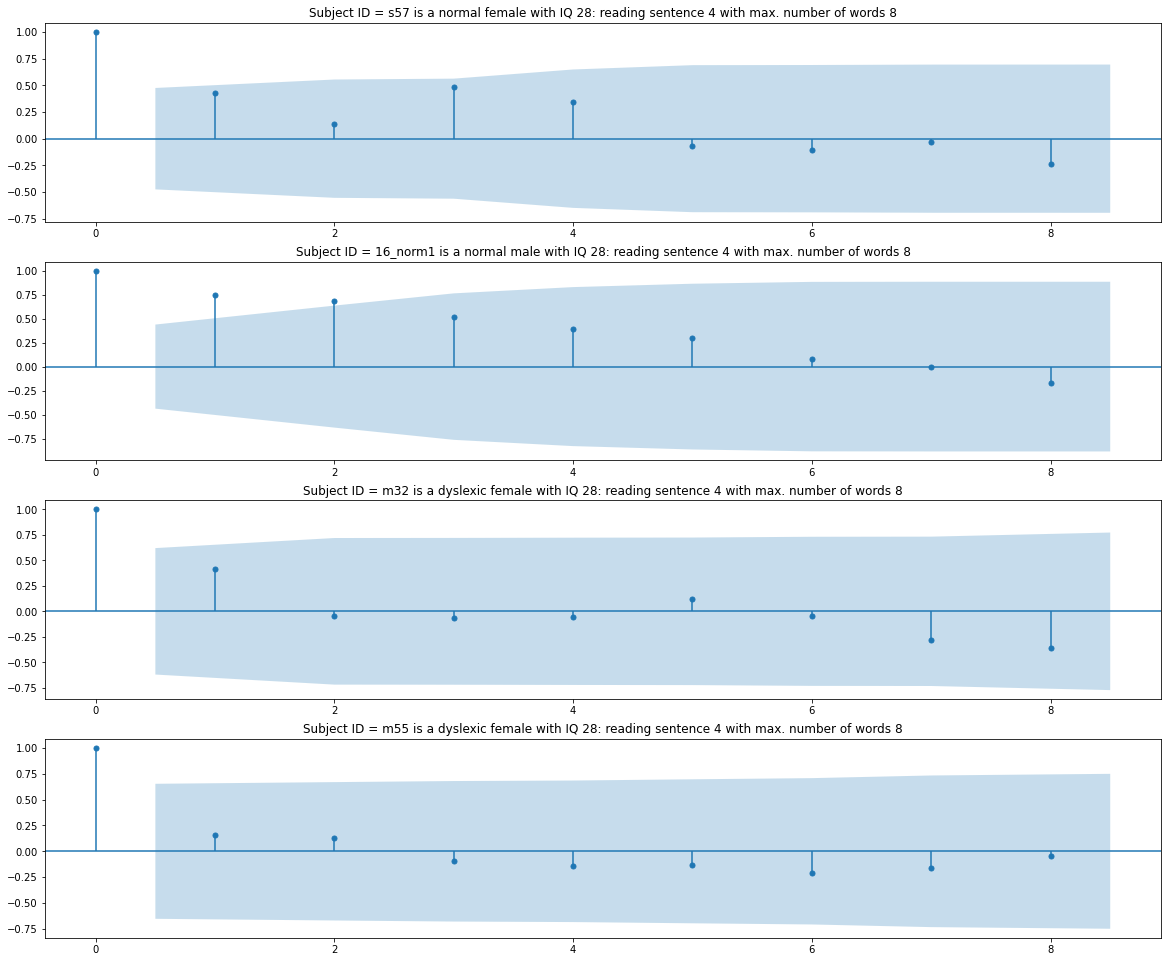

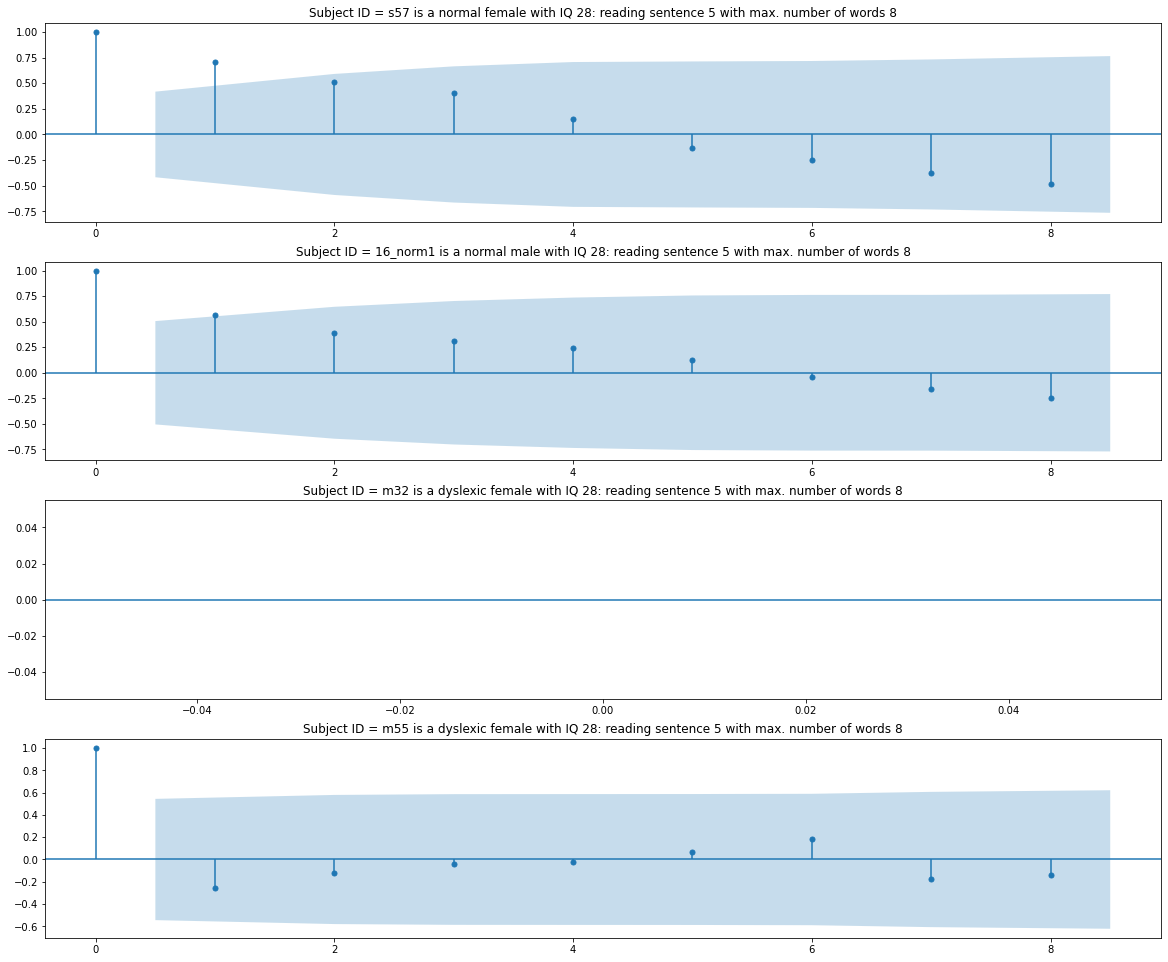

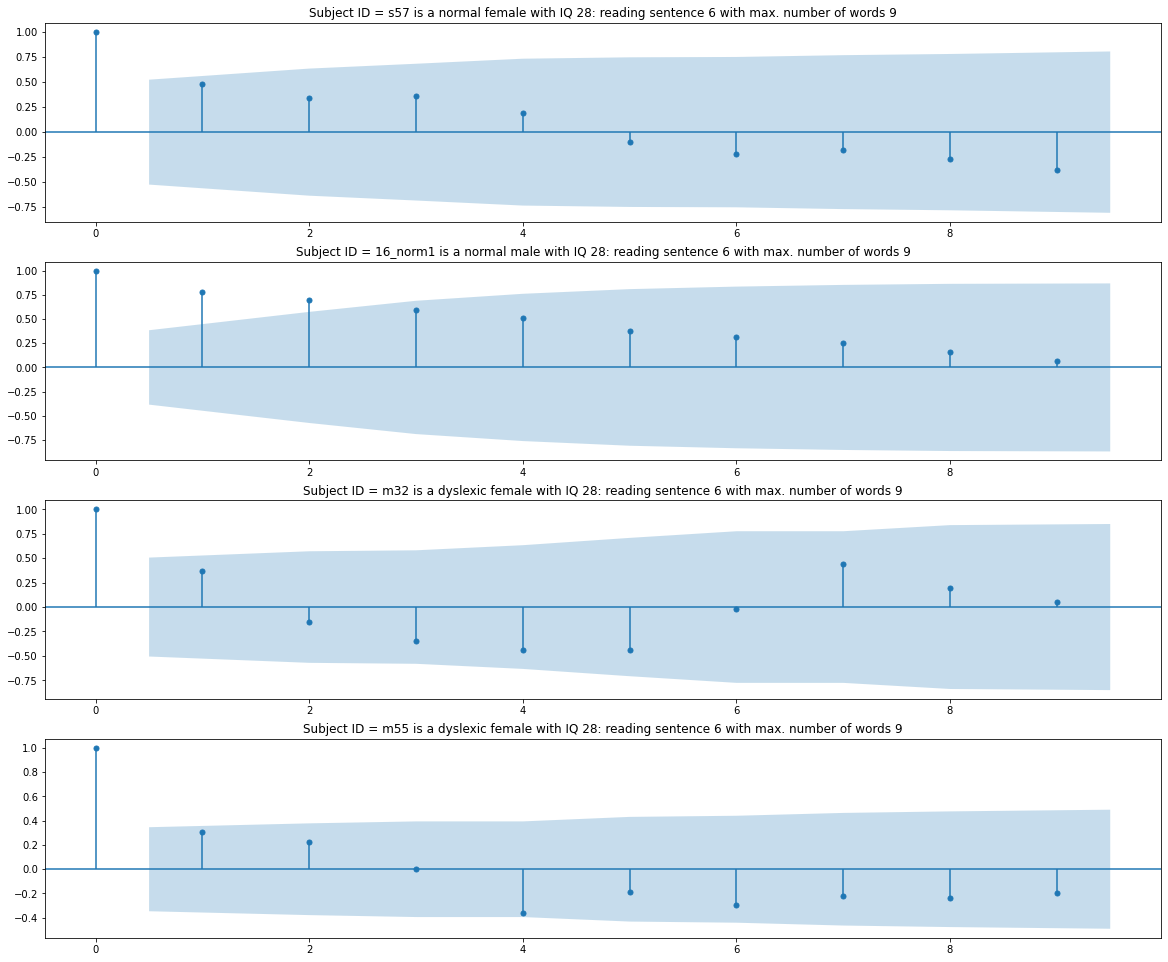

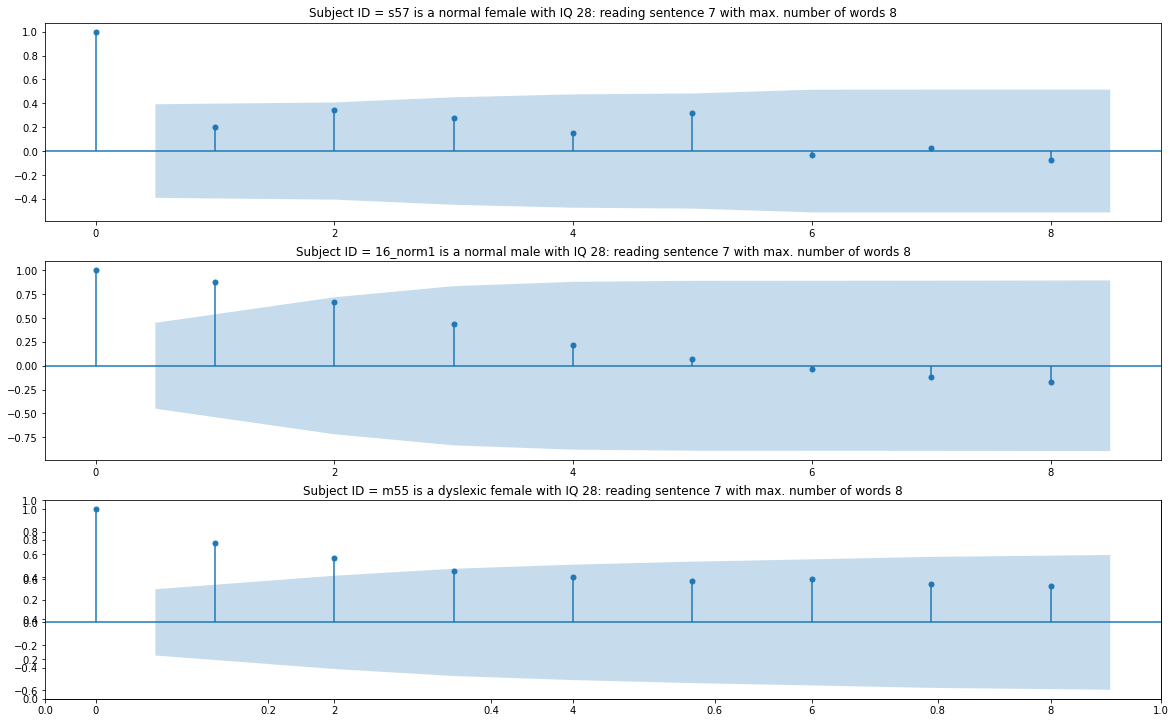

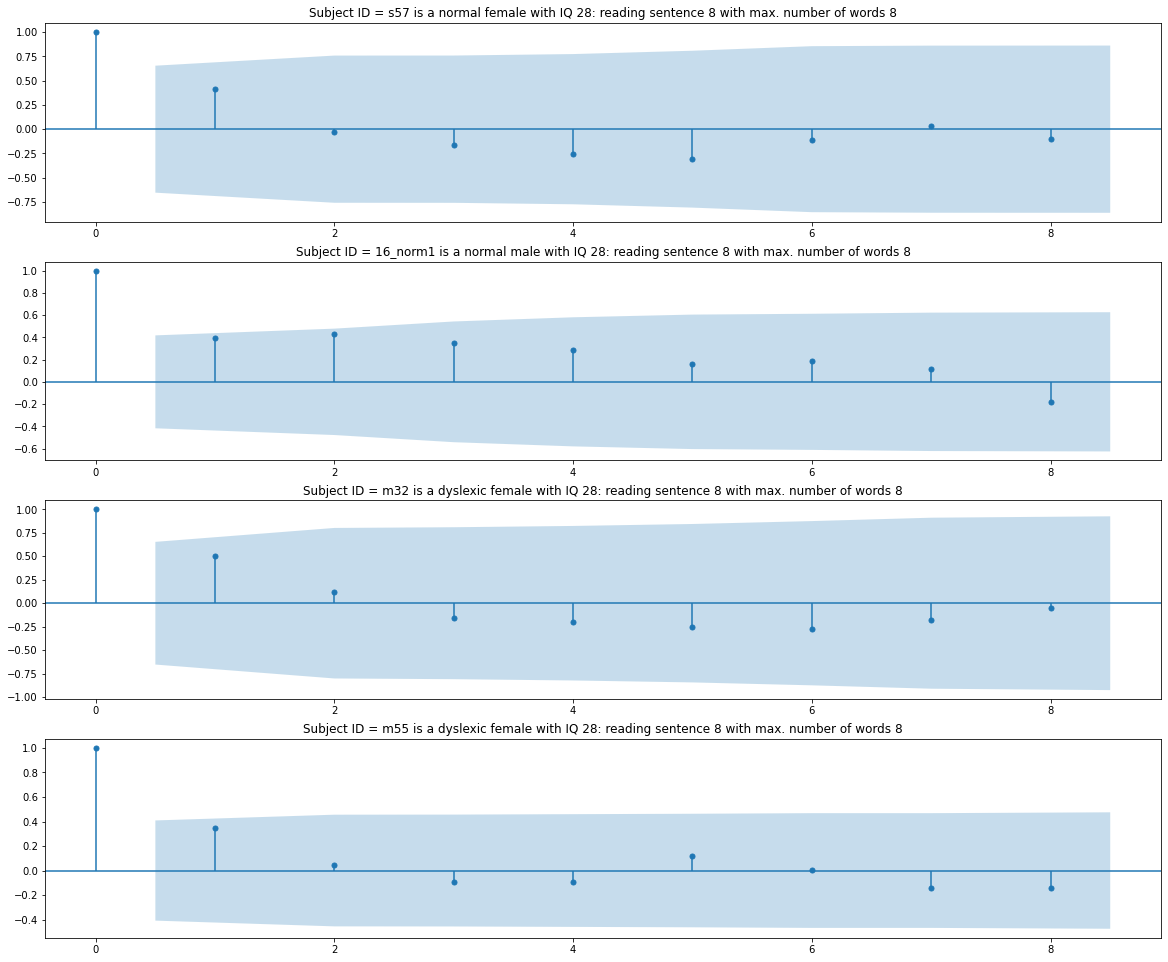

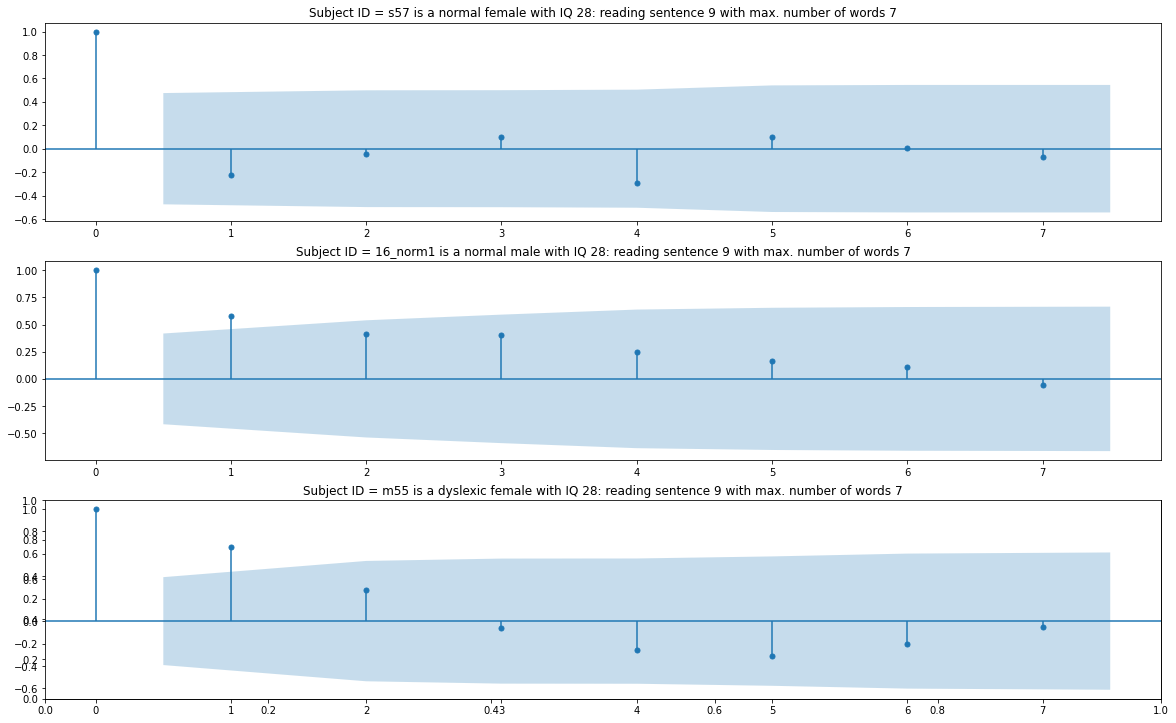

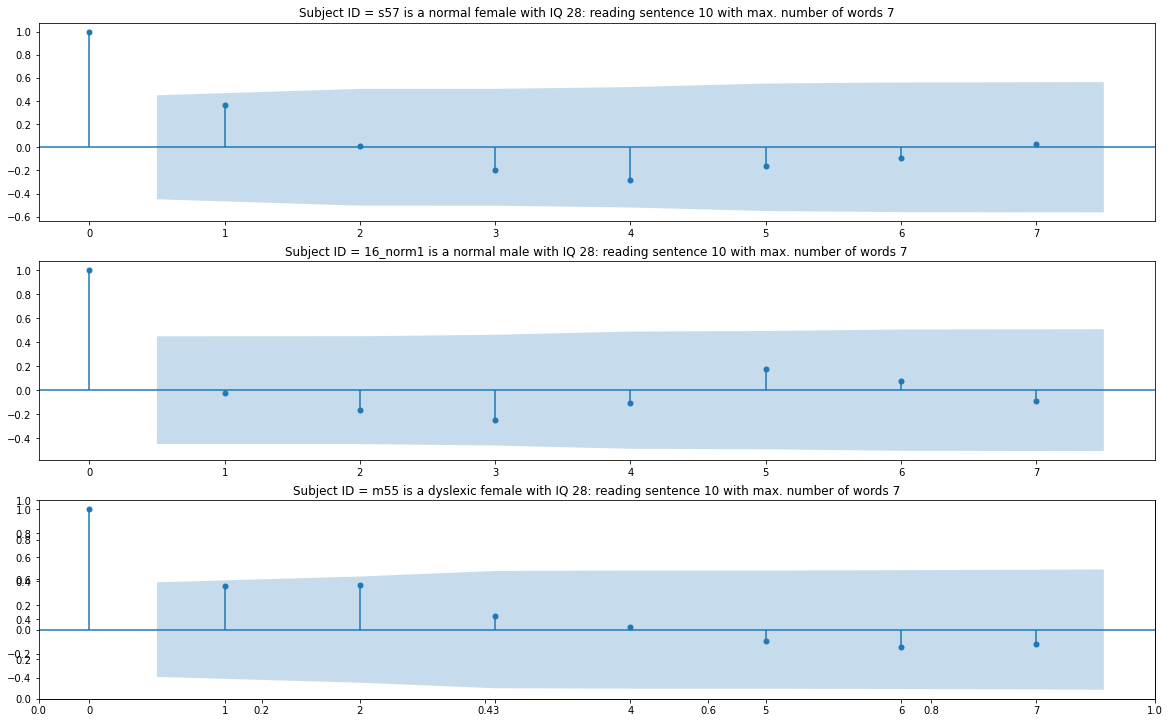

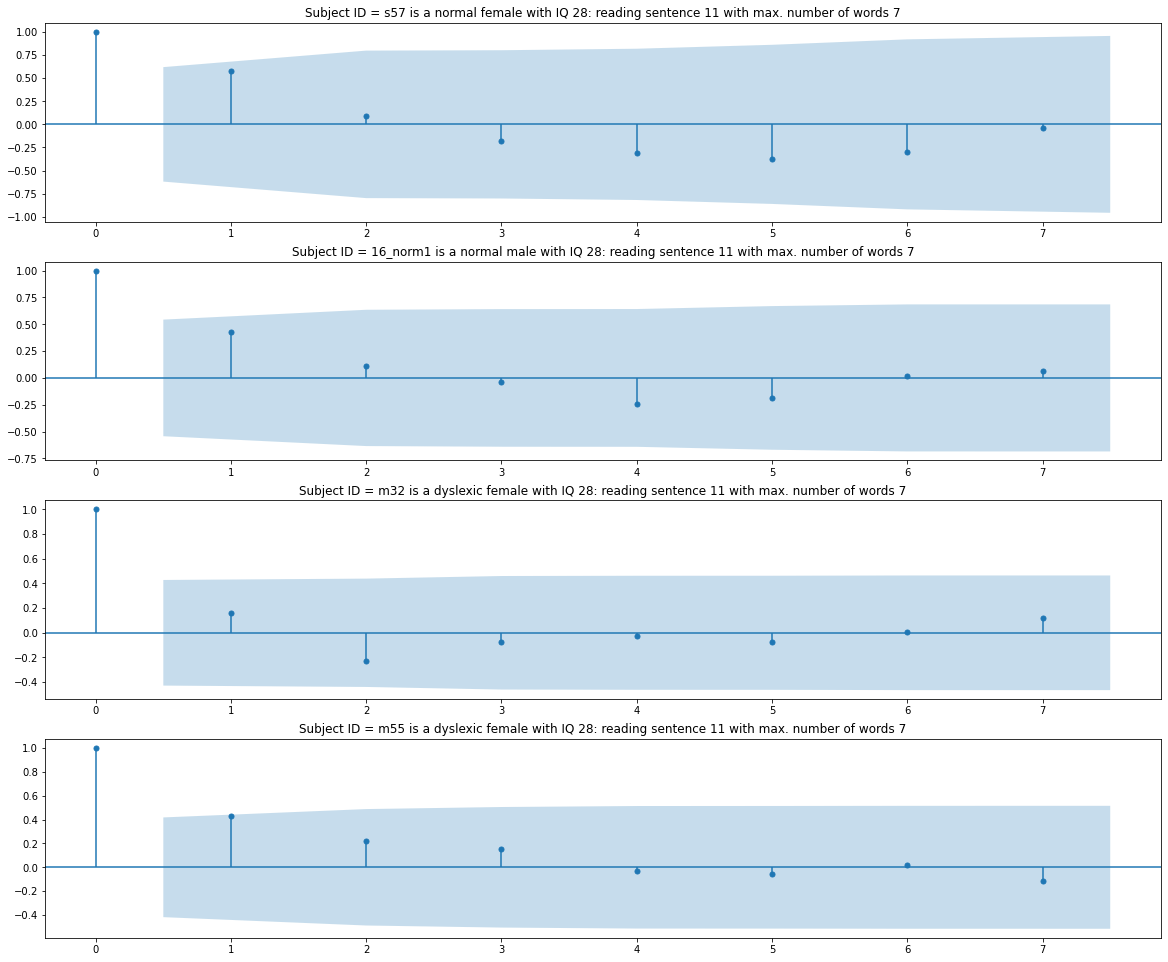

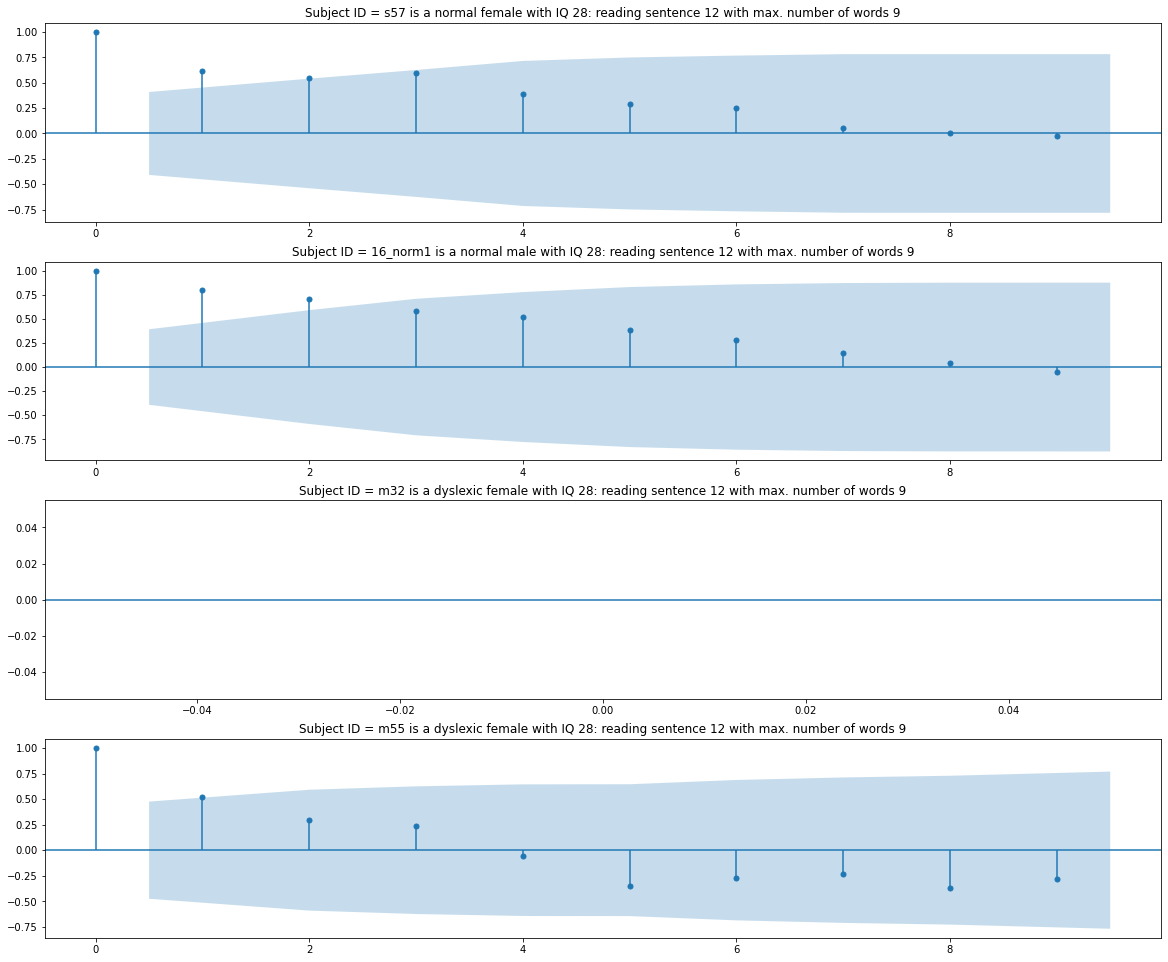

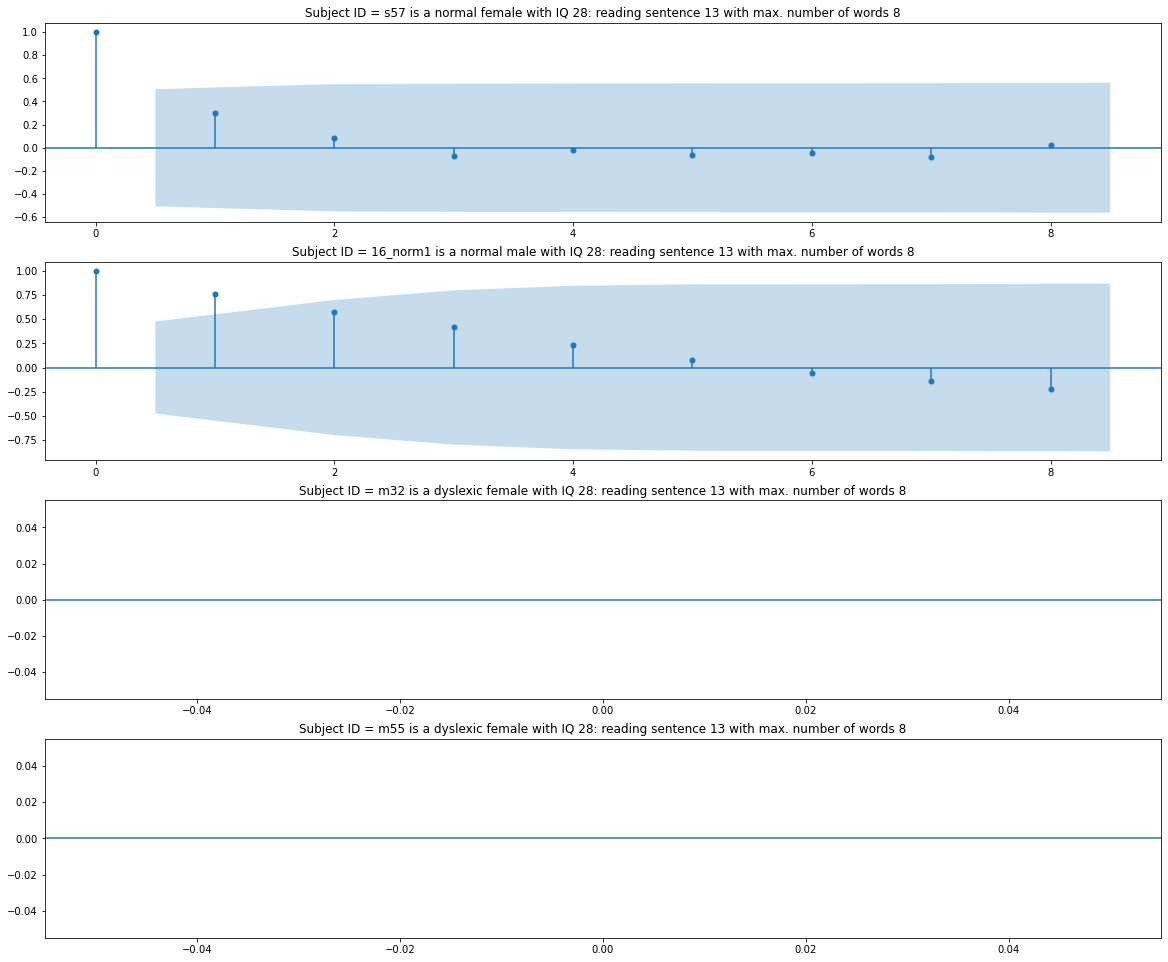

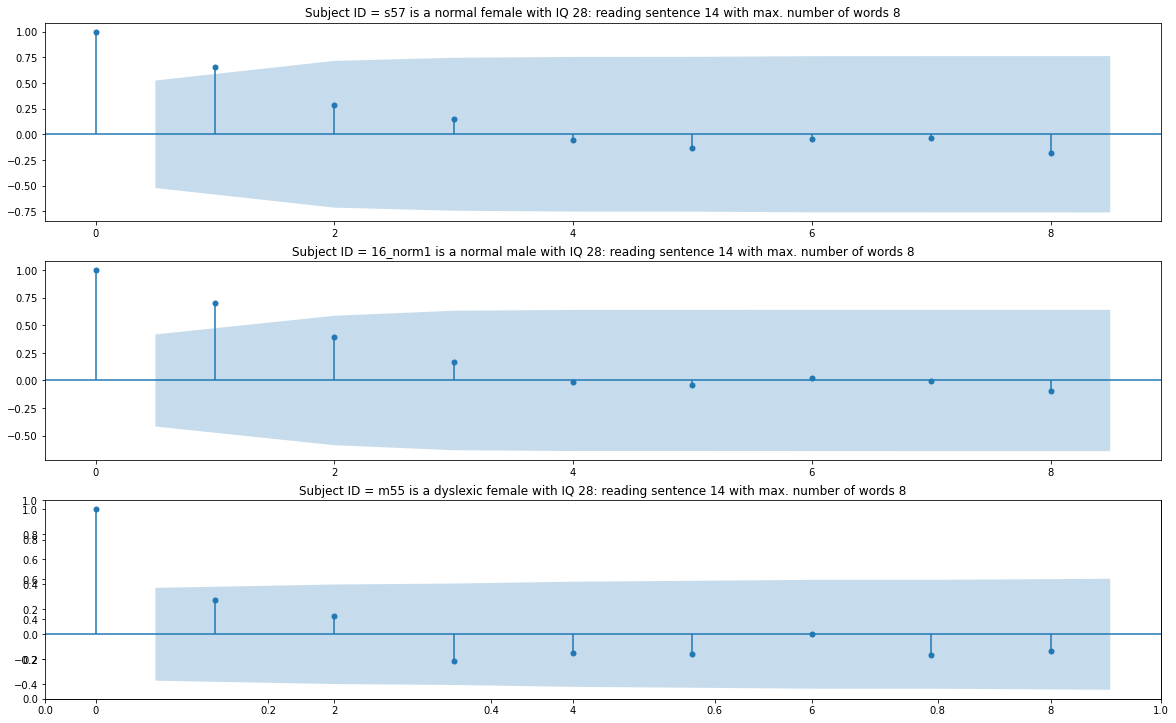

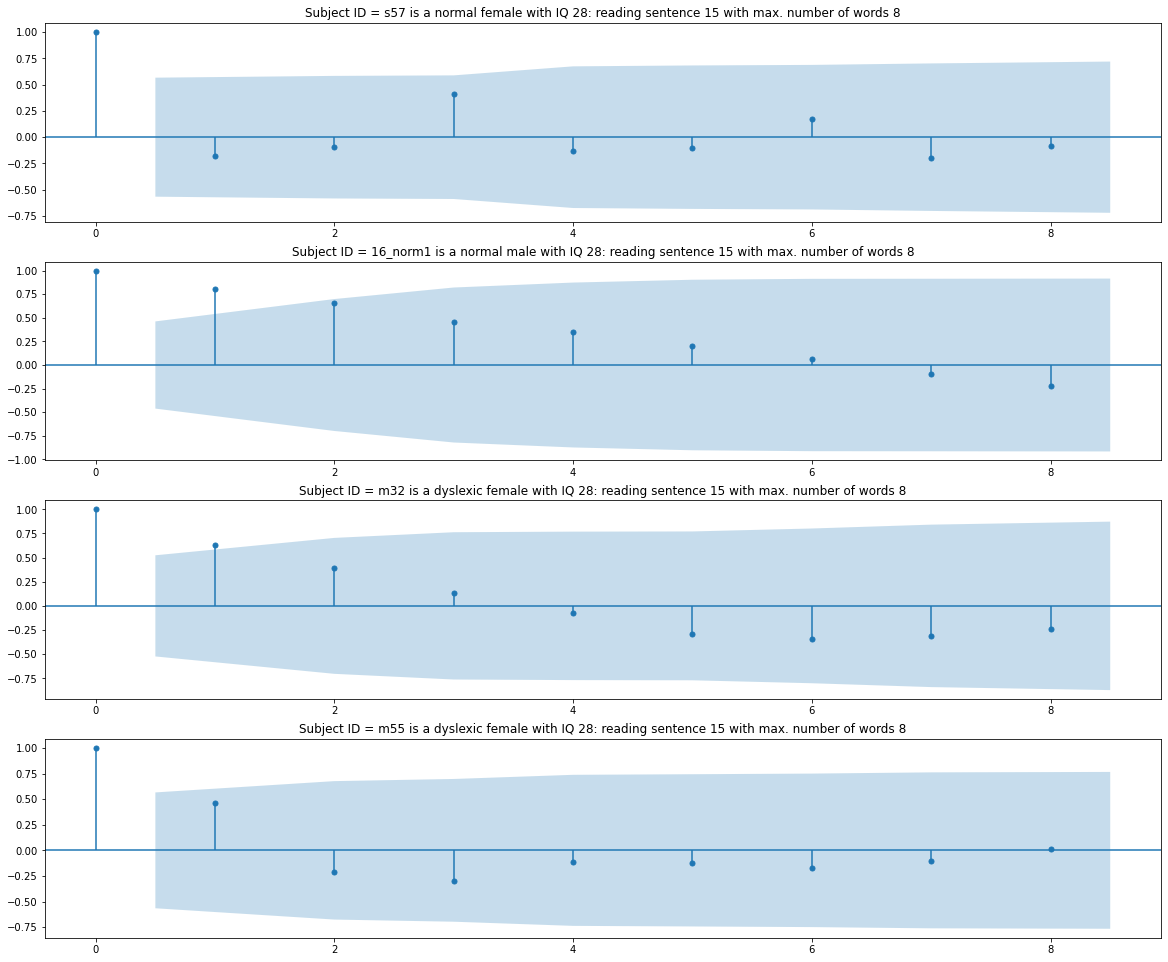

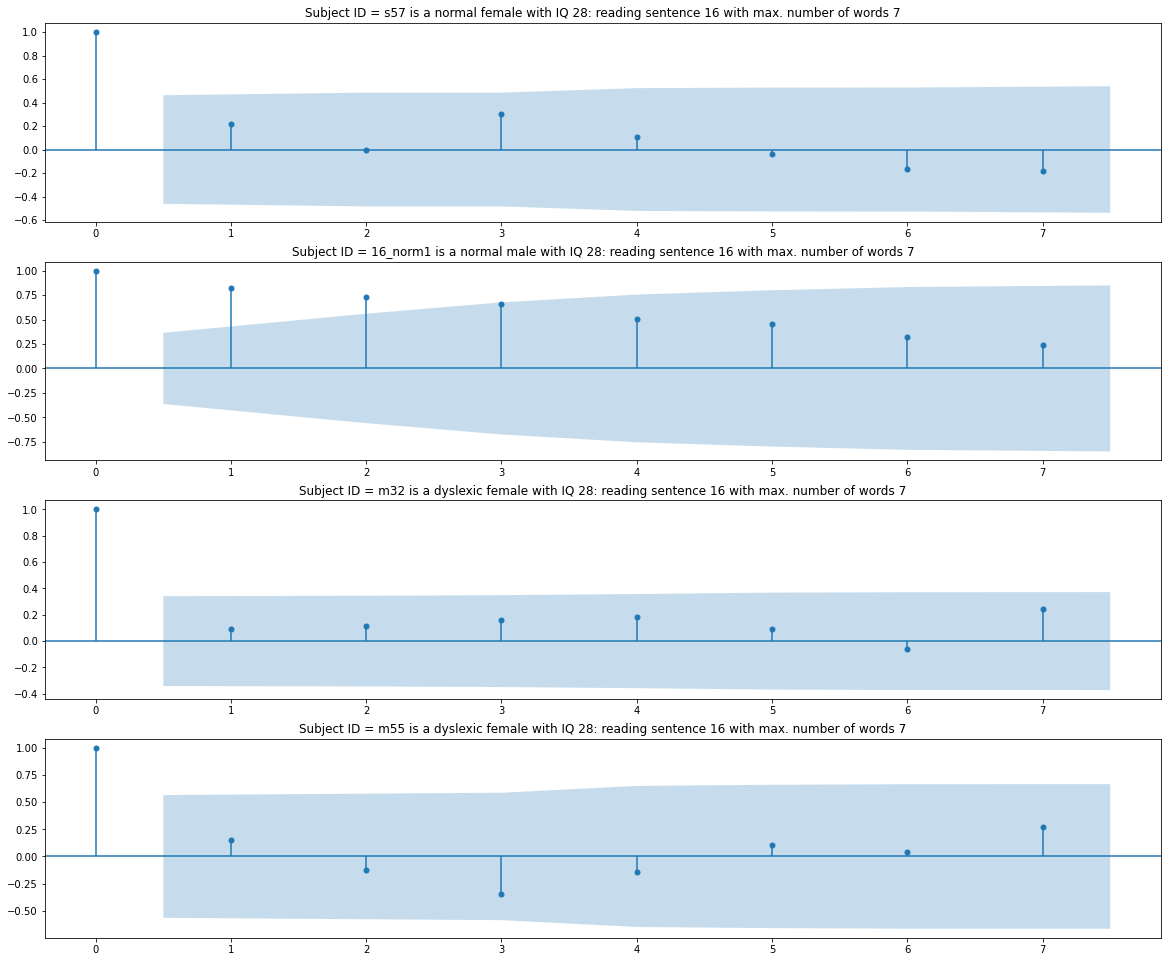

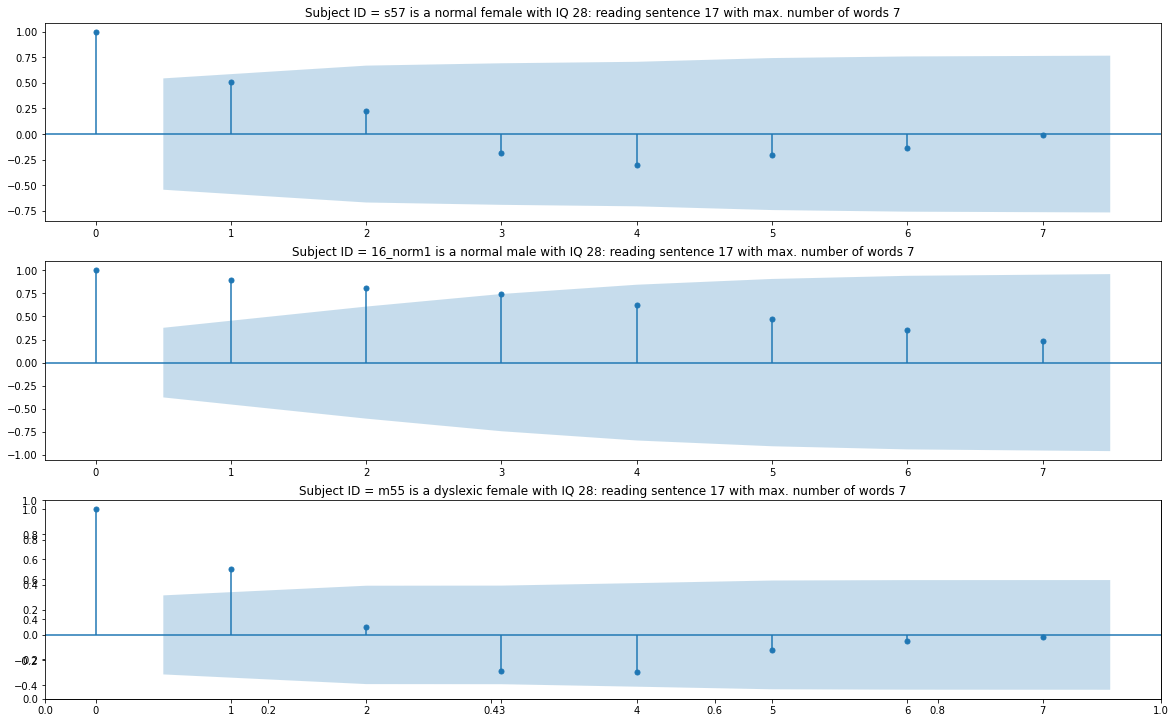

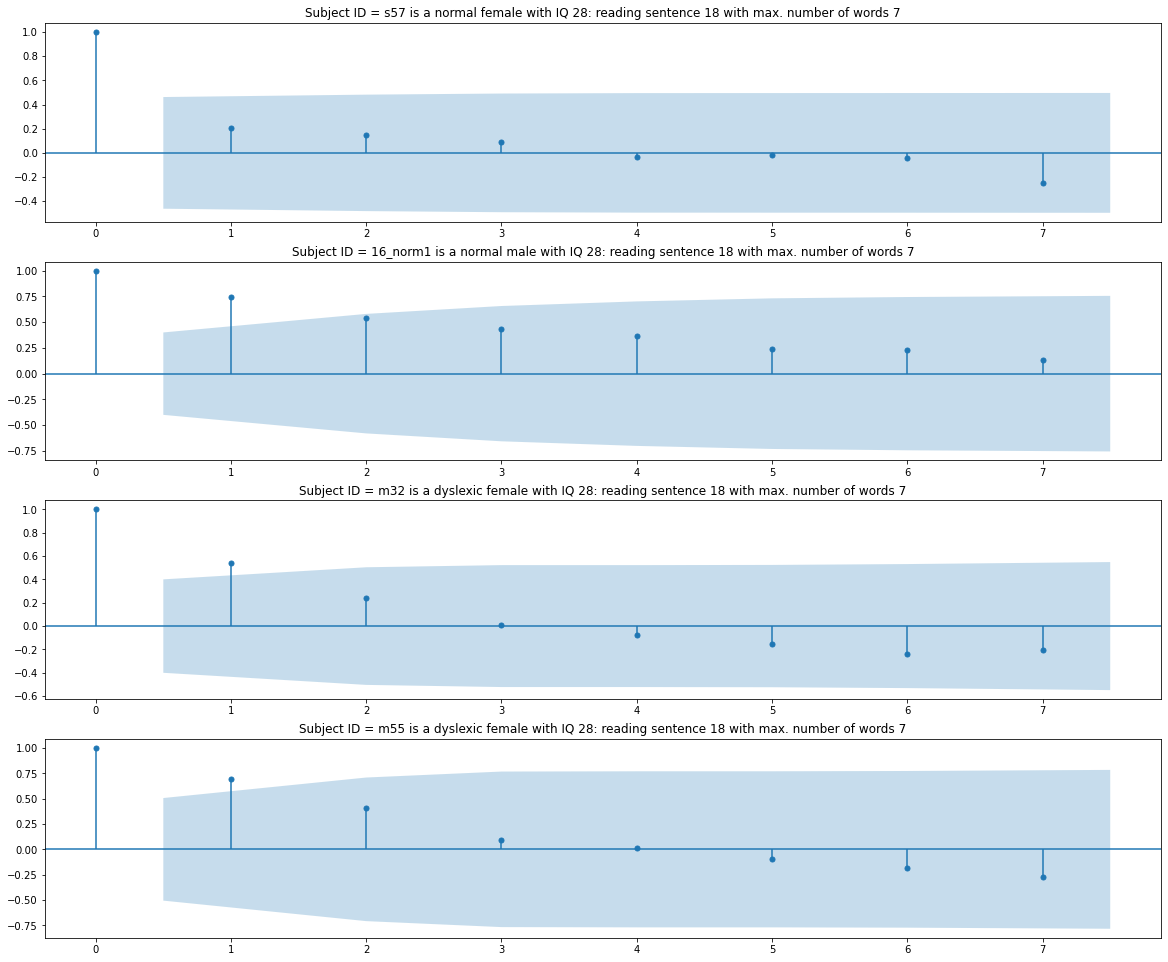

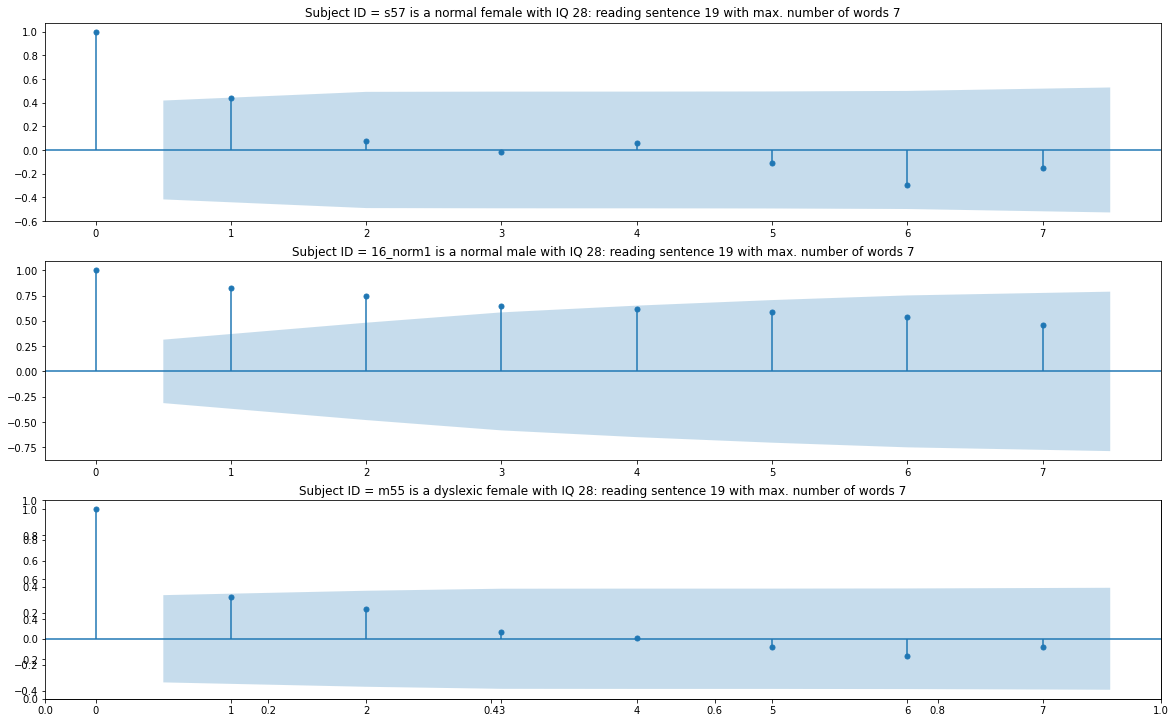

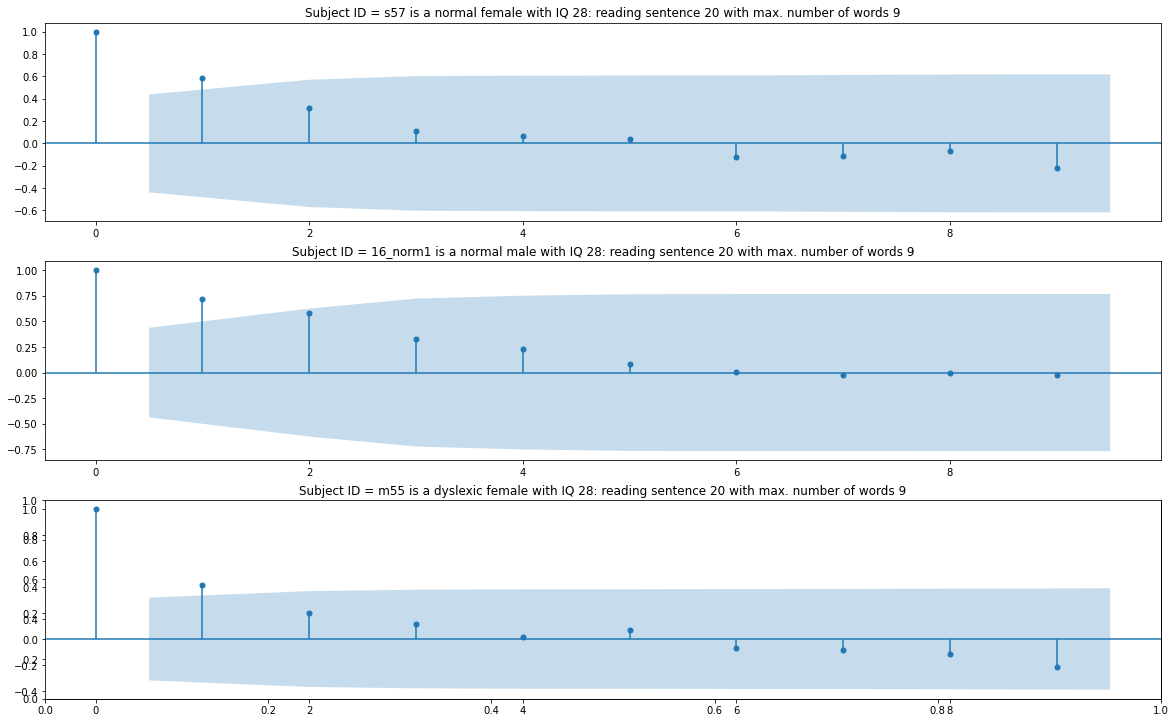

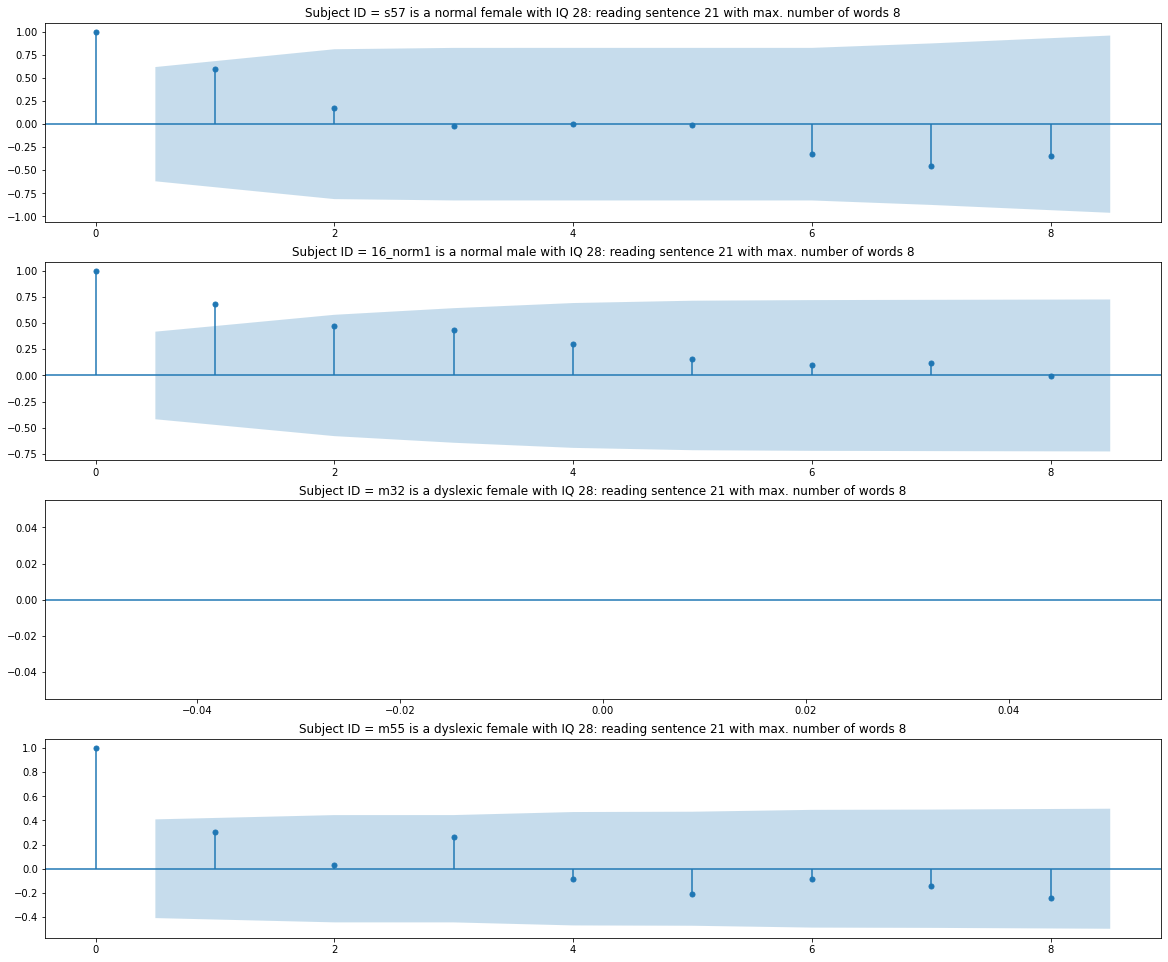

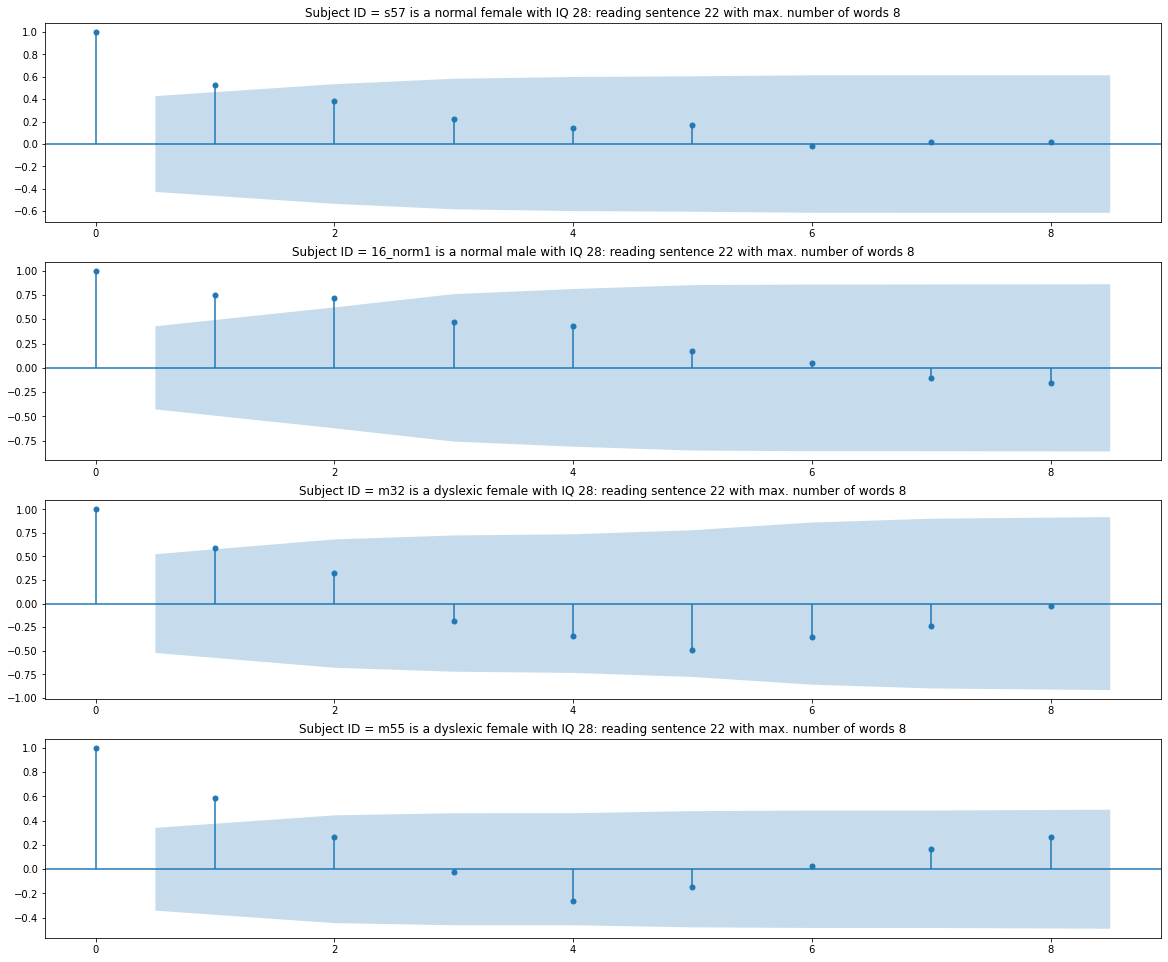

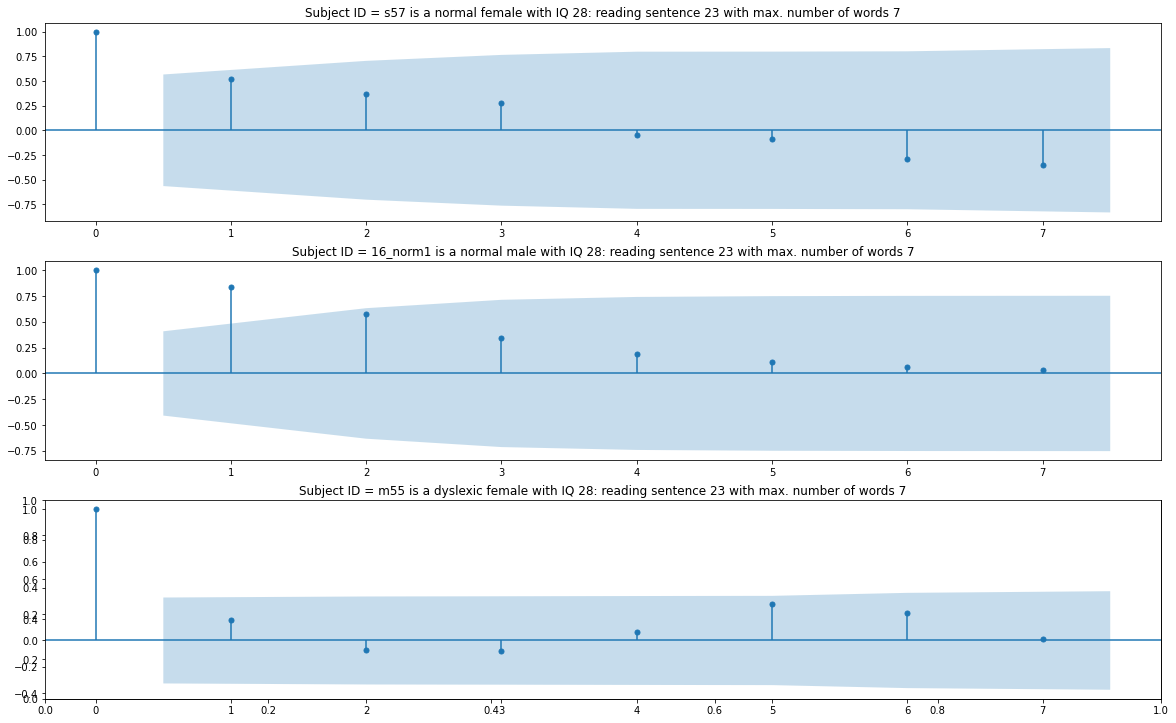

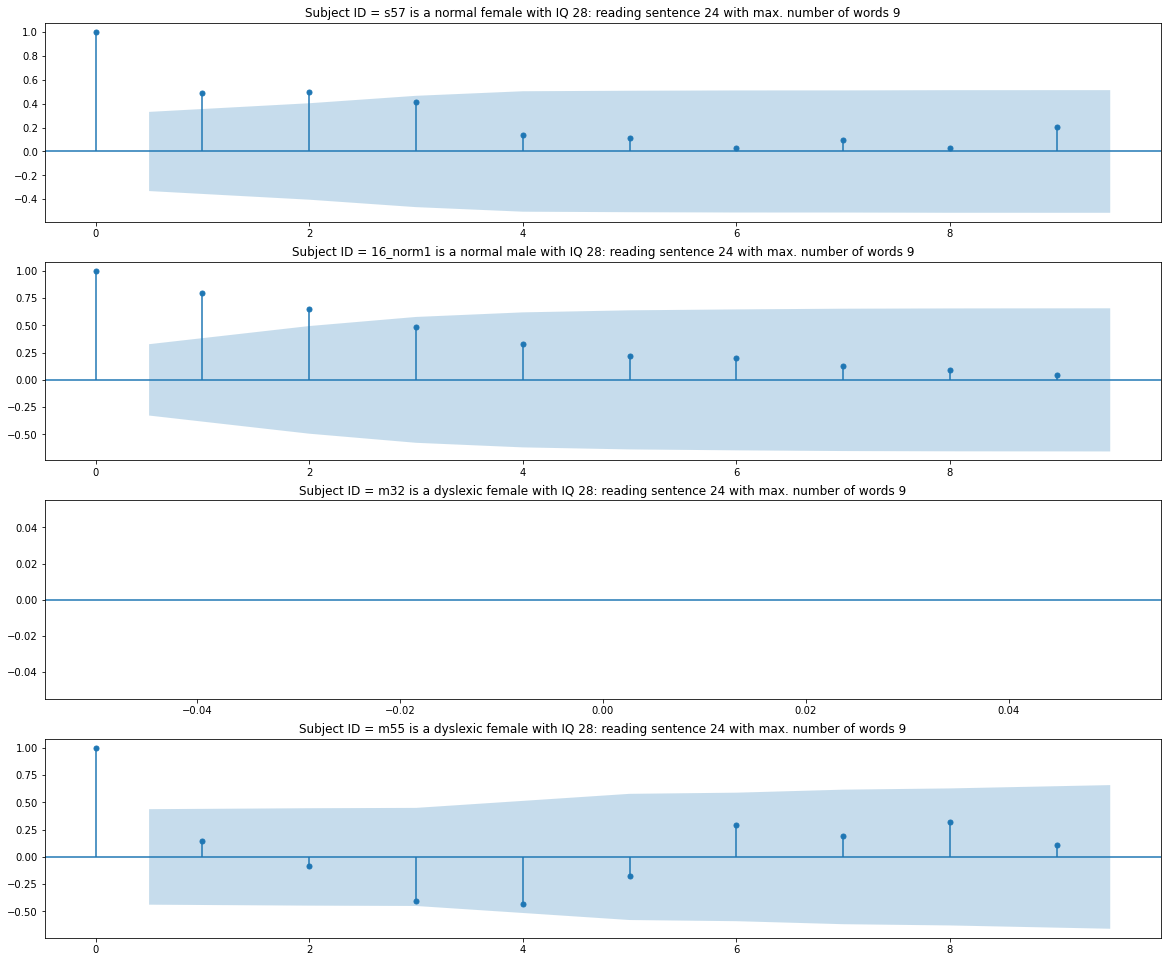

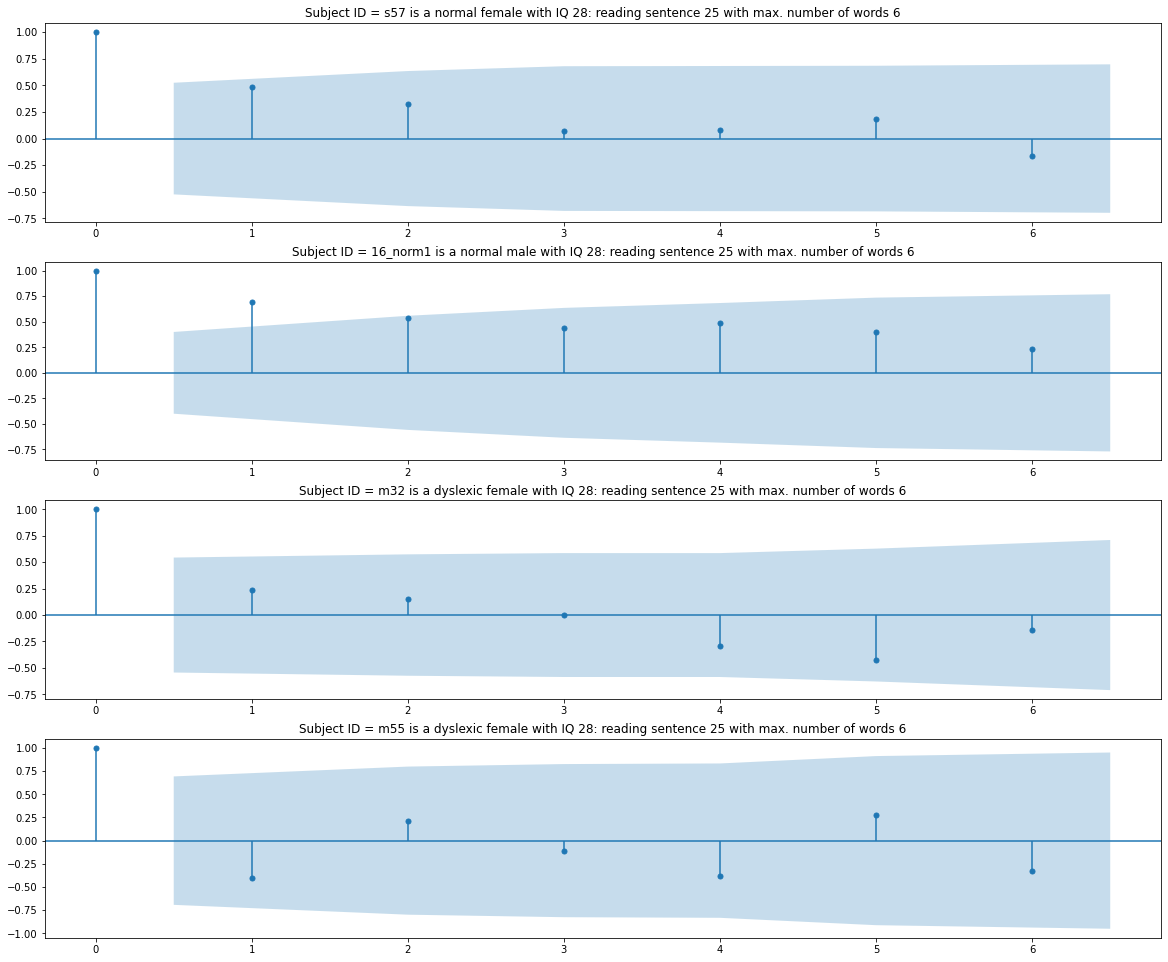

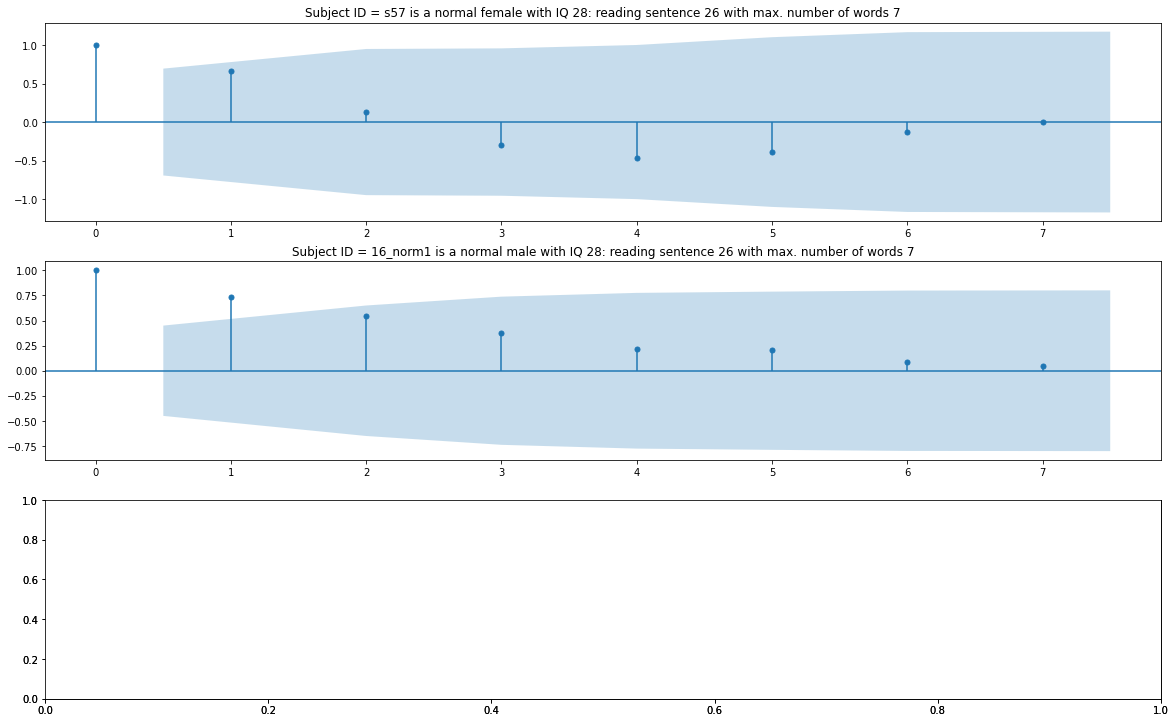

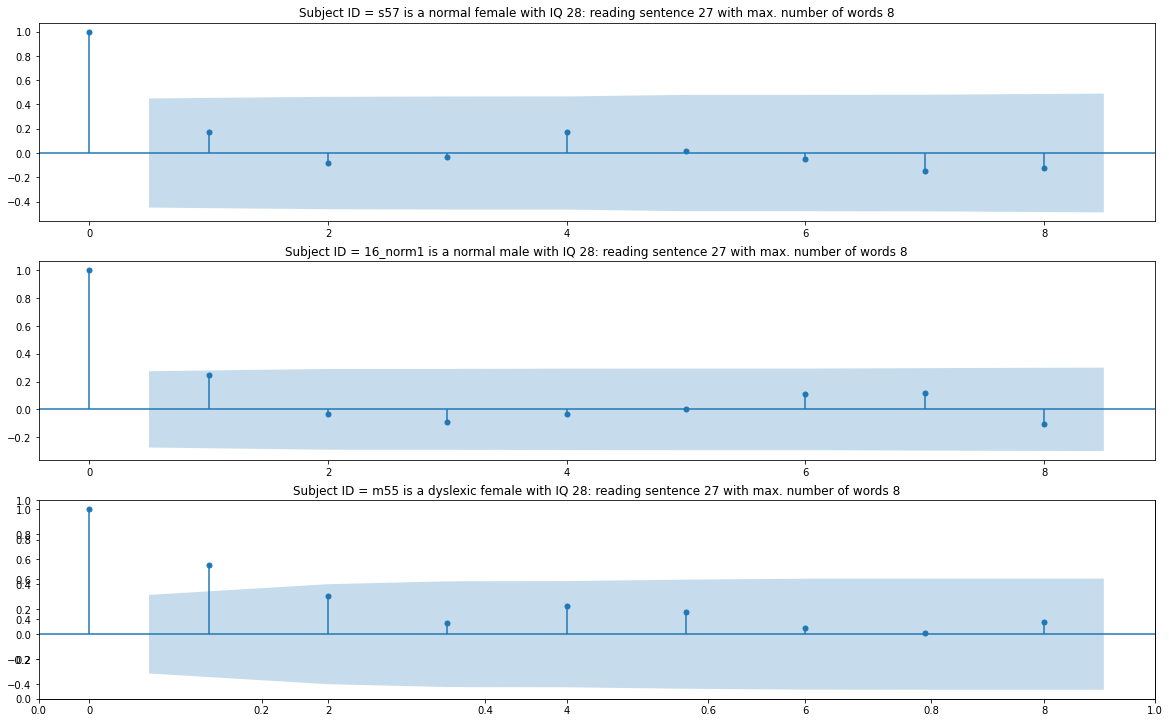

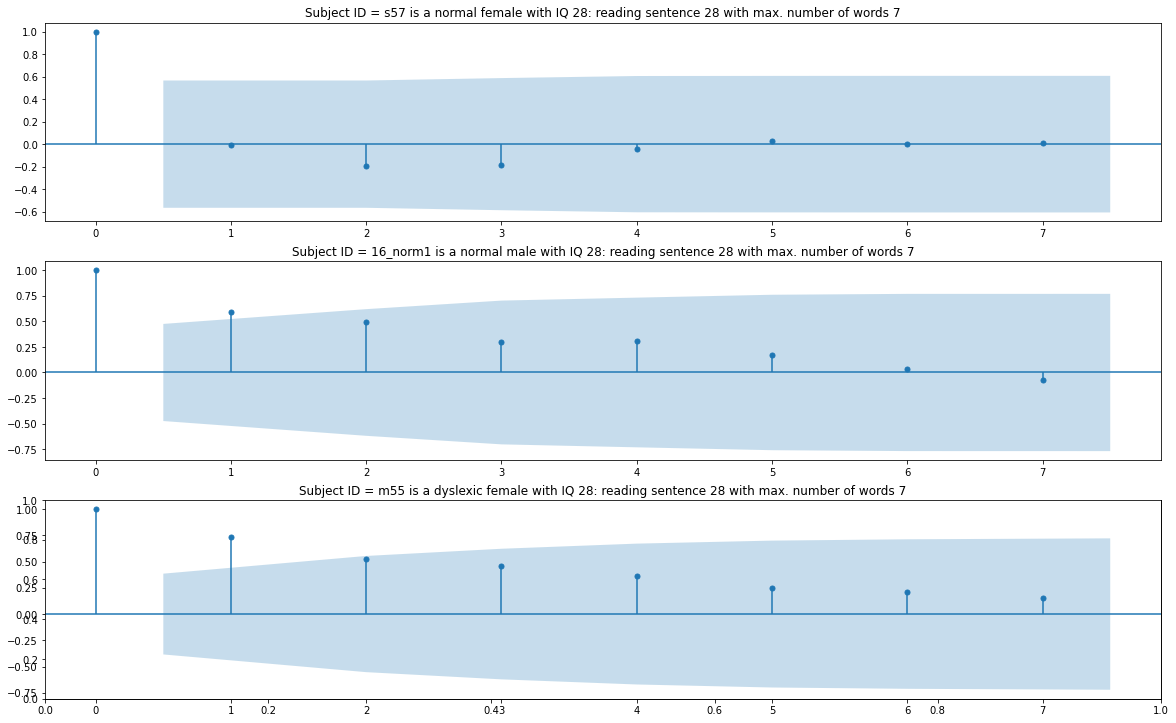

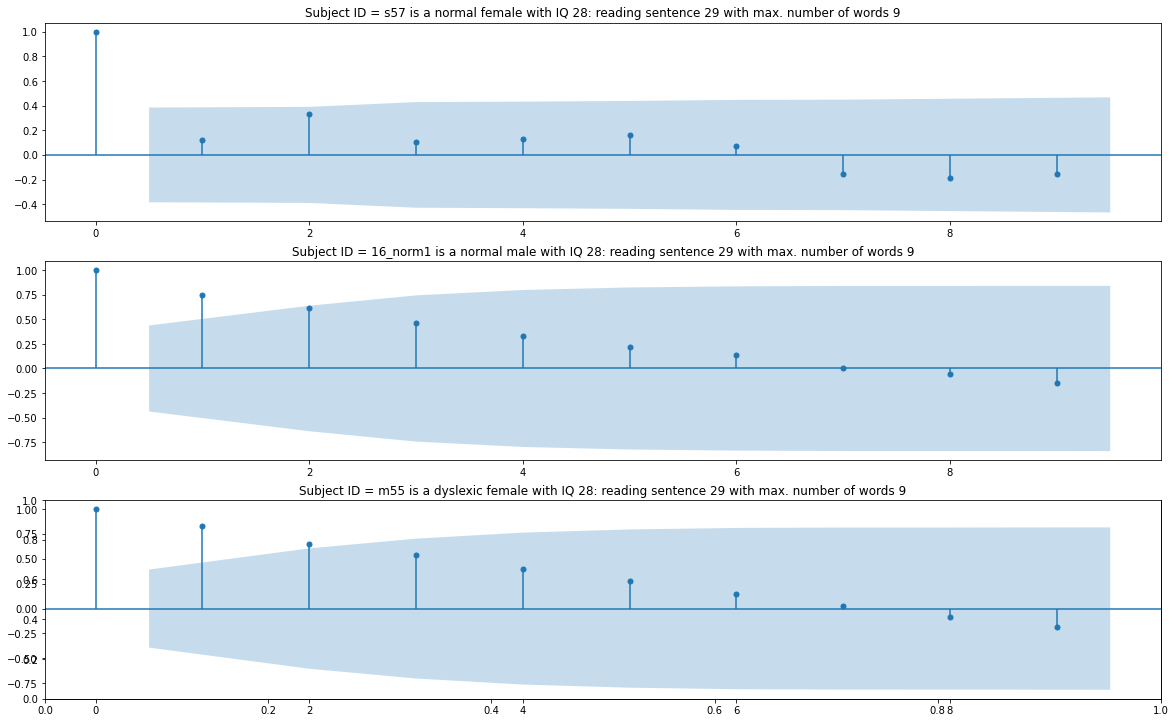

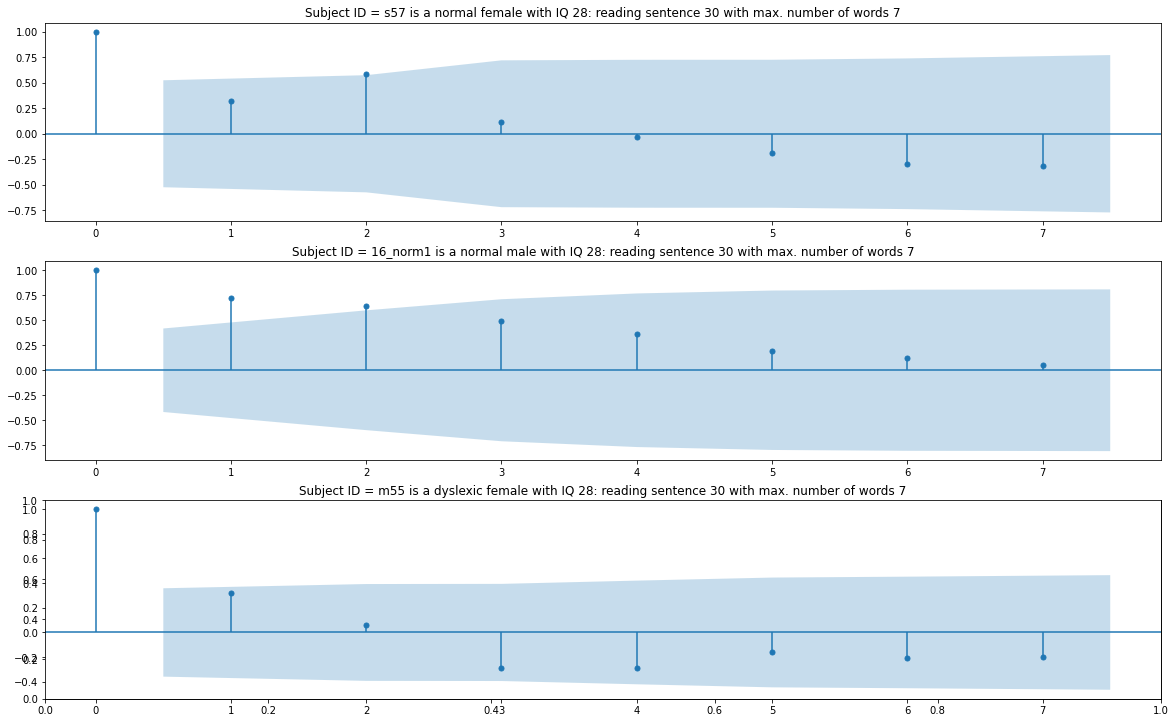

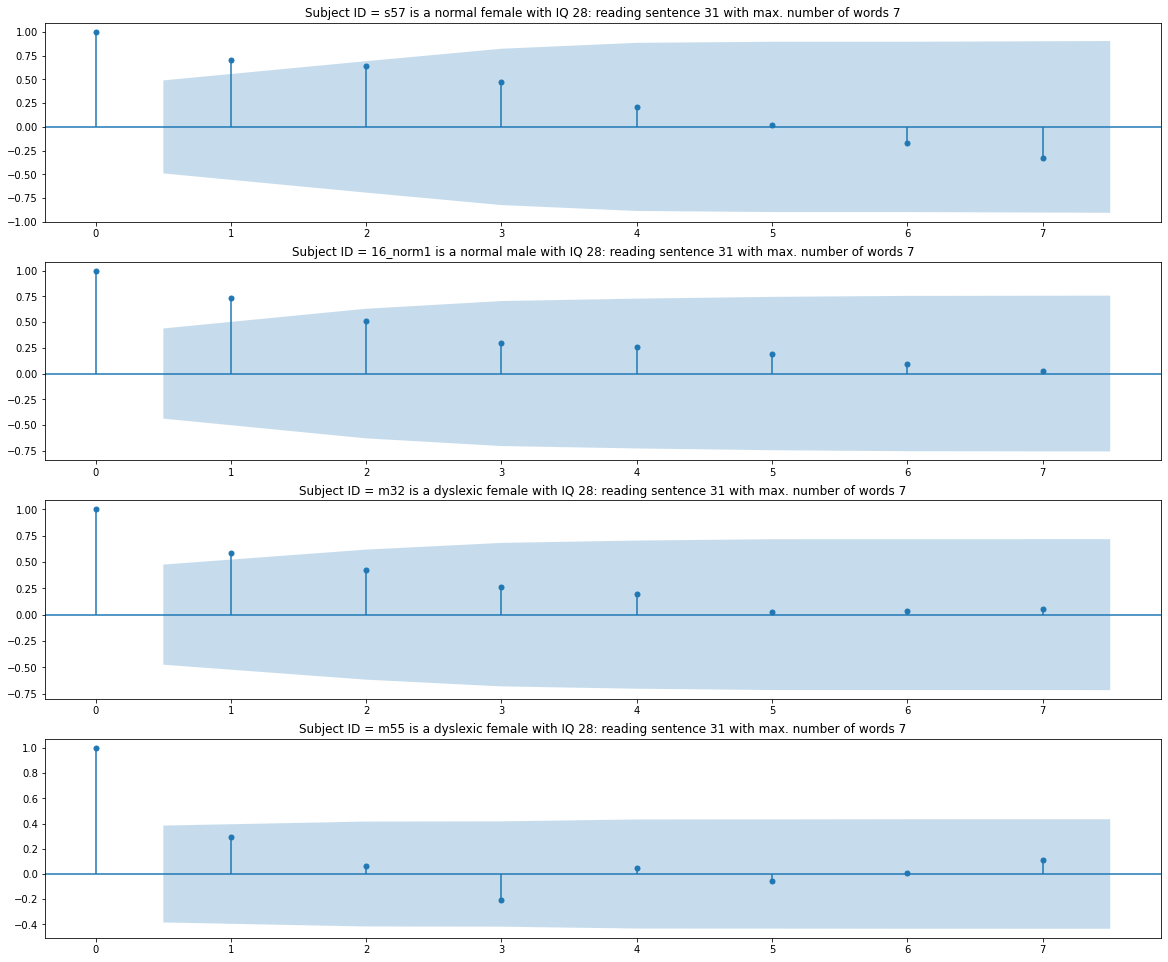

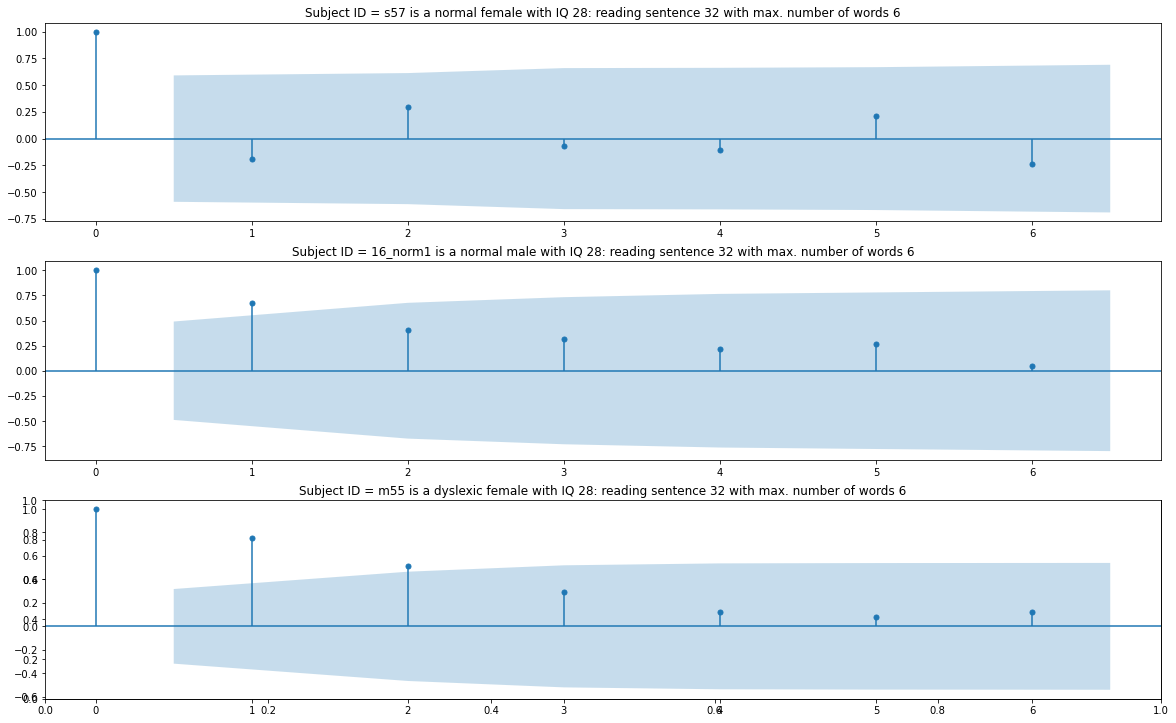

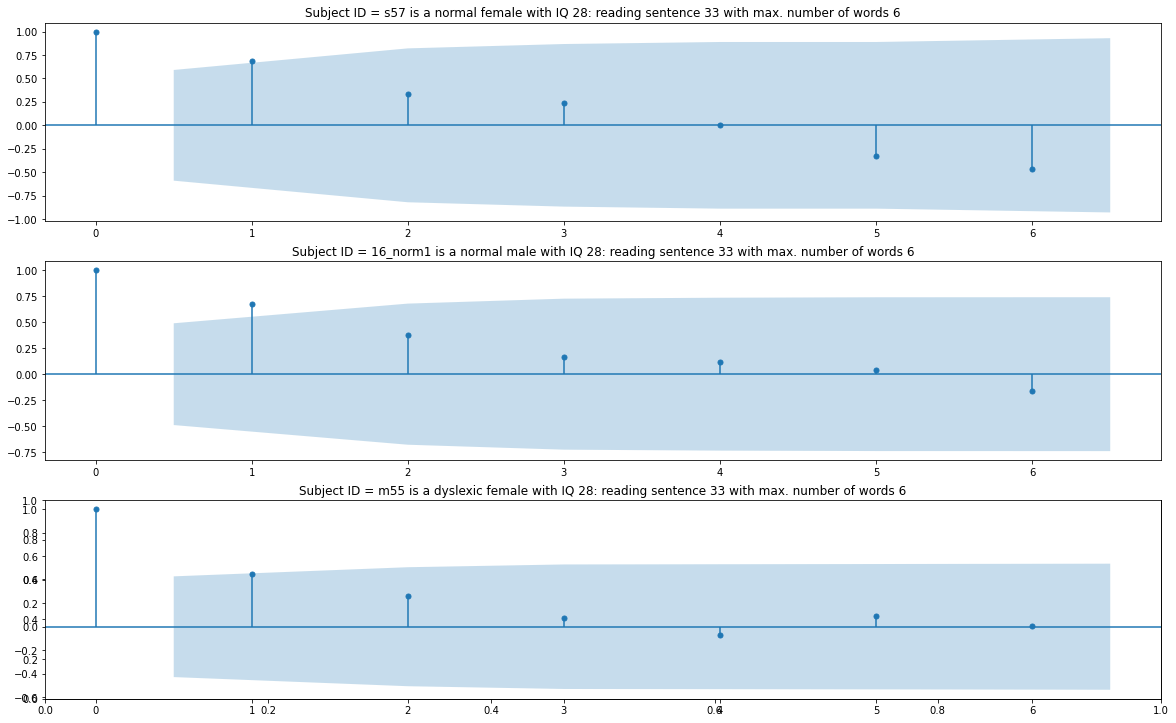

In [30]:



issues = plot_norm_vs_dyslexic_AFC(data_n=n2, data_d=d2, feature="FIX_Y", )





FIX_DURATION


invalid value encountered in true_divide
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


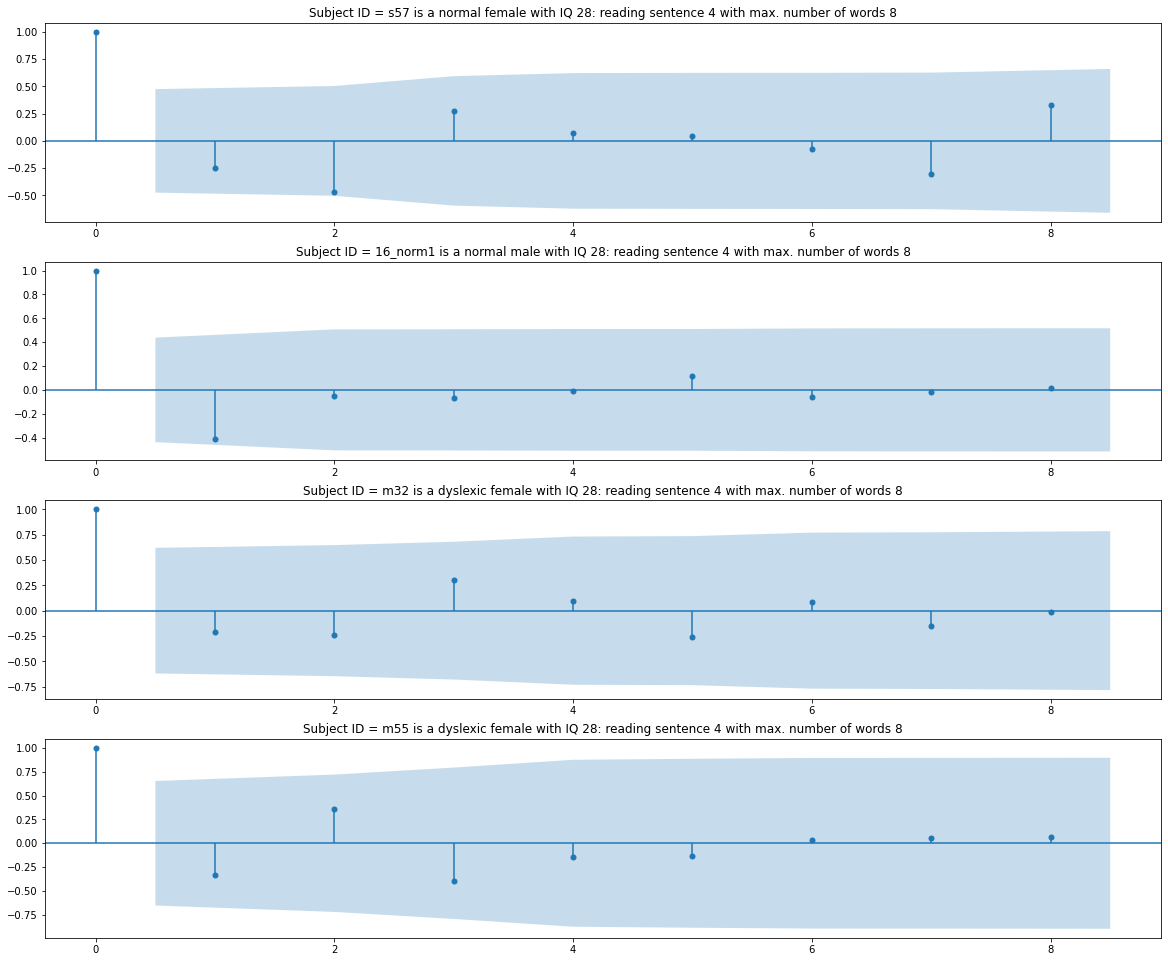

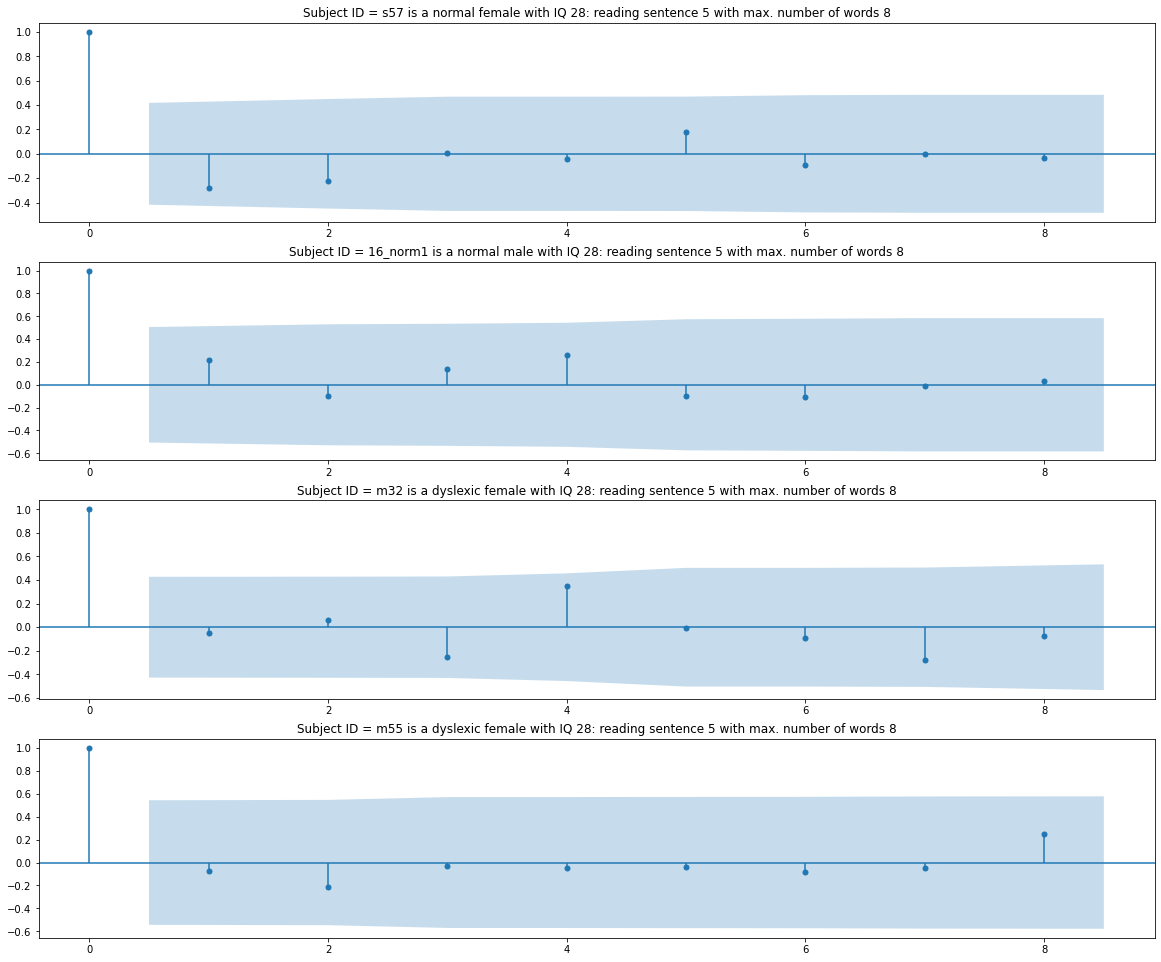

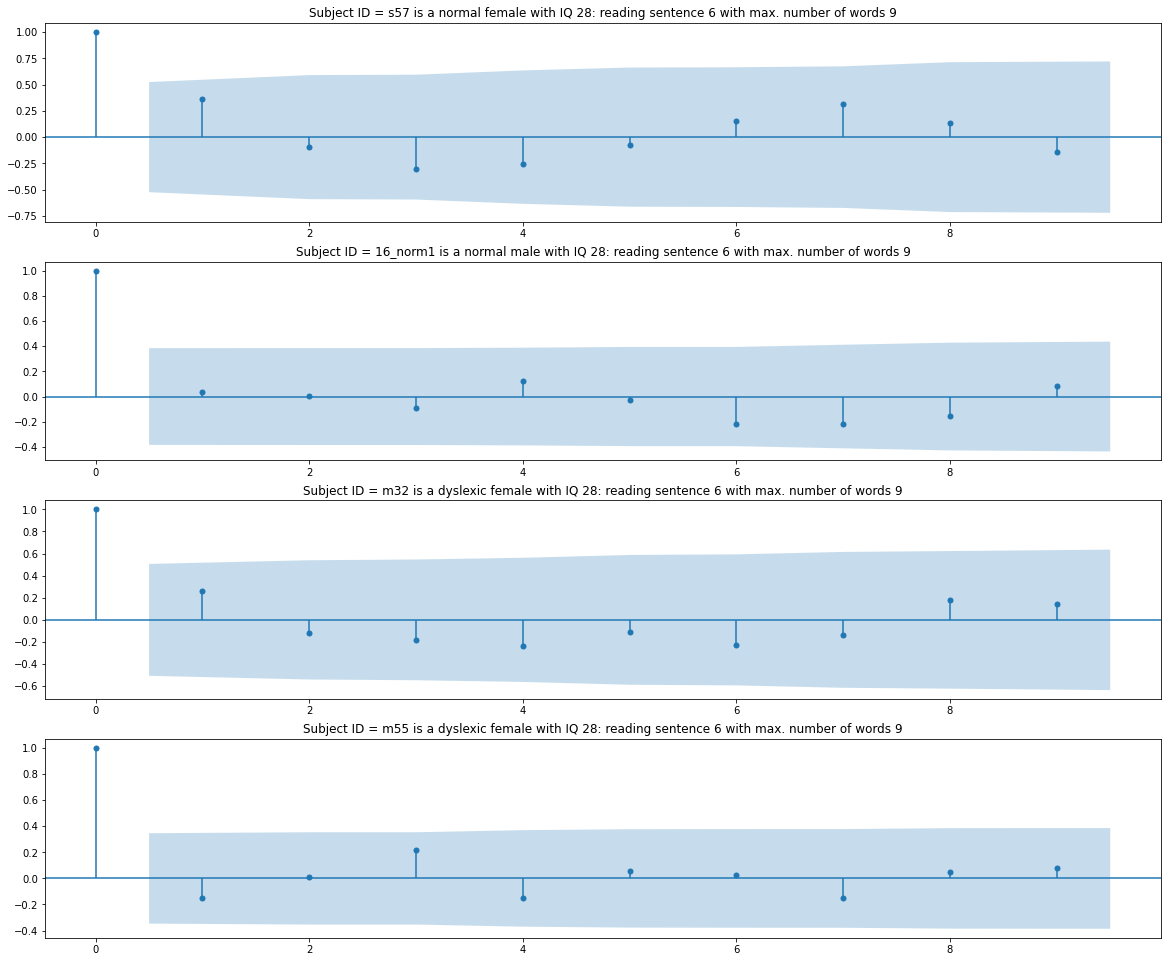

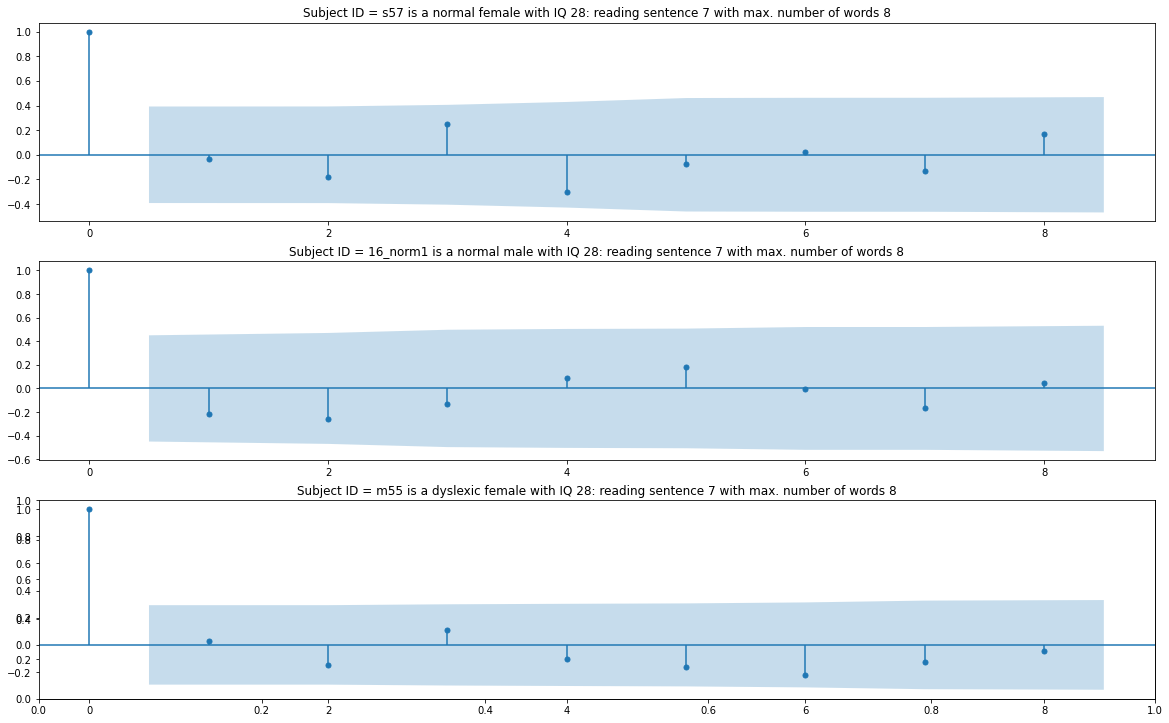

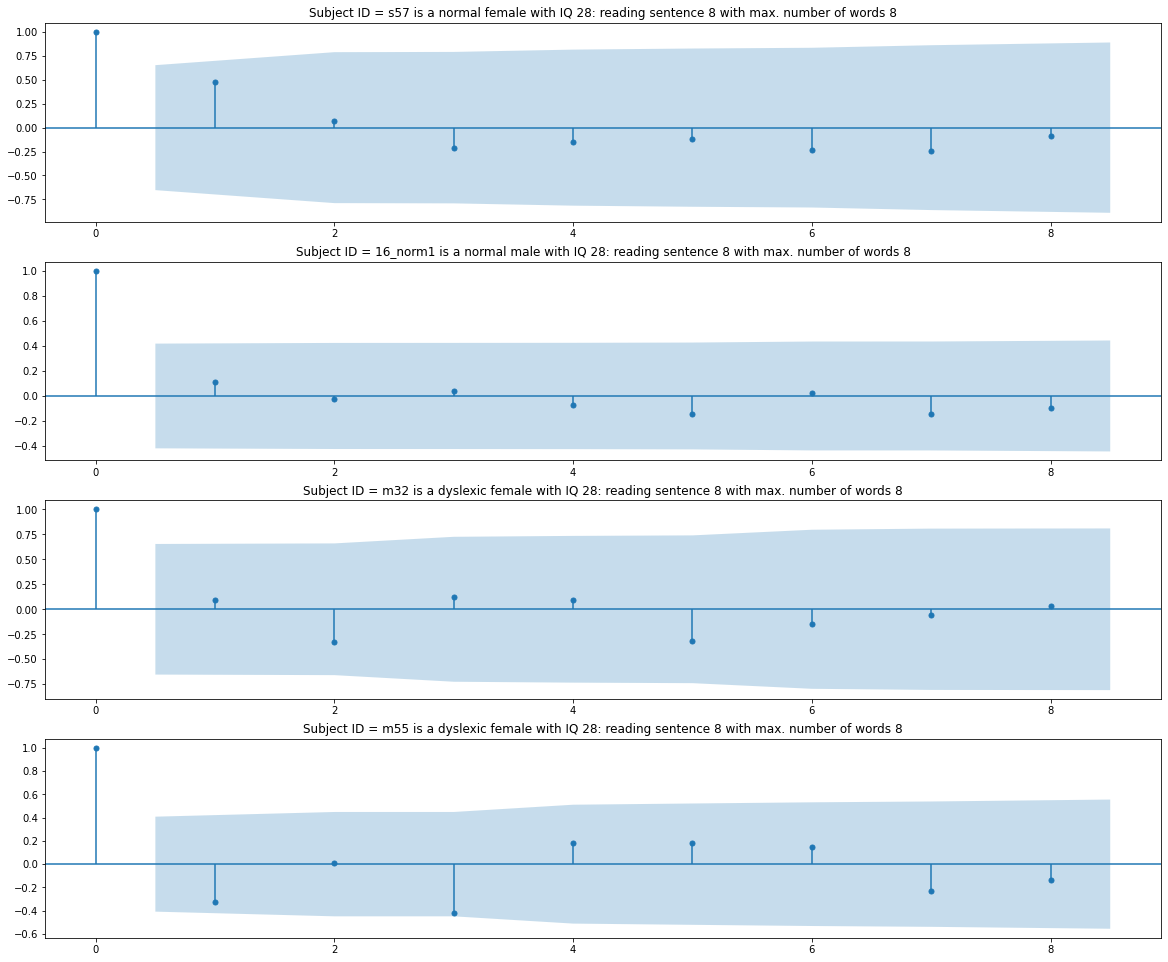

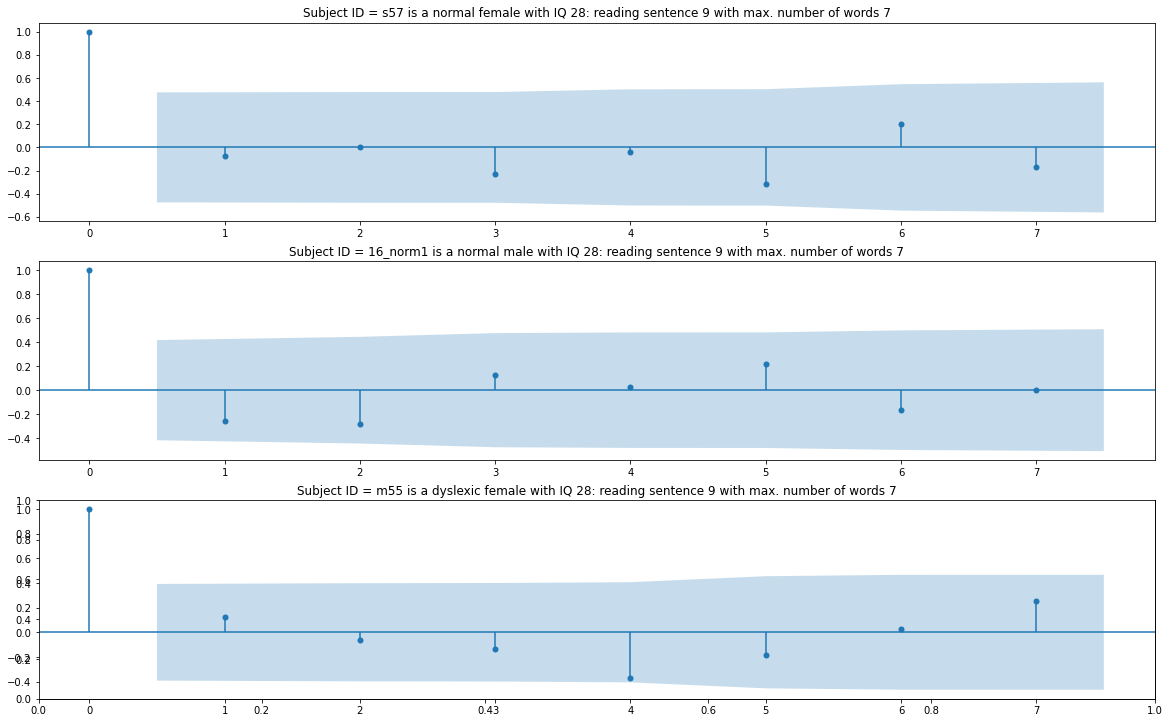

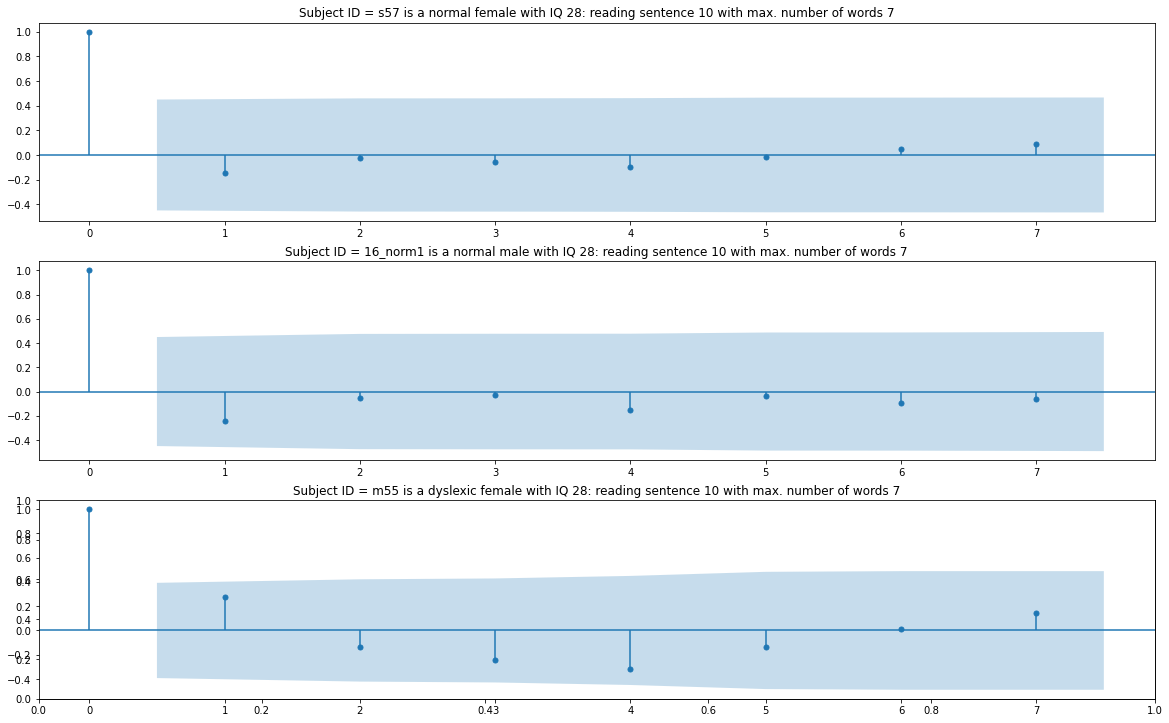

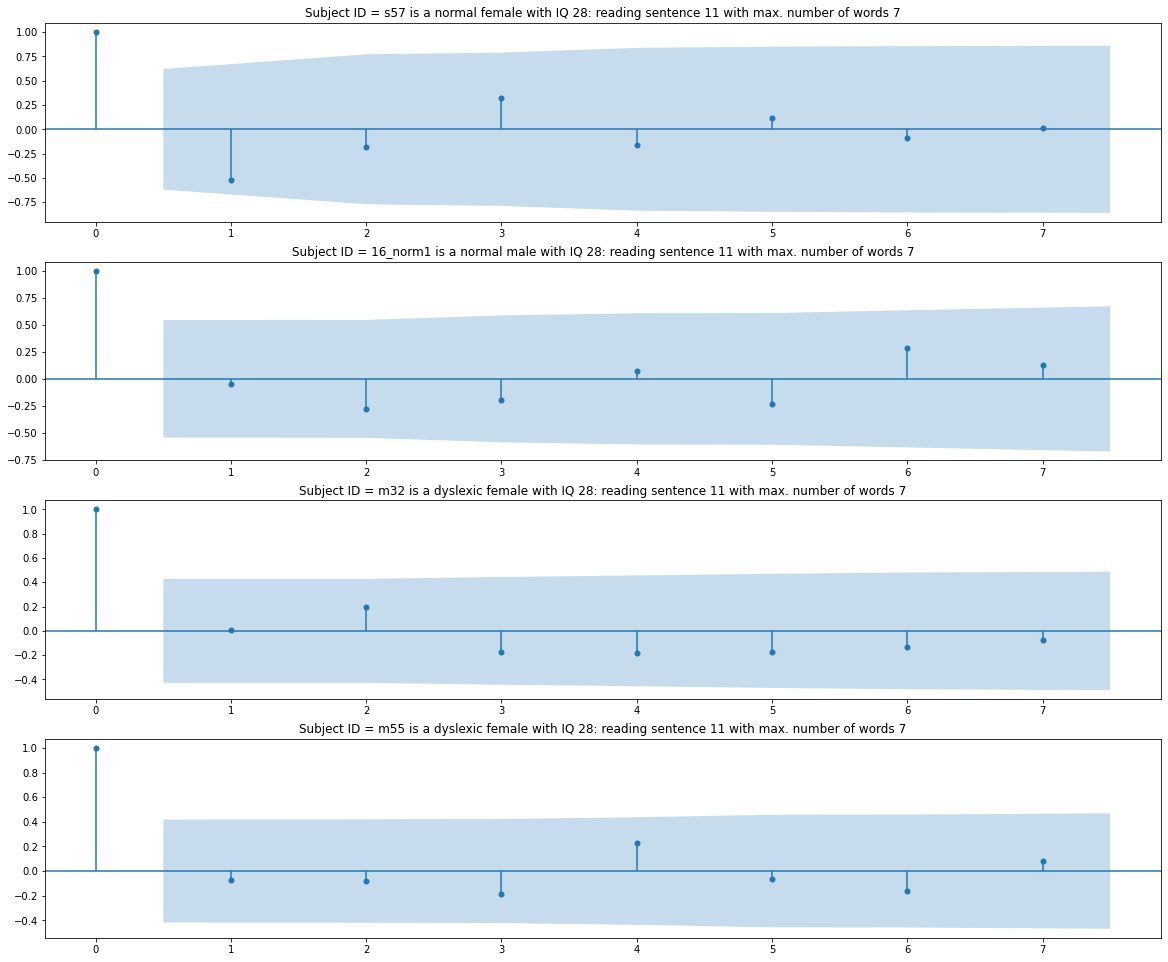

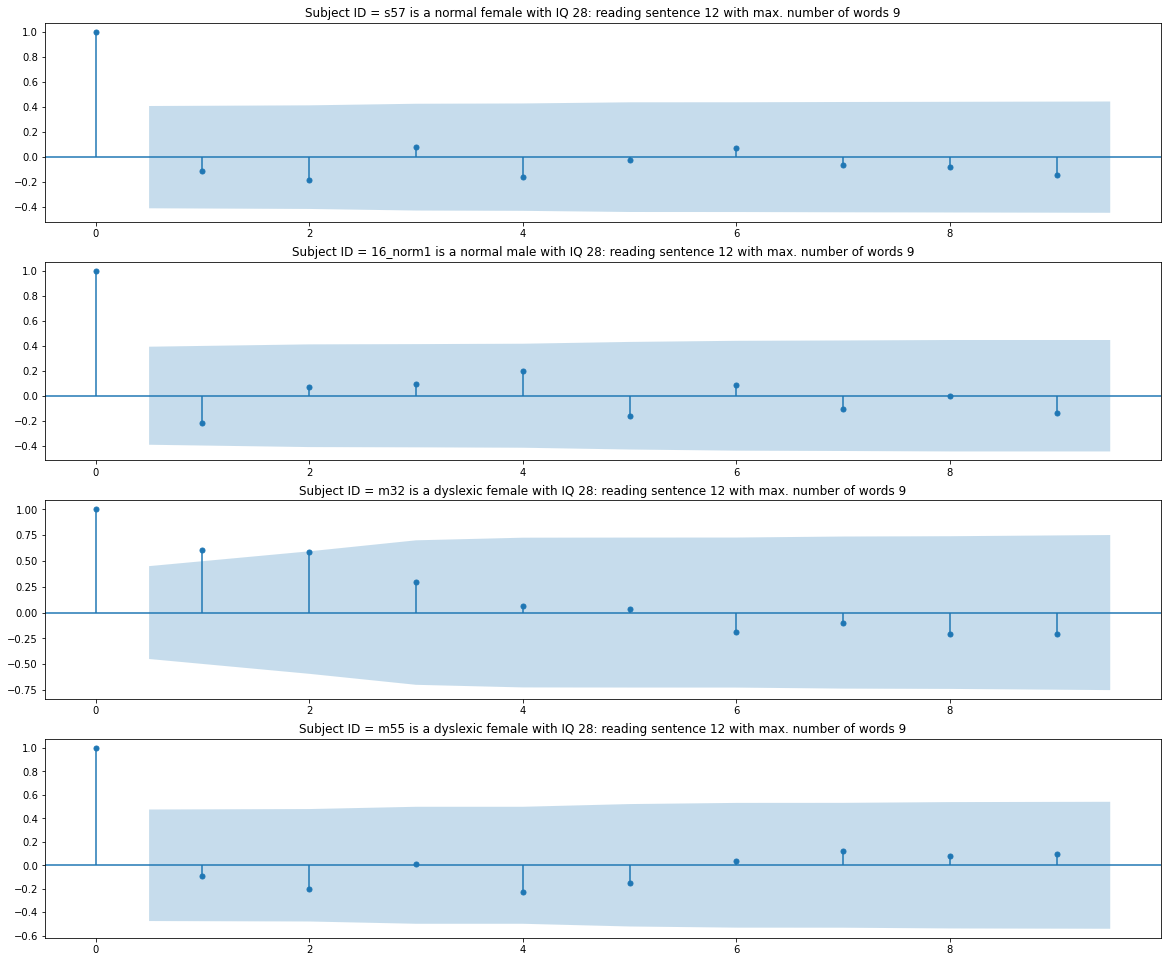

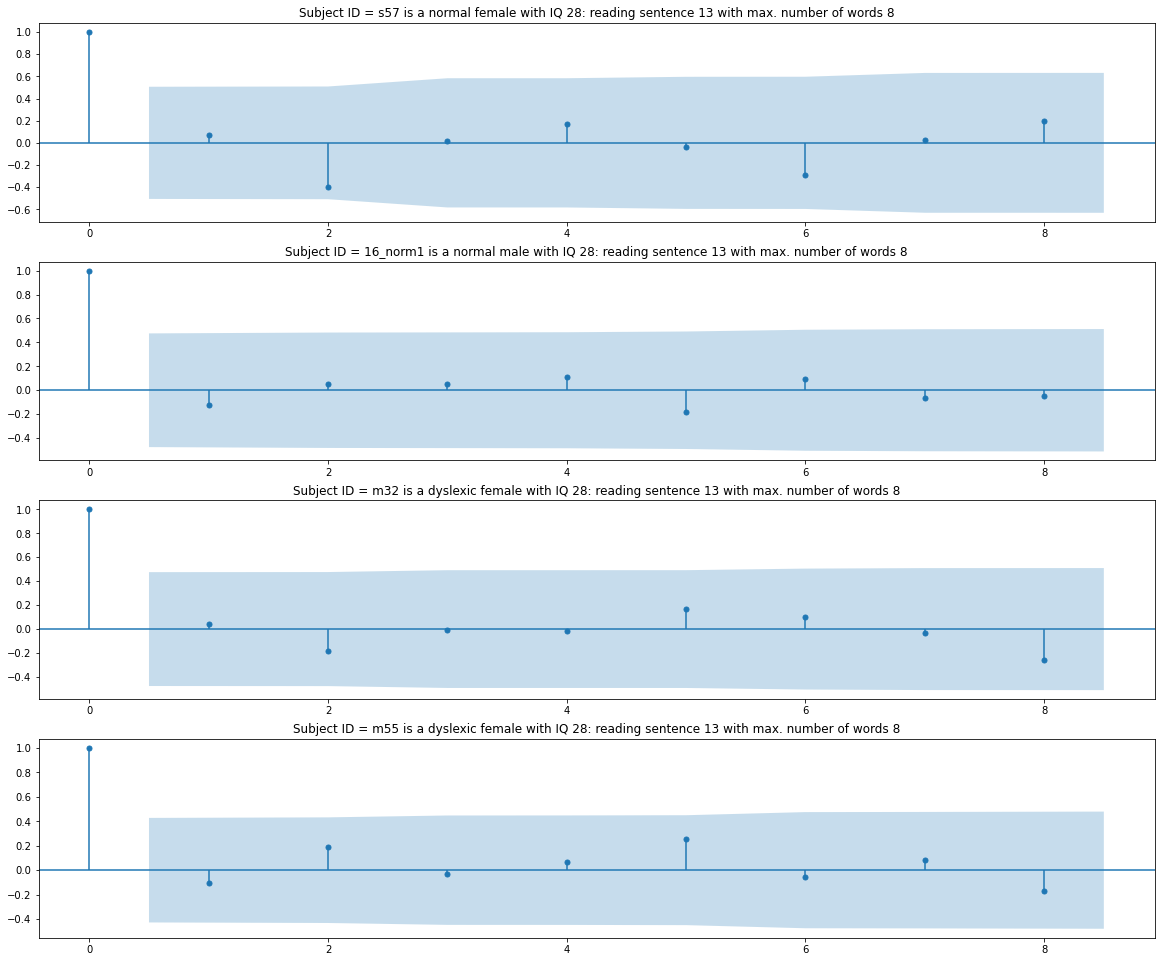

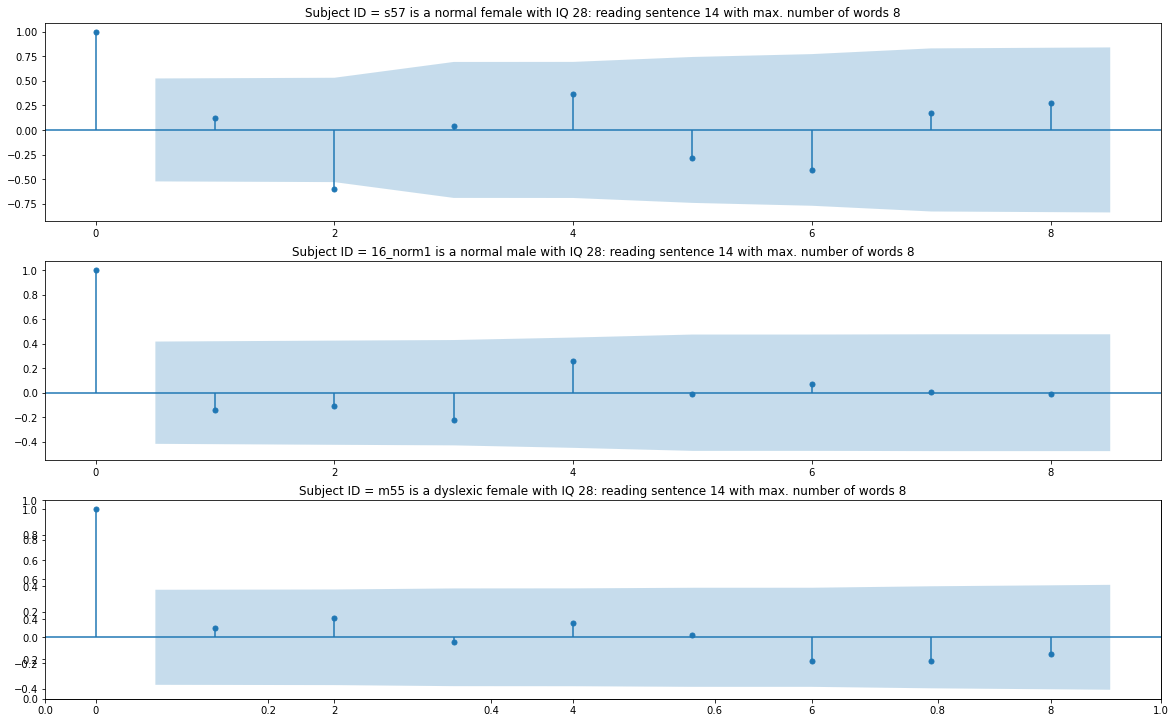

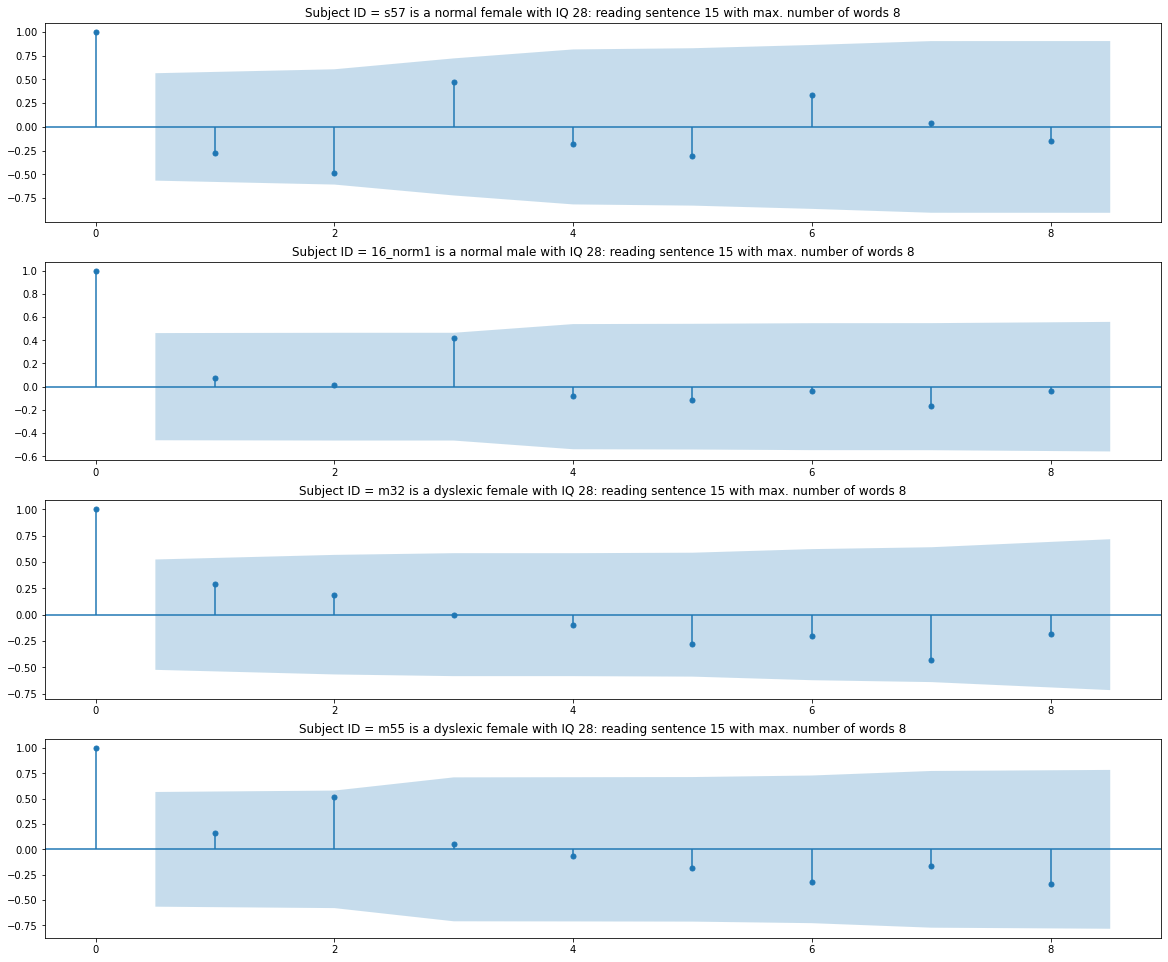

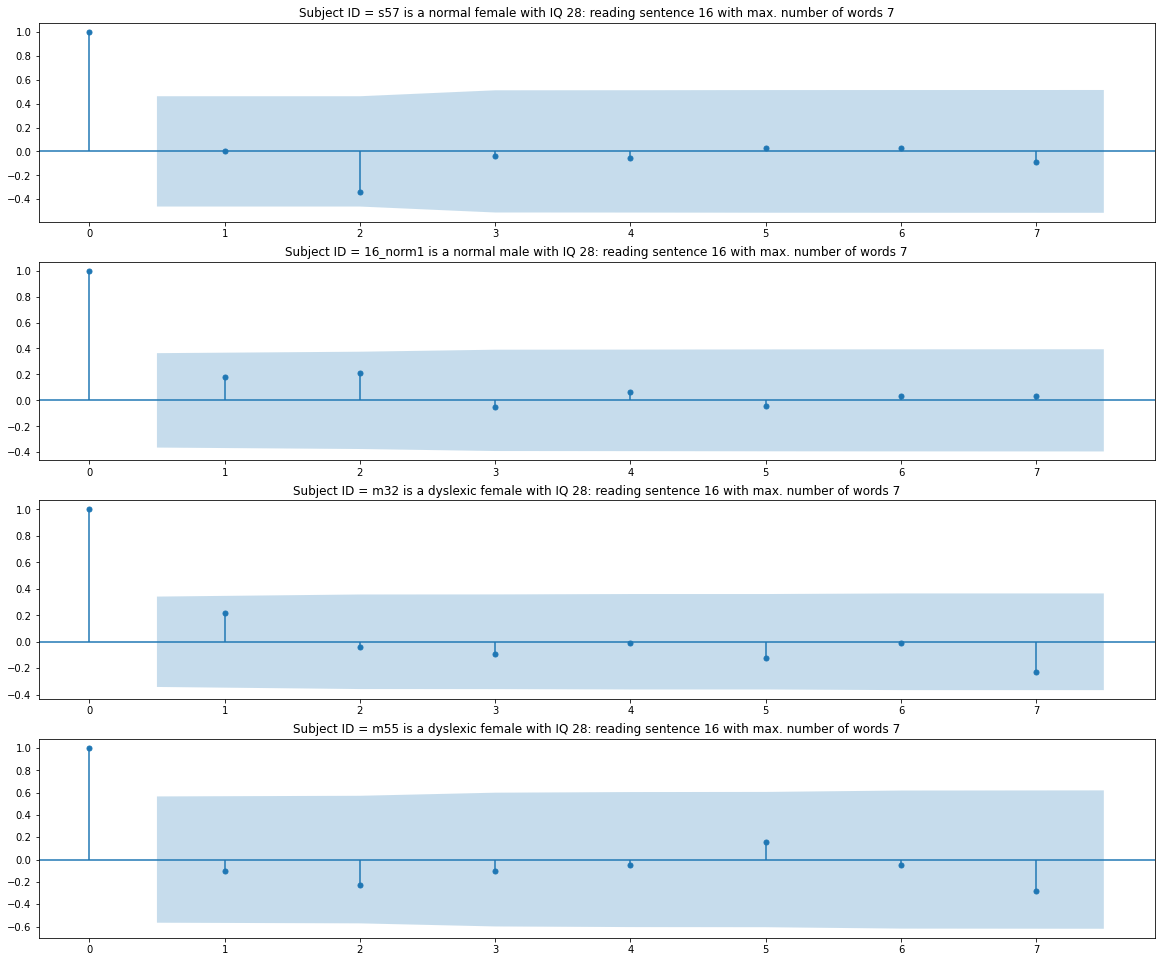

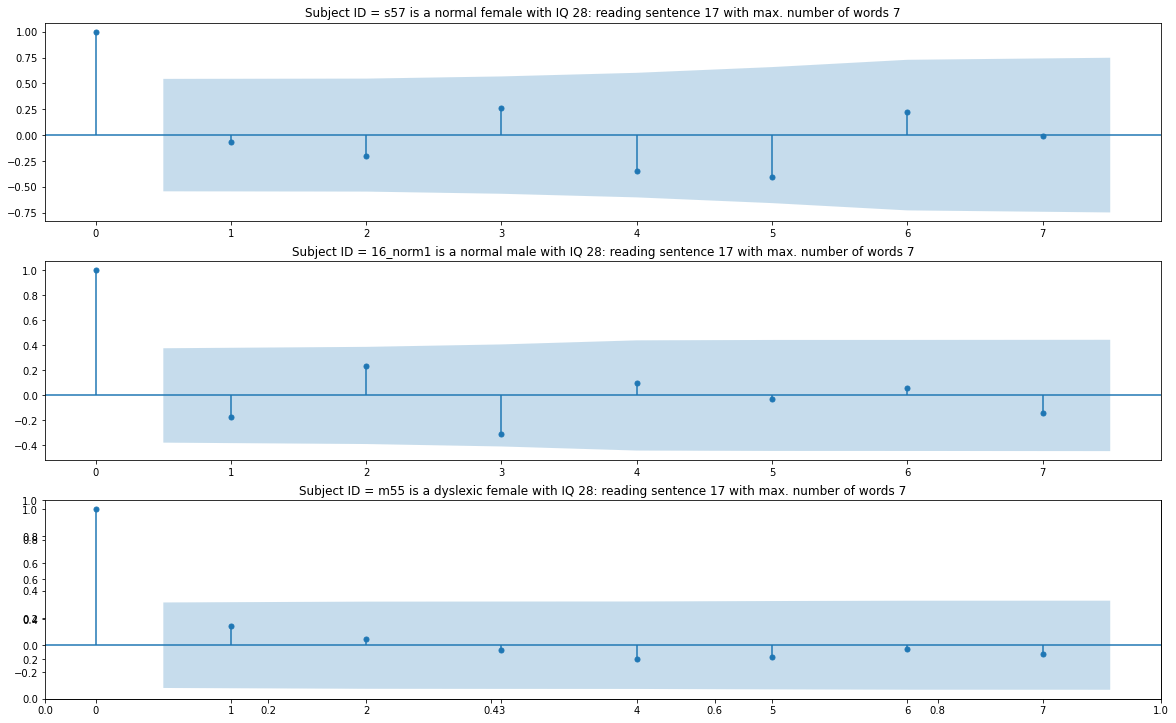

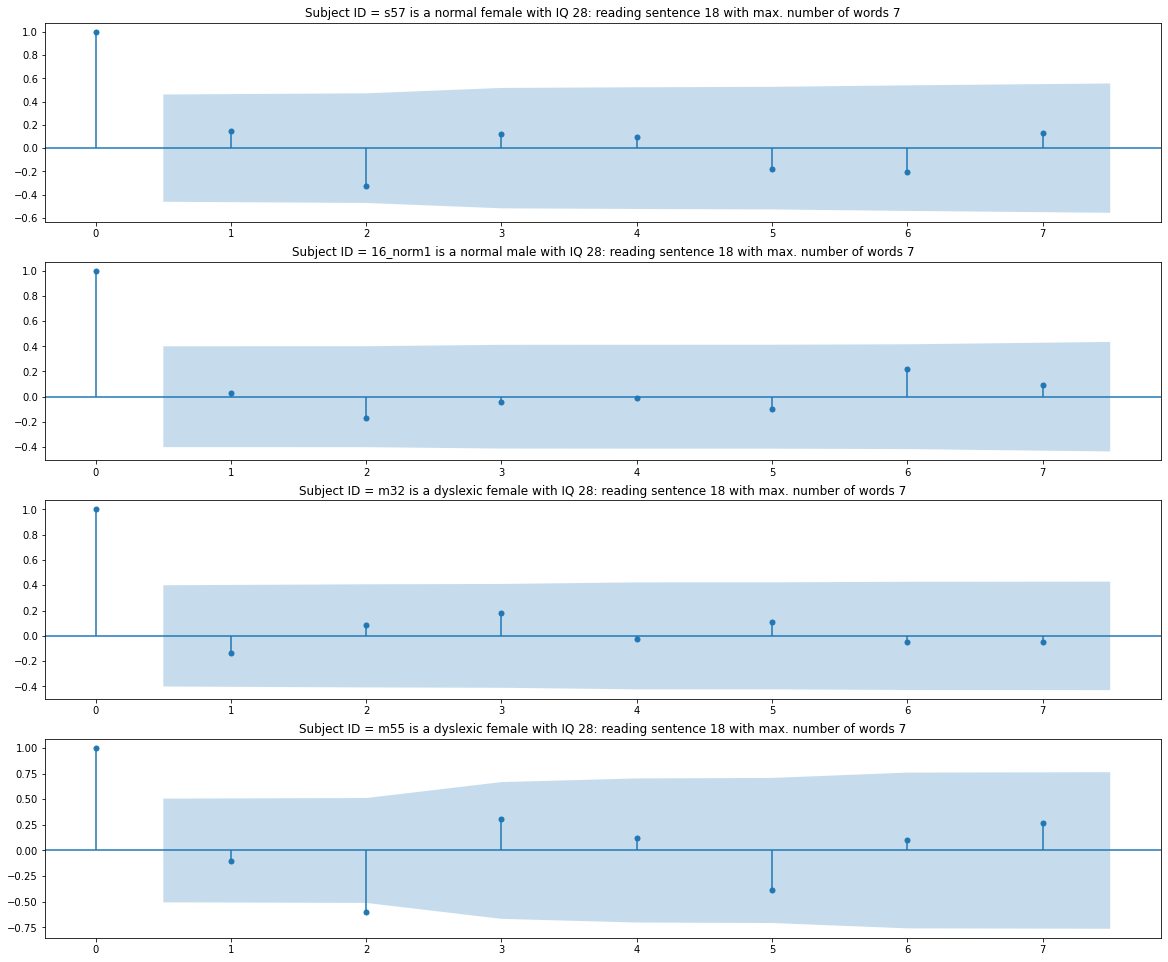

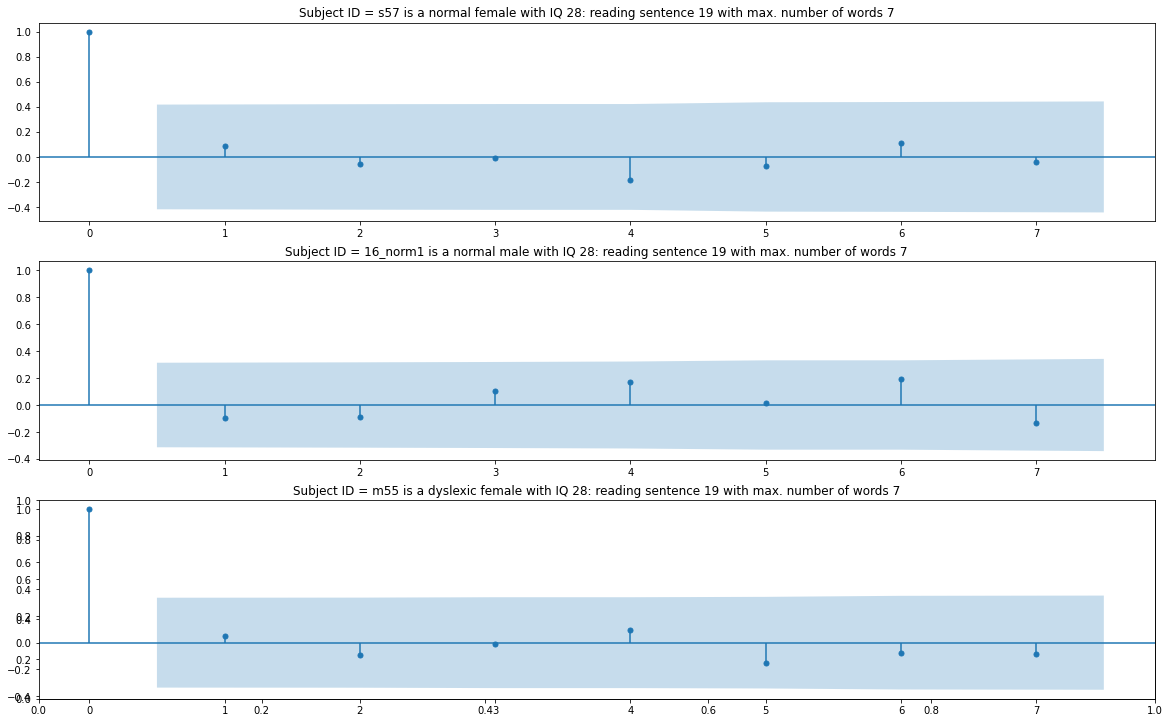

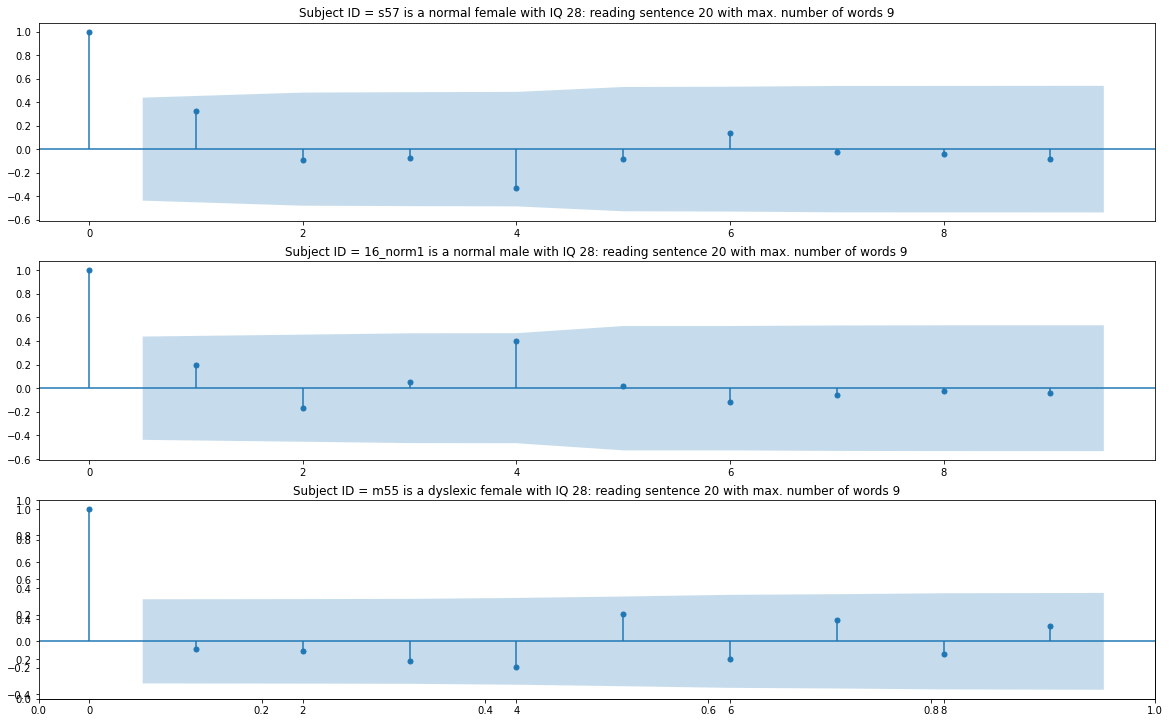

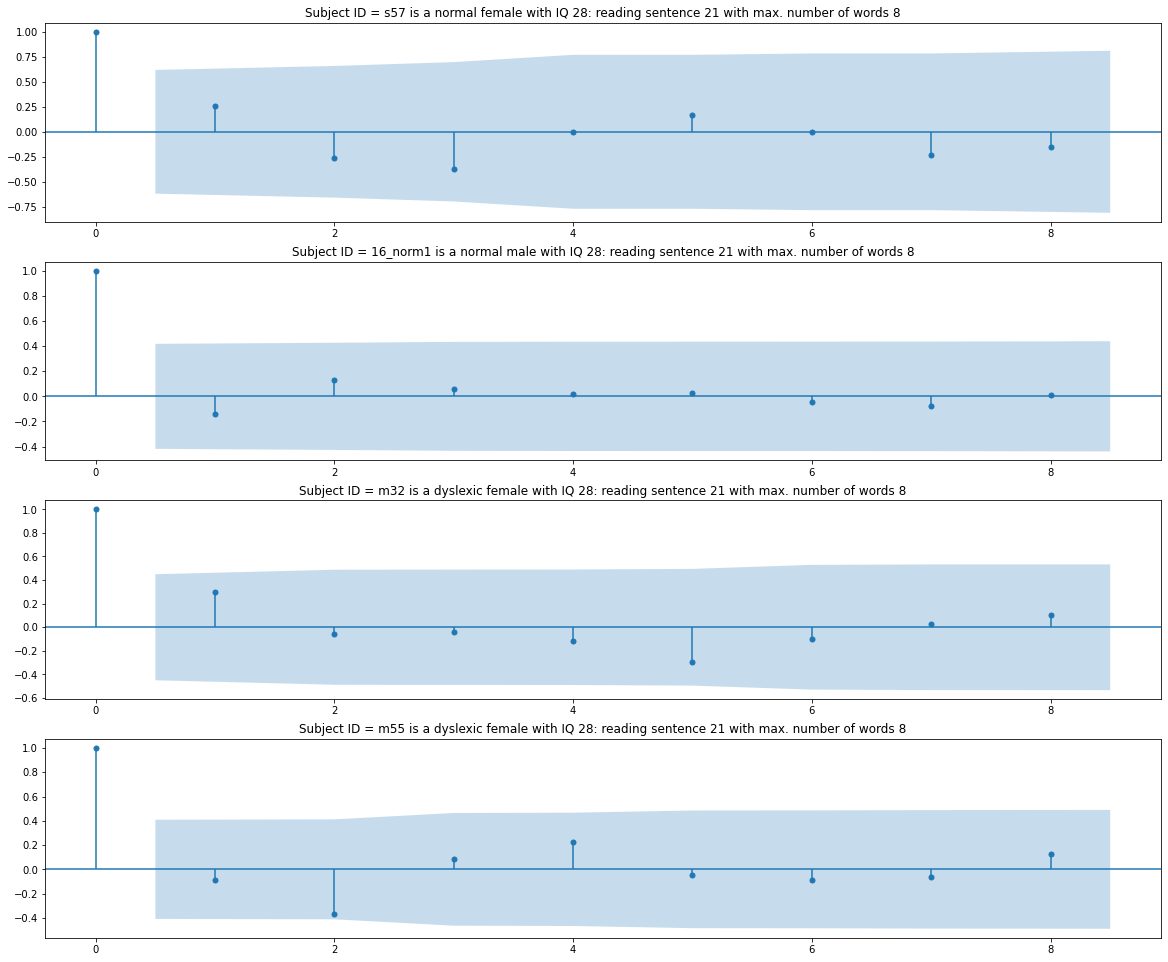

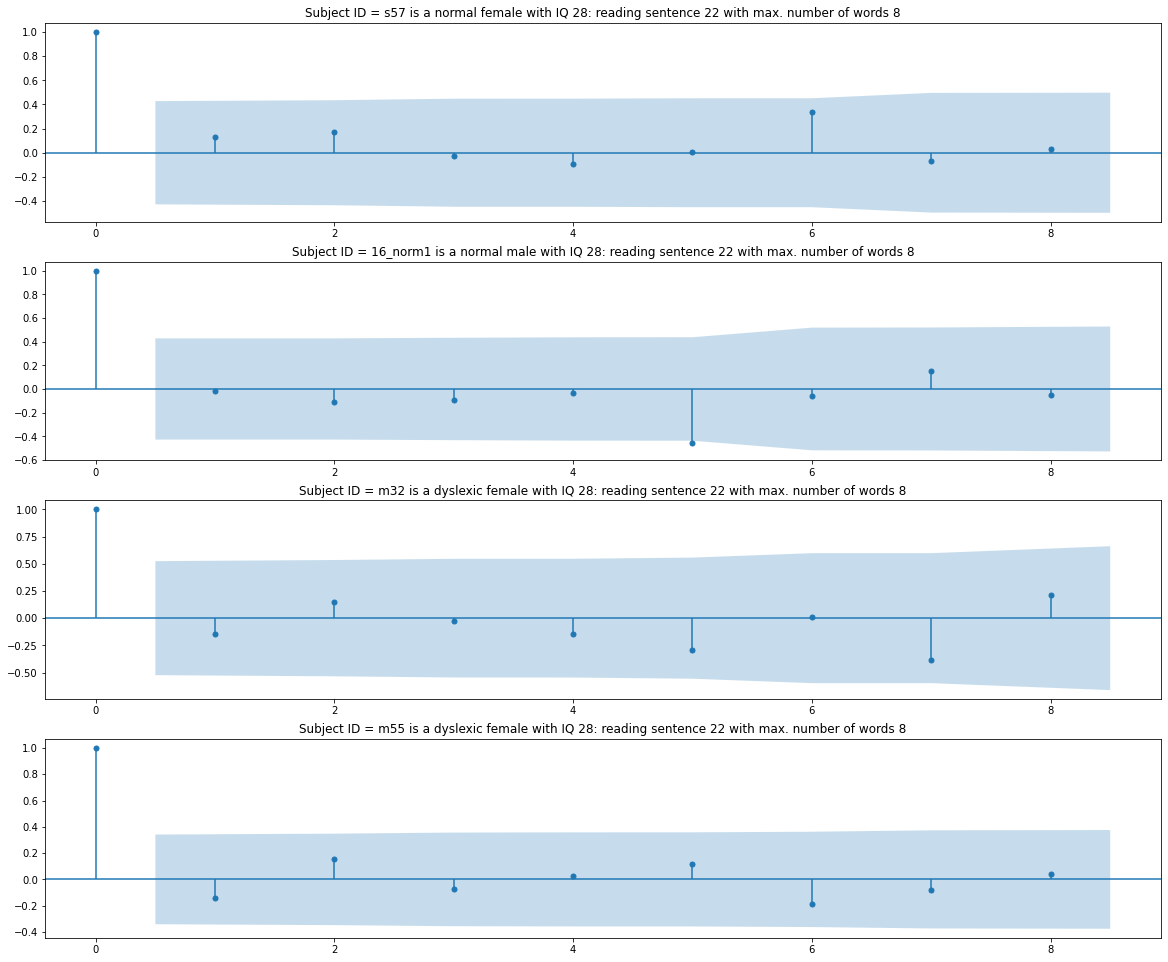

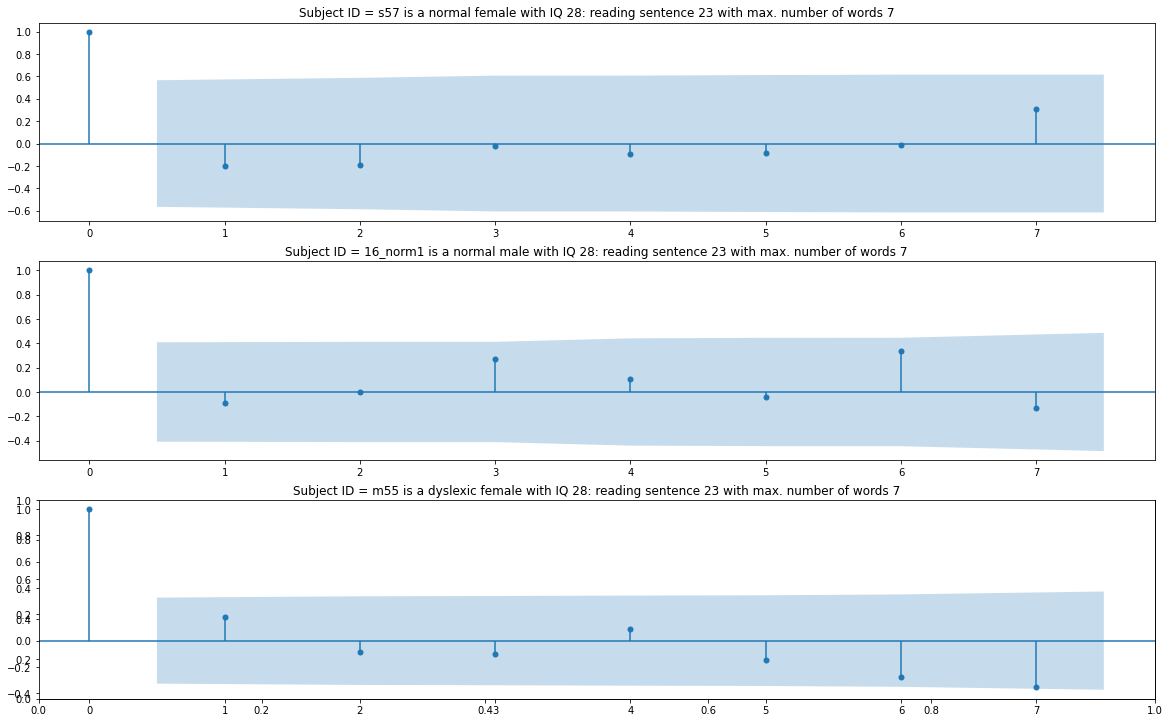

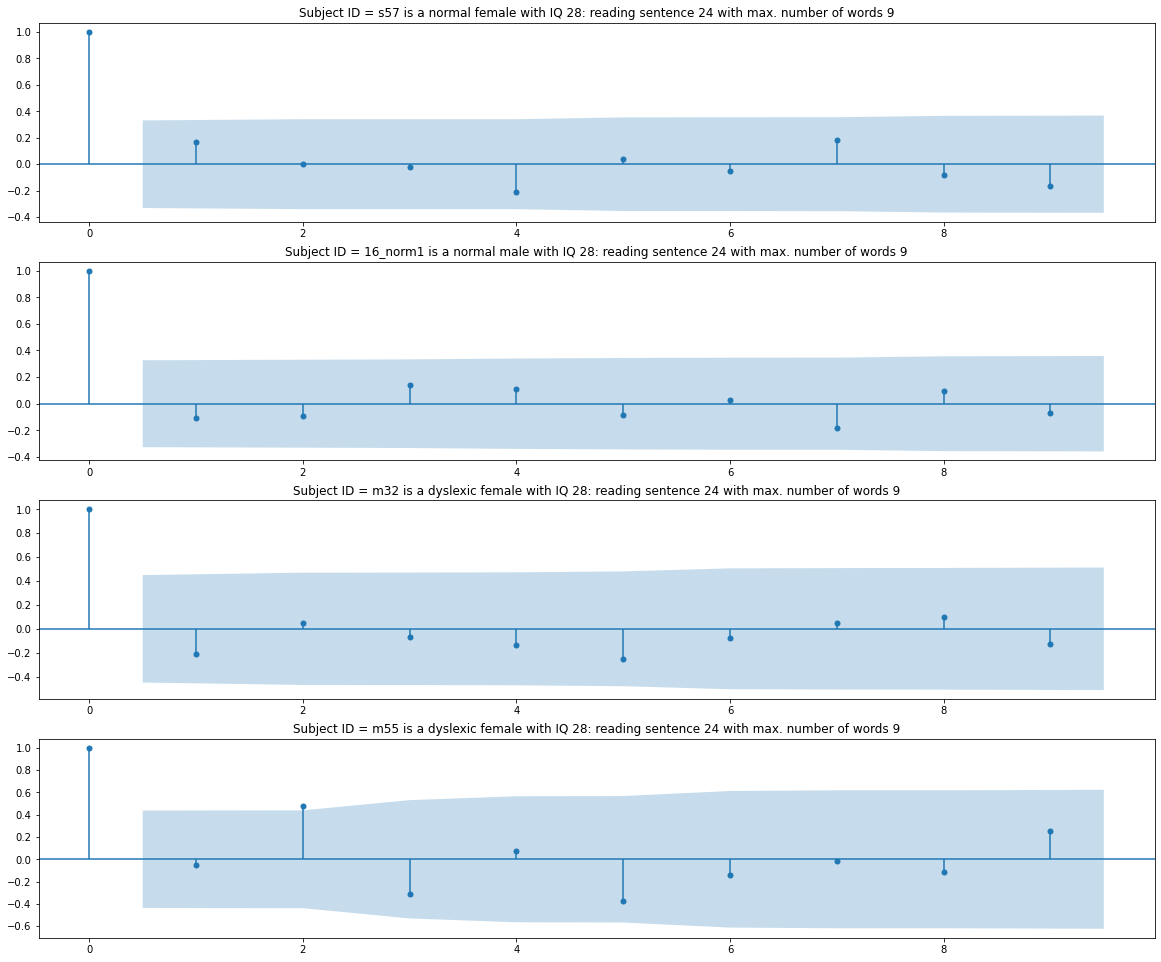

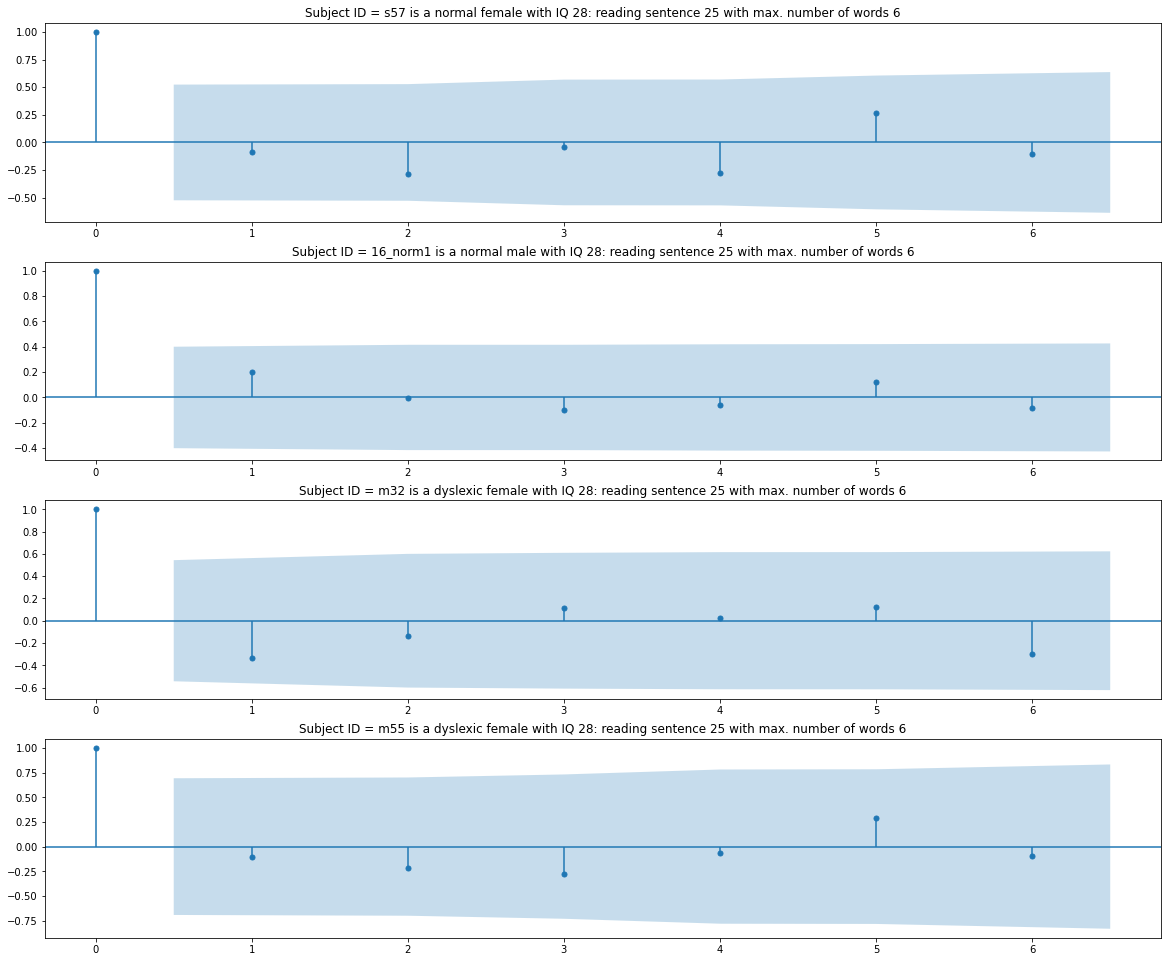

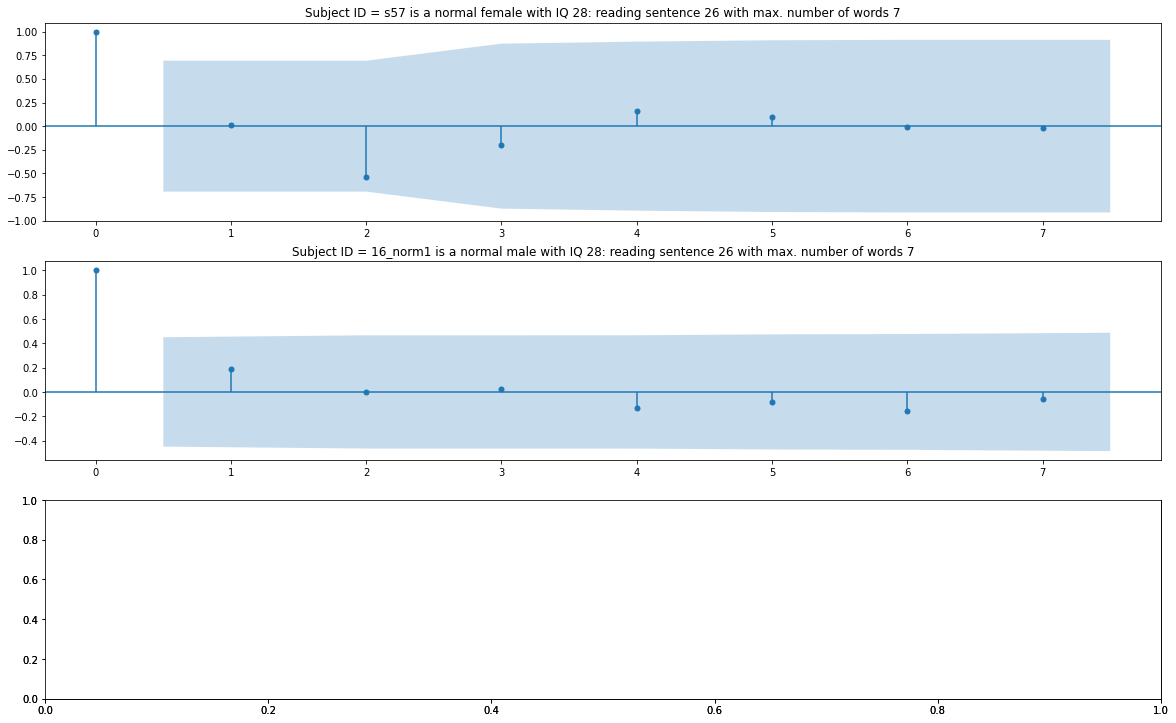

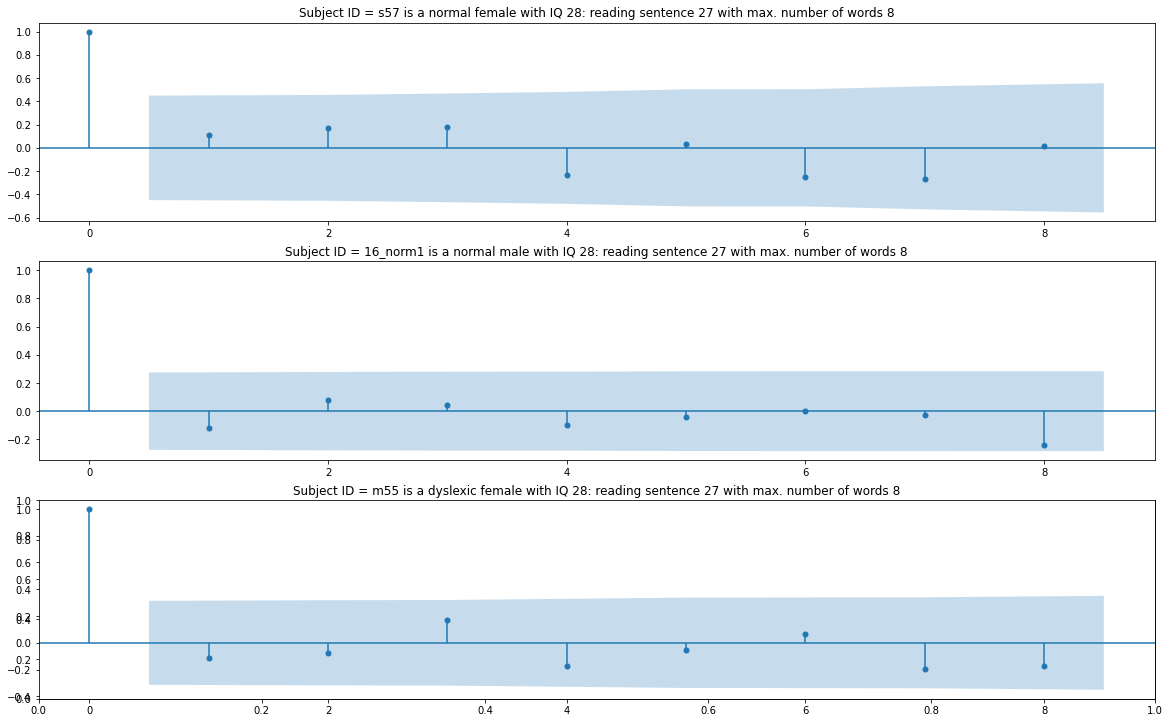

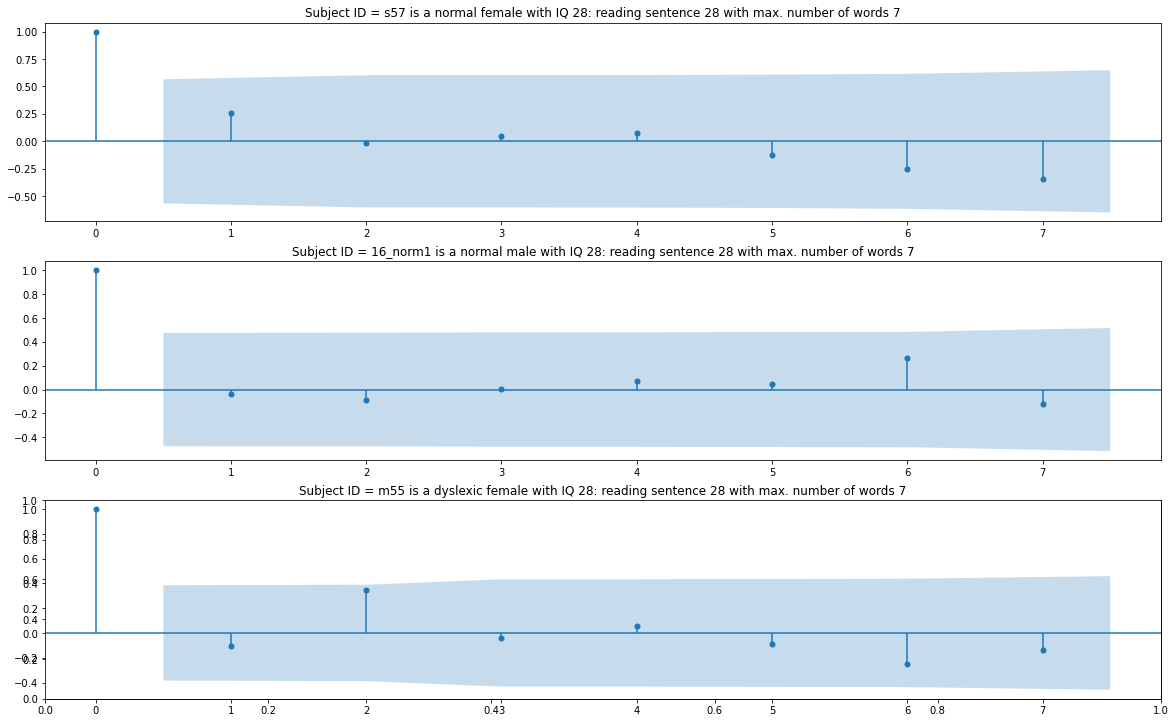

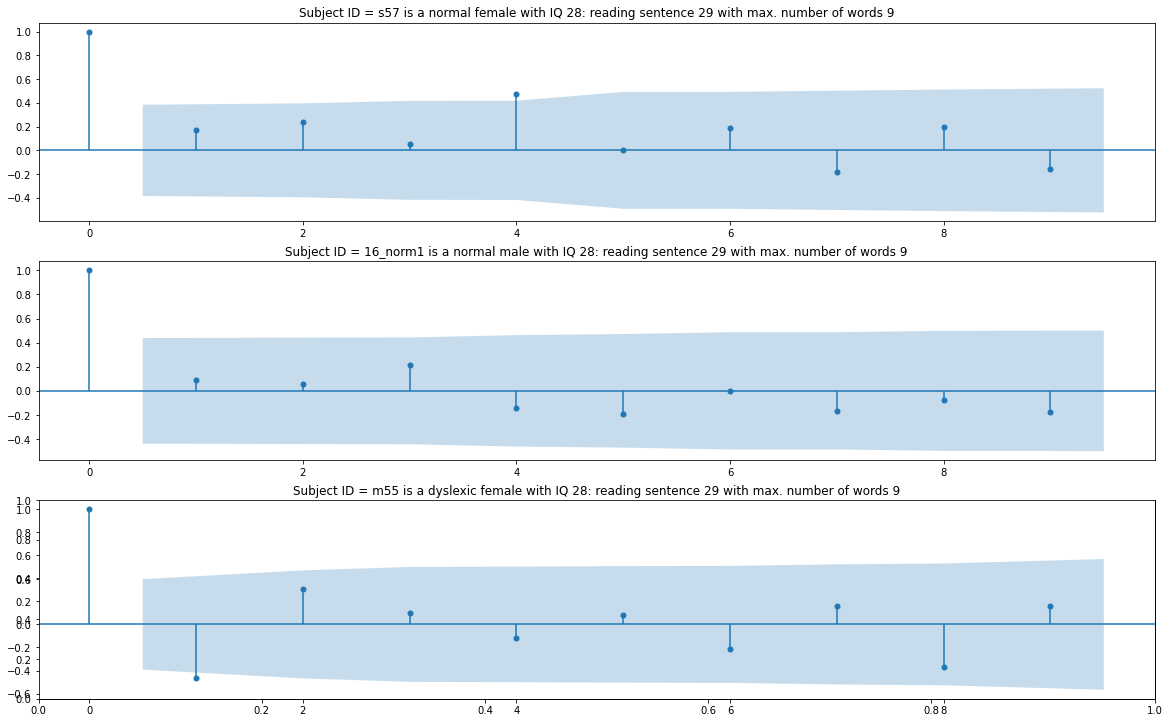

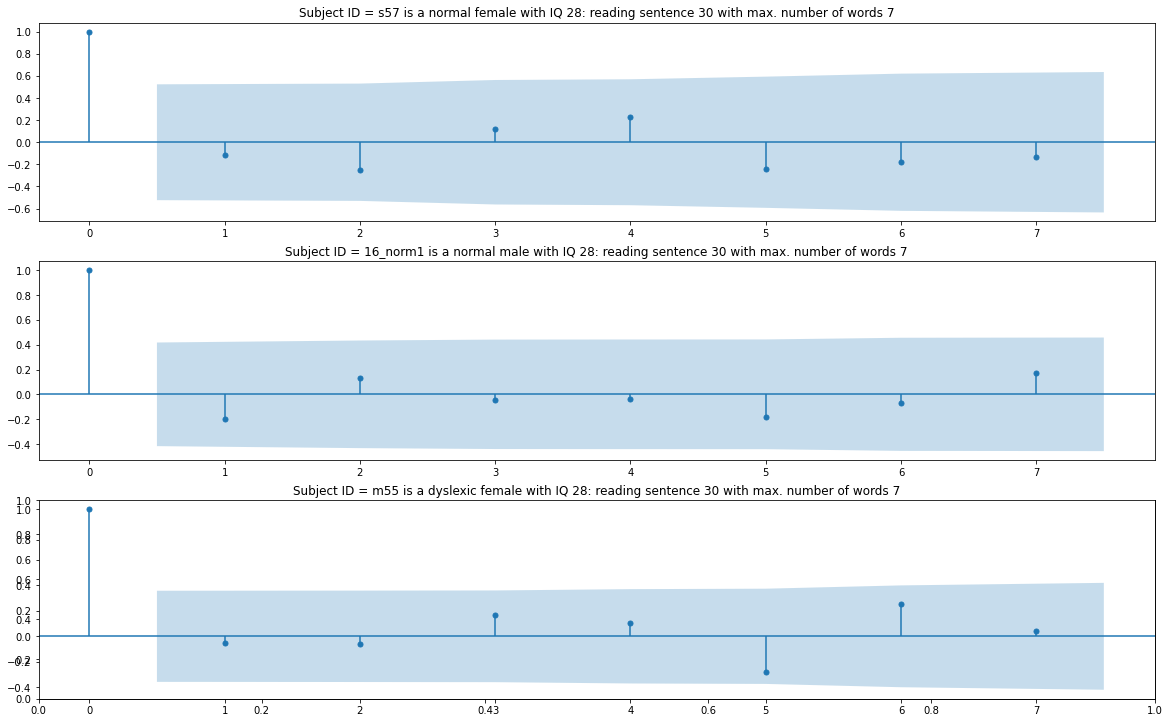

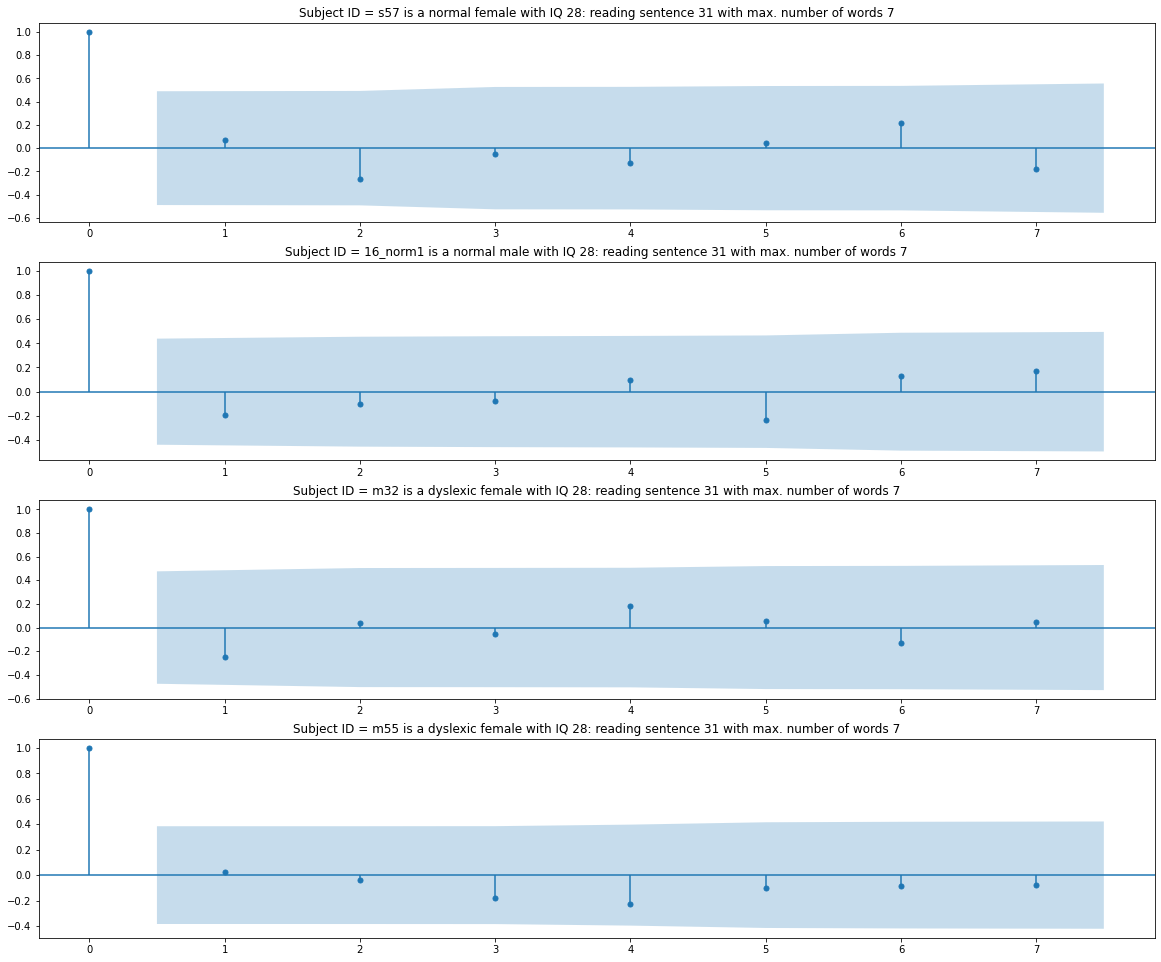

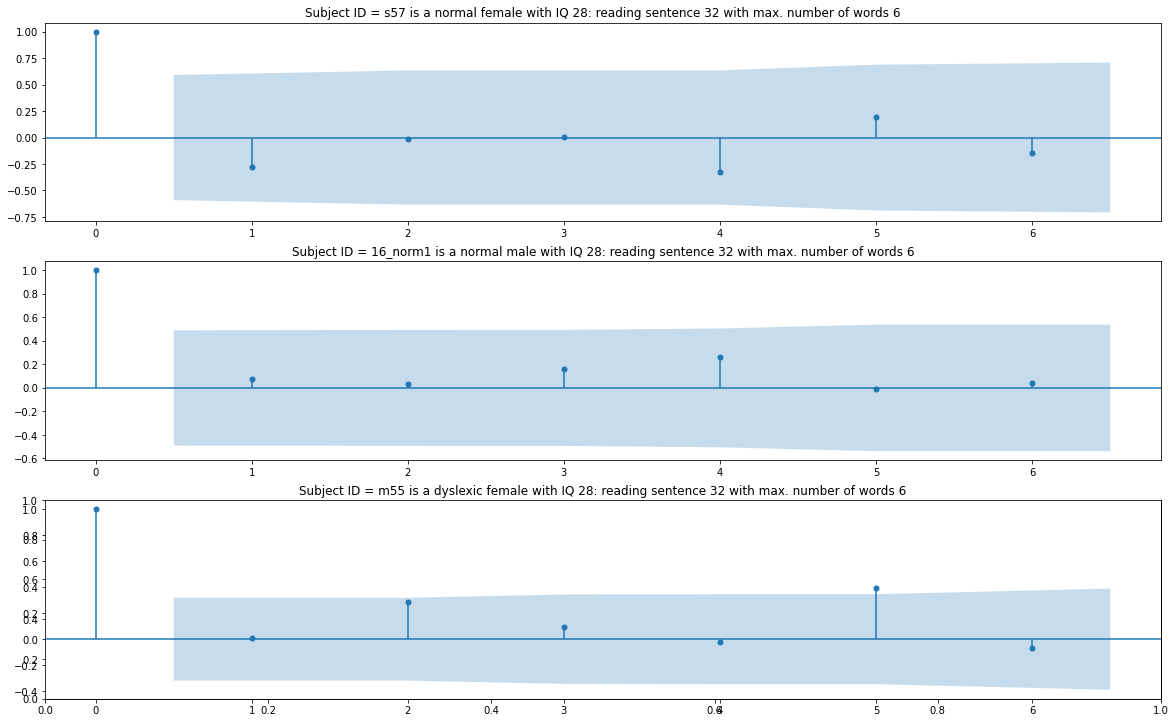

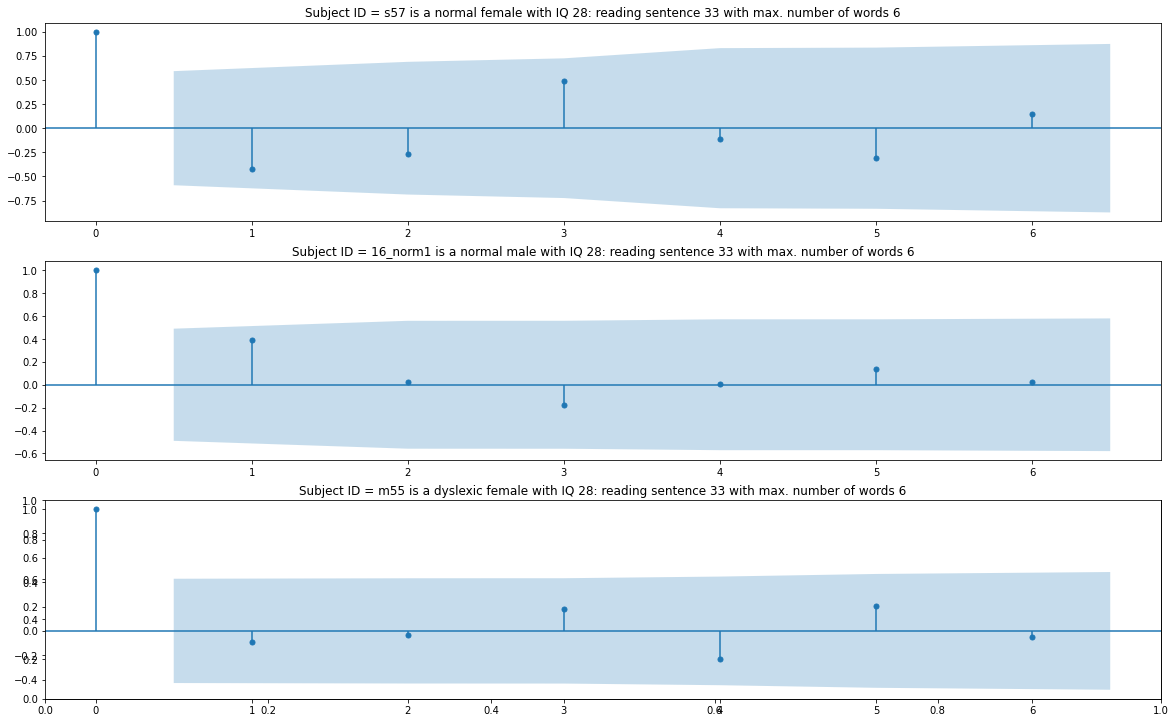

In [31]:


issues = plot_norm_vs_dyslexic_AFC(data_n=n2, data_d=d2, feature="FIX_DURATION", )




# Conclusion:

I cannot see statistically significant auto-correlations for the fixation report variables --especially considering figures of FIX_Y and FIX_DURATION. 
Thus I can reject the assumption of "the existence of time-dependencies between the variables of this report". 

- This experiment and these plots reveal several aspects of the problem:

1. We can simply shuffle the data because there is no time-dependency, that is we can simply assume that our data is IID.

2. Why do all of the algorithms fail to predict the target values using only fixation data?

Reason can be justified as follows.

    1. There aren't any significant patterns among FIX_X, FIX_Y and FIX_DURATION variables. However, combining the fixation data with demographic data has two-fold impacts: The demographic data is less noisy than the fixation data. Thus,  combining these two data sources helps the algorithm to discover patterns among the fixation variables and our target variables (this is why SHAP values of fixation varaibels is around 15%).


    2. It increases the number of training samples, and due to the large number theory, it is equivalent to increasing the number of trials, and thus the average of trials, that is, the algorithms predictions will be closer to expected values of the unknown underlying distribution of the data sets; Why do the without shuffling results are always inferrior than with shuffling?
